# Name:Saad,Mohammad

# Student no :300267006  

# Assignment(2)-Part(2)

# ELG7186 – AI for Cybersecurity Applications

Some important library imports

In [1]:
import numpy as np 
import pandas as pd
import csv
import matplotlib
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix,classification_report,accuracy_score,ConfusionMatrixDisplay
from io import BytesIO,StringIO
import ast
import pickle

Reading the dataset for training the static classifier :<br>

In [2]:
dataset=pd.read_csv('iot_static_data.csv')
y=np.array(dataset.pop('Class'))
X=dataset.copy()

The data in the column 'Source' are nominal , so we are applying label encoding.

In [3]:
label_encoder = LabelEncoder()
X['Source']= label_encoder.fit_transform(X['Source'])


splitting the given dataset for training and testing :

In [4]:
X1=np.nan_to_num(X,nan=0,posinf=0,neginf=0)
X_train, X_test, y_train, y_test = train_test_split(X1,y,stratify=y, test_size=0.33, random_state=42)

Training the static classfier and testing using the test split: 

In [5]:
clf=RandomForestClassifier(random_state=0).fit(X_train,y_train)
y_prdict=clf.predict(X_test)

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00      7355
  gafgyt_combo_attack       1.00      0.33      0.50         6
   gafgyt_junk_attack       0.98      0.99      0.98       124
   gafgyt_scan_attack       0.99      1.00      0.99        66
    gafgyt_tcp_attack       1.00      0.97      0.99        70
    gafgyt_udp_attack       0.99      1.00      0.99       147
     mirai_ack_attack       0.97      1.00      0.98        32
    mirai_scan_attack       1.00      1.00      1.00        28
     mirai_syn_attack       1.00      1.00      1.00        33
     mirai_udp_attack       1.00      1.00      1.00       586
mirai_udpplain_attack       1.00      0.75      0.86         4

             accuracy                           1.00      8451
            macro avg       0.99      0.91      0.94      8451
         weighted avg       1.00      1.00      1.00      8451



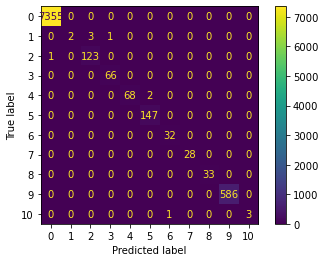

In [6]:
print(classification_report(y_test, y_prdict))
cm_test=confusion_matrix(y_test, y_prdict)
ConfusionMatrixDisplay(confusion_matrix=cm_test).plot()

To save the model using pickle library:<br>

In [7]:
filename = 'static_model_multi.sav'
pickle.dump(clf, open(filename, 'wb'))  
# load the model from disk
clf = pickle.load(open(filename, 'rb'))

Using the kafka server data stream 1000 packet were read and then concatenated in a pd dataframe to be used in testing the two models the static and dynamic.After testing ,the 1000 exampel will be added to training data and another 1000 from the old data will be removed in order to be adaptive for any change:  

In [8]:
import time

# Import the python Consumer Client for Kafka
from kafka import KafkaConsumer

# instantiate the KafkaConsumer Class using the arguments mentioned.
# do not change any arguments other than the first positional argument.
#to load the static model
filename = 'static_model_multi.sav'
clf_static = pickle.load(open(filename, 'rb'))


consumer = KafkaConsumer(
    'task2',   # change this to "task2" for the IOT Botnet Detection  ---- important ----
    bootstrap_servers="34.130.121.39:9092",
    sasl_plain_username="student",
    sasl_plain_password="uottawa",
    security_protocol="SASL_PLAINTEXT",
    sasl_mechanism="PLAIN",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

# Data Stream flowing in.
X_sliding=X.copy()
y_sliding=np.copy(y)
accuracy_static=[]
accuracy_dynamic=[]
f1_static=[]
f1_dynamic=[]
for k in range(100):
    i = 0
    line=[]
    for message in consumer:
        try:
                print(f"Consuming the {i+1}th data packet!and {k+1} round")
                data_packet = message.value
                dict_str = data_packet.decode("UTF-8")
                my_data = ast.literal_eval(dict_str)
                line.append(pd.DataFrame(my_data,index=[(dataset.shape[0]-1000+i)+(k)*1000]))
        except:
            pass
    
        if len(line) ==1000:#to collect 1000 packet
            break
        i += 1
    for j in range(1,len(line)):#to concatenate the packets in one data_frame
        line[0]=pd.concat([line[0],line[j]])
    data=line[0].copy()
    y_dynamic=np.array(data.pop('Class'))#exrtacting the labels
    X_dynamic=data.copy()
    X_dynamic['Source']= label_encoder.fit_transform(X_dynamic['Source'])
    #matching columns names for correct concatenation
    X_sliding.columns=list(X_dynamic.columns.values)
    #combining the two data frames [moving the sliding window by 1000 exampel]
    frames = [X_sliding.iloc[1000:,:],X_dynamic]
    result = pd.concat(frames)
    #to remove nan elements
    X_test=np.nan_to_num(X_dynamic,nan=0,posinf=0,neginf=0)
 
    #testing the static model only on the collected 1000 packet
    y_predict_static=clf_static.predict(X_test)
    print(classification_report(y_dynamic, y_predict_static))
    #appending the accuracy over iterations
    accuracy_static.append(accuracy_score(y_dynamic, y_predict_static))
    f1_static.append(f1_score(y_dynamic, y_predict_static,average='macro'))

    #########dynamic_classifier
    if k ==0 :#at the beginning we have only one model, so results are the same for static and dynamic
        print(classification_report(y_dynamic, y_predict_static))
        accuracy_dynamic.append(accuracy_score(y_dynamic, y_predict_static))
        f1_dynamic.append(f1_score(y_dynamic, y_predict_static,average='macro'))
    else:#testing the dynamic model
        y_predict_dynamic=clf_dynamic.predict(X_test)
        print(classification_report(y_dynamic, y_predict_dynamic))
        accuracy_dynamic.append(accuracy_score(y_dynamic, y_predict_dynamic))
        f1_dynamic.append(f1_score(y_dynamic, y_predict_dynamic,average='macro'))
    y_sliding=np.hstack((y_sliding[1000:],y_dynamic))
    X_sliding=result.copy()
    X_new=np.nan_to_num(X_sliding,nan=0,posinf=0,neginf=0)
    #trainging with fixed time sliding window
    clf_dynamic=RandomForestClassifier(random_state=0).fit(X_new,y_sliding)
    
    
    
    

Consuming the 1th data packet!and 1 round
Consuming the 2th data packet!and 1 round
Consuming the 3th data packet!and 1 round
Consuming the 4th data packet!and 1 round
Consuming the 5th data packet!and 1 round
Consuming the 6th data packet!and 1 round
Consuming the 7th data packet!and 1 round
Consuming the 8th data packet!and 1 round
Consuming the 9th data packet!and 1 round
Consuming the 10th data packet!and 1 round
Consuming the 11th data packet!and 1 round
Consuming the 12th data packet!and 1 round
Consuming the 13th data packet!and 1 round
Consuming the 14th data packet!and 1 round
Consuming the 15th data packet!and 1 round
Consuming the 16th data packet!and 1 round
Consuming the 17th data packet!and 1 round
Consuming the 18th data packet!and 1 round
Consuming the 19th data packet!and 1 round
Consuming the 20th data packet!and 1 round
Consuming the 21th data packet!and 1 round
Consuming the 22th data packet!and 1 round
Consuming the 23th data packet!and 1 round
Consuming the 24th d

Consuming the 196th data packet!and 1 round
Consuming the 197th data packet!and 1 round
Consuming the 198th data packet!and 1 round
Consuming the 199th data packet!and 1 round
Consuming the 200th data packet!and 1 round
Consuming the 201th data packet!and 1 round
Consuming the 202th data packet!and 1 round
Consuming the 203th data packet!and 1 round
Consuming the 204th data packet!and 1 round
Consuming the 205th data packet!and 1 round
Consuming the 206th data packet!and 1 round
Consuming the 207th data packet!and 1 round
Consuming the 208th data packet!and 1 round
Consuming the 209th data packet!and 1 round
Consuming the 210th data packet!and 1 round
Consuming the 211th data packet!and 1 round
Consuming the 212th data packet!and 1 round
Consuming the 213th data packet!and 1 round
Consuming the 214th data packet!and 1 round
Consuming the 215th data packet!and 1 round
Consuming the 216th data packet!and 1 round
Consuming the 217th data packet!and 1 round
Consuming the 218th data packet!

Consuming the 386th data packet!and 1 round
Consuming the 387th data packet!and 1 round
Consuming the 388th data packet!and 1 round
Consuming the 389th data packet!and 1 round
Consuming the 390th data packet!and 1 round
Consuming the 391th data packet!and 1 round
Consuming the 392th data packet!and 1 round
Consuming the 393th data packet!and 1 round
Consuming the 394th data packet!and 1 round
Consuming the 395th data packet!and 1 round
Consuming the 396th data packet!and 1 round
Consuming the 397th data packet!and 1 round
Consuming the 398th data packet!and 1 round
Consuming the 399th data packet!and 1 round
Consuming the 400th data packet!and 1 round
Consuming the 401th data packet!and 1 round
Consuming the 402th data packet!and 1 round
Consuming the 403th data packet!and 1 round
Consuming the 404th data packet!and 1 round
Consuming the 405th data packet!and 1 round
Consuming the 406th data packet!and 1 round
Consuming the 407th data packet!and 1 round
Consuming the 408th data packet!

Consuming the 585th data packet!and 1 round
Consuming the 586th data packet!and 1 round
Consuming the 587th data packet!and 1 round
Consuming the 588th data packet!and 1 round
Consuming the 589th data packet!and 1 round
Consuming the 590th data packet!and 1 round
Consuming the 591th data packet!and 1 round
Consuming the 592th data packet!and 1 round
Consuming the 593th data packet!and 1 round
Consuming the 594th data packet!and 1 round
Consuming the 595th data packet!and 1 round
Consuming the 596th data packet!and 1 round
Consuming the 597th data packet!and 1 round
Consuming the 598th data packet!and 1 round
Consuming the 599th data packet!and 1 round
Consuming the 600th data packet!and 1 round
Consuming the 601th data packet!and 1 round
Consuming the 602th data packet!and 1 round
Consuming the 603th data packet!and 1 round
Consuming the 604th data packet!and 1 round
Consuming the 605th data packet!and 1 round
Consuming the 606th data packet!and 1 round
Consuming the 607th data packet!

Consuming the 773th data packet!and 1 round
Consuming the 774th data packet!and 1 round
Consuming the 775th data packet!and 1 round
Consuming the 776th data packet!and 1 round
Consuming the 777th data packet!and 1 round
Consuming the 778th data packet!and 1 round
Consuming the 779th data packet!and 1 round
Consuming the 780th data packet!and 1 round
Consuming the 781th data packet!and 1 round
Consuming the 782th data packet!and 1 round
Consuming the 783th data packet!and 1 round
Consuming the 784th data packet!and 1 round
Consuming the 785th data packet!and 1 round
Consuming the 786th data packet!and 1 round
Consuming the 787th data packet!and 1 round
Consuming the 788th data packet!and 1 round
Consuming the 789th data packet!and 1 round
Consuming the 790th data packet!and 1 round
Consuming the 791th data packet!and 1 round
Consuming the 792th data packet!and 1 round
Consuming the 793th data packet!and 1 round
Consuming the 794th data packet!and 1 round
Consuming the 795th data packet!

Consuming the 987th data packet!and 1 round
Consuming the 988th data packet!and 1 round
Consuming the 989th data packet!and 1 round
Consuming the 990th data packet!and 1 round
Consuming the 991th data packet!and 1 round
Consuming the 992th data packet!and 1 round
Consuming the 993th data packet!and 1 round
Consuming the 994th data packet!and 1 round
Consuming the 995th data packet!and 1 round
Consuming the 996th data packet!and 1 round
Consuming the 997th data packet!and 1 round
Consuming the 998th data packet!and 1 round
Consuming the 999th data packet!and 1 round
Consuming the 1000th data packet!and 1 round


C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-p

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       870
  gafgyt_combo_attack       0.00      0.00      0.00         1
   gafgyt_junk_attack       0.94      1.00      0.97        15
   gafgyt_scan_attack       1.00      1.00      1.00         8
    gafgyt_tcp_attack       1.00      1.00      1.00         9
    gafgyt_udp_attack       1.00      1.00      1.00        18
     mirai_ack_attack       1.00      1.00      1.00         3
    mirai_scan_attack       1.00      1.00      1.00         5
     mirai_syn_attack       1.00      1.00      1.00         2
     mirai_udp_attack       1.00      1.00      1.00        68
mirai_udpplain_attack       1.00      1.00      1.00         1

             accuracy                           1.00      1000
            macro avg       0.90      0.91      0.91      1000
         weighted avg       1.00      1.00      1.00      1000

                       precision    recall  f1-score

Consuming the 167th data packet!and 2 round
Consuming the 168th data packet!and 2 round
Consuming the 169th data packet!and 2 round
Consuming the 170th data packet!and 2 round
Consuming the 171th data packet!and 2 round
Consuming the 172th data packet!and 2 round
Consuming the 173th data packet!and 2 round
Consuming the 174th data packet!and 2 round
Consuming the 175th data packet!and 2 round
Consuming the 176th data packet!and 2 round
Consuming the 177th data packet!and 2 round
Consuming the 178th data packet!and 2 round
Consuming the 179th data packet!and 2 round
Consuming the 180th data packet!and 2 round
Consuming the 181th data packet!and 2 round
Consuming the 182th data packet!and 2 round
Consuming the 183th data packet!and 2 round
Consuming the 184th data packet!and 2 round
Consuming the 185th data packet!and 2 round
Consuming the 186th data packet!and 2 round
Consuming the 187th data packet!and 2 round
Consuming the 188th data packet!and 2 round
Consuming the 189th data packet!

Consuming the 377th data packet!and 2 round
Consuming the 378th data packet!and 2 round
Consuming the 379th data packet!and 2 round
Consuming the 380th data packet!and 2 round
Consuming the 381th data packet!and 2 round
Consuming the 382th data packet!and 2 round
Consuming the 383th data packet!and 2 round
Consuming the 384th data packet!and 2 round
Consuming the 385th data packet!and 2 round
Consuming the 386th data packet!and 2 round
Consuming the 387th data packet!and 2 round
Consuming the 388th data packet!and 2 round
Consuming the 389th data packet!and 2 round
Consuming the 390th data packet!and 2 round
Consuming the 391th data packet!and 2 round
Consuming the 392th data packet!and 2 round
Consuming the 393th data packet!and 2 round
Consuming the 394th data packet!and 2 round
Consuming the 395th data packet!and 2 round
Consuming the 396th data packet!and 2 round
Consuming the 397th data packet!and 2 round
Consuming the 398th data packet!and 2 round
Consuming the 399th data packet!

Consuming the 598th data packet!and 2 round
Consuming the 599th data packet!and 2 round
Consuming the 600th data packet!and 2 round
Consuming the 601th data packet!and 2 round
Consuming the 602th data packet!and 2 round
Consuming the 603th data packet!and 2 round
Consuming the 604th data packet!and 2 round
Consuming the 605th data packet!and 2 round
Consuming the 606th data packet!and 2 round
Consuming the 607th data packet!and 2 round
Consuming the 608th data packet!and 2 round
Consuming the 609th data packet!and 2 round
Consuming the 610th data packet!and 2 round
Consuming the 611th data packet!and 2 round
Consuming the 612th data packet!and 2 round
Consuming the 613th data packet!and 2 round
Consuming the 614th data packet!and 2 round
Consuming the 615th data packet!and 2 round
Consuming the 616th data packet!and 2 round
Consuming the 617th data packet!and 2 round
Consuming the 618th data packet!and 2 round
Consuming the 619th data packet!and 2 round
Consuming the 620th data packet!

Consuming the 790th data packet!and 2 round
Consuming the 791th data packet!and 2 round
Consuming the 792th data packet!and 2 round
Consuming the 793th data packet!and 2 round
Consuming the 794th data packet!and 2 round
Consuming the 795th data packet!and 2 round
Consuming the 796th data packet!and 2 round
Consuming the 797th data packet!and 2 round
Consuming the 798th data packet!and 2 round
Consuming the 799th data packet!and 2 round
Consuming the 800th data packet!and 2 round
Consuming the 801th data packet!and 2 round
Consuming the 802th data packet!and 2 round
Consuming the 803th data packet!and 2 round
Consuming the 804th data packet!and 2 round
Consuming the 805th data packet!and 2 round
Consuming the 806th data packet!and 2 round
Consuming the 807th data packet!and 2 round
Consuming the 808th data packet!and 2 round
Consuming the 809th data packet!and 2 round
Consuming the 810th data packet!and 2 round
Consuming the 811th data packet!and 2 round
Consuming the 812th data packet!

Consuming the 994th data packet!and 2 round
Consuming the 995th data packet!and 2 round
Consuming the 996th data packet!and 2 round
Consuming the 997th data packet!and 2 round
Consuming the 998th data packet!and 2 round
Consuming the 999th data packet!and 2 round
Consuming the 1000th data packet!and 2 round
                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       876
   gafgyt_junk_attack       1.00      1.00      1.00        17
   gafgyt_scan_attack       1.00      1.00      1.00         3
    gafgyt_tcp_attack       1.00      0.88      0.93         8
    gafgyt_udp_attack       0.95      1.00      0.97        19
     mirai_ack_attack       0.50      1.00      0.67         1
    mirai_scan_attack       1.00      1.00      1.00         4
     mirai_syn_attack       1.00      1.00      1.00         6
     mirai_udp_attack       1.00      1.00      1.00        64
mirai_udpplain_attack       1.00      0.50      0.67        

Consuming the 170th data packet!and 3 round
Consuming the 171th data packet!and 3 round
Consuming the 172th data packet!and 3 round
Consuming the 173th data packet!and 3 round
Consuming the 174th data packet!and 3 round
Consuming the 175th data packet!and 3 round
Consuming the 176th data packet!and 3 round
Consuming the 177th data packet!and 3 round
Consuming the 178th data packet!and 3 round
Consuming the 179th data packet!and 3 round
Consuming the 180th data packet!and 3 round
Consuming the 181th data packet!and 3 round
Consuming the 182th data packet!and 3 round
Consuming the 183th data packet!and 3 round
Consuming the 184th data packet!and 3 round
Consuming the 185th data packet!and 3 round
Consuming the 186th data packet!and 3 round
Consuming the 187th data packet!and 3 round
Consuming the 188th data packet!and 3 round
Consuming the 189th data packet!and 3 round
Consuming the 190th data packet!and 3 round
Consuming the 191th data packet!and 3 round
Consuming the 192th data packet!

Consuming the 377th data packet!and 3 round
Consuming the 378th data packet!and 3 round
Consuming the 379th data packet!and 3 round
Consuming the 380th data packet!and 3 round
Consuming the 381th data packet!and 3 round
Consuming the 382th data packet!and 3 round
Consuming the 383th data packet!and 3 round
Consuming the 384th data packet!and 3 round
Consuming the 385th data packet!and 3 round
Consuming the 386th data packet!and 3 round
Consuming the 387th data packet!and 3 round
Consuming the 388th data packet!and 3 round
Consuming the 389th data packet!and 3 round
Consuming the 390th data packet!and 3 round
Consuming the 391th data packet!and 3 round
Consuming the 392th data packet!and 3 round
Consuming the 393th data packet!and 3 round
Consuming the 394th data packet!and 3 round
Consuming the 395th data packet!and 3 round
Consuming the 396th data packet!and 3 round
Consuming the 397th data packet!and 3 round
Consuming the 398th data packet!and 3 round
Consuming the 399th data packet!

Consuming the 585th data packet!and 3 round
Consuming the 586th data packet!and 3 round
Consuming the 587th data packet!and 3 round
Consuming the 588th data packet!and 3 round
Consuming the 589th data packet!and 3 round
Consuming the 590th data packet!and 3 round
Consuming the 591th data packet!and 3 round
Consuming the 592th data packet!and 3 round
Consuming the 593th data packet!and 3 round
Consuming the 594th data packet!and 3 round
Consuming the 595th data packet!and 3 round
Consuming the 596th data packet!and 3 round
Consuming the 597th data packet!and 3 round
Consuming the 598th data packet!and 3 round
Consuming the 599th data packet!and 3 round
Consuming the 600th data packet!and 3 round
Consuming the 601th data packet!and 3 round
Consuming the 602th data packet!and 3 round
Consuming the 603th data packet!and 3 round
Consuming the 604th data packet!and 3 round
Consuming the 605th data packet!and 3 round
Consuming the 606th data packet!and 3 round
Consuming the 607th data packet!

Consuming the 791th data packet!and 3 round
Consuming the 792th data packet!and 3 round
Consuming the 793th data packet!and 3 round
Consuming the 794th data packet!and 3 round
Consuming the 795th data packet!and 3 round
Consuming the 796th data packet!and 3 round
Consuming the 797th data packet!and 3 round
Consuming the 798th data packet!and 3 round
Consuming the 799th data packet!and 3 round
Consuming the 800th data packet!and 3 round
Consuming the 801th data packet!and 3 round
Consuming the 802th data packet!and 3 round
Consuming the 803th data packet!and 3 round
Consuming the 804th data packet!and 3 round
Consuming the 805th data packet!and 3 round
Consuming the 806th data packet!and 3 round
Consuming the 807th data packet!and 3 round
Consuming the 808th data packet!and 3 round
Consuming the 809th data packet!and 3 round
Consuming the 810th data packet!and 3 round
Consuming the 811th data packet!and 3 round
Consuming the 812th data packet!and 3 round
Consuming the 813th data packet!

Consuming the 998th data packet!and 3 round
Consuming the 999th data packet!and 3 round
Consuming the 1000th data packet!and 3 round
                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       891
   gafgyt_junk_attack       1.00      1.00      1.00        13
   gafgyt_scan_attack       1.00      1.00      1.00        12
    gafgyt_tcp_attack       1.00      1.00      1.00        13
    gafgyt_udp_attack       1.00      1.00      1.00         7
     mirai_ack_attack       1.00      1.00      1.00         1
    mirai_scan_attack       1.00      1.00      1.00         3
     mirai_syn_attack       1.00      1.00      1.00         4
     mirai_udp_attack       1.00      1.00      1.00        55
mirai_udpplain_attack       1.00      1.00      1.00         1

             accuracy                           1.00      1000
            macro avg       1.00      1.00      1.00      1000
         weighted avg       1.00      1.00    

Consuming the 172th data packet!and 4 round
Consuming the 173th data packet!and 4 round
Consuming the 174th data packet!and 4 round
Consuming the 175th data packet!and 4 round
Consuming the 176th data packet!and 4 round
Consuming the 177th data packet!and 4 round
Consuming the 178th data packet!and 4 round
Consuming the 179th data packet!and 4 round
Consuming the 180th data packet!and 4 round
Consuming the 181th data packet!and 4 round
Consuming the 182th data packet!and 4 round
Consuming the 183th data packet!and 4 round
Consuming the 184th data packet!and 4 round
Consuming the 185th data packet!and 4 round
Consuming the 186th data packet!and 4 round
Consuming the 187th data packet!and 4 round
Consuming the 188th data packet!and 4 round
Consuming the 189th data packet!and 4 round
Consuming the 190th data packet!and 4 round
Consuming the 191th data packet!and 4 round
Consuming the 192th data packet!and 4 round
Consuming the 193th data packet!and 4 round
Consuming the 194th data packet!

Consuming the 380th data packet!and 4 round
Consuming the 381th data packet!and 4 round
Consuming the 382th data packet!and 4 round
Consuming the 383th data packet!and 4 round
Consuming the 384th data packet!and 4 round
Consuming the 385th data packet!and 4 round
Consuming the 386th data packet!and 4 round
Consuming the 387th data packet!and 4 round
Consuming the 388th data packet!and 4 round
Consuming the 389th data packet!and 4 round
Consuming the 390th data packet!and 4 round
Consuming the 391th data packet!and 4 round
Consuming the 392th data packet!and 4 round
Consuming the 393th data packet!and 4 round
Consuming the 394th data packet!and 4 round
Consuming the 395th data packet!and 4 round
Consuming the 396th data packet!and 4 round
Consuming the 397th data packet!and 4 round
Consuming the 398th data packet!and 4 round
Consuming the 399th data packet!and 4 round
Consuming the 400th data packet!and 4 round
Consuming the 401th data packet!and 4 round
Consuming the 402th data packet!

Consuming the 596th data packet!and 4 round
Consuming the 597th data packet!and 4 round
Consuming the 598th data packet!and 4 round
Consuming the 599th data packet!and 4 round
Consuming the 600th data packet!and 4 round
Consuming the 601th data packet!and 4 round
Consuming the 602th data packet!and 4 round
Consuming the 603th data packet!and 4 round
Consuming the 604th data packet!and 4 round
Consuming the 605th data packet!and 4 round
Consuming the 606th data packet!and 4 round
Consuming the 607th data packet!and 4 round
Consuming the 608th data packet!and 4 round
Consuming the 609th data packet!and 4 round
Consuming the 610th data packet!and 4 round
Consuming the 611th data packet!and 4 round
Consuming the 612th data packet!and 4 round
Consuming the 613th data packet!and 4 round
Consuming the 614th data packet!and 4 round
Consuming the 615th data packet!and 4 round
Consuming the 616th data packet!and 4 round
Consuming the 617th data packet!and 4 round
Consuming the 618th data packet!

Consuming the 798th data packet!and 4 round
Consuming the 799th data packet!and 4 round
Consuming the 800th data packet!and 4 round
Consuming the 801th data packet!and 4 round
Consuming the 802th data packet!and 4 round
Consuming the 803th data packet!and 4 round
Consuming the 804th data packet!and 4 round
Consuming the 805th data packet!and 4 round
Consuming the 806th data packet!and 4 round
Consuming the 807th data packet!and 4 round
Consuming the 808th data packet!and 4 round
Consuming the 809th data packet!and 4 round
Consuming the 810th data packet!and 4 round
Consuming the 811th data packet!and 4 round
Consuming the 812th data packet!and 4 round
Consuming the 813th data packet!and 4 round
Consuming the 814th data packet!and 4 round
Consuming the 815th data packet!and 4 round
Consuming the 816th data packet!and 4 round
Consuming the 817th data packet!and 4 round
Consuming the 818th data packet!and 4 round
Consuming the 819th data packet!and 4 round
Consuming the 820th data packet!

C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-p

                     precision    recall  f1-score   support

             BENIGN       1.00      1.00      1.00       873
gafgyt_combo_attack       0.00      0.00      0.00         1
 gafgyt_junk_attack       0.93      1.00      0.96        13
 gafgyt_scan_attack       1.00      1.00      1.00         3
  gafgyt_tcp_attack       1.00      1.00      1.00         8
  gafgyt_udp_attack       1.00      1.00      1.00        13
   mirai_ack_attack       1.00      1.00      1.00         7
  mirai_scan_attack       1.00      1.00      1.00         9
   mirai_syn_attack       1.00      1.00      1.00         5
   mirai_udp_attack       1.00      0.99      0.99        68

           accuracy                           1.00      1000
          macro avg       0.89      0.90      0.90      1000
       weighted avg       1.00      1.00      1.00      1000

                     precision    recall  f1-score   support

             BENIGN       1.00      1.00      1.00       873
gafgyt_combo_attack 

Consuming the 175th data packet!and 5 round
Consuming the 176th data packet!and 5 round
Consuming the 177th data packet!and 5 round
Consuming the 178th data packet!and 5 round
Consuming the 179th data packet!and 5 round
Consuming the 180th data packet!and 5 round
Consuming the 181th data packet!and 5 round
Consuming the 182th data packet!and 5 round
Consuming the 183th data packet!and 5 round
Consuming the 184th data packet!and 5 round
Consuming the 185th data packet!and 5 round
Consuming the 186th data packet!and 5 round
Consuming the 187th data packet!and 5 round
Consuming the 188th data packet!and 5 round
Consuming the 189th data packet!and 5 round
Consuming the 190th data packet!and 5 round
Consuming the 191th data packet!and 5 round
Consuming the 192th data packet!and 5 round
Consuming the 193th data packet!and 5 round
Consuming the 194th data packet!and 5 round
Consuming the 195th data packet!and 5 round
Consuming the 196th data packet!and 5 round
Consuming the 197th data packet!

Consuming the 381th data packet!and 5 round
Consuming the 382th data packet!and 5 round
Consuming the 383th data packet!and 5 round
Consuming the 384th data packet!and 5 round
Consuming the 385th data packet!and 5 round
Consuming the 386th data packet!and 5 round
Consuming the 387th data packet!and 5 round
Consuming the 388th data packet!and 5 round
Consuming the 389th data packet!and 5 round
Consuming the 390th data packet!and 5 round
Consuming the 391th data packet!and 5 round
Consuming the 392th data packet!and 5 round
Consuming the 393th data packet!and 5 round
Consuming the 394th data packet!and 5 round
Consuming the 395th data packet!and 5 round
Consuming the 396th data packet!and 5 round
Consuming the 397th data packet!and 5 round
Consuming the 398th data packet!and 5 round
Consuming the 399th data packet!and 5 round
Consuming the 400th data packet!and 5 round
Consuming the 401th data packet!and 5 round
Consuming the 402th data packet!and 5 round
Consuming the 403th data packet!

Consuming the 585th data packet!and 5 round
Consuming the 586th data packet!and 5 round
Consuming the 587th data packet!and 5 round
Consuming the 588th data packet!and 5 round
Consuming the 589th data packet!and 5 round
Consuming the 590th data packet!and 5 round
Consuming the 591th data packet!and 5 round
Consuming the 592th data packet!and 5 round
Consuming the 593th data packet!and 5 round
Consuming the 594th data packet!and 5 round
Consuming the 595th data packet!and 5 round
Consuming the 596th data packet!and 5 round
Consuming the 597th data packet!and 5 round
Consuming the 598th data packet!and 5 round
Consuming the 599th data packet!and 5 round
Consuming the 600th data packet!and 5 round
Consuming the 601th data packet!and 5 round
Consuming the 602th data packet!and 5 round
Consuming the 603th data packet!and 5 round
Consuming the 604th data packet!and 5 round
Consuming the 605th data packet!and 5 round
Consuming the 606th data packet!and 5 round
Consuming the 607th data packet!

Consuming the 772th data packet!and 5 round
Consuming the 773th data packet!and 5 round
Consuming the 774th data packet!and 5 round
Consuming the 775th data packet!and 5 round
Consuming the 776th data packet!and 5 round
Consuming the 777th data packet!and 5 round
Consuming the 778th data packet!and 5 round
Consuming the 779th data packet!and 5 round
Consuming the 780th data packet!and 5 round
Consuming the 781th data packet!and 5 round
Consuming the 782th data packet!and 5 round
Consuming the 783th data packet!and 5 round
Consuming the 784th data packet!and 5 round
Consuming the 785th data packet!and 5 round
Consuming the 786th data packet!and 5 round
Consuming the 787th data packet!and 5 round
Consuming the 788th data packet!and 5 round
Consuming the 789th data packet!and 5 round
Consuming the 790th data packet!and 5 round
Consuming the 791th data packet!and 5 round
Consuming the 792th data packet!and 5 round
Consuming the 793th data packet!and 5 round
Consuming the 794th data packet!

Consuming the 963th data packet!and 5 round
Consuming the 964th data packet!and 5 round
Consuming the 965th data packet!and 5 round
Consuming the 966th data packet!and 5 round
Consuming the 967th data packet!and 5 round
Consuming the 968th data packet!and 5 round
Consuming the 969th data packet!and 5 round
Consuming the 970th data packet!and 5 round
Consuming the 971th data packet!and 5 round
Consuming the 972th data packet!and 5 round
Consuming the 973th data packet!and 5 round
Consuming the 974th data packet!and 5 round
Consuming the 975th data packet!and 5 round
Consuming the 976th data packet!and 5 round
Consuming the 977th data packet!and 5 round
Consuming the 978th data packet!and 5 round
Consuming the 979th data packet!and 5 round
Consuming the 980th data packet!and 5 round
Consuming the 981th data packet!and 5 round
Consuming the 982th data packet!and 5 round
Consuming the 983th data packet!and 5 round
Consuming the 984th data packet!and 5 round
Consuming the 985th data packet!

Consuming the 123th data packet!and 6 round
Consuming the 124th data packet!and 6 round
Consuming the 125th data packet!and 6 round
Consuming the 126th data packet!and 6 round
Consuming the 127th data packet!and 6 round
Consuming the 128th data packet!and 6 round
Consuming the 129th data packet!and 6 round
Consuming the 130th data packet!and 6 round
Consuming the 131th data packet!and 6 round
Consuming the 132th data packet!and 6 round
Consuming the 133th data packet!and 6 round
Consuming the 134th data packet!and 6 round
Consuming the 135th data packet!and 6 round
Consuming the 136th data packet!and 6 round
Consuming the 137th data packet!and 6 round
Consuming the 138th data packet!and 6 round
Consuming the 139th data packet!and 6 round
Consuming the 140th data packet!and 6 round
Consuming the 141th data packet!and 6 round
Consuming the 142th data packet!and 6 round
Consuming the 143th data packet!and 6 round
Consuming the 144th data packet!and 6 round
Consuming the 145th data packet!

Consuming the 320th data packet!and 6 round
Consuming the 321th data packet!and 6 round
Consuming the 322th data packet!and 6 round
Consuming the 323th data packet!and 6 round
Consuming the 324th data packet!and 6 round
Consuming the 325th data packet!and 6 round
Consuming the 326th data packet!and 6 round
Consuming the 327th data packet!and 6 round
Consuming the 328th data packet!and 6 round
Consuming the 329th data packet!and 6 round
Consuming the 330th data packet!and 6 round
Consuming the 331th data packet!and 6 round
Consuming the 332th data packet!and 6 round
Consuming the 333th data packet!and 6 round
Consuming the 334th data packet!and 6 round
Consuming the 335th data packet!and 6 round
Consuming the 336th data packet!and 6 round
Consuming the 337th data packet!and 6 round
Consuming the 338th data packet!and 6 round
Consuming the 339th data packet!and 6 round
Consuming the 340th data packet!and 6 round
Consuming the 341th data packet!and 6 round
Consuming the 342th data packet!

Consuming the 523th data packet!and 6 round
Consuming the 524th data packet!and 6 round
Consuming the 525th data packet!and 6 round
Consuming the 526th data packet!and 6 round
Consuming the 527th data packet!and 6 round
Consuming the 528th data packet!and 6 round
Consuming the 529th data packet!and 6 round
Consuming the 530th data packet!and 6 round
Consuming the 531th data packet!and 6 round
Consuming the 532th data packet!and 6 round
Consuming the 533th data packet!and 6 round
Consuming the 534th data packet!and 6 round
Consuming the 535th data packet!and 6 round
Consuming the 536th data packet!and 6 round
Consuming the 537th data packet!and 6 round
Consuming the 538th data packet!and 6 round
Consuming the 539th data packet!and 6 round
Consuming the 540th data packet!and 6 round
Consuming the 541th data packet!and 6 round
Consuming the 542th data packet!and 6 round
Consuming the 543th data packet!and 6 round
Consuming the 544th data packet!and 6 round
Consuming the 545th data packet!

Consuming the 715th data packet!and 6 round
Consuming the 716th data packet!and 6 round
Consuming the 717th data packet!and 6 round
Consuming the 718th data packet!and 6 round
Consuming the 719th data packet!and 6 round
Consuming the 720th data packet!and 6 round
Consuming the 721th data packet!and 6 round
Consuming the 722th data packet!and 6 round
Consuming the 723th data packet!and 6 round
Consuming the 724th data packet!and 6 round
Consuming the 725th data packet!and 6 round
Consuming the 726th data packet!and 6 round
Consuming the 727th data packet!and 6 round
Consuming the 728th data packet!and 6 round
Consuming the 729th data packet!and 6 round
Consuming the 730th data packet!and 6 round
Consuming the 731th data packet!and 6 round
Consuming the 732th data packet!and 6 round
Consuming the 733th data packet!and 6 round
Consuming the 734th data packet!and 6 round
Consuming the 735th data packet!and 6 round
Consuming the 736th data packet!and 6 round
Consuming the 737th data packet!

Consuming the 914th data packet!and 6 round
Consuming the 915th data packet!and 6 round
Consuming the 916th data packet!and 6 round
Consuming the 917th data packet!and 6 round
Consuming the 918th data packet!and 6 round
Consuming the 919th data packet!and 6 round
Consuming the 920th data packet!and 6 round
Consuming the 921th data packet!and 6 round
Consuming the 922th data packet!and 6 round
Consuming the 923th data packet!and 6 round
Consuming the 924th data packet!and 6 round
Consuming the 925th data packet!and 6 round
Consuming the 926th data packet!and 6 round
Consuming the 927th data packet!and 6 round
Consuming the 928th data packet!and 6 round
Consuming the 929th data packet!and 6 round
Consuming the 930th data packet!and 6 round
Consuming the 931th data packet!and 6 round
Consuming the 932th data packet!and 6 round
Consuming the 933th data packet!and 6 round
Consuming the 934th data packet!and 6 round
Consuming the 935th data packet!and 6 round
Consuming the 936th data packet!

C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     precision    recall  f1-score   support

             BENIGN       1.00      1.00      1.00       877
gafgyt_combo_attack       0.00      0.00      0.00         1
 gafgyt_junk_attack       0.94      1.00      0.97        16
 gafgyt_scan_attack       1.00      1.00      1.00         4
  gafgyt_tcp_attack       1.00      1.00      1.00         8
  gafgyt_udp_attack       1.00      1.00      1.00        20
   mirai_ack_attack       1.00      1.00      1.00         1
  mirai_scan_attack       1.00      1.00      1.00         2
   mirai_syn_attack       1.00      1.00      1.00         2
   mirai_udp_attack       1.00      1.00      1.00        69

           accuracy                           1.00      1000
          macro avg       0.89      0.90      0.90      1000
       weighted avg       1.00      1.00      1.00      1000

                     precision    recall  f1-score   support

             BENIGN       1.00      1.00      1.00       877
gafgyt_combo_attack 

Consuming the 173th data packet!and 7 round
Consuming the 174th data packet!and 7 round
Consuming the 175th data packet!and 7 round
Consuming the 176th data packet!and 7 round
Consuming the 177th data packet!and 7 round
Consuming the 178th data packet!and 7 round
Consuming the 179th data packet!and 7 round
Consuming the 180th data packet!and 7 round
Consuming the 181th data packet!and 7 round
Consuming the 182th data packet!and 7 round
Consuming the 183th data packet!and 7 round
Consuming the 184th data packet!and 7 round
Consuming the 185th data packet!and 7 round
Consuming the 186th data packet!and 7 round
Consuming the 187th data packet!and 7 round
Consuming the 188th data packet!and 7 round
Consuming the 189th data packet!and 7 round
Consuming the 190th data packet!and 7 round
Consuming the 191th data packet!and 7 round
Consuming the 192th data packet!and 7 round
Consuming the 193th data packet!and 7 round
Consuming the 194th data packet!and 7 round
Consuming the 195th data packet!

Consuming the 382th data packet!and 7 round
Consuming the 383th data packet!and 7 round
Consuming the 384th data packet!and 7 round
Consuming the 385th data packet!and 7 round
Consuming the 386th data packet!and 7 round
Consuming the 387th data packet!and 7 round
Consuming the 388th data packet!and 7 round
Consuming the 389th data packet!and 7 round
Consuming the 390th data packet!and 7 round
Consuming the 391th data packet!and 7 round
Consuming the 392th data packet!and 7 round
Consuming the 393th data packet!and 7 round
Consuming the 394th data packet!and 7 round
Consuming the 395th data packet!and 7 round
Consuming the 396th data packet!and 7 round
Consuming the 397th data packet!and 7 round
Consuming the 398th data packet!and 7 round
Consuming the 399th data packet!and 7 round
Consuming the 400th data packet!and 7 round
Consuming the 401th data packet!and 7 round
Consuming the 402th data packet!and 7 round
Consuming the 403th data packet!and 7 round
Consuming the 404th data packet!

Consuming the 572th data packet!and 7 round
Consuming the 573th data packet!and 7 round
Consuming the 574th data packet!and 7 round
Consuming the 575th data packet!and 7 round
Consuming the 576th data packet!and 7 round
Consuming the 577th data packet!and 7 round
Consuming the 578th data packet!and 7 round
Consuming the 579th data packet!and 7 round
Consuming the 580th data packet!and 7 round
Consuming the 581th data packet!and 7 round
Consuming the 582th data packet!and 7 round
Consuming the 583th data packet!and 7 round
Consuming the 584th data packet!and 7 round
Consuming the 585th data packet!and 7 round
Consuming the 586th data packet!and 7 round
Consuming the 587th data packet!and 7 round
Consuming the 588th data packet!and 7 round
Consuming the 589th data packet!and 7 round
Consuming the 590th data packet!and 7 round
Consuming the 591th data packet!and 7 round
Consuming the 592th data packet!and 7 round
Consuming the 593th data packet!and 7 round
Consuming the 594th data packet!

Consuming the 796th data packet!and 7 round
Consuming the 797th data packet!and 7 round
Consuming the 798th data packet!and 7 round
Consuming the 799th data packet!and 7 round
Consuming the 800th data packet!and 7 round
Consuming the 801th data packet!and 7 round
Consuming the 802th data packet!and 7 round
Consuming the 803th data packet!and 7 round
Consuming the 804th data packet!and 7 round
Consuming the 805th data packet!and 7 round
Consuming the 806th data packet!and 7 round
Consuming the 807th data packet!and 7 round
Consuming the 808th data packet!and 7 round
Consuming the 809th data packet!and 7 round
Consuming the 810th data packet!and 7 round
Consuming the 811th data packet!and 7 round
Consuming the 812th data packet!and 7 round
Consuming the 813th data packet!and 7 round
Consuming the 814th data packet!and 7 round
Consuming the 815th data packet!and 7 round
Consuming the 816th data packet!and 7 round
Consuming the 817th data packet!and 7 round
Consuming the 818th data packet!

C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-p

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       869
  gafgyt_combo_attack       0.00      0.00      0.00         1
   gafgyt_junk_attack       0.94      0.94      0.94        18
   gafgyt_scan_attack       1.00      0.90      0.95        10
    gafgyt_tcp_attack       1.00      1.00      1.00        12
    gafgyt_udp_attack       1.00      1.00      1.00        13
     mirai_ack_attack       0.83      1.00      0.91         5
    mirai_scan_attack       1.00      1.00      1.00         4
     mirai_syn_attack       1.00      1.00      1.00         5
     mirai_udp_attack       1.00      1.00      1.00        62
mirai_udpplain_attack       0.00      0.00      0.00         1

             accuracy                           1.00      1000
            macro avg       0.80      0.80      0.80      1000
         weighted avg       0.99      1.00      1.00      1000

                       precision    recall  f1-score

Consuming the 175th data packet!and 8 round
Consuming the 176th data packet!and 8 round
Consuming the 177th data packet!and 8 round
Consuming the 178th data packet!and 8 round
Consuming the 179th data packet!and 8 round
Consuming the 180th data packet!and 8 round
Consuming the 181th data packet!and 8 round
Consuming the 182th data packet!and 8 round
Consuming the 183th data packet!and 8 round
Consuming the 184th data packet!and 8 round
Consuming the 185th data packet!and 8 round
Consuming the 186th data packet!and 8 round
Consuming the 187th data packet!and 8 round
Consuming the 188th data packet!and 8 round
Consuming the 189th data packet!and 8 round
Consuming the 190th data packet!and 8 round
Consuming the 191th data packet!and 8 round
Consuming the 192th data packet!and 8 round
Consuming the 193th data packet!and 8 round
Consuming the 194th data packet!and 8 round
Consuming the 195th data packet!and 8 round
Consuming the 196th data packet!and 8 round
Consuming the 197th data packet!

Consuming the 374th data packet!and 8 round
Consuming the 375th data packet!and 8 round
Consuming the 376th data packet!and 8 round
Consuming the 377th data packet!and 8 round
Consuming the 378th data packet!and 8 round
Consuming the 379th data packet!and 8 round
Consuming the 380th data packet!and 8 round
Consuming the 381th data packet!and 8 round
Consuming the 382th data packet!and 8 round
Consuming the 383th data packet!and 8 round
Consuming the 384th data packet!and 8 round
Consuming the 385th data packet!and 8 round
Consuming the 386th data packet!and 8 round
Consuming the 387th data packet!and 8 round
Consuming the 388th data packet!and 8 round
Consuming the 389th data packet!and 8 round
Consuming the 390th data packet!and 8 round
Consuming the 391th data packet!and 8 round
Consuming the 392th data packet!and 8 round
Consuming the 393th data packet!and 8 round
Consuming the 394th data packet!and 8 round
Consuming the 395th data packet!and 8 round
Consuming the 396th data packet!

Consuming the 575th data packet!and 8 round
Consuming the 576th data packet!and 8 round
Consuming the 577th data packet!and 8 round
Consuming the 578th data packet!and 8 round
Consuming the 579th data packet!and 8 round
Consuming the 580th data packet!and 8 round
Consuming the 581th data packet!and 8 round
Consuming the 582th data packet!and 8 round
Consuming the 583th data packet!and 8 round
Consuming the 584th data packet!and 8 round
Consuming the 585th data packet!and 8 round
Consuming the 586th data packet!and 8 round
Consuming the 587th data packet!and 8 round
Consuming the 588th data packet!and 8 round
Consuming the 589th data packet!and 8 round
Consuming the 590th data packet!and 8 round
Consuming the 591th data packet!and 8 round
Consuming the 592th data packet!and 8 round
Consuming the 593th data packet!and 8 round
Consuming the 594th data packet!and 8 round
Consuming the 595th data packet!and 8 round
Consuming the 596th data packet!and 8 round
Consuming the 597th data packet!

Consuming the 793th data packet!and 8 round
Consuming the 794th data packet!and 8 round
Consuming the 795th data packet!and 8 round
Consuming the 796th data packet!and 8 round
Consuming the 797th data packet!and 8 round
Consuming the 798th data packet!and 8 round
Consuming the 799th data packet!and 8 round
Consuming the 800th data packet!and 8 round
Consuming the 801th data packet!and 8 round
Consuming the 802th data packet!and 8 round
Consuming the 803th data packet!and 8 round
Consuming the 804th data packet!and 8 round
Consuming the 805th data packet!and 8 round
Consuming the 806th data packet!and 8 round
Consuming the 807th data packet!and 8 round
Consuming the 808th data packet!and 8 round
Consuming the 809th data packet!and 8 round
Consuming the 810th data packet!and 8 round
Consuming the 811th data packet!and 8 round
Consuming the 812th data packet!and 8 round
Consuming the 813th data packet!and 8 round
Consuming the 814th data packet!and 8 round
Consuming the 815th data packet!

C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-p

                     precision    recall  f1-score   support

             BENIGN       1.00      1.00      1.00       852
gafgyt_combo_attack       0.00      0.00      0.00         1
 gafgyt_junk_attack       0.96      1.00      0.98        22
 gafgyt_scan_attack       1.00      1.00      1.00         5
  gafgyt_tcp_attack       1.00      1.00      1.00        11
  gafgyt_udp_attack       1.00      1.00      1.00        15
   mirai_ack_attack       1.00      1.00      1.00         4
  mirai_scan_attack       1.00      1.00      1.00         2
   mirai_syn_attack       1.00      1.00      1.00         9
   mirai_udp_attack       1.00      1.00      1.00        79

           accuracy                           1.00      1000
          macro avg       0.90      0.90      0.90      1000
       weighted avg       1.00      1.00      1.00      1000

                     precision    recall  f1-score   support

             BENIGN       1.00      1.00      1.00       852
gafgyt_combo_attack 

Consuming the 167th data packet!and 9 round
Consuming the 168th data packet!and 9 round
Consuming the 169th data packet!and 9 round
Consuming the 170th data packet!and 9 round
Consuming the 171th data packet!and 9 round
Consuming the 172th data packet!and 9 round
Consuming the 173th data packet!and 9 round
Consuming the 174th data packet!and 9 round
Consuming the 175th data packet!and 9 round
Consuming the 176th data packet!and 9 round
Consuming the 177th data packet!and 9 round
Consuming the 178th data packet!and 9 round
Consuming the 179th data packet!and 9 round
Consuming the 180th data packet!and 9 round
Consuming the 181th data packet!and 9 round
Consuming the 182th data packet!and 9 round
Consuming the 183th data packet!and 9 round
Consuming the 184th data packet!and 9 round
Consuming the 185th data packet!and 9 round
Consuming the 186th data packet!and 9 round
Consuming the 187th data packet!and 9 round
Consuming the 188th data packet!and 9 round
Consuming the 189th data packet!

Consuming the 374th data packet!and 9 round
Consuming the 375th data packet!and 9 round
Consuming the 376th data packet!and 9 round
Consuming the 377th data packet!and 9 round
Consuming the 378th data packet!and 9 round
Consuming the 379th data packet!and 9 round
Consuming the 380th data packet!and 9 round
Consuming the 381th data packet!and 9 round
Consuming the 382th data packet!and 9 round
Consuming the 383th data packet!and 9 round
Consuming the 384th data packet!and 9 round
Consuming the 385th data packet!and 9 round
Consuming the 386th data packet!and 9 round
Consuming the 387th data packet!and 9 round
Consuming the 388th data packet!and 9 round
Consuming the 389th data packet!and 9 round
Consuming the 390th data packet!and 9 round
Consuming the 391th data packet!and 9 round
Consuming the 392th data packet!and 9 round
Consuming the 393th data packet!and 9 round
Consuming the 394th data packet!and 9 round
Consuming the 395th data packet!and 9 round
Consuming the 396th data packet!

Consuming the 583th data packet!and 9 round
Consuming the 584th data packet!and 9 round
Consuming the 585th data packet!and 9 round
Consuming the 586th data packet!and 9 round
Consuming the 587th data packet!and 9 round
Consuming the 588th data packet!and 9 round
Consuming the 589th data packet!and 9 round
Consuming the 590th data packet!and 9 round
Consuming the 591th data packet!and 9 round
Consuming the 592th data packet!and 9 round
Consuming the 593th data packet!and 9 round
Consuming the 594th data packet!and 9 round
Consuming the 595th data packet!and 9 round
Consuming the 596th data packet!and 9 round
Consuming the 597th data packet!and 9 round
Consuming the 598th data packet!and 9 round
Consuming the 599th data packet!and 9 round
Consuming the 600th data packet!and 9 round
Consuming the 601th data packet!and 9 round
Consuming the 602th data packet!and 9 round
Consuming the 603th data packet!and 9 round
Consuming the 604th data packet!and 9 round
Consuming the 605th data packet!

Consuming the 798th data packet!and 9 round
Consuming the 799th data packet!and 9 round
Consuming the 800th data packet!and 9 round
Consuming the 801th data packet!and 9 round
Consuming the 802th data packet!and 9 round
Consuming the 803th data packet!and 9 round
Consuming the 804th data packet!and 9 round
Consuming the 805th data packet!and 9 round
Consuming the 806th data packet!and 9 round
Consuming the 807th data packet!and 9 round
Consuming the 808th data packet!and 9 round
Consuming the 809th data packet!and 9 round
Consuming the 810th data packet!and 9 round
Consuming the 811th data packet!and 9 round
Consuming the 812th data packet!and 9 round
Consuming the 813th data packet!and 9 round
Consuming the 814th data packet!and 9 round
Consuming the 815th data packet!and 9 round
Consuming the 816th data packet!and 9 round
Consuming the 817th data packet!and 9 round
Consuming the 818th data packet!and 9 round
Consuming the 819th data packet!and 9 round
Consuming the 820th data packet!

                    precision    recall  f1-score   support

            BENIGN       1.00      1.00      1.00       875
gafgyt_junk_attack       1.00      1.00      1.00        15
gafgyt_scan_attack       1.00      1.00      1.00         4
 gafgyt_tcp_attack       1.00      1.00      1.00         8
 gafgyt_udp_attack       1.00      1.00      1.00        18
  mirai_ack_attack       1.00      1.00      1.00         2
 mirai_scan_attack       1.00      1.00      1.00         3
  mirai_syn_attack       1.00      1.00      1.00         6
  mirai_udp_attack       1.00      1.00      1.00        69

          accuracy                           1.00      1000
         macro avg       1.00      1.00      1.00      1000
      weighted avg       1.00      1.00      1.00      1000

                    precision    recall  f1-score   support

            BENIGN       1.00      1.00      1.00       875
gafgyt_junk_attack       1.00      1.00      1.00        15
gafgyt_scan_attack       1.00      1

Consuming the 178th data packet!and 10 round
Consuming the 179th data packet!and 10 round
Consuming the 180th data packet!and 10 round
Consuming the 181th data packet!and 10 round
Consuming the 182th data packet!and 10 round
Consuming the 183th data packet!and 10 round
Consuming the 184th data packet!and 10 round
Consuming the 185th data packet!and 10 round
Consuming the 186th data packet!and 10 round
Consuming the 187th data packet!and 10 round
Consuming the 188th data packet!and 10 round
Consuming the 189th data packet!and 10 round
Consuming the 190th data packet!and 10 round
Consuming the 191th data packet!and 10 round
Consuming the 192th data packet!and 10 round
Consuming the 193th data packet!and 10 round
Consuming the 194th data packet!and 10 round
Consuming the 195th data packet!and 10 round
Consuming the 196th data packet!and 10 round
Consuming the 197th data packet!and 10 round
Consuming the 198th data packet!and 10 round
Consuming the 199th data packet!and 10 round
Consuming 

Consuming the 383th data packet!and 10 round
Consuming the 384th data packet!and 10 round
Consuming the 385th data packet!and 10 round
Consuming the 386th data packet!and 10 round
Consuming the 387th data packet!and 10 round
Consuming the 388th data packet!and 10 round
Consuming the 389th data packet!and 10 round
Consuming the 390th data packet!and 10 round
Consuming the 391th data packet!and 10 round
Consuming the 392th data packet!and 10 round
Consuming the 393th data packet!and 10 round
Consuming the 394th data packet!and 10 round
Consuming the 395th data packet!and 10 round
Consuming the 396th data packet!and 10 round
Consuming the 397th data packet!and 10 round
Consuming the 398th data packet!and 10 round
Consuming the 399th data packet!and 10 round
Consuming the 400th data packet!and 10 round
Consuming the 401th data packet!and 10 round
Consuming the 402th data packet!and 10 round
Consuming the 403th data packet!and 10 round
Consuming the 404th data packet!and 10 round
Consuming 

Consuming the 578th data packet!and 10 round
Consuming the 579th data packet!and 10 round
Consuming the 580th data packet!and 10 round
Consuming the 581th data packet!and 10 round
Consuming the 582th data packet!and 10 round
Consuming the 583th data packet!and 10 round
Consuming the 584th data packet!and 10 round
Consuming the 585th data packet!and 10 round
Consuming the 586th data packet!and 10 round
Consuming the 587th data packet!and 10 round
Consuming the 588th data packet!and 10 round
Consuming the 589th data packet!and 10 round
Consuming the 590th data packet!and 10 round
Consuming the 591th data packet!and 10 round
Consuming the 592th data packet!and 10 round
Consuming the 593th data packet!and 10 round
Consuming the 594th data packet!and 10 round
Consuming the 595th data packet!and 10 round
Consuming the 596th data packet!and 10 round
Consuming the 597th data packet!and 10 round
Consuming the 598th data packet!and 10 round
Consuming the 599th data packet!and 10 round
Consuming 

Consuming the 761th data packet!and 10 round
Consuming the 762th data packet!and 10 round
Consuming the 763th data packet!and 10 round
Consuming the 764th data packet!and 10 round
Consuming the 765th data packet!and 10 round
Consuming the 766th data packet!and 10 round
Consuming the 767th data packet!and 10 round
Consuming the 768th data packet!and 10 round
Consuming the 769th data packet!and 10 round
Consuming the 770th data packet!and 10 round
Consuming the 771th data packet!and 10 round
Consuming the 772th data packet!and 10 round
Consuming the 773th data packet!and 10 round
Consuming the 774th data packet!and 10 round
Consuming the 775th data packet!and 10 round
Consuming the 776th data packet!and 10 round
Consuming the 777th data packet!and 10 round
Consuming the 778th data packet!and 10 round
Consuming the 779th data packet!and 10 round
Consuming the 780th data packet!and 10 round
Consuming the 781th data packet!and 10 round
Consuming the 782th data packet!and 10 round
Consuming 

Consuming the 968th data packet!and 10 round
Consuming the 969th data packet!and 10 round
Consuming the 970th data packet!and 10 round
Consuming the 971th data packet!and 10 round
Consuming the 972th data packet!and 10 round
Consuming the 973th data packet!and 10 round
Consuming the 974th data packet!and 10 round
Consuming the 975th data packet!and 10 round
Consuming the 976th data packet!and 10 round
Consuming the 977th data packet!and 10 round
Consuming the 978th data packet!and 10 round
Consuming the 979th data packet!and 10 round
Consuming the 980th data packet!and 10 round
Consuming the 981th data packet!and 10 round
Consuming the 982th data packet!and 10 round
Consuming the 983th data packet!and 10 round
Consuming the 984th data packet!and 10 round
Consuming the 985th data packet!and 10 round
Consuming the 986th data packet!and 10 round
Consuming the 987th data packet!and 10 round
Consuming the 988th data packet!and 10 round
Consuming the 989th data packet!and 10 round
Consuming 

Consuming the 126th data packet!and 11 round
Consuming the 127th data packet!and 11 round
Consuming the 128th data packet!and 11 round
Consuming the 129th data packet!and 11 round
Consuming the 130th data packet!and 11 round
Consuming the 131th data packet!and 11 round
Consuming the 132th data packet!and 11 round
Consuming the 133th data packet!and 11 round
Consuming the 134th data packet!and 11 round
Consuming the 135th data packet!and 11 round
Consuming the 136th data packet!and 11 round
Consuming the 137th data packet!and 11 round
Consuming the 138th data packet!and 11 round
Consuming the 139th data packet!and 11 round
Consuming the 140th data packet!and 11 round
Consuming the 141th data packet!and 11 round
Consuming the 142th data packet!and 11 round
Consuming the 143th data packet!and 11 round
Consuming the 144th data packet!and 11 round
Consuming the 145th data packet!and 11 round
Consuming the 146th data packet!and 11 round
Consuming the 147th data packet!and 11 round
Consuming 

Consuming the 311th data packet!and 11 round
Consuming the 312th data packet!and 11 round
Consuming the 313th data packet!and 11 round
Consuming the 314th data packet!and 11 round
Consuming the 315th data packet!and 11 round
Consuming the 316th data packet!and 11 round
Consuming the 317th data packet!and 11 round
Consuming the 318th data packet!and 11 round
Consuming the 319th data packet!and 11 round
Consuming the 320th data packet!and 11 round
Consuming the 321th data packet!and 11 round
Consuming the 322th data packet!and 11 round
Consuming the 323th data packet!and 11 round
Consuming the 324th data packet!and 11 round
Consuming the 325th data packet!and 11 round
Consuming the 326th data packet!and 11 round
Consuming the 327th data packet!and 11 round
Consuming the 328th data packet!and 11 round
Consuming the 329th data packet!and 11 round
Consuming the 330th data packet!and 11 round
Consuming the 331th data packet!and 11 round
Consuming the 332th data packet!and 11 round
Consuming 

Consuming the 518th data packet!and 11 round
Consuming the 519th data packet!and 11 round
Consuming the 520th data packet!and 11 round
Consuming the 521th data packet!and 11 round
Consuming the 522th data packet!and 11 round
Consuming the 523th data packet!and 11 round
Consuming the 524th data packet!and 11 round
Consuming the 525th data packet!and 11 round
Consuming the 526th data packet!and 11 round
Consuming the 527th data packet!and 11 round
Consuming the 528th data packet!and 11 round
Consuming the 529th data packet!and 11 round
Consuming the 530th data packet!and 11 round
Consuming the 531th data packet!and 11 round
Consuming the 532th data packet!and 11 round
Consuming the 533th data packet!and 11 round
Consuming the 534th data packet!and 11 round
Consuming the 535th data packet!and 11 round
Consuming the 536th data packet!and 11 round
Consuming the 537th data packet!and 11 round
Consuming the 538th data packet!and 11 round
Consuming the 539th data packet!and 11 round
Consuming 

Consuming the 716th data packet!and 11 round
Consuming the 717th data packet!and 11 round
Consuming the 718th data packet!and 11 round
Consuming the 719th data packet!and 11 round
Consuming the 720th data packet!and 11 round
Consuming the 721th data packet!and 11 round
Consuming the 722th data packet!and 11 round
Consuming the 723th data packet!and 11 round
Consuming the 724th data packet!and 11 round
Consuming the 725th data packet!and 11 round
Consuming the 726th data packet!and 11 round
Consuming the 727th data packet!and 11 round
Consuming the 728th data packet!and 11 round
Consuming the 729th data packet!and 11 round
Consuming the 730th data packet!and 11 round
Consuming the 731th data packet!and 11 round
Consuming the 732th data packet!and 11 round
Consuming the 733th data packet!and 11 round
Consuming the 734th data packet!and 11 round
Consuming the 735th data packet!and 11 round
Consuming the 736th data packet!and 11 round
Consuming the 737th data packet!and 11 round
Consuming 

Consuming the 940th data packet!and 11 round
Consuming the 941th data packet!and 11 round
Consuming the 942th data packet!and 11 round
Consuming the 943th data packet!and 11 round
Consuming the 944th data packet!and 11 round
Consuming the 945th data packet!and 11 round
Consuming the 946th data packet!and 11 round
Consuming the 947th data packet!and 11 round
Consuming the 948th data packet!and 11 round
Consuming the 949th data packet!and 11 round
Consuming the 950th data packet!and 11 round
Consuming the 951th data packet!and 11 round
Consuming the 952th data packet!and 11 round
Consuming the 953th data packet!and 11 round
Consuming the 954th data packet!and 11 round
Consuming the 955th data packet!and 11 round
Consuming the 956th data packet!and 11 round
Consuming the 957th data packet!and 11 round
Consuming the 958th data packet!and 11 round
Consuming the 959th data packet!and 11 round
Consuming the 960th data packet!and 11 round
Consuming the 961th data packet!and 11 round
Consuming 

C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       875
  gafgyt_combo_attack       1.00      1.00      1.00         1
   gafgyt_junk_attack       1.00      1.00      1.00        11
   gafgyt_scan_attack       1.00      1.00      1.00         5
    gafgyt_tcp_attack       1.00      0.90      0.95        10
    gafgyt_udp_attack       0.90      1.00      0.95         9
     mirai_ack_attack       0.75      1.00      0.86         3
    mirai_scan_attack       1.00      1.00      1.00         4
     mirai_syn_attack       1.00      1.00      1.00         7
     mirai_udp_attack       1.00      1.00      1.00        74
mirai_udpplain_attack       0.00      0.00      0.00         1

             accuracy                           1.00      1000
            macro avg       0.88      0.90      0.89      1000
         weighted avg       1.00      1.00      1.00      1000

                       precision    recall  f1-score

Consuming the 167th data packet!and 12 round
Consuming the 168th data packet!and 12 round
Consuming the 169th data packet!and 12 round
Consuming the 170th data packet!and 12 round
Consuming the 171th data packet!and 12 round
Consuming the 172th data packet!and 12 round
Consuming the 173th data packet!and 12 round
Consuming the 174th data packet!and 12 round
Consuming the 175th data packet!and 12 round
Consuming the 176th data packet!and 12 round
Consuming the 177th data packet!and 12 round
Consuming the 178th data packet!and 12 round
Consuming the 179th data packet!and 12 round
Consuming the 180th data packet!and 12 round
Consuming the 181th data packet!and 12 round
Consuming the 182th data packet!and 12 round
Consuming the 183th data packet!and 12 round
Consuming the 184th data packet!and 12 round
Consuming the 185th data packet!and 12 round
Consuming the 186th data packet!and 12 round
Consuming the 187th data packet!and 12 round
Consuming the 188th data packet!and 12 round
Consuming 

Consuming the 353th data packet!and 12 round
Consuming the 354th data packet!and 12 round
Consuming the 355th data packet!and 12 round
Consuming the 356th data packet!and 12 round
Consuming the 357th data packet!and 12 round
Consuming the 358th data packet!and 12 round
Consuming the 359th data packet!and 12 round
Consuming the 360th data packet!and 12 round
Consuming the 361th data packet!and 12 round
Consuming the 362th data packet!and 12 round
Consuming the 363th data packet!and 12 round
Consuming the 364th data packet!and 12 round
Consuming the 365th data packet!and 12 round
Consuming the 366th data packet!and 12 round
Consuming the 367th data packet!and 12 round
Consuming the 368th data packet!and 12 round
Consuming the 369th data packet!and 12 round
Consuming the 370th data packet!and 12 round
Consuming the 371th data packet!and 12 round
Consuming the 372th data packet!and 12 round
Consuming the 373th data packet!and 12 round
Consuming the 374th data packet!and 12 round
Consuming 

Consuming the 560th data packet!and 12 round
Consuming the 561th data packet!and 12 round
Consuming the 562th data packet!and 12 round
Consuming the 563th data packet!and 12 round
Consuming the 564th data packet!and 12 round
Consuming the 565th data packet!and 12 round
Consuming the 566th data packet!and 12 round
Consuming the 567th data packet!and 12 round
Consuming the 568th data packet!and 12 round
Consuming the 569th data packet!and 12 round
Consuming the 570th data packet!and 12 round
Consuming the 571th data packet!and 12 round
Consuming the 572th data packet!and 12 round
Consuming the 573th data packet!and 12 round
Consuming the 574th data packet!and 12 round
Consuming the 575th data packet!and 12 round
Consuming the 576th data packet!and 12 round
Consuming the 577th data packet!and 12 round
Consuming the 578th data packet!and 12 round
Consuming the 579th data packet!and 12 round
Consuming the 580th data packet!and 12 round
Consuming the 581th data packet!and 12 round
Consuming 

Consuming the 755th data packet!and 12 round
Consuming the 756th data packet!and 12 round
Consuming the 757th data packet!and 12 round
Consuming the 758th data packet!and 12 round
Consuming the 759th data packet!and 12 round
Consuming the 760th data packet!and 12 round
Consuming the 761th data packet!and 12 round
Consuming the 762th data packet!and 12 round
Consuming the 763th data packet!and 12 round
Consuming the 764th data packet!and 12 round
Consuming the 765th data packet!and 12 round
Consuming the 766th data packet!and 12 round
Consuming the 767th data packet!and 12 round
Consuming the 768th data packet!and 12 round
Consuming the 769th data packet!and 12 round
Consuming the 770th data packet!and 12 round
Consuming the 771th data packet!and 12 round
Consuming the 772th data packet!and 12 round
Consuming the 773th data packet!and 12 round
Consuming the 774th data packet!and 12 round
Consuming the 775th data packet!and 12 round
Consuming the 776th data packet!and 12 round
Consuming 

Consuming the 962th data packet!and 12 round
Consuming the 963th data packet!and 12 round
Consuming the 964th data packet!and 12 round
Consuming the 965th data packet!and 12 round
Consuming the 966th data packet!and 12 round
Consuming the 967th data packet!and 12 round
Consuming the 968th data packet!and 12 round
Consuming the 969th data packet!and 12 round
Consuming the 970th data packet!and 12 round
Consuming the 971th data packet!and 12 round
Consuming the 972th data packet!and 12 round
Consuming the 973th data packet!and 12 round
Consuming the 974th data packet!and 12 round
Consuming the 975th data packet!and 12 round
Consuming the 976th data packet!and 12 round
Consuming the 977th data packet!and 12 round
Consuming the 978th data packet!and 12 round
Consuming the 979th data packet!and 12 round
Consuming the 980th data packet!and 12 round
Consuming the 981th data packet!and 12 round
Consuming the 982th data packet!and 12 round
Consuming the 983th data packet!and 12 round
Consuming 

Consuming the 129th data packet!and 13 round
Consuming the 130th data packet!and 13 round
Consuming the 131th data packet!and 13 round
Consuming the 132th data packet!and 13 round
Consuming the 133th data packet!and 13 round
Consuming the 134th data packet!and 13 round
Consuming the 135th data packet!and 13 round
Consuming the 136th data packet!and 13 round
Consuming the 137th data packet!and 13 round
Consuming the 138th data packet!and 13 round
Consuming the 139th data packet!and 13 round
Consuming the 140th data packet!and 13 round
Consuming the 141th data packet!and 13 round
Consuming the 142th data packet!and 13 round
Consuming the 143th data packet!and 13 round
Consuming the 144th data packet!and 13 round
Consuming the 145th data packet!and 13 round
Consuming the 146th data packet!and 13 round
Consuming the 147th data packet!and 13 round
Consuming the 148th data packet!and 13 round
Consuming the 149th data packet!and 13 round
Consuming the 150th data packet!and 13 round
Consuming 

Consuming the 348th data packet!and 13 round
Consuming the 349th data packet!and 13 round
Consuming the 350th data packet!and 13 round
Consuming the 351th data packet!and 13 round
Consuming the 352th data packet!and 13 round
Consuming the 353th data packet!and 13 round
Consuming the 354th data packet!and 13 round
Consuming the 355th data packet!and 13 round
Consuming the 356th data packet!and 13 round
Consuming the 357th data packet!and 13 round
Consuming the 358th data packet!and 13 round
Consuming the 359th data packet!and 13 round
Consuming the 360th data packet!and 13 round
Consuming the 361th data packet!and 13 round
Consuming the 362th data packet!and 13 round
Consuming the 363th data packet!and 13 round
Consuming the 364th data packet!and 13 round
Consuming the 365th data packet!and 13 round
Consuming the 366th data packet!and 13 round
Consuming the 367th data packet!and 13 round
Consuming the 368th data packet!and 13 round
Consuming the 369th data packet!and 13 round
Consuming 

Consuming the 558th data packet!and 13 round
Consuming the 559th data packet!and 13 round
Consuming the 560th data packet!and 13 round
Consuming the 561th data packet!and 13 round
Consuming the 562th data packet!and 13 round
Consuming the 563th data packet!and 13 round
Consuming the 564th data packet!and 13 round
Consuming the 565th data packet!and 13 round
Consuming the 566th data packet!and 13 round
Consuming the 567th data packet!and 13 round
Consuming the 568th data packet!and 13 round
Consuming the 569th data packet!and 13 round
Consuming the 570th data packet!and 13 round
Consuming the 571th data packet!and 13 round
Consuming the 572th data packet!and 13 round
Consuming the 573th data packet!and 13 round
Consuming the 574th data packet!and 13 round
Consuming the 575th data packet!and 13 round
Consuming the 576th data packet!and 13 round
Consuming the 577th data packet!and 13 round
Consuming the 578th data packet!and 13 round
Consuming the 579th data packet!and 13 round
Consuming 

Consuming the 756th data packet!and 13 round
Consuming the 757th data packet!and 13 round
Consuming the 758th data packet!and 13 round
Consuming the 759th data packet!and 13 round
Consuming the 760th data packet!and 13 round
Consuming the 761th data packet!and 13 round
Consuming the 762th data packet!and 13 round
Consuming the 763th data packet!and 13 round
Consuming the 764th data packet!and 13 round
Consuming the 765th data packet!and 13 round
Consuming the 766th data packet!and 13 round
Consuming the 767th data packet!and 13 round
Consuming the 768th data packet!and 13 round
Consuming the 769th data packet!and 13 round
Consuming the 770th data packet!and 13 round
Consuming the 771th data packet!and 13 round
Consuming the 772th data packet!and 13 round
Consuming the 773th data packet!and 13 round
Consuming the 774th data packet!and 13 round
Consuming the 775th data packet!and 13 round
Consuming the 776th data packet!and 13 round
Consuming the 777th data packet!and 13 round
Consuming 

Consuming the 955th data packet!and 13 round
Consuming the 956th data packet!and 13 round
Consuming the 957th data packet!and 13 round
Consuming the 958th data packet!and 13 round
Consuming the 959th data packet!and 13 round
Consuming the 960th data packet!and 13 round
Consuming the 961th data packet!and 13 round
Consuming the 962th data packet!and 13 round
Consuming the 963th data packet!and 13 round
Consuming the 964th data packet!and 13 round
Consuming the 965th data packet!and 13 round
Consuming the 966th data packet!and 13 round
Consuming the 967th data packet!and 13 round
Consuming the 968th data packet!and 13 round
Consuming the 969th data packet!and 13 round
Consuming the 970th data packet!and 13 round
Consuming the 971th data packet!and 13 round
Consuming the 972th data packet!and 13 round
Consuming the 973th data packet!and 13 round
Consuming the 974th data packet!and 13 round
Consuming the 975th data packet!and 13 round
Consuming the 976th data packet!and 13 round
Consuming 

Consuming the 135th data packet!and 14 round
Consuming the 136th data packet!and 14 round
Consuming the 137th data packet!and 14 round
Consuming the 138th data packet!and 14 round
Consuming the 139th data packet!and 14 round
Consuming the 140th data packet!and 14 round
Consuming the 141th data packet!and 14 round
Consuming the 142th data packet!and 14 round
Consuming the 143th data packet!and 14 round
Consuming the 144th data packet!and 14 round
Consuming the 145th data packet!and 14 round
Consuming the 146th data packet!and 14 round
Consuming the 147th data packet!and 14 round
Consuming the 148th data packet!and 14 round
Consuming the 149th data packet!and 14 round
Consuming the 150th data packet!and 14 round
Consuming the 151th data packet!and 14 round
Consuming the 152th data packet!and 14 round
Consuming the 153th data packet!and 14 round
Consuming the 154th data packet!and 14 round
Consuming the 155th data packet!and 14 round
Consuming the 156th data packet!and 14 round
Consuming 

Consuming the 325th data packet!and 14 round
Consuming the 326th data packet!and 14 round
Consuming the 327th data packet!and 14 round
Consuming the 328th data packet!and 14 round
Consuming the 329th data packet!and 14 round
Consuming the 330th data packet!and 14 round
Consuming the 331th data packet!and 14 round
Consuming the 332th data packet!and 14 round
Consuming the 333th data packet!and 14 round
Consuming the 334th data packet!and 14 round
Consuming the 335th data packet!and 14 round
Consuming the 336th data packet!and 14 round
Consuming the 337th data packet!and 14 round
Consuming the 338th data packet!and 14 round
Consuming the 339th data packet!and 14 round
Consuming the 340th data packet!and 14 round
Consuming the 341th data packet!and 14 round
Consuming the 342th data packet!and 14 round
Consuming the 343th data packet!and 14 round
Consuming the 344th data packet!and 14 round
Consuming the 345th data packet!and 14 round
Consuming the 346th data packet!and 14 round
Consuming 

Consuming the 515th data packet!and 14 round
Consuming the 516th data packet!and 14 round
Consuming the 517th data packet!and 14 round
Consuming the 518th data packet!and 14 round
Consuming the 519th data packet!and 14 round
Consuming the 520th data packet!and 14 round
Consuming the 521th data packet!and 14 round
Consuming the 522th data packet!and 14 round
Consuming the 523th data packet!and 14 round
Consuming the 524th data packet!and 14 round
Consuming the 525th data packet!and 14 round
Consuming the 526th data packet!and 14 round
Consuming the 527th data packet!and 14 round
Consuming the 528th data packet!and 14 round
Consuming the 529th data packet!and 14 round
Consuming the 530th data packet!and 14 round
Consuming the 531th data packet!and 14 round
Consuming the 532th data packet!and 14 round
Consuming the 533th data packet!and 14 round
Consuming the 534th data packet!and 14 round
Consuming the 535th data packet!and 14 round
Consuming the 536th data packet!and 14 round
Consuming 

Consuming the 726th data packet!and 14 round
Consuming the 727th data packet!and 14 round
Consuming the 728th data packet!and 14 round
Consuming the 729th data packet!and 14 round
Consuming the 730th data packet!and 14 round
Consuming the 731th data packet!and 14 round
Consuming the 732th data packet!and 14 round
Consuming the 733th data packet!and 14 round
Consuming the 734th data packet!and 14 round
Consuming the 735th data packet!and 14 round
Consuming the 736th data packet!and 14 round
Consuming the 737th data packet!and 14 round
Consuming the 738th data packet!and 14 round
Consuming the 739th data packet!and 14 round
Consuming the 740th data packet!and 14 round
Consuming the 741th data packet!and 14 round
Consuming the 742th data packet!and 14 round
Consuming the 743th data packet!and 14 round
Consuming the 744th data packet!and 14 round
Consuming the 745th data packet!and 14 round
Consuming the 746th data packet!and 14 round
Consuming the 747th data packet!and 14 round
Consuming 

Consuming the 930th data packet!and 14 round
Consuming the 931th data packet!and 14 round
Consuming the 932th data packet!and 14 round
Consuming the 933th data packet!and 14 round
Consuming the 934th data packet!and 14 round
Consuming the 935th data packet!and 14 round
Consuming the 936th data packet!and 14 round
Consuming the 937th data packet!and 14 round
Consuming the 938th data packet!and 14 round
Consuming the 939th data packet!and 14 round
Consuming the 940th data packet!and 14 round
Consuming the 941th data packet!and 14 round
Consuming the 942th data packet!and 14 round
Consuming the 943th data packet!and 14 round
Consuming the 944th data packet!and 14 round
Consuming the 945th data packet!and 14 round
Consuming the 946th data packet!and 14 round
Consuming the 947th data packet!and 14 round
Consuming the 948th data packet!and 14 round
Consuming the 949th data packet!and 14 round
Consuming the 950th data packet!and 14 round
Consuming the 951th data packet!and 14 round
Consuming 

Consuming the 108th data packet!and 15 round
Consuming the 109th data packet!and 15 round
Consuming the 110th data packet!and 15 round
Consuming the 111th data packet!and 15 round
Consuming the 112th data packet!and 15 round
Consuming the 113th data packet!and 15 round
Consuming the 114th data packet!and 15 round
Consuming the 115th data packet!and 15 round
Consuming the 116th data packet!and 15 round
Consuming the 117th data packet!and 15 round
Consuming the 118th data packet!and 15 round
Consuming the 119th data packet!and 15 round
Consuming the 120th data packet!and 15 round
Consuming the 121th data packet!and 15 round
Consuming the 122th data packet!and 15 round
Consuming the 123th data packet!and 15 round
Consuming the 124th data packet!and 15 round
Consuming the 125th data packet!and 15 round
Consuming the 126th data packet!and 15 round
Consuming the 127th data packet!and 15 round
Consuming the 128th data packet!and 15 round
Consuming the 129th data packet!and 15 round
Consuming 

Consuming the 329th data packet!and 15 round
Consuming the 330th data packet!and 15 round
Consuming the 331th data packet!and 15 round
Consuming the 332th data packet!and 15 round
Consuming the 333th data packet!and 15 round
Consuming the 334th data packet!and 15 round
Consuming the 335th data packet!and 15 round
Consuming the 336th data packet!and 15 round
Consuming the 337th data packet!and 15 round
Consuming the 338th data packet!and 15 round
Consuming the 339th data packet!and 15 round
Consuming the 340th data packet!and 15 round
Consuming the 341th data packet!and 15 round
Consuming the 342th data packet!and 15 round
Consuming the 343th data packet!and 15 round
Consuming the 344th data packet!and 15 round
Consuming the 345th data packet!and 15 round
Consuming the 346th data packet!and 15 round
Consuming the 347th data packet!and 15 round
Consuming the 348th data packet!and 15 round
Consuming the 349th data packet!and 15 round
Consuming the 350th data packet!and 15 round
Consuming 

Consuming the 541th data packet!and 15 round
Consuming the 542th data packet!and 15 round
Consuming the 543th data packet!and 15 round
Consuming the 544th data packet!and 15 round
Consuming the 545th data packet!and 15 round
Consuming the 546th data packet!and 15 round
Consuming the 547th data packet!and 15 round
Consuming the 548th data packet!and 15 round
Consuming the 549th data packet!and 15 round
Consuming the 550th data packet!and 15 round
Consuming the 551th data packet!and 15 round
Consuming the 552th data packet!and 15 round
Consuming the 553th data packet!and 15 round
Consuming the 554th data packet!and 15 round
Consuming the 555th data packet!and 15 round
Consuming the 556th data packet!and 15 round
Consuming the 557th data packet!and 15 round
Consuming the 558th data packet!and 15 round
Consuming the 559th data packet!and 15 round
Consuming the 560th data packet!and 15 round
Consuming the 561th data packet!and 15 round
Consuming the 562th data packet!and 15 round
Consuming 

Consuming the 763th data packet!and 15 round
Consuming the 764th data packet!and 15 round
Consuming the 765th data packet!and 15 round
Consuming the 766th data packet!and 15 round
Consuming the 767th data packet!and 15 round
Consuming the 768th data packet!and 15 round
Consuming the 769th data packet!and 15 round
Consuming the 770th data packet!and 15 round
Consuming the 771th data packet!and 15 round
Consuming the 772th data packet!and 15 round
Consuming the 773th data packet!and 15 round
Consuming the 774th data packet!and 15 round
Consuming the 775th data packet!and 15 round
Consuming the 776th data packet!and 15 round
Consuming the 777th data packet!and 15 round
Consuming the 778th data packet!and 15 round
Consuming the 779th data packet!and 15 round
Consuming the 780th data packet!and 15 round
Consuming the 781th data packet!and 15 round
Consuming the 782th data packet!and 15 round
Consuming the 783th data packet!and 15 round
Consuming the 784th data packet!and 15 round
Consuming 

Consuming the 978th data packet!and 15 round
Consuming the 979th data packet!and 15 round
Consuming the 980th data packet!and 15 round
Consuming the 981th data packet!and 15 round
Consuming the 982th data packet!and 15 round
Consuming the 983th data packet!and 15 round
Consuming the 984th data packet!and 15 round
Consuming the 985th data packet!and 15 round
Consuming the 986th data packet!and 15 round
Consuming the 987th data packet!and 15 round
Consuming the 988th data packet!and 15 round
Consuming the 989th data packet!and 15 round
Consuming the 990th data packet!and 15 round
Consuming the 991th data packet!and 15 round
Consuming the 992th data packet!and 15 round
Consuming the 993th data packet!and 15 round
Consuming the 994th data packet!and 15 round
Consuming the 995th data packet!and 15 round
Consuming the 996th data packet!and 15 round
Consuming the 997th data packet!and 15 round
Consuming the 998th data packet!and 15 round
Consuming the 999th data packet!and 15 round
Consuming 

Consuming the 132th data packet!and 16 round
Consuming the 133th data packet!and 16 round
Consuming the 134th data packet!and 16 round
Consuming the 135th data packet!and 16 round
Consuming the 136th data packet!and 16 round
Consuming the 137th data packet!and 16 round
Consuming the 138th data packet!and 16 round
Consuming the 139th data packet!and 16 round
Consuming the 140th data packet!and 16 round
Consuming the 141th data packet!and 16 round
Consuming the 142th data packet!and 16 round
Consuming the 143th data packet!and 16 round
Consuming the 144th data packet!and 16 round
Consuming the 145th data packet!and 16 round
Consuming the 146th data packet!and 16 round
Consuming the 147th data packet!and 16 round
Consuming the 148th data packet!and 16 round
Consuming the 149th data packet!and 16 round
Consuming the 150th data packet!and 16 round
Consuming the 151th data packet!and 16 round
Consuming the 152th data packet!and 16 round
Consuming the 153th data packet!and 16 round
Consuming 

Consuming the 330th data packet!and 16 round
Consuming the 331th data packet!and 16 round
Consuming the 332th data packet!and 16 round
Consuming the 333th data packet!and 16 round
Consuming the 334th data packet!and 16 round
Consuming the 335th data packet!and 16 round
Consuming the 336th data packet!and 16 round
Consuming the 337th data packet!and 16 round
Consuming the 338th data packet!and 16 round
Consuming the 339th data packet!and 16 round
Consuming the 340th data packet!and 16 round
Consuming the 341th data packet!and 16 round
Consuming the 342th data packet!and 16 round
Consuming the 343th data packet!and 16 round
Consuming the 344th data packet!and 16 round
Consuming the 345th data packet!and 16 round
Consuming the 346th data packet!and 16 round
Consuming the 347th data packet!and 16 round
Consuming the 348th data packet!and 16 round
Consuming the 349th data packet!and 16 round
Consuming the 350th data packet!and 16 round
Consuming the 351th data packet!and 16 round
Consuming 

Consuming the 522th data packet!and 16 round
Consuming the 523th data packet!and 16 round
Consuming the 524th data packet!and 16 round
Consuming the 525th data packet!and 16 round
Consuming the 526th data packet!and 16 round
Consuming the 527th data packet!and 16 round
Consuming the 528th data packet!and 16 round
Consuming the 529th data packet!and 16 round
Consuming the 530th data packet!and 16 round
Consuming the 531th data packet!and 16 round
Consuming the 532th data packet!and 16 round
Consuming the 533th data packet!and 16 round
Consuming the 534th data packet!and 16 round
Consuming the 535th data packet!and 16 round
Consuming the 536th data packet!and 16 round
Consuming the 537th data packet!and 16 round
Consuming the 538th data packet!and 16 round
Consuming the 539th data packet!and 16 round
Consuming the 540th data packet!and 16 round
Consuming the 541th data packet!and 16 round
Consuming the 542th data packet!and 16 round
Consuming the 543th data packet!and 16 round
Consuming 

Consuming the 723th data packet!and 16 round
Consuming the 724th data packet!and 16 round
Consuming the 725th data packet!and 16 round
Consuming the 726th data packet!and 16 round
Consuming the 727th data packet!and 16 round
Consuming the 728th data packet!and 16 round
Consuming the 729th data packet!and 16 round
Consuming the 730th data packet!and 16 round
Consuming the 731th data packet!and 16 round
Consuming the 732th data packet!and 16 round
Consuming the 733th data packet!and 16 round
Consuming the 734th data packet!and 16 round
Consuming the 735th data packet!and 16 round
Consuming the 736th data packet!and 16 round
Consuming the 737th data packet!and 16 round
Consuming the 738th data packet!and 16 round
Consuming the 739th data packet!and 16 round
Consuming the 740th data packet!and 16 round
Consuming the 741th data packet!and 16 round
Consuming the 742th data packet!and 16 round
Consuming the 743th data packet!and 16 round
Consuming the 744th data packet!and 16 round
Consuming 

Consuming the 911th data packet!and 16 round
Consuming the 912th data packet!and 16 round
Consuming the 913th data packet!and 16 round
Consuming the 914th data packet!and 16 round
Consuming the 915th data packet!and 16 round
Consuming the 916th data packet!and 16 round
Consuming the 917th data packet!and 16 round
Consuming the 918th data packet!and 16 round
Consuming the 919th data packet!and 16 round
Consuming the 920th data packet!and 16 round
Consuming the 921th data packet!and 16 round
Consuming the 922th data packet!and 16 round
Consuming the 923th data packet!and 16 round
Consuming the 924th data packet!and 16 round
Consuming the 925th data packet!and 16 round
Consuming the 926th data packet!and 16 round
Consuming the 927th data packet!and 16 round
Consuming the 928th data packet!and 16 round
Consuming the 929th data packet!and 16 round
Consuming the 930th data packet!and 16 round
Consuming the 931th data packet!and 16 round
Consuming the 932th data packet!and 16 round
Consuming 

Consuming the 68th data packet!and 17 round
Consuming the 69th data packet!and 17 round
Consuming the 70th data packet!and 17 round
Consuming the 71th data packet!and 17 round
Consuming the 72th data packet!and 17 round
Consuming the 73th data packet!and 17 round
Consuming the 74th data packet!and 17 round
Consuming the 75th data packet!and 17 round
Consuming the 76th data packet!and 17 round
Consuming the 77th data packet!and 17 round
Consuming the 78th data packet!and 17 round
Consuming the 79th data packet!and 17 round
Consuming the 80th data packet!and 17 round
Consuming the 81th data packet!and 17 round
Consuming the 82th data packet!and 17 round
Consuming the 83th data packet!and 17 round
Consuming the 84th data packet!and 17 round
Consuming the 85th data packet!and 17 round
Consuming the 86th data packet!and 17 round
Consuming the 87th data packet!and 17 round
Consuming the 88th data packet!and 17 round
Consuming the 89th data packet!and 17 round
Consuming the 90th data packet!a

Consuming the 269th data packet!and 17 round
Consuming the 270th data packet!and 17 round
Consuming the 271th data packet!and 17 round
Consuming the 272th data packet!and 17 round
Consuming the 273th data packet!and 17 round
Consuming the 274th data packet!and 17 round
Consuming the 275th data packet!and 17 round
Consuming the 276th data packet!and 17 round
Consuming the 277th data packet!and 17 round
Consuming the 278th data packet!and 17 round
Consuming the 279th data packet!and 17 round
Consuming the 280th data packet!and 17 round
Consuming the 281th data packet!and 17 round
Consuming the 282th data packet!and 17 round
Consuming the 283th data packet!and 17 round
Consuming the 284th data packet!and 17 round
Consuming the 285th data packet!and 17 round
Consuming the 286th data packet!and 17 round
Consuming the 287th data packet!and 17 round
Consuming the 288th data packet!and 17 round
Consuming the 289th data packet!and 17 round
Consuming the 290th data packet!and 17 round
Consuming 

Consuming the 487th data packet!and 17 round
Consuming the 488th data packet!and 17 round
Consuming the 489th data packet!and 17 round
Consuming the 490th data packet!and 17 round
Consuming the 491th data packet!and 17 round
Consuming the 492th data packet!and 17 round
Consuming the 493th data packet!and 17 round
Consuming the 494th data packet!and 17 round
Consuming the 495th data packet!and 17 round
Consuming the 496th data packet!and 17 round
Consuming the 497th data packet!and 17 round
Consuming the 498th data packet!and 17 round
Consuming the 499th data packet!and 17 round
Consuming the 500th data packet!and 17 round
Consuming the 501th data packet!and 17 round
Consuming the 502th data packet!and 17 round
Consuming the 503th data packet!and 17 round
Consuming the 504th data packet!and 17 round
Consuming the 505th data packet!and 17 round
Consuming the 506th data packet!and 17 round
Consuming the 507th data packet!and 17 round
Consuming the 508th data packet!and 17 round
Consuming 

Consuming the 686th data packet!and 17 round
Consuming the 687th data packet!and 17 round
Consuming the 688th data packet!and 17 round
Consuming the 689th data packet!and 17 round
Consuming the 690th data packet!and 17 round
Consuming the 691th data packet!and 17 round
Consuming the 692th data packet!and 17 round
Consuming the 693th data packet!and 17 round
Consuming the 694th data packet!and 17 round
Consuming the 695th data packet!and 17 round
Consuming the 696th data packet!and 17 round
Consuming the 697th data packet!and 17 round
Consuming the 698th data packet!and 17 round
Consuming the 699th data packet!and 17 round
Consuming the 700th data packet!and 17 round
Consuming the 701th data packet!and 17 round
Consuming the 702th data packet!and 17 round
Consuming the 703th data packet!and 17 round
Consuming the 704th data packet!and 17 round
Consuming the 705th data packet!and 17 round
Consuming the 706th data packet!and 17 round
Consuming the 707th data packet!and 17 round
Consuming 

Consuming the 892th data packet!and 17 round
Consuming the 893th data packet!and 17 round
Consuming the 894th data packet!and 17 round
Consuming the 895th data packet!and 17 round
Consuming the 896th data packet!and 17 round
Consuming the 897th data packet!and 17 round
Consuming the 898th data packet!and 17 round
Consuming the 899th data packet!and 17 round
Consuming the 900th data packet!and 17 round
Consuming the 901th data packet!and 17 round
Consuming the 902th data packet!and 17 round
Consuming the 903th data packet!and 17 round
Consuming the 904th data packet!and 17 round
Consuming the 905th data packet!and 17 round
Consuming the 906th data packet!and 17 round
Consuming the 907th data packet!and 17 round
Consuming the 908th data packet!and 17 round
Consuming the 909th data packet!and 17 round
Consuming the 910th data packet!and 17 round
Consuming the 911th data packet!and 17 round
Consuming the 912th data packet!and 17 round
Consuming the 913th data packet!and 17 round
Consuming 

C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-p

                     precision    recall  f1-score   support

             BENIGN       1.00      1.00      1.00       873
gafgyt_combo_attack       0.00      0.00      0.00         1
 gafgyt_junk_attack       0.95      1.00      0.97        19
 gafgyt_scan_attack       1.00      1.00      1.00         8
  gafgyt_tcp_attack       1.00      1.00      1.00        10
  gafgyt_udp_attack       1.00      1.00      1.00        13
   mirai_ack_attack       1.00      1.00      1.00         1
  mirai_scan_attack       1.00      1.00      1.00         3
   mirai_syn_attack       1.00      1.00      1.00         4
   mirai_udp_attack       1.00      1.00      1.00        68

           accuracy                           1.00      1000
          macro avg       0.89      0.90      0.90      1000
       weighted avg       1.00      1.00      1.00      1000

                     precision    recall  f1-score   support

             BENIGN       1.00      1.00      1.00       873
gafgyt_combo_attack 

Consuming the 164th data packet!and 18 round
Consuming the 165th data packet!and 18 round
Consuming the 166th data packet!and 18 round
Consuming the 167th data packet!and 18 round
Consuming the 168th data packet!and 18 round
Consuming the 169th data packet!and 18 round
Consuming the 170th data packet!and 18 round
Consuming the 171th data packet!and 18 round
Consuming the 172th data packet!and 18 round
Consuming the 173th data packet!and 18 round
Consuming the 174th data packet!and 18 round
Consuming the 175th data packet!and 18 round
Consuming the 176th data packet!and 18 round
Consuming the 177th data packet!and 18 round
Consuming the 178th data packet!and 18 round
Consuming the 179th data packet!and 18 round
Consuming the 180th data packet!and 18 round
Consuming the 181th data packet!and 18 round
Consuming the 182th data packet!and 18 round
Consuming the 183th data packet!and 18 round
Consuming the 184th data packet!and 18 round
Consuming the 185th data packet!and 18 round
Consuming 

Consuming the 388th data packet!and 18 round
Consuming the 389th data packet!and 18 round
Consuming the 390th data packet!and 18 round
Consuming the 391th data packet!and 18 round
Consuming the 392th data packet!and 18 round
Consuming the 393th data packet!and 18 round
Consuming the 394th data packet!and 18 round
Consuming the 395th data packet!and 18 round
Consuming the 396th data packet!and 18 round
Consuming the 397th data packet!and 18 round
Consuming the 398th data packet!and 18 round
Consuming the 399th data packet!and 18 round
Consuming the 400th data packet!and 18 round
Consuming the 401th data packet!and 18 round
Consuming the 402th data packet!and 18 round
Consuming the 403th data packet!and 18 round
Consuming the 404th data packet!and 18 round
Consuming the 405th data packet!and 18 round
Consuming the 406th data packet!and 18 round
Consuming the 407th data packet!and 18 round
Consuming the 408th data packet!and 18 round
Consuming the 409th data packet!and 18 round
Consuming 

Consuming the 596th data packet!and 18 round
Consuming the 597th data packet!and 18 round
Consuming the 598th data packet!and 18 round
Consuming the 599th data packet!and 18 round
Consuming the 600th data packet!and 18 round
Consuming the 601th data packet!and 18 round
Consuming the 602th data packet!and 18 round
Consuming the 603th data packet!and 18 round
Consuming the 604th data packet!and 18 round
Consuming the 605th data packet!and 18 round
Consuming the 606th data packet!and 18 round
Consuming the 607th data packet!and 18 round
Consuming the 608th data packet!and 18 round
Consuming the 609th data packet!and 18 round
Consuming the 610th data packet!and 18 round
Consuming the 611th data packet!and 18 round
Consuming the 612th data packet!and 18 round
Consuming the 613th data packet!and 18 round
Consuming the 614th data packet!and 18 round
Consuming the 615th data packet!and 18 round
Consuming the 616th data packet!and 18 round
Consuming the 617th data packet!and 18 round
Consuming 

Consuming the 816th data packet!and 18 round
Consuming the 817th data packet!and 18 round
Consuming the 818th data packet!and 18 round
Consuming the 819th data packet!and 18 round
Consuming the 820th data packet!and 18 round
Consuming the 821th data packet!and 18 round
Consuming the 822th data packet!and 18 round
Consuming the 823th data packet!and 18 round
Consuming the 824th data packet!and 18 round
Consuming the 825th data packet!and 18 round
Consuming the 826th data packet!and 18 round
Consuming the 827th data packet!and 18 round
Consuming the 828th data packet!and 18 round
Consuming the 829th data packet!and 18 round
Consuming the 830th data packet!and 18 round
Consuming the 831th data packet!and 18 round
Consuming the 832th data packet!and 18 round
Consuming the 833th data packet!and 18 round
Consuming the 834th data packet!and 18 round
Consuming the 835th data packet!and 18 round
Consuming the 836th data packet!and 18 round
Consuming the 837th data packet!and 18 round
Consuming 

                     precision    recall  f1-score   support

             BENIGN       1.00      1.00      1.00       866
gafgyt_combo_attack       1.00      1.00      1.00         1
 gafgyt_junk_attack       1.00      1.00      1.00        18
 gafgyt_scan_attack       1.00      1.00      1.00         6
  gafgyt_tcp_attack       0.86      1.00      0.92         6
  gafgyt_udp_attack       1.00      1.00      1.00        12
   mirai_ack_attack       1.00      1.00      1.00         5
  mirai_scan_attack       1.00      1.00      1.00         1
   mirai_syn_attack       1.00      1.00      1.00         7
   mirai_udp_attack       1.00      1.00      1.00        78

           accuracy                           1.00      1000
          macro avg       0.99      1.00      0.99      1000
       weighted avg       1.00      1.00      1.00      1000

                     precision    recall  f1-score   support

             BENIGN       1.00      1.00      1.00       866
gafgyt_combo_attack 

Consuming the 148th data packet!and 19 round
Consuming the 149th data packet!and 19 round
Consuming the 150th data packet!and 19 round
Consuming the 151th data packet!and 19 round
Consuming the 152th data packet!and 19 round
Consuming the 153th data packet!and 19 round
Consuming the 154th data packet!and 19 round
Consuming the 155th data packet!and 19 round
Consuming the 156th data packet!and 19 round
Consuming the 157th data packet!and 19 round
Consuming the 158th data packet!and 19 round
Consuming the 159th data packet!and 19 round
Consuming the 160th data packet!and 19 round
Consuming the 161th data packet!and 19 round
Consuming the 162th data packet!and 19 round
Consuming the 163th data packet!and 19 round
Consuming the 164th data packet!and 19 round
Consuming the 165th data packet!and 19 round
Consuming the 166th data packet!and 19 round
Consuming the 167th data packet!and 19 round
Consuming the 168th data packet!and 19 round
Consuming the 169th data packet!and 19 round
Consuming 

Consuming the 361th data packet!and 19 round
Consuming the 362th data packet!and 19 round
Consuming the 363th data packet!and 19 round
Consuming the 364th data packet!and 19 round
Consuming the 365th data packet!and 19 round
Consuming the 366th data packet!and 19 round
Consuming the 367th data packet!and 19 round
Consuming the 368th data packet!and 19 round
Consuming the 369th data packet!and 19 round
Consuming the 370th data packet!and 19 round
Consuming the 371th data packet!and 19 round
Consuming the 372th data packet!and 19 round
Consuming the 373th data packet!and 19 round
Consuming the 374th data packet!and 19 round
Consuming the 375th data packet!and 19 round
Consuming the 376th data packet!and 19 round
Consuming the 377th data packet!and 19 round
Consuming the 378th data packet!and 19 round
Consuming the 379th data packet!and 19 round
Consuming the 380th data packet!and 19 round
Consuming the 381th data packet!and 19 round
Consuming the 382th data packet!and 19 round
Consuming 

Consuming the 575th data packet!and 19 round
Consuming the 576th data packet!and 19 round
Consuming the 577th data packet!and 19 round
Consuming the 578th data packet!and 19 round
Consuming the 579th data packet!and 19 round
Consuming the 580th data packet!and 19 round
Consuming the 581th data packet!and 19 round
Consuming the 582th data packet!and 19 round
Consuming the 583th data packet!and 19 round
Consuming the 584th data packet!and 19 round
Consuming the 585th data packet!and 19 round
Consuming the 586th data packet!and 19 round
Consuming the 587th data packet!and 19 round
Consuming the 588th data packet!and 19 round
Consuming the 589th data packet!and 19 round
Consuming the 590th data packet!and 19 round
Consuming the 591th data packet!and 19 round
Consuming the 592th data packet!and 19 round
Consuming the 593th data packet!and 19 round
Consuming the 594th data packet!and 19 round
Consuming the 595th data packet!and 19 round
Consuming the 596th data packet!and 19 round
Consuming 

Consuming the 773th data packet!and 19 round
Consuming the 774th data packet!and 19 round
Consuming the 775th data packet!and 19 round
Consuming the 776th data packet!and 19 round
Consuming the 777th data packet!and 19 round
Consuming the 778th data packet!and 19 round
Consuming the 779th data packet!and 19 round
Consuming the 780th data packet!and 19 round
Consuming the 781th data packet!and 19 round
Consuming the 782th data packet!and 19 round
Consuming the 783th data packet!and 19 round
Consuming the 784th data packet!and 19 round
Consuming the 785th data packet!and 19 round
Consuming the 786th data packet!and 19 round
Consuming the 787th data packet!and 19 round
Consuming the 788th data packet!and 19 round
Consuming the 789th data packet!and 19 round
Consuming the 790th data packet!and 19 round
Consuming the 791th data packet!and 19 round
Consuming the 792th data packet!and 19 round
Consuming the 793th data packet!and 19 round
Consuming the 794th data packet!and 19 round
Consuming 

Consuming the 980th data packet!and 19 round
Consuming the 981th data packet!and 19 round
Consuming the 982th data packet!and 19 round
Consuming the 983th data packet!and 19 round
Consuming the 984th data packet!and 19 round
Consuming the 985th data packet!and 19 round
Consuming the 986th data packet!and 19 round
Consuming the 987th data packet!and 19 round
Consuming the 988th data packet!and 19 round
Consuming the 989th data packet!and 19 round
Consuming the 990th data packet!and 19 round
Consuming the 991th data packet!and 19 round
Consuming the 992th data packet!and 19 round
Consuming the 993th data packet!and 19 round
Consuming the 994th data packet!and 19 round
Consuming the 995th data packet!and 19 round
Consuming the 996th data packet!and 19 round
Consuming the 997th data packet!and 19 round
Consuming the 998th data packet!and 19 round
Consuming the 999th data packet!and 19 round
Consuming the 1000th data packet!and 19 round
                     precision    recall  f1-score   s

Consuming the 147th data packet!and 20 round
Consuming the 148th data packet!and 20 round
Consuming the 149th data packet!and 20 round
Consuming the 150th data packet!and 20 round
Consuming the 151th data packet!and 20 round
Consuming the 152th data packet!and 20 round
Consuming the 153th data packet!and 20 round
Consuming the 154th data packet!and 20 round
Consuming the 155th data packet!and 20 round
Consuming the 156th data packet!and 20 round
Consuming the 157th data packet!and 20 round
Consuming the 158th data packet!and 20 round
Consuming the 159th data packet!and 20 round
Consuming the 160th data packet!and 20 round
Consuming the 161th data packet!and 20 round
Consuming the 162th data packet!and 20 round
Consuming the 163th data packet!and 20 round
Consuming the 164th data packet!and 20 round
Consuming the 165th data packet!and 20 round
Consuming the 166th data packet!and 20 round
Consuming the 167th data packet!and 20 round
Consuming the 168th data packet!and 20 round
Consuming 

Consuming the 357th data packet!and 20 round
Consuming the 358th data packet!and 20 round
Consuming the 359th data packet!and 20 round
Consuming the 360th data packet!and 20 round
Consuming the 361th data packet!and 20 round
Consuming the 362th data packet!and 20 round
Consuming the 363th data packet!and 20 round
Consuming the 364th data packet!and 20 round
Consuming the 365th data packet!and 20 round
Consuming the 366th data packet!and 20 round
Consuming the 367th data packet!and 20 round
Consuming the 368th data packet!and 20 round
Consuming the 369th data packet!and 20 round
Consuming the 370th data packet!and 20 round
Consuming the 371th data packet!and 20 round
Consuming the 372th data packet!and 20 round
Consuming the 373th data packet!and 20 round
Consuming the 374th data packet!and 20 round
Consuming the 375th data packet!and 20 round
Consuming the 376th data packet!and 20 round
Consuming the 377th data packet!and 20 round
Consuming the 378th data packet!and 20 round
Consuming 

Consuming the 562th data packet!and 20 round
Consuming the 563th data packet!and 20 round
Consuming the 564th data packet!and 20 round
Consuming the 565th data packet!and 20 round
Consuming the 566th data packet!and 20 round
Consuming the 567th data packet!and 20 round
Consuming the 568th data packet!and 20 round
Consuming the 569th data packet!and 20 round
Consuming the 570th data packet!and 20 round
Consuming the 571th data packet!and 20 round
Consuming the 572th data packet!and 20 round
Consuming the 573th data packet!and 20 round
Consuming the 574th data packet!and 20 round
Consuming the 575th data packet!and 20 round
Consuming the 576th data packet!and 20 round
Consuming the 577th data packet!and 20 round
Consuming the 578th data packet!and 20 round
Consuming the 579th data packet!and 20 round
Consuming the 580th data packet!and 20 round
Consuming the 581th data packet!and 20 round
Consuming the 582th data packet!and 20 round
Consuming the 583th data packet!and 20 round
Consuming 

Consuming the 776th data packet!and 20 round
Consuming the 777th data packet!and 20 round
Consuming the 778th data packet!and 20 round
Consuming the 779th data packet!and 20 round
Consuming the 780th data packet!and 20 round
Consuming the 781th data packet!and 20 round
Consuming the 782th data packet!and 20 round
Consuming the 783th data packet!and 20 round
Consuming the 784th data packet!and 20 round
Consuming the 785th data packet!and 20 round
Consuming the 786th data packet!and 20 round
Consuming the 787th data packet!and 20 round
Consuming the 788th data packet!and 20 round
Consuming the 789th data packet!and 20 round
Consuming the 790th data packet!and 20 round
Consuming the 791th data packet!and 20 round
Consuming the 792th data packet!and 20 round
Consuming the 793th data packet!and 20 round
Consuming the 794th data packet!and 20 round
Consuming the 795th data packet!and 20 round
Consuming the 796th data packet!and 20 round
Consuming the 797th data packet!and 20 round
Consuming 

Consuming the 971th data packet!and 20 round
Consuming the 972th data packet!and 20 round
Consuming the 973th data packet!and 20 round
Consuming the 974th data packet!and 20 round
Consuming the 975th data packet!and 20 round
Consuming the 976th data packet!and 20 round
Consuming the 977th data packet!and 20 round
Consuming the 978th data packet!and 20 round
Consuming the 979th data packet!and 20 round
Consuming the 980th data packet!and 20 round
Consuming the 981th data packet!and 20 round
Consuming the 982th data packet!and 20 round
Consuming the 983th data packet!and 20 round
Consuming the 984th data packet!and 20 round
Consuming the 985th data packet!and 20 round
Consuming the 986th data packet!and 20 round
Consuming the 987th data packet!and 20 round
Consuming the 988th data packet!and 20 round
Consuming the 989th data packet!and 20 round
Consuming the 990th data packet!and 20 round
Consuming the 991th data packet!and 20 round
Consuming the 992th data packet!and 20 round
Consuming 

Consuming the 125th data packet!and 21 round
Consuming the 126th data packet!and 21 round
Consuming the 127th data packet!and 21 round
Consuming the 128th data packet!and 21 round
Consuming the 129th data packet!and 21 round
Consuming the 130th data packet!and 21 round
Consuming the 131th data packet!and 21 round
Consuming the 132th data packet!and 21 round
Consuming the 133th data packet!and 21 round
Consuming the 134th data packet!and 21 round
Consuming the 135th data packet!and 21 round
Consuming the 136th data packet!and 21 round
Consuming the 137th data packet!and 21 round
Consuming the 138th data packet!and 21 round
Consuming the 139th data packet!and 21 round
Consuming the 140th data packet!and 21 round
Consuming the 141th data packet!and 21 round
Consuming the 142th data packet!and 21 round
Consuming the 143th data packet!and 21 round
Consuming the 144th data packet!and 21 round
Consuming the 145th data packet!and 21 round
Consuming the 146th data packet!and 21 round
Consuming 

Consuming the 340th data packet!and 21 round
Consuming the 341th data packet!and 21 round
Consuming the 342th data packet!and 21 round
Consuming the 343th data packet!and 21 round
Consuming the 344th data packet!and 21 round
Consuming the 345th data packet!and 21 round
Consuming the 346th data packet!and 21 round
Consuming the 347th data packet!and 21 round
Consuming the 348th data packet!and 21 round
Consuming the 349th data packet!and 21 round
Consuming the 350th data packet!and 21 round
Consuming the 351th data packet!and 21 round
Consuming the 352th data packet!and 21 round
Consuming the 353th data packet!and 21 round
Consuming the 354th data packet!and 21 round
Consuming the 355th data packet!and 21 round
Consuming the 356th data packet!and 21 round
Consuming the 357th data packet!and 21 round
Consuming the 358th data packet!and 21 round
Consuming the 359th data packet!and 21 round
Consuming the 360th data packet!and 21 round
Consuming the 361th data packet!and 21 round
Consuming 

Consuming the 541th data packet!and 21 round
Consuming the 542th data packet!and 21 round
Consuming the 543th data packet!and 21 round
Consuming the 544th data packet!and 21 round
Consuming the 545th data packet!and 21 round
Consuming the 546th data packet!and 21 round
Consuming the 547th data packet!and 21 round
Consuming the 548th data packet!and 21 round
Consuming the 549th data packet!and 21 round
Consuming the 550th data packet!and 21 round
Consuming the 551th data packet!and 21 round
Consuming the 552th data packet!and 21 round
Consuming the 553th data packet!and 21 round
Consuming the 554th data packet!and 21 round
Consuming the 555th data packet!and 21 round
Consuming the 556th data packet!and 21 round
Consuming the 557th data packet!and 21 round
Consuming the 558th data packet!and 21 round
Consuming the 559th data packet!and 21 round
Consuming the 560th data packet!and 21 round
Consuming the 561th data packet!and 21 round
Consuming the 562th data packet!and 21 round
Consuming 

Consuming the 727th data packet!and 21 round
Consuming the 728th data packet!and 21 round
Consuming the 729th data packet!and 21 round
Consuming the 730th data packet!and 21 round
Consuming the 731th data packet!and 21 round
Consuming the 732th data packet!and 21 round
Consuming the 733th data packet!and 21 round
Consuming the 734th data packet!and 21 round
Consuming the 735th data packet!and 21 round
Consuming the 736th data packet!and 21 round
Consuming the 737th data packet!and 21 round
Consuming the 738th data packet!and 21 round
Consuming the 739th data packet!and 21 round
Consuming the 740th data packet!and 21 round
Consuming the 741th data packet!and 21 round
Consuming the 742th data packet!and 21 round
Consuming the 743th data packet!and 21 round
Consuming the 744th data packet!and 21 round
Consuming the 745th data packet!and 21 round
Consuming the 746th data packet!and 21 round
Consuming the 747th data packet!and 21 round
Consuming the 748th data packet!and 21 round
Consuming 

Consuming the 937th data packet!and 21 round
Consuming the 938th data packet!and 21 round
Consuming the 939th data packet!and 21 round
Consuming the 940th data packet!and 21 round
Consuming the 941th data packet!and 21 round
Consuming the 942th data packet!and 21 round
Consuming the 943th data packet!and 21 round
Consuming the 944th data packet!and 21 round
Consuming the 945th data packet!and 21 round
Consuming the 946th data packet!and 21 round
Consuming the 947th data packet!and 21 round
Consuming the 948th data packet!and 21 round
Consuming the 949th data packet!and 21 round
Consuming the 950th data packet!and 21 round
Consuming the 951th data packet!and 21 round
Consuming the 952th data packet!and 21 round
Consuming the 953th data packet!and 21 round
Consuming the 954th data packet!and 21 round
Consuming the 955th data packet!and 21 round
Consuming the 956th data packet!and 21 round
Consuming the 957th data packet!and 21 round
Consuming the 958th data packet!and 21 round
Consuming 

Consuming the 116th data packet!and 22 round
Consuming the 117th data packet!and 22 round
Consuming the 118th data packet!and 22 round
Consuming the 119th data packet!and 22 round
Consuming the 120th data packet!and 22 round
Consuming the 121th data packet!and 22 round
Consuming the 122th data packet!and 22 round
Consuming the 123th data packet!and 22 round
Consuming the 124th data packet!and 22 round
Consuming the 125th data packet!and 22 round
Consuming the 126th data packet!and 22 round
Consuming the 127th data packet!and 22 round
Consuming the 128th data packet!and 22 round
Consuming the 129th data packet!and 22 round
Consuming the 130th data packet!and 22 round
Consuming the 131th data packet!and 22 round
Consuming the 132th data packet!and 22 round
Consuming the 133th data packet!and 22 round
Consuming the 134th data packet!and 22 round
Consuming the 135th data packet!and 22 round
Consuming the 136th data packet!and 22 round
Consuming the 137th data packet!and 22 round
Consuming 

Consuming the 312th data packet!and 22 round
Consuming the 313th data packet!and 22 round
Consuming the 314th data packet!and 22 round
Consuming the 315th data packet!and 22 round
Consuming the 316th data packet!and 22 round
Consuming the 317th data packet!and 22 round
Consuming the 318th data packet!and 22 round
Consuming the 319th data packet!and 22 round
Consuming the 320th data packet!and 22 round
Consuming the 321th data packet!and 22 round
Consuming the 322th data packet!and 22 round
Consuming the 323th data packet!and 22 round
Consuming the 324th data packet!and 22 round
Consuming the 325th data packet!and 22 round
Consuming the 326th data packet!and 22 round
Consuming the 327th data packet!and 22 round
Consuming the 328th data packet!and 22 round
Consuming the 329th data packet!and 22 round
Consuming the 330th data packet!and 22 round
Consuming the 331th data packet!and 22 round
Consuming the 332th data packet!and 22 round
Consuming the 333th data packet!and 22 round
Consuming 

Consuming the 513th data packet!and 22 round
Consuming the 514th data packet!and 22 round
Consuming the 515th data packet!and 22 round
Consuming the 516th data packet!and 22 round
Consuming the 517th data packet!and 22 round
Consuming the 518th data packet!and 22 round
Consuming the 519th data packet!and 22 round
Consuming the 520th data packet!and 22 round
Consuming the 521th data packet!and 22 round
Consuming the 522th data packet!and 22 round
Consuming the 523th data packet!and 22 round
Consuming the 524th data packet!and 22 round
Consuming the 525th data packet!and 22 round
Consuming the 526th data packet!and 22 round
Consuming the 527th data packet!and 22 round
Consuming the 528th data packet!and 22 round
Consuming the 529th data packet!and 22 round
Consuming the 530th data packet!and 22 round
Consuming the 531th data packet!and 22 round
Consuming the 532th data packet!and 22 round
Consuming the 533th data packet!and 22 round
Consuming the 534th data packet!and 22 round
Consuming 

Consuming the 701th data packet!and 22 round
Consuming the 702th data packet!and 22 round
Consuming the 703th data packet!and 22 round
Consuming the 704th data packet!and 22 round
Consuming the 705th data packet!and 22 round
Consuming the 706th data packet!and 22 round
Consuming the 707th data packet!and 22 round
Consuming the 708th data packet!and 22 round
Consuming the 709th data packet!and 22 round
Consuming the 710th data packet!and 22 round
Consuming the 711th data packet!and 22 round
Consuming the 712th data packet!and 22 round
Consuming the 713th data packet!and 22 round
Consuming the 714th data packet!and 22 round
Consuming the 715th data packet!and 22 round
Consuming the 716th data packet!and 22 round
Consuming the 717th data packet!and 22 round
Consuming the 718th data packet!and 22 round
Consuming the 719th data packet!and 22 round
Consuming the 720th data packet!and 22 round
Consuming the 721th data packet!and 22 round
Consuming the 722th data packet!and 22 round
Consuming 

Consuming the 904th data packet!and 22 round
Consuming the 905th data packet!and 22 round
Consuming the 906th data packet!and 22 round
Consuming the 907th data packet!and 22 round
Consuming the 908th data packet!and 22 round
Consuming the 909th data packet!and 22 round
Consuming the 910th data packet!and 22 round
Consuming the 911th data packet!and 22 round
Consuming the 912th data packet!and 22 round
Consuming the 913th data packet!and 22 round
Consuming the 914th data packet!and 22 round
Consuming the 915th data packet!and 22 round
Consuming the 916th data packet!and 22 round
Consuming the 917th data packet!and 22 round
Consuming the 918th data packet!and 22 round
Consuming the 919th data packet!and 22 round
Consuming the 920th data packet!and 22 round
Consuming the 921th data packet!and 22 round
Consuming the 922th data packet!and 22 round
Consuming the 923th data packet!and 22 round
Consuming the 924th data packet!and 22 round
Consuming the 925th data packet!and 22 round
Consuming 

C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-p

                     precision    recall  f1-score   support

             BENIGN       1.00      1.00      1.00       881
gafgyt_combo_attack       0.00      0.00      0.00         1
 gafgyt_junk_attack       0.92      1.00      0.96        12
 gafgyt_scan_attack       1.00      1.00      1.00         6
  gafgyt_tcp_attack       1.00      1.00      1.00        11
  gafgyt_udp_attack       1.00      1.00      1.00        16
   mirai_ack_attack       1.00      1.00      1.00         4
  mirai_scan_attack       1.00      1.00      1.00         8
   mirai_syn_attack       1.00      1.00      1.00         7
   mirai_udp_attack       1.00      1.00      1.00        54

           accuracy                           1.00      1000
          macro avg       0.89      0.90      0.90      1000
       weighted avg       1.00      1.00      1.00      1000

                     precision    recall  f1-score   support

             BENIGN       1.00      1.00      1.00       881
gafgyt_combo_attack 

Consuming the 166th data packet!and 23 round
Consuming the 167th data packet!and 23 round
Consuming the 168th data packet!and 23 round
Consuming the 169th data packet!and 23 round
Consuming the 170th data packet!and 23 round
Consuming the 171th data packet!and 23 round
Consuming the 172th data packet!and 23 round
Consuming the 173th data packet!and 23 round
Consuming the 174th data packet!and 23 round
Consuming the 175th data packet!and 23 round
Consuming the 176th data packet!and 23 round
Consuming the 177th data packet!and 23 round
Consuming the 178th data packet!and 23 round
Consuming the 179th data packet!and 23 round
Consuming the 180th data packet!and 23 round
Consuming the 181th data packet!and 23 round
Consuming the 182th data packet!and 23 round
Consuming the 183th data packet!and 23 round
Consuming the 184th data packet!and 23 round
Consuming the 185th data packet!and 23 round
Consuming the 186th data packet!and 23 round
Consuming the 187th data packet!and 23 round
Consuming 

Consuming the 363th data packet!and 23 round
Consuming the 364th data packet!and 23 round
Consuming the 365th data packet!and 23 round
Consuming the 366th data packet!and 23 round
Consuming the 367th data packet!and 23 round
Consuming the 368th data packet!and 23 round
Consuming the 369th data packet!and 23 round
Consuming the 370th data packet!and 23 round
Consuming the 371th data packet!and 23 round
Consuming the 372th data packet!and 23 round
Consuming the 373th data packet!and 23 round
Consuming the 374th data packet!and 23 round
Consuming the 375th data packet!and 23 round
Consuming the 376th data packet!and 23 round
Consuming the 377th data packet!and 23 round
Consuming the 378th data packet!and 23 round
Consuming the 379th data packet!and 23 round
Consuming the 380th data packet!and 23 round
Consuming the 381th data packet!and 23 round
Consuming the 382th data packet!and 23 round
Consuming the 383th data packet!and 23 round
Consuming the 384th data packet!and 23 round
Consuming 

Consuming the 558th data packet!and 23 round
Consuming the 559th data packet!and 23 round
Consuming the 560th data packet!and 23 round
Consuming the 561th data packet!and 23 round
Consuming the 562th data packet!and 23 round
Consuming the 563th data packet!and 23 round
Consuming the 564th data packet!and 23 round
Consuming the 565th data packet!and 23 round
Consuming the 566th data packet!and 23 round
Consuming the 567th data packet!and 23 round
Consuming the 568th data packet!and 23 round
Consuming the 569th data packet!and 23 round
Consuming the 570th data packet!and 23 round
Consuming the 571th data packet!and 23 round
Consuming the 572th data packet!and 23 round
Consuming the 573th data packet!and 23 round
Consuming the 574th data packet!and 23 round
Consuming the 575th data packet!and 23 round
Consuming the 576th data packet!and 23 round
Consuming the 577th data packet!and 23 round
Consuming the 578th data packet!and 23 round
Consuming the 579th data packet!and 23 round
Consuming 

Consuming the 752th data packet!and 23 round
Consuming the 753th data packet!and 23 round
Consuming the 754th data packet!and 23 round
Consuming the 755th data packet!and 23 round
Consuming the 756th data packet!and 23 round
Consuming the 757th data packet!and 23 round
Consuming the 758th data packet!and 23 round
Consuming the 759th data packet!and 23 round
Consuming the 760th data packet!and 23 round
Consuming the 761th data packet!and 23 round
Consuming the 762th data packet!and 23 round
Consuming the 763th data packet!and 23 round
Consuming the 764th data packet!and 23 round
Consuming the 765th data packet!and 23 round
Consuming the 766th data packet!and 23 round
Consuming the 767th data packet!and 23 round
Consuming the 768th data packet!and 23 round
Consuming the 769th data packet!and 23 round
Consuming the 770th data packet!and 23 round
Consuming the 771th data packet!and 23 round
Consuming the 772th data packet!and 23 round
Consuming the 773th data packet!and 23 round
Consuming 

Consuming the 954th data packet!and 23 round
Consuming the 955th data packet!and 23 round
Consuming the 956th data packet!and 23 round
Consuming the 957th data packet!and 23 round
Consuming the 958th data packet!and 23 round
Consuming the 959th data packet!and 23 round
Consuming the 960th data packet!and 23 round
Consuming the 961th data packet!and 23 round
Consuming the 962th data packet!and 23 round
Consuming the 963th data packet!and 23 round
Consuming the 964th data packet!and 23 round
Consuming the 965th data packet!and 23 round
Consuming the 966th data packet!and 23 round
Consuming the 967th data packet!and 23 round
Consuming the 968th data packet!and 23 round
Consuming the 969th data packet!and 23 round
Consuming the 970th data packet!and 23 round
Consuming the 971th data packet!and 23 round
Consuming the 972th data packet!and 23 round
Consuming the 973th data packet!and 23 round
Consuming the 974th data packet!and 23 round
Consuming the 975th data packet!and 23 round
Consuming 

Consuming the 126th data packet!and 24 round
Consuming the 127th data packet!and 24 round
Consuming the 128th data packet!and 24 round
Consuming the 129th data packet!and 24 round
Consuming the 130th data packet!and 24 round
Consuming the 131th data packet!and 24 round
Consuming the 132th data packet!and 24 round
Consuming the 133th data packet!and 24 round
Consuming the 134th data packet!and 24 round
Consuming the 135th data packet!and 24 round
Consuming the 136th data packet!and 24 round
Consuming the 137th data packet!and 24 round
Consuming the 138th data packet!and 24 round
Consuming the 139th data packet!and 24 round
Consuming the 140th data packet!and 24 round
Consuming the 141th data packet!and 24 round
Consuming the 142th data packet!and 24 round
Consuming the 143th data packet!and 24 round
Consuming the 144th data packet!and 24 round
Consuming the 145th data packet!and 24 round
Consuming the 146th data packet!and 24 round
Consuming the 147th data packet!and 24 round
Consuming 

Consuming the 347th data packet!and 24 round
Consuming the 348th data packet!and 24 round
Consuming the 349th data packet!and 24 round
Consuming the 350th data packet!and 24 round
Consuming the 351th data packet!and 24 round
Consuming the 352th data packet!and 24 round
Consuming the 353th data packet!and 24 round
Consuming the 354th data packet!and 24 round
Consuming the 355th data packet!and 24 round
Consuming the 356th data packet!and 24 round
Consuming the 357th data packet!and 24 round
Consuming the 358th data packet!and 24 round
Consuming the 359th data packet!and 24 round
Consuming the 360th data packet!and 24 round
Consuming the 361th data packet!and 24 round
Consuming the 362th data packet!and 24 round
Consuming the 363th data packet!and 24 round
Consuming the 364th data packet!and 24 round
Consuming the 365th data packet!and 24 round
Consuming the 366th data packet!and 24 round
Consuming the 367th data packet!and 24 round
Consuming the 368th data packet!and 24 round
Consuming 

Consuming the 565th data packet!and 24 round
Consuming the 566th data packet!and 24 round
Consuming the 567th data packet!and 24 round
Consuming the 568th data packet!and 24 round
Consuming the 569th data packet!and 24 round
Consuming the 570th data packet!and 24 round
Consuming the 571th data packet!and 24 round
Consuming the 572th data packet!and 24 round
Consuming the 573th data packet!and 24 round
Consuming the 574th data packet!and 24 round
Consuming the 575th data packet!and 24 round
Consuming the 576th data packet!and 24 round
Consuming the 577th data packet!and 24 round
Consuming the 578th data packet!and 24 round
Consuming the 579th data packet!and 24 round
Consuming the 580th data packet!and 24 round
Consuming the 581th data packet!and 24 round
Consuming the 582th data packet!and 24 round
Consuming the 583th data packet!and 24 round
Consuming the 584th data packet!and 24 round
Consuming the 585th data packet!and 24 round
Consuming the 586th data packet!and 24 round
Consuming 

Consuming the 782th data packet!and 24 round
Consuming the 783th data packet!and 24 round
Consuming the 784th data packet!and 24 round
Consuming the 785th data packet!and 24 round
Consuming the 786th data packet!and 24 round
Consuming the 787th data packet!and 24 round
Consuming the 788th data packet!and 24 round
Consuming the 789th data packet!and 24 round
Consuming the 790th data packet!and 24 round
Consuming the 791th data packet!and 24 round
Consuming the 792th data packet!and 24 round
Consuming the 793th data packet!and 24 round
Consuming the 794th data packet!and 24 round
Consuming the 795th data packet!and 24 round
Consuming the 796th data packet!and 24 round
Consuming the 797th data packet!and 24 round
Consuming the 798th data packet!and 24 round
Consuming the 799th data packet!and 24 round
Consuming the 800th data packet!and 24 round
Consuming the 801th data packet!and 24 round
Consuming the 802th data packet!and 24 round
Consuming the 803th data packet!and 24 round
Consuming 

Consuming the 998th data packet!and 24 round
Consuming the 999th data packet!and 24 round
Consuming the 1000th data packet!and 24 round


C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       860
   gafgyt_junk_attack       1.00      1.00      1.00        19
   gafgyt_scan_attack       1.00      1.00      1.00         9
    gafgyt_tcp_attack       1.00      1.00      1.00         8
    gafgyt_udp_attack       1.00      1.00      1.00        18
     mirai_ack_attack       0.00      0.00      0.00         0
    mirai_scan_attack       1.00      1.00      1.00         3
     mirai_syn_attack       1.00      1.00      1.00         3
     mirai_udp_attack       1.00      1.00      1.00        79
mirai_udpplain_attack       0.00      0.00      0.00         1

             accuracy                           1.00      1000
            macro avg       0.80      0.80      0.80      1000
         weighted avg       1.00      1.00      1.00      1000

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.0

Consuming the 170th data packet!and 25 round
Consuming the 171th data packet!and 25 round
Consuming the 172th data packet!and 25 round
Consuming the 173th data packet!and 25 round
Consuming the 174th data packet!and 25 round
Consuming the 175th data packet!and 25 round
Consuming the 176th data packet!and 25 round
Consuming the 177th data packet!and 25 round
Consuming the 178th data packet!and 25 round
Consuming the 179th data packet!and 25 round
Consuming the 180th data packet!and 25 round
Consuming the 181th data packet!and 25 round
Consuming the 182th data packet!and 25 round
Consuming the 183th data packet!and 25 round
Consuming the 184th data packet!and 25 round
Consuming the 185th data packet!and 25 round
Consuming the 186th data packet!and 25 round
Consuming the 187th data packet!and 25 round
Consuming the 188th data packet!and 25 round
Consuming the 189th data packet!and 25 round
Consuming the 190th data packet!and 25 round
Consuming the 191th data packet!and 25 round
Consuming 

Consuming the 379th data packet!and 25 round
Consuming the 380th data packet!and 25 round
Consuming the 381th data packet!and 25 round
Consuming the 382th data packet!and 25 round
Consuming the 383th data packet!and 25 round
Consuming the 384th data packet!and 25 round
Consuming the 385th data packet!and 25 round
Consuming the 386th data packet!and 25 round
Consuming the 387th data packet!and 25 round
Consuming the 388th data packet!and 25 round
Consuming the 389th data packet!and 25 round
Consuming the 390th data packet!and 25 round
Consuming the 391th data packet!and 25 round
Consuming the 392th data packet!and 25 round
Consuming the 393th data packet!and 25 round
Consuming the 394th data packet!and 25 round
Consuming the 395th data packet!and 25 round
Consuming the 396th data packet!and 25 round
Consuming the 397th data packet!and 25 round
Consuming the 398th data packet!and 25 round
Consuming the 399th data packet!and 25 round
Consuming the 400th data packet!and 25 round
Consuming 

Consuming the 577th data packet!and 25 round
Consuming the 578th data packet!and 25 round
Consuming the 579th data packet!and 25 round
Consuming the 580th data packet!and 25 round
Consuming the 581th data packet!and 25 round
Consuming the 582th data packet!and 25 round
Consuming the 583th data packet!and 25 round
Consuming the 584th data packet!and 25 round
Consuming the 585th data packet!and 25 round
Consuming the 586th data packet!and 25 round
Consuming the 587th data packet!and 25 round
Consuming the 588th data packet!and 25 round
Consuming the 589th data packet!and 25 round
Consuming the 590th data packet!and 25 round
Consuming the 591th data packet!and 25 round
Consuming the 592th data packet!and 25 round
Consuming the 593th data packet!and 25 round
Consuming the 594th data packet!and 25 round
Consuming the 595th data packet!and 25 round
Consuming the 596th data packet!and 25 round
Consuming the 597th data packet!and 25 round
Consuming the 598th data packet!and 25 round
Consuming 

Consuming the 779th data packet!and 25 round
Consuming the 780th data packet!and 25 round
Consuming the 781th data packet!and 25 round
Consuming the 782th data packet!and 25 round
Consuming the 783th data packet!and 25 round
Consuming the 784th data packet!and 25 round
Consuming the 785th data packet!and 25 round
Consuming the 786th data packet!and 25 round
Consuming the 787th data packet!and 25 round
Consuming the 788th data packet!and 25 round
Consuming the 789th data packet!and 25 round
Consuming the 790th data packet!and 25 round
Consuming the 791th data packet!and 25 round
Consuming the 792th data packet!and 25 round
Consuming the 793th data packet!and 25 round
Consuming the 794th data packet!and 25 round
Consuming the 795th data packet!and 25 round
Consuming the 796th data packet!and 25 round
Consuming the 797th data packet!and 25 round
Consuming the 798th data packet!and 25 round
Consuming the 799th data packet!and 25 round
Consuming the 800th data packet!and 25 round
Consuming 

Consuming the 989th data packet!and 25 round
Consuming the 990th data packet!and 25 round
Consuming the 991th data packet!and 25 round
Consuming the 992th data packet!and 25 round
Consuming the 993th data packet!and 25 round
Consuming the 994th data packet!and 25 round
Consuming the 995th data packet!and 25 round
Consuming the 996th data packet!and 25 round
Consuming the 997th data packet!and 25 round
Consuming the 998th data packet!and 25 round
Consuming the 999th data packet!and 25 round
Consuming the 1000th data packet!and 25 round
                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       877
   gafgyt_junk_attack       1.00      1.00      1.00        16
   gafgyt_scan_attack       1.00      1.00      1.00         9
    gafgyt_tcp_attack       1.00      0.80      0.89         5
    gafgyt_udp_attack       0.93      1.00      0.96        13
     mirai_ack_attack       1.00      1.00      1.00         4
    mirai_scan_at

Consuming the 152th data packet!and 26 round
Consuming the 153th data packet!and 26 round
Consuming the 154th data packet!and 26 round
Consuming the 155th data packet!and 26 round
Consuming the 156th data packet!and 26 round
Consuming the 157th data packet!and 26 round
Consuming the 158th data packet!and 26 round
Consuming the 159th data packet!and 26 round
Consuming the 160th data packet!and 26 round
Consuming the 161th data packet!and 26 round
Consuming the 162th data packet!and 26 round
Consuming the 163th data packet!and 26 round
Consuming the 164th data packet!and 26 round
Consuming the 165th data packet!and 26 round
Consuming the 166th data packet!and 26 round
Consuming the 167th data packet!and 26 round
Consuming the 168th data packet!and 26 round
Consuming the 169th data packet!and 26 round
Consuming the 170th data packet!and 26 round
Consuming the 171th data packet!and 26 round
Consuming the 172th data packet!and 26 round
Consuming the 173th data packet!and 26 round
Consuming 

Consuming the 377th data packet!and 26 round
Consuming the 378th data packet!and 26 round
Consuming the 379th data packet!and 26 round
Consuming the 380th data packet!and 26 round
Consuming the 381th data packet!and 26 round
Consuming the 382th data packet!and 26 round
Consuming the 383th data packet!and 26 round
Consuming the 384th data packet!and 26 round
Consuming the 385th data packet!and 26 round
Consuming the 386th data packet!and 26 round
Consuming the 387th data packet!and 26 round
Consuming the 388th data packet!and 26 round
Consuming the 389th data packet!and 26 round
Consuming the 390th data packet!and 26 round
Consuming the 391th data packet!and 26 round
Consuming the 392th data packet!and 26 round
Consuming the 393th data packet!and 26 round
Consuming the 394th data packet!and 26 round
Consuming the 395th data packet!and 26 round
Consuming the 396th data packet!and 26 round
Consuming the 397th data packet!and 26 round
Consuming the 398th data packet!and 26 round
Consuming 

Consuming the 597th data packet!and 26 round
Consuming the 598th data packet!and 26 round
Consuming the 599th data packet!and 26 round
Consuming the 600th data packet!and 26 round
Consuming the 601th data packet!and 26 round
Consuming the 602th data packet!and 26 round
Consuming the 603th data packet!and 26 round
Consuming the 604th data packet!and 26 round
Consuming the 605th data packet!and 26 round
Consuming the 606th data packet!and 26 round
Consuming the 607th data packet!and 26 round
Consuming the 608th data packet!and 26 round
Consuming the 609th data packet!and 26 round
Consuming the 610th data packet!and 26 round
Consuming the 611th data packet!and 26 round
Consuming the 612th data packet!and 26 round
Consuming the 613th data packet!and 26 round
Consuming the 614th data packet!and 26 round
Consuming the 615th data packet!and 26 round
Consuming the 616th data packet!and 26 round
Consuming the 617th data packet!and 26 round
Consuming the 618th data packet!and 26 round
Consuming 

Consuming the 826th data packet!and 26 round
Consuming the 827th data packet!and 26 round
Consuming the 828th data packet!and 26 round
Consuming the 829th data packet!and 26 round
Consuming the 830th data packet!and 26 round
Consuming the 831th data packet!and 26 round
Consuming the 832th data packet!and 26 round
Consuming the 833th data packet!and 26 round
Consuming the 834th data packet!and 26 round
Consuming the 835th data packet!and 26 round
Consuming the 836th data packet!and 26 round
Consuming the 837th data packet!and 26 round
Consuming the 838th data packet!and 26 round
Consuming the 839th data packet!and 26 round
Consuming the 840th data packet!and 26 round
Consuming the 841th data packet!and 26 round
Consuming the 842th data packet!and 26 round
Consuming the 843th data packet!and 26 round
Consuming the 844th data packet!and 26 round
Consuming the 845th data packet!and 26 round
Consuming the 846th data packet!and 26 round
Consuming the 847th data packet!and 26 round
Consuming 

C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       865
  gafgyt_combo_attack       0.00      0.00      0.00         1
   gafgyt_junk_attack       0.94      1.00      0.97        16
   gafgyt_scan_attack       1.00      1.00      1.00         6
    gafgyt_tcp_attack       1.00      1.00      1.00         4
    gafgyt_udp_attack       1.00      1.00      1.00        25
     mirai_ack_attack       1.00      1.00      1.00         6
    mirai_scan_attack       1.00      1.00      1.00        10
     mirai_syn_attack       1.00      1.00      1.00         5
     mirai_udp_attack       1.00      1.00      1.00        61
mirai_udpplain_attack       1.00      1.00      1.00         1

             accuracy                           1.00      1000
            macro avg       0.90      0.91      0.91      1000
         weighted avg       1.00      1.00      1.00      1000

                       precision    recall  f1-score

Consuming the 168th data packet!and 27 round
Consuming the 169th data packet!and 27 round
Consuming the 170th data packet!and 27 round
Consuming the 171th data packet!and 27 round
Consuming the 172th data packet!and 27 round
Consuming the 173th data packet!and 27 round
Consuming the 174th data packet!and 27 round
Consuming the 175th data packet!and 27 round
Consuming the 176th data packet!and 27 round
Consuming the 177th data packet!and 27 round
Consuming the 178th data packet!and 27 round
Consuming the 179th data packet!and 27 round
Consuming the 180th data packet!and 27 round
Consuming the 181th data packet!and 27 round
Consuming the 182th data packet!and 27 round
Consuming the 183th data packet!and 27 round
Consuming the 184th data packet!and 27 round
Consuming the 185th data packet!and 27 round
Consuming the 186th data packet!and 27 round
Consuming the 187th data packet!and 27 round
Consuming the 188th data packet!and 27 round
Consuming the 189th data packet!and 27 round
Consuming 

Consuming the 376th data packet!and 27 round
Consuming the 377th data packet!and 27 round
Consuming the 378th data packet!and 27 round
Consuming the 379th data packet!and 27 round
Consuming the 380th data packet!and 27 round
Consuming the 381th data packet!and 27 round
Consuming the 382th data packet!and 27 round
Consuming the 383th data packet!and 27 round
Consuming the 384th data packet!and 27 round
Consuming the 385th data packet!and 27 round
Consuming the 386th data packet!and 27 round
Consuming the 387th data packet!and 27 round
Consuming the 388th data packet!and 27 round
Consuming the 389th data packet!and 27 round
Consuming the 390th data packet!and 27 round
Consuming the 391th data packet!and 27 round
Consuming the 392th data packet!and 27 round
Consuming the 393th data packet!and 27 round
Consuming the 394th data packet!and 27 round
Consuming the 395th data packet!and 27 round
Consuming the 396th data packet!and 27 round
Consuming the 397th data packet!and 27 round
Consuming 

Consuming the 588th data packet!and 27 round
Consuming the 589th data packet!and 27 round
Consuming the 590th data packet!and 27 round
Consuming the 591th data packet!and 27 round
Consuming the 592th data packet!and 27 round
Consuming the 593th data packet!and 27 round
Consuming the 594th data packet!and 27 round
Consuming the 595th data packet!and 27 round
Consuming the 596th data packet!and 27 round
Consuming the 597th data packet!and 27 round
Consuming the 598th data packet!and 27 round
Consuming the 599th data packet!and 27 round
Consuming the 600th data packet!and 27 round
Consuming the 601th data packet!and 27 round
Consuming the 602th data packet!and 27 round
Consuming the 603th data packet!and 27 round
Consuming the 604th data packet!and 27 round
Consuming the 605th data packet!and 27 round
Consuming the 606th data packet!and 27 round
Consuming the 607th data packet!and 27 round
Consuming the 608th data packet!and 27 round
Consuming the 609th data packet!and 27 round
Consuming 

Consuming the 796th data packet!and 27 round
Consuming the 797th data packet!and 27 round
Consuming the 798th data packet!and 27 round
Consuming the 799th data packet!and 27 round
Consuming the 800th data packet!and 27 round
Consuming the 801th data packet!and 27 round
Consuming the 802th data packet!and 27 round
Consuming the 803th data packet!and 27 round
Consuming the 804th data packet!and 27 round
Consuming the 805th data packet!and 27 round
Consuming the 806th data packet!and 27 round
Consuming the 807th data packet!and 27 round
Consuming the 808th data packet!and 27 round
Consuming the 809th data packet!and 27 round
Consuming the 810th data packet!and 27 round
Consuming the 811th data packet!and 27 round
Consuming the 812th data packet!and 27 round
Consuming the 813th data packet!and 27 round
Consuming the 814th data packet!and 27 round
Consuming the 815th data packet!and 27 round
Consuming the 816th data packet!and 27 round
Consuming the 817th data packet!and 27 round
Consuming 

Consuming the 990th data packet!and 27 round
Consuming the 991th data packet!and 27 round
Consuming the 992th data packet!and 27 round
Consuming the 993th data packet!and 27 round
Consuming the 994th data packet!and 27 round
Consuming the 995th data packet!and 27 round
Consuming the 996th data packet!and 27 round
Consuming the 997th data packet!and 27 round
Consuming the 998th data packet!and 27 round
Consuming the 999th data packet!and 27 round
Consuming the 1000th data packet!and 27 round
                    precision    recall  f1-score   support

            BENIGN       1.00      1.00      1.00       850
gafgyt_junk_attack       1.00      1.00      1.00        14
gafgyt_scan_attack       1.00      1.00      1.00        15
 gafgyt_tcp_attack       1.00      0.92      0.96        12
 gafgyt_udp_attack       1.00      1.00      1.00        19
  mirai_ack_attack       1.00      1.00      1.00         5
 mirai_scan_attack       1.00      1.00      1.00         6
  mirai_syn_attack     

Consuming the 160th data packet!and 28 round
Consuming the 161th data packet!and 28 round
Consuming the 162th data packet!and 28 round
Consuming the 163th data packet!and 28 round
Consuming the 164th data packet!and 28 round
Consuming the 165th data packet!and 28 round
Consuming the 166th data packet!and 28 round
Consuming the 167th data packet!and 28 round
Consuming the 168th data packet!and 28 round
Consuming the 169th data packet!and 28 round
Consuming the 170th data packet!and 28 round
Consuming the 171th data packet!and 28 round
Consuming the 172th data packet!and 28 round
Consuming the 173th data packet!and 28 round
Consuming the 174th data packet!and 28 round
Consuming the 175th data packet!and 28 round
Consuming the 176th data packet!and 28 round
Consuming the 177th data packet!and 28 round
Consuming the 178th data packet!and 28 round
Consuming the 179th data packet!and 28 round
Consuming the 180th data packet!and 28 round
Consuming the 181th data packet!and 28 round
Consuming 

Consuming the 360th data packet!and 28 round
Consuming the 361th data packet!and 28 round
Consuming the 362th data packet!and 28 round
Consuming the 363th data packet!and 28 round
Consuming the 364th data packet!and 28 round
Consuming the 365th data packet!and 28 round
Consuming the 366th data packet!and 28 round
Consuming the 367th data packet!and 28 round
Consuming the 368th data packet!and 28 round
Consuming the 369th data packet!and 28 round
Consuming the 370th data packet!and 28 round
Consuming the 371th data packet!and 28 round
Consuming the 372th data packet!and 28 round
Consuming the 373th data packet!and 28 round
Consuming the 374th data packet!and 28 round
Consuming the 375th data packet!and 28 round
Consuming the 376th data packet!and 28 round
Consuming the 377th data packet!and 28 round
Consuming the 378th data packet!and 28 round
Consuming the 379th data packet!and 28 round
Consuming the 380th data packet!and 28 round
Consuming the 381th data packet!and 28 round
Consuming 

Consuming the 558th data packet!and 28 round
Consuming the 559th data packet!and 28 round
Consuming the 560th data packet!and 28 round
Consuming the 561th data packet!and 28 round
Consuming the 562th data packet!and 28 round
Consuming the 563th data packet!and 28 round
Consuming the 564th data packet!and 28 round
Consuming the 565th data packet!and 28 round
Consuming the 566th data packet!and 28 round
Consuming the 567th data packet!and 28 round
Consuming the 568th data packet!and 28 round
Consuming the 569th data packet!and 28 round
Consuming the 570th data packet!and 28 round
Consuming the 571th data packet!and 28 round
Consuming the 572th data packet!and 28 round
Consuming the 573th data packet!and 28 round
Consuming the 574th data packet!and 28 round
Consuming the 575th data packet!and 28 round
Consuming the 576th data packet!and 28 round
Consuming the 577th data packet!and 28 round
Consuming the 578th data packet!and 28 round
Consuming the 579th data packet!and 28 round
Consuming 

Consuming the 747th data packet!and 28 round
Consuming the 748th data packet!and 28 round
Consuming the 749th data packet!and 28 round
Consuming the 750th data packet!and 28 round
Consuming the 751th data packet!and 28 round
Consuming the 752th data packet!and 28 round
Consuming the 753th data packet!and 28 round
Consuming the 754th data packet!and 28 round
Consuming the 755th data packet!and 28 round
Consuming the 756th data packet!and 28 round
Consuming the 757th data packet!and 28 round
Consuming the 758th data packet!and 28 round
Consuming the 759th data packet!and 28 round
Consuming the 760th data packet!and 28 round
Consuming the 761th data packet!and 28 round
Consuming the 762th data packet!and 28 round
Consuming the 763th data packet!and 28 round
Consuming the 764th data packet!and 28 round
Consuming the 765th data packet!and 28 round
Consuming the 766th data packet!and 28 round
Consuming the 767th data packet!and 28 round
Consuming the 768th data packet!and 28 round
Consuming 

Consuming the 943th data packet!and 28 round
Consuming the 944th data packet!and 28 round
Consuming the 945th data packet!and 28 round
Consuming the 946th data packet!and 28 round
Consuming the 947th data packet!and 28 round
Consuming the 948th data packet!and 28 round
Consuming the 949th data packet!and 28 round
Consuming the 950th data packet!and 28 round
Consuming the 951th data packet!and 28 round
Consuming the 952th data packet!and 28 round
Consuming the 953th data packet!and 28 round
Consuming the 954th data packet!and 28 round
Consuming the 955th data packet!and 28 round
Consuming the 956th data packet!and 28 round
Consuming the 957th data packet!and 28 round
Consuming the 958th data packet!and 28 round
Consuming the 959th data packet!and 28 round
Consuming the 960th data packet!and 28 round
Consuming the 961th data packet!and 28 round
Consuming the 962th data packet!and 28 round
Consuming the 963th data packet!and 28 round
Consuming the 964th data packet!and 28 round
Consuming 

Consuming the 112th data packet!and 29 round
Consuming the 113th data packet!and 29 round
Consuming the 114th data packet!and 29 round
Consuming the 115th data packet!and 29 round
Consuming the 116th data packet!and 29 round
Consuming the 117th data packet!and 29 round
Consuming the 118th data packet!and 29 round
Consuming the 119th data packet!and 29 round
Consuming the 120th data packet!and 29 round
Consuming the 121th data packet!and 29 round
Consuming the 122th data packet!and 29 round
Consuming the 123th data packet!and 29 round
Consuming the 124th data packet!and 29 round
Consuming the 125th data packet!and 29 round
Consuming the 126th data packet!and 29 round
Consuming the 127th data packet!and 29 round
Consuming the 128th data packet!and 29 round
Consuming the 129th data packet!and 29 round
Consuming the 130th data packet!and 29 round
Consuming the 131th data packet!and 29 round
Consuming the 132th data packet!and 29 round
Consuming the 133th data packet!and 29 round
Consuming 

Consuming the 298th data packet!and 29 round
Consuming the 299th data packet!and 29 round
Consuming the 300th data packet!and 29 round
Consuming the 301th data packet!and 29 round
Consuming the 302th data packet!and 29 round
Consuming the 303th data packet!and 29 round
Consuming the 304th data packet!and 29 round
Consuming the 305th data packet!and 29 round
Consuming the 306th data packet!and 29 round
Consuming the 307th data packet!and 29 round
Consuming the 308th data packet!and 29 round
Consuming the 309th data packet!and 29 round
Consuming the 310th data packet!and 29 round
Consuming the 311th data packet!and 29 round
Consuming the 312th data packet!and 29 round
Consuming the 313th data packet!and 29 round
Consuming the 314th data packet!and 29 round
Consuming the 315th data packet!and 29 round
Consuming the 316th data packet!and 29 round
Consuming the 317th data packet!and 29 round
Consuming the 318th data packet!and 29 round
Consuming the 319th data packet!and 29 round
Consuming 

Consuming the 512th data packet!and 29 round
Consuming the 513th data packet!and 29 round
Consuming the 514th data packet!and 29 round
Consuming the 515th data packet!and 29 round
Consuming the 516th data packet!and 29 round
Consuming the 517th data packet!and 29 round
Consuming the 518th data packet!and 29 round
Consuming the 519th data packet!and 29 round
Consuming the 520th data packet!and 29 round
Consuming the 521th data packet!and 29 round
Consuming the 522th data packet!and 29 round
Consuming the 523th data packet!and 29 round
Consuming the 524th data packet!and 29 round
Consuming the 525th data packet!and 29 round
Consuming the 526th data packet!and 29 round
Consuming the 527th data packet!and 29 round
Consuming the 528th data packet!and 29 round
Consuming the 529th data packet!and 29 round
Consuming the 530th data packet!and 29 round
Consuming the 531th data packet!and 29 round
Consuming the 532th data packet!and 29 round
Consuming the 533th data packet!and 29 round
Consuming 

Consuming the 727th data packet!and 29 round
Consuming the 728th data packet!and 29 round
Consuming the 729th data packet!and 29 round
Consuming the 730th data packet!and 29 round
Consuming the 731th data packet!and 29 round
Consuming the 732th data packet!and 29 round
Consuming the 733th data packet!and 29 round
Consuming the 734th data packet!and 29 round
Consuming the 735th data packet!and 29 round
Consuming the 736th data packet!and 29 round
Consuming the 737th data packet!and 29 round
Consuming the 738th data packet!and 29 round
Consuming the 739th data packet!and 29 round
Consuming the 740th data packet!and 29 round
Consuming the 741th data packet!and 29 round
Consuming the 742th data packet!and 29 round
Consuming the 743th data packet!and 29 round
Consuming the 744th data packet!and 29 round
Consuming the 745th data packet!and 29 round
Consuming the 746th data packet!and 29 round
Consuming the 747th data packet!and 29 round
Consuming the 748th data packet!and 29 round
Consuming 

Consuming the 913th data packet!and 29 round
Consuming the 914th data packet!and 29 round
Consuming the 915th data packet!and 29 round
Consuming the 916th data packet!and 29 round
Consuming the 917th data packet!and 29 round
Consuming the 918th data packet!and 29 round
Consuming the 919th data packet!and 29 round
Consuming the 920th data packet!and 29 round
Consuming the 921th data packet!and 29 round
Consuming the 922th data packet!and 29 round
Consuming the 923th data packet!and 29 round
Consuming the 924th data packet!and 29 round
Consuming the 925th data packet!and 29 round
Consuming the 926th data packet!and 29 round
Consuming the 927th data packet!and 29 round
Consuming the 928th data packet!and 29 round
Consuming the 929th data packet!and 29 round
Consuming the 930th data packet!and 29 round
Consuming the 931th data packet!and 29 round
Consuming the 932th data packet!and 29 round
Consuming the 933th data packet!and 29 round
Consuming the 934th data packet!and 29 round
Consuming 

Consuming the 79th data packet!and 30 round
Consuming the 80th data packet!and 30 round
Consuming the 81th data packet!and 30 round
Consuming the 82th data packet!and 30 round
Consuming the 83th data packet!and 30 round
Consuming the 84th data packet!and 30 round
Consuming the 85th data packet!and 30 round
Consuming the 86th data packet!and 30 round
Consuming the 87th data packet!and 30 round
Consuming the 88th data packet!and 30 round
Consuming the 89th data packet!and 30 round
Consuming the 90th data packet!and 30 round
Consuming the 91th data packet!and 30 round
Consuming the 92th data packet!and 30 round
Consuming the 93th data packet!and 30 round
Consuming the 94th data packet!and 30 round
Consuming the 95th data packet!and 30 round
Consuming the 96th data packet!and 30 round
Consuming the 97th data packet!and 30 round
Consuming the 98th data packet!and 30 round
Consuming the 99th data packet!and 30 round
Consuming the 100th data packet!and 30 round
Consuming the 101th data packet

Consuming the 277th data packet!and 30 round
Consuming the 278th data packet!and 30 round
Consuming the 279th data packet!and 30 round
Consuming the 280th data packet!and 30 round
Consuming the 281th data packet!and 30 round
Consuming the 282th data packet!and 30 round
Consuming the 283th data packet!and 30 round
Consuming the 284th data packet!and 30 round
Consuming the 285th data packet!and 30 round
Consuming the 286th data packet!and 30 round
Consuming the 287th data packet!and 30 round
Consuming the 288th data packet!and 30 round
Consuming the 289th data packet!and 30 round
Consuming the 290th data packet!and 30 round
Consuming the 291th data packet!and 30 round
Consuming the 292th data packet!and 30 round
Consuming the 293th data packet!and 30 round
Consuming the 294th data packet!and 30 round
Consuming the 295th data packet!and 30 round
Consuming the 296th data packet!and 30 round
Consuming the 297th data packet!and 30 round
Consuming the 298th data packet!and 30 round
Consuming 

Consuming the 460th data packet!and 30 round
Consuming the 461th data packet!and 30 round
Consuming the 462th data packet!and 30 round
Consuming the 463th data packet!and 30 round
Consuming the 464th data packet!and 30 round
Consuming the 465th data packet!and 30 round
Consuming the 466th data packet!and 30 round
Consuming the 467th data packet!and 30 round
Consuming the 468th data packet!and 30 round
Consuming the 469th data packet!and 30 round
Consuming the 470th data packet!and 30 round
Consuming the 471th data packet!and 30 round
Consuming the 472th data packet!and 30 round
Consuming the 473th data packet!and 30 round
Consuming the 474th data packet!and 30 round
Consuming the 475th data packet!and 30 round
Consuming the 476th data packet!and 30 round
Consuming the 477th data packet!and 30 round
Consuming the 478th data packet!and 30 round
Consuming the 479th data packet!and 30 round
Consuming the 480th data packet!and 30 round
Consuming the 481th data packet!and 30 round
Consuming 

Consuming the 667th data packet!and 30 round
Consuming the 668th data packet!and 30 round
Consuming the 669th data packet!and 30 round
Consuming the 670th data packet!and 30 round
Consuming the 671th data packet!and 30 round
Consuming the 672th data packet!and 30 round
Consuming the 673th data packet!and 30 round
Consuming the 674th data packet!and 30 round
Consuming the 675th data packet!and 30 round
Consuming the 676th data packet!and 30 round
Consuming the 677th data packet!and 30 round
Consuming the 678th data packet!and 30 round
Consuming the 679th data packet!and 30 round
Consuming the 680th data packet!and 30 round
Consuming the 681th data packet!and 30 round
Consuming the 682th data packet!and 30 round
Consuming the 683th data packet!and 30 round
Consuming the 684th data packet!and 30 round
Consuming the 685th data packet!and 30 round
Consuming the 686th data packet!and 30 round
Consuming the 687th data packet!and 30 round
Consuming the 688th data packet!and 30 round
Consuming 

Consuming the 860th data packet!and 30 round
Consuming the 861th data packet!and 30 round
Consuming the 862th data packet!and 30 round
Consuming the 863th data packet!and 30 round
Consuming the 864th data packet!and 30 round
Consuming the 865th data packet!and 30 round
Consuming the 866th data packet!and 30 round
Consuming the 867th data packet!and 30 round
Consuming the 868th data packet!and 30 round
Consuming the 869th data packet!and 30 round
Consuming the 870th data packet!and 30 round
Consuming the 871th data packet!and 30 round
Consuming the 872th data packet!and 30 round
Consuming the 873th data packet!and 30 round
Consuming the 874th data packet!and 30 round
Consuming the 875th data packet!and 30 round
Consuming the 876th data packet!and 30 round
Consuming the 877th data packet!and 30 round
Consuming the 878th data packet!and 30 round
Consuming the 879th data packet!and 30 round
Consuming the 880th data packet!and 30 round
Consuming the 881th data packet!and 30 round
Consuming 

C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       873
  gafgyt_combo_attack       1.00      1.00      1.00         1
   gafgyt_junk_attack       1.00      1.00      1.00        16
   gafgyt_scan_attack       1.00      0.75      0.86         4
    gafgyt_tcp_attack       1.00      1.00      1.00        10
    gafgyt_udp_attack       1.00      1.00      1.00        19
     mirai_ack_attack       0.00      0.00      0.00         0
    mirai_scan_attack       1.00      1.00      1.00         4
     mirai_syn_attack       1.00      1.00      1.00         5
     mirai_udp_attack       1.00      1.00      1.00        67
mirai_udpplain_attack       0.00      0.00      0.00         1

             accuracy                           1.00      1000
            macro avg       0.82      0.80      0.81      1000
         weighted avg       1.00      1.00      1.00      1000

                       precision    recall  f1-score

Consuming the 175th data packet!and 31 round
Consuming the 176th data packet!and 31 round
Consuming the 177th data packet!and 31 round
Consuming the 178th data packet!and 31 round
Consuming the 179th data packet!and 31 round
Consuming the 180th data packet!and 31 round
Consuming the 181th data packet!and 31 round
Consuming the 182th data packet!and 31 round
Consuming the 183th data packet!and 31 round
Consuming the 184th data packet!and 31 round
Consuming the 185th data packet!and 31 round
Consuming the 186th data packet!and 31 round
Consuming the 187th data packet!and 31 round
Consuming the 188th data packet!and 31 round
Consuming the 189th data packet!and 31 round
Consuming the 190th data packet!and 31 round
Consuming the 191th data packet!and 31 round
Consuming the 192th data packet!and 31 round
Consuming the 193th data packet!and 31 round
Consuming the 194th data packet!and 31 round
Consuming the 195th data packet!and 31 round
Consuming the 196th data packet!and 31 round
Consuming 

Consuming the 386th data packet!and 31 round
Consuming the 387th data packet!and 31 round
Consuming the 388th data packet!and 31 round
Consuming the 389th data packet!and 31 round
Consuming the 390th data packet!and 31 round
Consuming the 391th data packet!and 31 round
Consuming the 392th data packet!and 31 round
Consuming the 393th data packet!and 31 round
Consuming the 394th data packet!and 31 round
Consuming the 395th data packet!and 31 round
Consuming the 396th data packet!and 31 round
Consuming the 397th data packet!and 31 round
Consuming the 398th data packet!and 31 round
Consuming the 399th data packet!and 31 round
Consuming the 400th data packet!and 31 round
Consuming the 401th data packet!and 31 round
Consuming the 402th data packet!and 31 round
Consuming the 403th data packet!and 31 round
Consuming the 404th data packet!and 31 round
Consuming the 405th data packet!and 31 round
Consuming the 406th data packet!and 31 round
Consuming the 407th data packet!and 31 round
Consuming 

Consuming the 596th data packet!and 31 round
Consuming the 597th data packet!and 31 round
Consuming the 598th data packet!and 31 round
Consuming the 599th data packet!and 31 round
Consuming the 600th data packet!and 31 round
Consuming the 601th data packet!and 31 round
Consuming the 602th data packet!and 31 round
Consuming the 603th data packet!and 31 round
Consuming the 604th data packet!and 31 round
Consuming the 605th data packet!and 31 round
Consuming the 606th data packet!and 31 round
Consuming the 607th data packet!and 31 round
Consuming the 608th data packet!and 31 round
Consuming the 609th data packet!and 31 round
Consuming the 610th data packet!and 31 round
Consuming the 611th data packet!and 31 round
Consuming the 612th data packet!and 31 round
Consuming the 613th data packet!and 31 round
Consuming the 614th data packet!and 31 round
Consuming the 615th data packet!and 31 round
Consuming the 616th data packet!and 31 round
Consuming the 617th data packet!and 31 round
Consuming 

Consuming the 799th data packet!and 31 round
Consuming the 800th data packet!and 31 round
Consuming the 801th data packet!and 31 round
Consuming the 802th data packet!and 31 round
Consuming the 803th data packet!and 31 round
Consuming the 804th data packet!and 31 round
Consuming the 805th data packet!and 31 round
Consuming the 806th data packet!and 31 round
Consuming the 807th data packet!and 31 round
Consuming the 808th data packet!and 31 round
Consuming the 809th data packet!and 31 round
Consuming the 810th data packet!and 31 round
Consuming the 811th data packet!and 31 round
Consuming the 812th data packet!and 31 round
Consuming the 813th data packet!and 31 round
Consuming the 814th data packet!and 31 round
Consuming the 815th data packet!and 31 round
Consuming the 816th data packet!and 31 round
Consuming the 817th data packet!and 31 round
Consuming the 818th data packet!and 31 round
Consuming the 819th data packet!and 31 round
Consuming the 820th data packet!and 31 round
Consuming 

Consuming the 998th data packet!and 31 round
Consuming the 999th data packet!and 31 round
Consuming the 1000th data packet!and 31 round
                    precision    recall  f1-score   support

            BENIGN       1.00      1.00      1.00       883
gafgyt_junk_attack       1.00      1.00      1.00        14
gafgyt_scan_attack       1.00      1.00      1.00         5
 gafgyt_tcp_attack       1.00      1.00      1.00         6
 gafgyt_udp_attack       0.94      1.00      0.97        17
  mirai_ack_attack       1.00      1.00      1.00         3
 mirai_scan_attack       1.00      1.00      1.00         3
  mirai_syn_attack       1.00      1.00      1.00         4
  mirai_udp_attack       1.00      1.00      1.00        65

          accuracy                           1.00      1000
         macro avg       0.99      1.00      1.00      1000
      weighted avg       1.00      1.00      1.00      1000

                    precision    recall  f1-score   support

            BENIGN  

Consuming the 158th data packet!and 32 round
Consuming the 159th data packet!and 32 round
Consuming the 160th data packet!and 32 round
Consuming the 161th data packet!and 32 round
Consuming the 162th data packet!and 32 round
Consuming the 163th data packet!and 32 round
Consuming the 164th data packet!and 32 round
Consuming the 165th data packet!and 32 round
Consuming the 166th data packet!and 32 round
Consuming the 167th data packet!and 32 round
Consuming the 168th data packet!and 32 round
Consuming the 169th data packet!and 32 round
Consuming the 170th data packet!and 32 round
Consuming the 171th data packet!and 32 round
Consuming the 172th data packet!and 32 round
Consuming the 173th data packet!and 32 round
Consuming the 174th data packet!and 32 round
Consuming the 175th data packet!and 32 round
Consuming the 176th data packet!and 32 round
Consuming the 177th data packet!and 32 round
Consuming the 178th data packet!and 32 round
Consuming the 179th data packet!and 32 round
Consuming 

Consuming the 382th data packet!and 32 round
Consuming the 383th data packet!and 32 round
Consuming the 384th data packet!and 32 round
Consuming the 385th data packet!and 32 round
Consuming the 386th data packet!and 32 round
Consuming the 387th data packet!and 32 round
Consuming the 388th data packet!and 32 round
Consuming the 389th data packet!and 32 round
Consuming the 390th data packet!and 32 round
Consuming the 391th data packet!and 32 round
Consuming the 392th data packet!and 32 round
Consuming the 393th data packet!and 32 round
Consuming the 394th data packet!and 32 round
Consuming the 395th data packet!and 32 round
Consuming the 396th data packet!and 32 round
Consuming the 397th data packet!and 32 round
Consuming the 398th data packet!and 32 round
Consuming the 399th data packet!and 32 round
Consuming the 400th data packet!and 32 round
Consuming the 401th data packet!and 32 round
Consuming the 402th data packet!and 32 round
Consuming the 403th data packet!and 32 round
Consuming 

Consuming the 593th data packet!and 32 round
Consuming the 594th data packet!and 32 round
Consuming the 595th data packet!and 32 round
Consuming the 596th data packet!and 32 round
Consuming the 597th data packet!and 32 round
Consuming the 598th data packet!and 32 round
Consuming the 599th data packet!and 32 round
Consuming the 600th data packet!and 32 round
Consuming the 601th data packet!and 32 round
Consuming the 602th data packet!and 32 round
Consuming the 603th data packet!and 32 round
Consuming the 604th data packet!and 32 round
Consuming the 605th data packet!and 32 round
Consuming the 606th data packet!and 32 round
Consuming the 607th data packet!and 32 round
Consuming the 608th data packet!and 32 round
Consuming the 609th data packet!and 32 round
Consuming the 610th data packet!and 32 round
Consuming the 611th data packet!and 32 round
Consuming the 612th data packet!and 32 round
Consuming the 613th data packet!and 32 round
Consuming the 614th data packet!and 32 round
Consuming 

Consuming the 801th data packet!and 32 round
Consuming the 802th data packet!and 32 round
Consuming the 803th data packet!and 32 round
Consuming the 804th data packet!and 32 round
Consuming the 805th data packet!and 32 round
Consuming the 806th data packet!and 32 round
Consuming the 807th data packet!and 32 round
Consuming the 808th data packet!and 32 round
Consuming the 809th data packet!and 32 round
Consuming the 810th data packet!and 32 round
Consuming the 811th data packet!and 32 round
Consuming the 812th data packet!and 32 round
Consuming the 813th data packet!and 32 round
Consuming the 814th data packet!and 32 round
Consuming the 815th data packet!and 32 round
Consuming the 816th data packet!and 32 round
Consuming the 817th data packet!and 32 round
Consuming the 818th data packet!and 32 round
Consuming the 819th data packet!and 32 round
Consuming the 820th data packet!and 32 round
Consuming the 821th data packet!and 32 round
Consuming the 822th data packet!and 32 round
Consuming 

Consuming the 994th data packet!and 32 round
Consuming the 995th data packet!and 32 round
Consuming the 996th data packet!and 32 round
Consuming the 997th data packet!and 32 round
Consuming the 998th data packet!and 32 round
Consuming the 999th data packet!and 32 round
Consuming the 1000th data packet!and 32 round
                    precision    recall  f1-score   support

            BENIGN       1.00      1.00      1.00       885
gafgyt_junk_attack       1.00      1.00      1.00        18
gafgyt_scan_attack       1.00      1.00      1.00         8
 gafgyt_tcp_attack       1.00      0.83      0.91         6
 gafgyt_udp_attack       1.00      1.00      1.00         8
 mirai_scan_attack       1.00      1.00      1.00         2
  mirai_syn_attack       1.00      1.00      1.00         1
  mirai_udp_attack       1.00      1.00      1.00        72

          accuracy                           1.00      1000
         macro avg       1.00      0.98      0.99      1000
      weighted avg    

Consuming the 160th data packet!and 33 round
Consuming the 161th data packet!and 33 round
Consuming the 162th data packet!and 33 round
Consuming the 163th data packet!and 33 round
Consuming the 164th data packet!and 33 round
Consuming the 165th data packet!and 33 round
Consuming the 166th data packet!and 33 round
Consuming the 167th data packet!and 33 round
Consuming the 168th data packet!and 33 round
Consuming the 169th data packet!and 33 round
Consuming the 170th data packet!and 33 round
Consuming the 171th data packet!and 33 round
Consuming the 172th data packet!and 33 round
Consuming the 173th data packet!and 33 round
Consuming the 174th data packet!and 33 round
Consuming the 175th data packet!and 33 round
Consuming the 176th data packet!and 33 round
Consuming the 177th data packet!and 33 round
Consuming the 178th data packet!and 33 round
Consuming the 179th data packet!and 33 round
Consuming the 180th data packet!and 33 round
Consuming the 181th data packet!and 33 round
Consuming 

Consuming the 375th data packet!and 33 round
Consuming the 376th data packet!and 33 round
Consuming the 377th data packet!and 33 round
Consuming the 378th data packet!and 33 round
Consuming the 379th data packet!and 33 round
Consuming the 380th data packet!and 33 round
Consuming the 381th data packet!and 33 round
Consuming the 382th data packet!and 33 round
Consuming the 383th data packet!and 33 round
Consuming the 384th data packet!and 33 round
Consuming the 385th data packet!and 33 round
Consuming the 386th data packet!and 33 round
Consuming the 387th data packet!and 33 round
Consuming the 388th data packet!and 33 round
Consuming the 389th data packet!and 33 round
Consuming the 390th data packet!and 33 round
Consuming the 391th data packet!and 33 round
Consuming the 392th data packet!and 33 round
Consuming the 393th data packet!and 33 round
Consuming the 394th data packet!and 33 round
Consuming the 395th data packet!and 33 round
Consuming the 396th data packet!and 33 round
Consuming 

Consuming the 599th data packet!and 33 round
Consuming the 600th data packet!and 33 round
Consuming the 601th data packet!and 33 round
Consuming the 602th data packet!and 33 round
Consuming the 603th data packet!and 33 round
Consuming the 604th data packet!and 33 round
Consuming the 605th data packet!and 33 round
Consuming the 606th data packet!and 33 round
Consuming the 607th data packet!and 33 round
Consuming the 608th data packet!and 33 round
Consuming the 609th data packet!and 33 round
Consuming the 610th data packet!and 33 round
Consuming the 611th data packet!and 33 round
Consuming the 612th data packet!and 33 round
Consuming the 613th data packet!and 33 round
Consuming the 614th data packet!and 33 round
Consuming the 615th data packet!and 33 round
Consuming the 616th data packet!and 33 round
Consuming the 617th data packet!and 33 round
Consuming the 618th data packet!and 33 round
Consuming the 619th data packet!and 33 round
Consuming the 620th data packet!and 33 round
Consuming 

Consuming the 804th data packet!and 33 round
Consuming the 805th data packet!and 33 round
Consuming the 806th data packet!and 33 round
Consuming the 807th data packet!and 33 round
Consuming the 808th data packet!and 33 round
Consuming the 809th data packet!and 33 round
Consuming the 810th data packet!and 33 round
Consuming the 811th data packet!and 33 round
Consuming the 812th data packet!and 33 round
Consuming the 813th data packet!and 33 round
Consuming the 814th data packet!and 33 round
Consuming the 815th data packet!and 33 round
Consuming the 816th data packet!and 33 round
Consuming the 817th data packet!and 33 round
Consuming the 818th data packet!and 33 round
Consuming the 819th data packet!and 33 round
Consuming the 820th data packet!and 33 round
Consuming the 821th data packet!and 33 round
Consuming the 822th data packet!and 33 round
Consuming the 823th data packet!and 33 round
Consuming the 824th data packet!and 33 round
Consuming the 825th data packet!and 33 round
Consuming 

                    precision    recall  f1-score   support

            BENIGN       1.00      1.00      1.00       878
gafgyt_junk_attack       1.00      1.00      1.00        13
gafgyt_scan_attack       1.00      1.00      1.00         3
 gafgyt_tcp_attack       1.00      1.00      1.00        11
 gafgyt_udp_attack       1.00      1.00      1.00        14
  mirai_ack_attack       1.00      1.00      1.00         4
 mirai_scan_attack       1.00      1.00      1.00         4
  mirai_syn_attack       1.00      1.00      1.00         4
  mirai_udp_attack       1.00      1.00      1.00        69

          accuracy                           1.00      1000
         macro avg       1.00      1.00      1.00      1000
      weighted avg       1.00      1.00      1.00      1000

                    precision    recall  f1-score   support

            BENIGN       1.00      1.00      1.00       878
gafgyt_junk_attack       1.00      1.00      1.00        13
gafgyt_scan_attack       1.00      1

Consuming the 168th data packet!and 34 round
Consuming the 169th data packet!and 34 round
Consuming the 170th data packet!and 34 round
Consuming the 171th data packet!and 34 round
Consuming the 172th data packet!and 34 round
Consuming the 173th data packet!and 34 round
Consuming the 174th data packet!and 34 round
Consuming the 175th data packet!and 34 round
Consuming the 176th data packet!and 34 round
Consuming the 177th data packet!and 34 round
Consuming the 178th data packet!and 34 round
Consuming the 179th data packet!and 34 round
Consuming the 180th data packet!and 34 round
Consuming the 181th data packet!and 34 round
Consuming the 182th data packet!and 34 round
Consuming the 183th data packet!and 34 round
Consuming the 184th data packet!and 34 round
Consuming the 185th data packet!and 34 round
Consuming the 186th data packet!and 34 round
Consuming the 187th data packet!and 34 round
Consuming the 188th data packet!and 34 round
Consuming the 189th data packet!and 34 round
Consuming 

Consuming the 384th data packet!and 34 round
Consuming the 385th data packet!and 34 round
Consuming the 386th data packet!and 34 round
Consuming the 387th data packet!and 34 round
Consuming the 388th data packet!and 34 round
Consuming the 389th data packet!and 34 round
Consuming the 390th data packet!and 34 round
Consuming the 391th data packet!and 34 round
Consuming the 392th data packet!and 34 round
Consuming the 393th data packet!and 34 round
Consuming the 394th data packet!and 34 round
Consuming the 395th data packet!and 34 round
Consuming the 396th data packet!and 34 round
Consuming the 397th data packet!and 34 round
Consuming the 398th data packet!and 34 round
Consuming the 399th data packet!and 34 round
Consuming the 400th data packet!and 34 round
Consuming the 401th data packet!and 34 round
Consuming the 402th data packet!and 34 round
Consuming the 403th data packet!and 34 round
Consuming the 404th data packet!and 34 round
Consuming the 405th data packet!and 34 round
Consuming 

Consuming the 604th data packet!and 34 round
Consuming the 605th data packet!and 34 round
Consuming the 606th data packet!and 34 round
Consuming the 607th data packet!and 34 round
Consuming the 608th data packet!and 34 round
Consuming the 609th data packet!and 34 round
Consuming the 610th data packet!and 34 round
Consuming the 611th data packet!and 34 round
Consuming the 612th data packet!and 34 round
Consuming the 613th data packet!and 34 round
Consuming the 614th data packet!and 34 round
Consuming the 615th data packet!and 34 round
Consuming the 616th data packet!and 34 round
Consuming the 617th data packet!and 34 round
Consuming the 618th data packet!and 34 round
Consuming the 619th data packet!and 34 round
Consuming the 620th data packet!and 34 round
Consuming the 621th data packet!and 34 round
Consuming the 622th data packet!and 34 round
Consuming the 623th data packet!and 34 round
Consuming the 624th data packet!and 34 round
Consuming the 625th data packet!and 34 round
Consuming 

Consuming the 809th data packet!and 34 round
Consuming the 810th data packet!and 34 round
Consuming the 811th data packet!and 34 round
Consuming the 812th data packet!and 34 round
Consuming the 813th data packet!and 34 round
Consuming the 814th data packet!and 34 round
Consuming the 815th data packet!and 34 round
Consuming the 816th data packet!and 34 round
Consuming the 817th data packet!and 34 round
Consuming the 818th data packet!and 34 round
Consuming the 819th data packet!and 34 round
Consuming the 820th data packet!and 34 round
Consuming the 821th data packet!and 34 round
Consuming the 822th data packet!and 34 round
Consuming the 823th data packet!and 34 round
Consuming the 824th data packet!and 34 round
Consuming the 825th data packet!and 34 round
Consuming the 826th data packet!and 34 round
Consuming the 827th data packet!and 34 round
Consuming the 828th data packet!and 34 round
Consuming the 829th data packet!and 34 round
Consuming the 830th data packet!and 34 round
Consuming 

C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       865
  gafgyt_combo_attack       1.00      1.00      1.00         1
   gafgyt_junk_attack       1.00      1.00      1.00        15
   gafgyt_scan_attack       1.00      1.00      1.00         7
    gafgyt_tcp_attack       0.92      0.92      0.92        12
    gafgyt_udp_attack       0.89      1.00      0.94        17
     mirai_ack_attack       0.80      1.00      0.89         4
    mirai_scan_attack       1.00      1.00      1.00         8
     mirai_syn_attack       1.00      1.00      1.00         5
     mirai_udp_attack       1.00      1.00      1.00        65
mirai_udpplain_attack       0.00      0.00      0.00         1

             accuracy                           1.00      1000
            macro avg       0.87      0.90      0.89      1000
         weighted avg       1.00      1.00      1.00      1000

                       precision    recall  f1-score

Consuming the 159th data packet!and 35 round
Consuming the 160th data packet!and 35 round
Consuming the 161th data packet!and 35 round
Consuming the 162th data packet!and 35 round
Consuming the 163th data packet!and 35 round
Consuming the 164th data packet!and 35 round
Consuming the 165th data packet!and 35 round
Consuming the 166th data packet!and 35 round
Consuming the 167th data packet!and 35 round
Consuming the 168th data packet!and 35 round
Consuming the 169th data packet!and 35 round
Consuming the 170th data packet!and 35 round
Consuming the 171th data packet!and 35 round
Consuming the 172th data packet!and 35 round
Consuming the 173th data packet!and 35 round
Consuming the 174th data packet!and 35 round
Consuming the 175th data packet!and 35 round
Consuming the 176th data packet!and 35 round
Consuming the 177th data packet!and 35 round
Consuming the 178th data packet!and 35 round
Consuming the 179th data packet!and 35 round
Consuming the 180th data packet!and 35 round
Consuming 

Consuming the 355th data packet!and 35 round
Consuming the 356th data packet!and 35 round
Consuming the 357th data packet!and 35 round
Consuming the 358th data packet!and 35 round
Consuming the 359th data packet!and 35 round
Consuming the 360th data packet!and 35 round
Consuming the 361th data packet!and 35 round
Consuming the 362th data packet!and 35 round
Consuming the 363th data packet!and 35 round
Consuming the 364th data packet!and 35 round
Consuming the 365th data packet!and 35 round
Consuming the 366th data packet!and 35 round
Consuming the 367th data packet!and 35 round
Consuming the 368th data packet!and 35 round
Consuming the 369th data packet!and 35 round
Consuming the 370th data packet!and 35 round
Consuming the 371th data packet!and 35 round
Consuming the 372th data packet!and 35 round
Consuming the 373th data packet!and 35 round
Consuming the 374th data packet!and 35 round
Consuming the 375th data packet!and 35 round
Consuming the 376th data packet!and 35 round
Consuming 

Consuming the 565th data packet!and 35 round
Consuming the 566th data packet!and 35 round
Consuming the 567th data packet!and 35 round
Consuming the 568th data packet!and 35 round
Consuming the 569th data packet!and 35 round
Consuming the 570th data packet!and 35 round
Consuming the 571th data packet!and 35 round
Consuming the 572th data packet!and 35 round
Consuming the 573th data packet!and 35 round
Consuming the 574th data packet!and 35 round
Consuming the 575th data packet!and 35 round
Consuming the 576th data packet!and 35 round
Consuming the 577th data packet!and 35 round
Consuming the 578th data packet!and 35 round
Consuming the 579th data packet!and 35 round
Consuming the 580th data packet!and 35 round
Consuming the 581th data packet!and 35 round
Consuming the 582th data packet!and 35 round
Consuming the 583th data packet!and 35 round
Consuming the 584th data packet!and 35 round
Consuming the 585th data packet!and 35 round
Consuming the 586th data packet!and 35 round
Consuming 

Consuming the 773th data packet!and 35 round
Consuming the 774th data packet!and 35 round
Consuming the 775th data packet!and 35 round
Consuming the 776th data packet!and 35 round
Consuming the 777th data packet!and 35 round
Consuming the 778th data packet!and 35 round
Consuming the 779th data packet!and 35 round
Consuming the 780th data packet!and 35 round
Consuming the 781th data packet!and 35 round
Consuming the 782th data packet!and 35 round
Consuming the 783th data packet!and 35 round
Consuming the 784th data packet!and 35 round
Consuming the 785th data packet!and 35 round
Consuming the 786th data packet!and 35 round
Consuming the 787th data packet!and 35 round
Consuming the 788th data packet!and 35 round
Consuming the 789th data packet!and 35 round
Consuming the 790th data packet!and 35 round
Consuming the 791th data packet!and 35 round
Consuming the 792th data packet!and 35 round
Consuming the 793th data packet!and 35 round
Consuming the 794th data packet!and 35 round
Consuming 

Consuming the 984th data packet!and 35 round
Consuming the 985th data packet!and 35 round
Consuming the 986th data packet!and 35 round
Consuming the 987th data packet!and 35 round
Consuming the 988th data packet!and 35 round
Consuming the 989th data packet!and 35 round
Consuming the 990th data packet!and 35 round
Consuming the 991th data packet!and 35 round
Consuming the 992th data packet!and 35 round
Consuming the 993th data packet!and 35 round
Consuming the 994th data packet!and 35 round
Consuming the 995th data packet!and 35 round
Consuming the 996th data packet!and 35 round
Consuming the 997th data packet!and 35 round
Consuming the 998th data packet!and 35 round
Consuming the 999th data packet!and 35 round
Consuming the 1000th data packet!and 35 round
                    precision    recall  f1-score   support

            BENIGN       1.00      1.00      1.00       882
gafgyt_junk_attack       1.00      1.00      1.00        16
gafgyt_scan_attack       1.00      1.00      1.00    

Consuming the 175th data packet!and 36 round
Consuming the 176th data packet!and 36 round
Consuming the 177th data packet!and 36 round
Consuming the 178th data packet!and 36 round
Consuming the 179th data packet!and 36 round
Consuming the 180th data packet!and 36 round
Consuming the 181th data packet!and 36 round
Consuming the 182th data packet!and 36 round
Consuming the 183th data packet!and 36 round
Consuming the 184th data packet!and 36 round
Consuming the 185th data packet!and 36 round
Consuming the 186th data packet!and 36 round
Consuming the 187th data packet!and 36 round
Consuming the 188th data packet!and 36 round
Consuming the 189th data packet!and 36 round
Consuming the 190th data packet!and 36 round
Consuming the 191th data packet!and 36 round
Consuming the 192th data packet!and 36 round
Consuming the 193th data packet!and 36 round
Consuming the 194th data packet!and 36 round
Consuming the 195th data packet!and 36 round
Consuming the 196th data packet!and 36 round
Consuming 

Consuming the 388th data packet!and 36 round
Consuming the 389th data packet!and 36 round
Consuming the 390th data packet!and 36 round
Consuming the 391th data packet!and 36 round
Consuming the 392th data packet!and 36 round
Consuming the 393th data packet!and 36 round
Consuming the 394th data packet!and 36 round
Consuming the 395th data packet!and 36 round
Consuming the 396th data packet!and 36 round
Consuming the 397th data packet!and 36 round
Consuming the 398th data packet!and 36 round
Consuming the 399th data packet!and 36 round
Consuming the 400th data packet!and 36 round
Consuming the 401th data packet!and 36 round
Consuming the 402th data packet!and 36 round
Consuming the 403th data packet!and 36 round
Consuming the 404th data packet!and 36 round
Consuming the 405th data packet!and 36 round
Consuming the 406th data packet!and 36 round
Consuming the 407th data packet!and 36 round
Consuming the 408th data packet!and 36 round
Consuming the 409th data packet!and 36 round
Consuming 

Consuming the 598th data packet!and 36 round
Consuming the 599th data packet!and 36 round
Consuming the 600th data packet!and 36 round
Consuming the 601th data packet!and 36 round
Consuming the 602th data packet!and 36 round
Consuming the 603th data packet!and 36 round
Consuming the 604th data packet!and 36 round
Consuming the 605th data packet!and 36 round
Consuming the 606th data packet!and 36 round
Consuming the 607th data packet!and 36 round
Consuming the 608th data packet!and 36 round
Consuming the 609th data packet!and 36 round
Consuming the 610th data packet!and 36 round
Consuming the 611th data packet!and 36 round
Consuming the 612th data packet!and 36 round
Consuming the 613th data packet!and 36 round
Consuming the 614th data packet!and 36 round
Consuming the 615th data packet!and 36 round
Consuming the 616th data packet!and 36 round
Consuming the 617th data packet!and 36 round
Consuming the 618th data packet!and 36 round
Consuming the 619th data packet!and 36 round
Consuming 

Consuming the 814th data packet!and 36 round
Consuming the 815th data packet!and 36 round
Consuming the 816th data packet!and 36 round
Consuming the 817th data packet!and 36 round
Consuming the 818th data packet!and 36 round
Consuming the 819th data packet!and 36 round
Consuming the 820th data packet!and 36 round
Consuming the 821th data packet!and 36 round
Consuming the 822th data packet!and 36 round
Consuming the 823th data packet!and 36 round
Consuming the 824th data packet!and 36 round
Consuming the 825th data packet!and 36 round
Consuming the 826th data packet!and 36 round
Consuming the 827th data packet!and 36 round
Consuming the 828th data packet!and 36 round
Consuming the 829th data packet!and 36 round
Consuming the 830th data packet!and 36 round
Consuming the 831th data packet!and 36 round
Consuming the 832th data packet!and 36 round
Consuming the 833th data packet!and 36 round
Consuming the 834th data packet!and 36 round
Consuming the 835th data packet!and 36 round
Consuming 

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       867
  gafgyt_combo_attack       1.00      0.50      0.67         2
   gafgyt_junk_attack       0.94      1.00      0.97        16
   gafgyt_scan_attack       1.00      1.00      1.00         4
    gafgyt_tcp_attack       1.00      0.90      0.95        10
    gafgyt_udp_attack       0.95      1.00      0.98        21
     mirai_ack_attack       1.00      1.00      1.00         4
    mirai_scan_attack       1.00      1.00      1.00         5
     mirai_syn_attack       1.00      1.00      1.00         5
     mirai_udp_attack       1.00      1.00      1.00        65
mirai_udpplain_attack       1.00      1.00      1.00         1

             accuracy                           1.00      1000
            macro avg       0.99      0.95      0.96      1000
         weighted avg       1.00      1.00      1.00      1000

                       precision    recall  f1-score

Consuming the 157th data packet!and 37 round
Consuming the 158th data packet!and 37 round
Consuming the 159th data packet!and 37 round
Consuming the 160th data packet!and 37 round
Consuming the 161th data packet!and 37 round
Consuming the 162th data packet!and 37 round
Consuming the 163th data packet!and 37 round
Consuming the 164th data packet!and 37 round
Consuming the 165th data packet!and 37 round
Consuming the 166th data packet!and 37 round
Consuming the 167th data packet!and 37 round
Consuming the 168th data packet!and 37 round
Consuming the 169th data packet!and 37 round
Consuming the 170th data packet!and 37 round
Consuming the 171th data packet!and 37 round
Consuming the 172th data packet!and 37 round
Consuming the 173th data packet!and 37 round
Consuming the 174th data packet!and 37 round
Consuming the 175th data packet!and 37 round
Consuming the 176th data packet!and 37 round
Consuming the 177th data packet!and 37 round
Consuming the 178th data packet!and 37 round
Consuming 

Consuming the 345th data packet!and 37 round
Consuming the 346th data packet!and 37 round
Consuming the 347th data packet!and 37 round
Consuming the 348th data packet!and 37 round
Consuming the 349th data packet!and 37 round
Consuming the 350th data packet!and 37 round
Consuming the 351th data packet!and 37 round
Consuming the 352th data packet!and 37 round
Consuming the 353th data packet!and 37 round
Consuming the 354th data packet!and 37 round
Consuming the 355th data packet!and 37 round
Consuming the 356th data packet!and 37 round
Consuming the 357th data packet!and 37 round
Consuming the 358th data packet!and 37 round
Consuming the 359th data packet!and 37 round
Consuming the 360th data packet!and 37 round
Consuming the 361th data packet!and 37 round
Consuming the 362th data packet!and 37 round
Consuming the 363th data packet!and 37 round
Consuming the 364th data packet!and 37 round
Consuming the 365th data packet!and 37 round
Consuming the 366th data packet!and 37 round
Consuming 

Consuming the 561th data packet!and 37 round
Consuming the 562th data packet!and 37 round
Consuming the 563th data packet!and 37 round
Consuming the 564th data packet!and 37 round
Consuming the 565th data packet!and 37 round
Consuming the 566th data packet!and 37 round
Consuming the 567th data packet!and 37 round
Consuming the 568th data packet!and 37 round
Consuming the 569th data packet!and 37 round
Consuming the 570th data packet!and 37 round
Consuming the 571th data packet!and 37 round
Consuming the 572th data packet!and 37 round
Consuming the 573th data packet!and 37 round
Consuming the 574th data packet!and 37 round
Consuming the 575th data packet!and 37 round
Consuming the 576th data packet!and 37 round
Consuming the 577th data packet!and 37 round
Consuming the 578th data packet!and 37 round
Consuming the 579th data packet!and 37 round
Consuming the 580th data packet!and 37 round
Consuming the 581th data packet!and 37 round
Consuming the 582th data packet!and 37 round
Consuming 

Consuming the 768th data packet!and 37 round
Consuming the 769th data packet!and 37 round
Consuming the 770th data packet!and 37 round
Consuming the 771th data packet!and 37 round
Consuming the 772th data packet!and 37 round
Consuming the 773th data packet!and 37 round
Consuming the 774th data packet!and 37 round
Consuming the 775th data packet!and 37 round
Consuming the 776th data packet!and 37 round
Consuming the 777th data packet!and 37 round
Consuming the 778th data packet!and 37 round
Consuming the 779th data packet!and 37 round
Consuming the 780th data packet!and 37 round
Consuming the 781th data packet!and 37 round
Consuming the 782th data packet!and 37 round
Consuming the 783th data packet!and 37 round
Consuming the 784th data packet!and 37 round
Consuming the 785th data packet!and 37 round
Consuming the 786th data packet!and 37 round
Consuming the 787th data packet!and 37 round
Consuming the 788th data packet!and 37 round
Consuming the 789th data packet!and 37 round
Consuming 

Consuming the 973th data packet!and 37 round
Consuming the 974th data packet!and 37 round
Consuming the 975th data packet!and 37 round
Consuming the 976th data packet!and 37 round
Consuming the 977th data packet!and 37 round
Consuming the 978th data packet!and 37 round
Consuming the 979th data packet!and 37 round
Consuming the 980th data packet!and 37 round
Consuming the 981th data packet!and 37 round
Consuming the 982th data packet!and 37 round
Consuming the 983th data packet!and 37 round
Consuming the 984th data packet!and 37 round
Consuming the 985th data packet!and 37 round
Consuming the 986th data packet!and 37 round
Consuming the 987th data packet!and 37 round
Consuming the 988th data packet!and 37 round
Consuming the 989th data packet!and 37 round
Consuming the 990th data packet!and 37 round
Consuming the 991th data packet!and 37 round
Consuming the 992th data packet!and 37 round
Consuming the 993th data packet!and 37 round
Consuming the 994th data packet!and 37 round
Consuming 

Consuming the 142th data packet!and 38 round
Consuming the 143th data packet!and 38 round
Consuming the 144th data packet!and 38 round
Consuming the 145th data packet!and 38 round
Consuming the 146th data packet!and 38 round
Consuming the 147th data packet!and 38 round
Consuming the 148th data packet!and 38 round
Consuming the 149th data packet!and 38 round
Consuming the 150th data packet!and 38 round
Consuming the 151th data packet!and 38 round
Consuming the 152th data packet!and 38 round
Consuming the 153th data packet!and 38 round
Consuming the 154th data packet!and 38 round
Consuming the 155th data packet!and 38 round
Consuming the 156th data packet!and 38 round
Consuming the 157th data packet!and 38 round
Consuming the 158th data packet!and 38 round
Consuming the 159th data packet!and 38 round
Consuming the 160th data packet!and 38 round
Consuming the 161th data packet!and 38 round
Consuming the 162th data packet!and 38 round
Consuming the 163th data packet!and 38 round
Consuming 

Consuming the 339th data packet!and 38 round
Consuming the 340th data packet!and 38 round
Consuming the 341th data packet!and 38 round
Consuming the 342th data packet!and 38 round
Consuming the 343th data packet!and 38 round
Consuming the 344th data packet!and 38 round
Consuming the 345th data packet!and 38 round
Consuming the 346th data packet!and 38 round
Consuming the 347th data packet!and 38 round
Consuming the 348th data packet!and 38 round
Consuming the 349th data packet!and 38 round
Consuming the 350th data packet!and 38 round
Consuming the 351th data packet!and 38 round
Consuming the 352th data packet!and 38 round
Consuming the 353th data packet!and 38 round
Consuming the 354th data packet!and 38 round
Consuming the 355th data packet!and 38 round
Consuming the 356th data packet!and 38 round
Consuming the 357th data packet!and 38 round
Consuming the 358th data packet!and 38 round
Consuming the 359th data packet!and 38 round
Consuming the 360th data packet!and 38 round
Consuming 

Consuming the 529th data packet!and 38 round
Consuming the 530th data packet!and 38 round
Consuming the 531th data packet!and 38 round
Consuming the 532th data packet!and 38 round
Consuming the 533th data packet!and 38 round
Consuming the 534th data packet!and 38 round
Consuming the 535th data packet!and 38 round
Consuming the 536th data packet!and 38 round
Consuming the 537th data packet!and 38 round
Consuming the 538th data packet!and 38 round
Consuming the 539th data packet!and 38 round
Consuming the 540th data packet!and 38 round
Consuming the 541th data packet!and 38 round
Consuming the 542th data packet!and 38 round
Consuming the 543th data packet!and 38 round
Consuming the 544th data packet!and 38 round
Consuming the 545th data packet!and 38 round
Consuming the 546th data packet!and 38 round
Consuming the 547th data packet!and 38 round
Consuming the 548th data packet!and 38 round
Consuming the 549th data packet!and 38 round
Consuming the 550th data packet!and 38 round
Consuming 

Consuming the 731th data packet!and 38 round
Consuming the 732th data packet!and 38 round
Consuming the 733th data packet!and 38 round
Consuming the 734th data packet!and 38 round
Consuming the 735th data packet!and 38 round
Consuming the 736th data packet!and 38 round
Consuming the 737th data packet!and 38 round
Consuming the 738th data packet!and 38 round
Consuming the 739th data packet!and 38 round
Consuming the 740th data packet!and 38 round
Consuming the 741th data packet!and 38 round
Consuming the 742th data packet!and 38 round
Consuming the 743th data packet!and 38 round
Consuming the 744th data packet!and 38 round
Consuming the 745th data packet!and 38 round
Consuming the 746th data packet!and 38 round
Consuming the 747th data packet!and 38 round
Consuming the 748th data packet!and 38 round
Consuming the 749th data packet!and 38 round
Consuming the 750th data packet!and 38 round
Consuming the 751th data packet!and 38 round
Consuming the 752th data packet!and 38 round
Consuming 

Consuming the 944th data packet!and 38 round
Consuming the 945th data packet!and 38 round
Consuming the 946th data packet!and 38 round
Consuming the 947th data packet!and 38 round
Consuming the 948th data packet!and 38 round
Consuming the 949th data packet!and 38 round
Consuming the 950th data packet!and 38 round
Consuming the 951th data packet!and 38 round
Consuming the 952th data packet!and 38 round
Consuming the 953th data packet!and 38 round
Consuming the 954th data packet!and 38 round
Consuming the 955th data packet!and 38 round
Consuming the 956th data packet!and 38 round
Consuming the 957th data packet!and 38 round
Consuming the 958th data packet!and 38 round
Consuming the 959th data packet!and 38 round
Consuming the 960th data packet!and 38 round
Consuming the 961th data packet!and 38 round
Consuming the 962th data packet!and 38 round
Consuming the 963th data packet!and 38 round
Consuming the 964th data packet!and 38 round
Consuming the 965th data packet!and 38 round
Consuming 

Consuming the 102th data packet!and 39 round
Consuming the 103th data packet!and 39 round
Consuming the 104th data packet!and 39 round
Consuming the 105th data packet!and 39 round
Consuming the 106th data packet!and 39 round
Consuming the 107th data packet!and 39 round
Consuming the 108th data packet!and 39 round
Consuming the 109th data packet!and 39 round
Consuming the 110th data packet!and 39 round
Consuming the 111th data packet!and 39 round
Consuming the 112th data packet!and 39 round
Consuming the 113th data packet!and 39 round
Consuming the 114th data packet!and 39 round
Consuming the 115th data packet!and 39 round
Consuming the 116th data packet!and 39 round
Consuming the 117th data packet!and 39 round
Consuming the 118th data packet!and 39 round
Consuming the 119th data packet!and 39 round
Consuming the 120th data packet!and 39 round
Consuming the 121th data packet!and 39 round
Consuming the 122th data packet!and 39 round
Consuming the 123th data packet!and 39 round
Consuming 

Consuming the 314th data packet!and 39 round
Consuming the 315th data packet!and 39 round
Consuming the 316th data packet!and 39 round
Consuming the 317th data packet!and 39 round
Consuming the 318th data packet!and 39 round
Consuming the 319th data packet!and 39 round
Consuming the 320th data packet!and 39 round
Consuming the 321th data packet!and 39 round
Consuming the 322th data packet!and 39 round
Consuming the 323th data packet!and 39 round
Consuming the 324th data packet!and 39 round
Consuming the 325th data packet!and 39 round
Consuming the 326th data packet!and 39 round
Consuming the 327th data packet!and 39 round
Consuming the 328th data packet!and 39 round
Consuming the 329th data packet!and 39 round
Consuming the 330th data packet!and 39 round
Consuming the 331th data packet!and 39 round
Consuming the 332th data packet!and 39 round
Consuming the 333th data packet!and 39 round
Consuming the 334th data packet!and 39 round
Consuming the 335th data packet!and 39 round
Consuming 

Consuming the 527th data packet!and 39 round
Consuming the 528th data packet!and 39 round
Consuming the 529th data packet!and 39 round
Consuming the 530th data packet!and 39 round
Consuming the 531th data packet!and 39 round
Consuming the 532th data packet!and 39 round
Consuming the 533th data packet!and 39 round
Consuming the 534th data packet!and 39 round
Consuming the 535th data packet!and 39 round
Consuming the 536th data packet!and 39 round
Consuming the 537th data packet!and 39 round
Consuming the 538th data packet!and 39 round
Consuming the 539th data packet!and 39 round
Consuming the 540th data packet!and 39 round
Consuming the 541th data packet!and 39 round
Consuming the 542th data packet!and 39 round
Consuming the 543th data packet!and 39 round
Consuming the 544th data packet!and 39 round
Consuming the 545th data packet!and 39 round
Consuming the 546th data packet!and 39 round
Consuming the 547th data packet!and 39 round
Consuming the 548th data packet!and 39 round
Consuming 

Consuming the 730th data packet!and 39 round
Consuming the 731th data packet!and 39 round
Consuming the 732th data packet!and 39 round
Consuming the 733th data packet!and 39 round
Consuming the 734th data packet!and 39 round
Consuming the 735th data packet!and 39 round
Consuming the 736th data packet!and 39 round
Consuming the 737th data packet!and 39 round
Consuming the 738th data packet!and 39 round
Consuming the 739th data packet!and 39 round
Consuming the 740th data packet!and 39 round
Consuming the 741th data packet!and 39 round
Consuming the 742th data packet!and 39 round
Consuming the 743th data packet!and 39 round
Consuming the 744th data packet!and 39 round
Consuming the 745th data packet!and 39 round
Consuming the 746th data packet!and 39 round
Consuming the 747th data packet!and 39 round
Consuming the 748th data packet!and 39 round
Consuming the 749th data packet!and 39 round
Consuming the 750th data packet!and 39 round
Consuming the 751th data packet!and 39 round
Consuming 

Consuming the 941th data packet!and 39 round
Consuming the 942th data packet!and 39 round
Consuming the 943th data packet!and 39 round
Consuming the 944th data packet!and 39 round
Consuming the 945th data packet!and 39 round
Consuming the 946th data packet!and 39 round
Consuming the 947th data packet!and 39 round
Consuming the 948th data packet!and 39 round
Consuming the 949th data packet!and 39 round
Consuming the 950th data packet!and 39 round
Consuming the 951th data packet!and 39 round
Consuming the 952th data packet!and 39 round
Consuming the 953th data packet!and 39 round
Consuming the 954th data packet!and 39 round
Consuming the 955th data packet!and 39 round
Consuming the 956th data packet!and 39 round
Consuming the 957th data packet!and 39 round
Consuming the 958th data packet!and 39 round
Consuming the 959th data packet!and 39 round
Consuming the 960th data packet!and 39 round
Consuming the 961th data packet!and 39 round
Consuming the 962th data packet!and 39 round
Consuming 

C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-p

                     precision    recall  f1-score   support

             BENIGN       1.00      1.00      1.00       873
gafgyt_combo_attack       0.00      0.00      0.00         1
 gafgyt_junk_attack       0.92      1.00      0.96        11
 gafgyt_scan_attack       1.00      1.00      1.00        11
  gafgyt_tcp_attack       1.00      1.00      1.00        14
  gafgyt_udp_attack       1.00      1.00      1.00        20
   mirai_ack_attack       1.00      1.00      1.00         5
  mirai_scan_attack       1.00      1.00      1.00         2
   mirai_syn_attack       1.00      1.00      1.00         3
   mirai_udp_attack       1.00      1.00      1.00        60

           accuracy                           1.00      1000
          macro avg       0.89      0.90      0.90      1000
       weighted avg       1.00      1.00      1.00      1000

                     precision    recall  f1-score   support

             BENIGN       1.00      1.00      1.00       873
gafgyt_combo_attack 

Consuming the 156th data packet!and 40 round
Consuming the 157th data packet!and 40 round
Consuming the 158th data packet!and 40 round
Consuming the 159th data packet!and 40 round
Consuming the 160th data packet!and 40 round
Consuming the 161th data packet!and 40 round
Consuming the 162th data packet!and 40 round
Consuming the 163th data packet!and 40 round
Consuming the 164th data packet!and 40 round
Consuming the 165th data packet!and 40 round
Consuming the 166th data packet!and 40 round
Consuming the 167th data packet!and 40 round
Consuming the 168th data packet!and 40 round
Consuming the 169th data packet!and 40 round
Consuming the 170th data packet!and 40 round
Consuming the 171th data packet!and 40 round
Consuming the 172th data packet!and 40 round
Consuming the 173th data packet!and 40 round
Consuming the 174th data packet!and 40 round
Consuming the 175th data packet!and 40 round
Consuming the 176th data packet!and 40 round
Consuming the 177th data packet!and 40 round
Consuming 

Consuming the 360th data packet!and 40 round
Consuming the 361th data packet!and 40 round
Consuming the 362th data packet!and 40 round
Consuming the 363th data packet!and 40 round
Consuming the 364th data packet!and 40 round
Consuming the 365th data packet!and 40 round
Consuming the 366th data packet!and 40 round
Consuming the 367th data packet!and 40 round
Consuming the 368th data packet!and 40 round
Consuming the 369th data packet!and 40 round
Consuming the 370th data packet!and 40 round
Consuming the 371th data packet!and 40 round
Consuming the 372th data packet!and 40 round
Consuming the 373th data packet!and 40 round
Consuming the 374th data packet!and 40 round
Consuming the 375th data packet!and 40 round
Consuming the 376th data packet!and 40 round
Consuming the 377th data packet!and 40 round
Consuming the 378th data packet!and 40 round
Consuming the 379th data packet!and 40 round
Consuming the 380th data packet!and 40 round
Consuming the 381th data packet!and 40 round
Consuming 

Consuming the 570th data packet!and 40 round
Consuming the 571th data packet!and 40 round
Consuming the 572th data packet!and 40 round
Consuming the 573th data packet!and 40 round
Consuming the 574th data packet!and 40 round
Consuming the 575th data packet!and 40 round
Consuming the 576th data packet!and 40 round
Consuming the 577th data packet!and 40 round
Consuming the 578th data packet!and 40 round
Consuming the 579th data packet!and 40 round
Consuming the 580th data packet!and 40 round
Consuming the 581th data packet!and 40 round
Consuming the 582th data packet!and 40 round
Consuming the 583th data packet!and 40 round
Consuming the 584th data packet!and 40 round
Consuming the 585th data packet!and 40 round
Consuming the 586th data packet!and 40 round
Consuming the 587th data packet!and 40 round
Consuming the 588th data packet!and 40 round
Consuming the 589th data packet!and 40 round
Consuming the 590th data packet!and 40 round
Consuming the 591th data packet!and 40 round
Consuming 

Consuming the 778th data packet!and 40 round
Consuming the 779th data packet!and 40 round
Consuming the 780th data packet!and 40 round
Consuming the 781th data packet!and 40 round
Consuming the 782th data packet!and 40 round
Consuming the 783th data packet!and 40 round
Consuming the 784th data packet!and 40 round
Consuming the 785th data packet!and 40 round
Consuming the 786th data packet!and 40 round
Consuming the 787th data packet!and 40 round
Consuming the 788th data packet!and 40 round
Consuming the 789th data packet!and 40 round
Consuming the 790th data packet!and 40 round
Consuming the 791th data packet!and 40 round
Consuming the 792th data packet!and 40 round
Consuming the 793th data packet!and 40 round
Consuming the 794th data packet!and 40 round
Consuming the 795th data packet!and 40 round
Consuming the 796th data packet!and 40 round
Consuming the 797th data packet!and 40 round
Consuming the 798th data packet!and 40 round
Consuming the 799th data packet!and 40 round
Consuming 

Consuming the 988th data packet!and 40 round
Consuming the 989th data packet!and 40 round
Consuming the 990th data packet!and 40 round
Consuming the 991th data packet!and 40 round
Consuming the 992th data packet!and 40 round
Consuming the 993th data packet!and 40 round
Consuming the 994th data packet!and 40 round
Consuming the 995th data packet!and 40 round
Consuming the 996th data packet!and 40 round
Consuming the 997th data packet!and 40 round
Consuming the 998th data packet!and 40 round
Consuming the 999th data packet!and 40 round
Consuming the 1000th data packet!and 40 round
                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       847
  gafgyt_combo_attack       1.00      1.00      1.00         1
   gafgyt_junk_attack       1.00      1.00      1.00        21
   gafgyt_scan_attack       1.00      1.00      1.00         8
    gafgyt_tcp_attack       1.00      1.00      1.00        11
    gafgyt_udp_attack       1.00   

Consuming the 151th data packet!and 41 round
Consuming the 152th data packet!and 41 round
Consuming the 153th data packet!and 41 round
Consuming the 154th data packet!and 41 round
Consuming the 155th data packet!and 41 round
Consuming the 156th data packet!and 41 round
Consuming the 157th data packet!and 41 round
Consuming the 158th data packet!and 41 round
Consuming the 159th data packet!and 41 round
Consuming the 160th data packet!and 41 round
Consuming the 161th data packet!and 41 round
Consuming the 162th data packet!and 41 round
Consuming the 163th data packet!and 41 round
Consuming the 164th data packet!and 41 round
Consuming the 165th data packet!and 41 round
Consuming the 166th data packet!and 41 round
Consuming the 167th data packet!and 41 round
Consuming the 168th data packet!and 41 round
Consuming the 169th data packet!and 41 round
Consuming the 170th data packet!and 41 round
Consuming the 171th data packet!and 41 round
Consuming the 172th data packet!and 41 round
Consuming 

Consuming the 373th data packet!and 41 round
Consuming the 374th data packet!and 41 round
Consuming the 375th data packet!and 41 round
Consuming the 376th data packet!and 41 round
Consuming the 377th data packet!and 41 round
Consuming the 378th data packet!and 41 round
Consuming the 379th data packet!and 41 round
Consuming the 380th data packet!and 41 round
Consuming the 381th data packet!and 41 round
Consuming the 382th data packet!and 41 round
Consuming the 383th data packet!and 41 round
Consuming the 384th data packet!and 41 round
Consuming the 385th data packet!and 41 round
Consuming the 386th data packet!and 41 round
Consuming the 387th data packet!and 41 round
Consuming the 388th data packet!and 41 round
Consuming the 389th data packet!and 41 round
Consuming the 390th data packet!and 41 round
Consuming the 391th data packet!and 41 round
Consuming the 392th data packet!and 41 round
Consuming the 393th data packet!and 41 round
Consuming the 394th data packet!and 41 round
Consuming 

Consuming the 587th data packet!and 41 round
Consuming the 588th data packet!and 41 round
Consuming the 589th data packet!and 41 round
Consuming the 590th data packet!and 41 round
Consuming the 591th data packet!and 41 round
Consuming the 592th data packet!and 41 round
Consuming the 593th data packet!and 41 round
Consuming the 594th data packet!and 41 round
Consuming the 595th data packet!and 41 round
Consuming the 596th data packet!and 41 round
Consuming the 597th data packet!and 41 round
Consuming the 598th data packet!and 41 round
Consuming the 599th data packet!and 41 round
Consuming the 600th data packet!and 41 round
Consuming the 601th data packet!and 41 round
Consuming the 602th data packet!and 41 round
Consuming the 603th data packet!and 41 round
Consuming the 604th data packet!and 41 round
Consuming the 605th data packet!and 41 round
Consuming the 606th data packet!and 41 round
Consuming the 607th data packet!and 41 round
Consuming the 608th data packet!and 41 round
Consuming 

Consuming the 784th data packet!and 41 round
Consuming the 785th data packet!and 41 round
Consuming the 786th data packet!and 41 round
Consuming the 787th data packet!and 41 round
Consuming the 788th data packet!and 41 round
Consuming the 789th data packet!and 41 round
Consuming the 790th data packet!and 41 round
Consuming the 791th data packet!and 41 round
Consuming the 792th data packet!and 41 round
Consuming the 793th data packet!and 41 round
Consuming the 794th data packet!and 41 round
Consuming the 795th data packet!and 41 round
Consuming the 796th data packet!and 41 round
Consuming the 797th data packet!and 41 round
Consuming the 798th data packet!and 41 round
Consuming the 799th data packet!and 41 round
Consuming the 800th data packet!and 41 round
Consuming the 801th data packet!and 41 round
Consuming the 802th data packet!and 41 round
Consuming the 803th data packet!and 41 round
Consuming the 804th data packet!and 41 round
Consuming the 805th data packet!and 41 round
Consuming 

Consuming the 985th data packet!and 41 round
Consuming the 986th data packet!and 41 round
Consuming the 987th data packet!and 41 round
Consuming the 988th data packet!and 41 round
Consuming the 989th data packet!and 41 round
Consuming the 990th data packet!and 41 round
Consuming the 991th data packet!and 41 round
Consuming the 992th data packet!and 41 round
Consuming the 993th data packet!and 41 round
Consuming the 994th data packet!and 41 round
Consuming the 995th data packet!and 41 round
Consuming the 996th data packet!and 41 round
Consuming the 997th data packet!and 41 round
Consuming the 998th data packet!and 41 round
Consuming the 999th data packet!and 41 round
Consuming the 1000th data packet!and 41 round


C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       868
   gafgyt_junk_attack       1.00      1.00      1.00        15
   gafgyt_scan_attack       1.00      1.00      1.00         9
    gafgyt_tcp_attack       1.00      1.00      1.00        10
    gafgyt_udp_attack       1.00      1.00      1.00        18
     mirai_ack_attack       0.80      1.00      0.89         4
    mirai_scan_attack       1.00      1.00      1.00         6
     mirai_syn_attack       1.00      1.00      1.00         9
     mirai_udp_attack       1.00      1.00      1.00        60
mirai_udpplain_attack       0.00      0.00      0.00         1

             accuracy                           1.00      1000
            macro avg       0.88      0.90      0.89      1000
         weighted avg       1.00      1.00      1.00      1000

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.0

Consuming the 168th data packet!and 42 round
Consuming the 169th data packet!and 42 round
Consuming the 170th data packet!and 42 round
Consuming the 171th data packet!and 42 round
Consuming the 172th data packet!and 42 round
Consuming the 173th data packet!and 42 round
Consuming the 174th data packet!and 42 round
Consuming the 175th data packet!and 42 round
Consuming the 176th data packet!and 42 round
Consuming the 177th data packet!and 42 round
Consuming the 178th data packet!and 42 round
Consuming the 179th data packet!and 42 round
Consuming the 180th data packet!and 42 round
Consuming the 181th data packet!and 42 round
Consuming the 182th data packet!and 42 round
Consuming the 183th data packet!and 42 round
Consuming the 184th data packet!and 42 round
Consuming the 185th data packet!and 42 round
Consuming the 186th data packet!and 42 round
Consuming the 187th data packet!and 42 round
Consuming the 188th data packet!and 42 round
Consuming the 189th data packet!and 42 round
Consuming 

Consuming the 373th data packet!and 42 round
Consuming the 374th data packet!and 42 round
Consuming the 375th data packet!and 42 round
Consuming the 376th data packet!and 42 round
Consuming the 377th data packet!and 42 round
Consuming the 378th data packet!and 42 round
Consuming the 379th data packet!and 42 round
Consuming the 380th data packet!and 42 round
Consuming the 381th data packet!and 42 round
Consuming the 382th data packet!and 42 round
Consuming the 383th data packet!and 42 round
Consuming the 384th data packet!and 42 round
Consuming the 385th data packet!and 42 round
Consuming the 386th data packet!and 42 round
Consuming the 387th data packet!and 42 round
Consuming the 388th data packet!and 42 round
Consuming the 389th data packet!and 42 round
Consuming the 390th data packet!and 42 round
Consuming the 391th data packet!and 42 round
Consuming the 392th data packet!and 42 round
Consuming the 393th data packet!and 42 round
Consuming the 394th data packet!and 42 round
Consuming 

Consuming the 582th data packet!and 42 round
Consuming the 583th data packet!and 42 round
Consuming the 584th data packet!and 42 round
Consuming the 585th data packet!and 42 round
Consuming the 586th data packet!and 42 round
Consuming the 587th data packet!and 42 round
Consuming the 588th data packet!and 42 round
Consuming the 589th data packet!and 42 round
Consuming the 590th data packet!and 42 round
Consuming the 591th data packet!and 42 round
Consuming the 592th data packet!and 42 round
Consuming the 593th data packet!and 42 round
Consuming the 594th data packet!and 42 round
Consuming the 595th data packet!and 42 round
Consuming the 596th data packet!and 42 round
Consuming the 597th data packet!and 42 round
Consuming the 598th data packet!and 42 round
Consuming the 599th data packet!and 42 round
Consuming the 600th data packet!and 42 round
Consuming the 601th data packet!and 42 round
Consuming the 602th data packet!and 42 round
Consuming the 603th data packet!and 42 round
Consuming 

Consuming the 783th data packet!and 42 round
Consuming the 784th data packet!and 42 round
Consuming the 785th data packet!and 42 round
Consuming the 786th data packet!and 42 round
Consuming the 787th data packet!and 42 round
Consuming the 788th data packet!and 42 round
Consuming the 789th data packet!and 42 round
Consuming the 790th data packet!and 42 round
Consuming the 791th data packet!and 42 round
Consuming the 792th data packet!and 42 round
Consuming the 793th data packet!and 42 round
Consuming the 794th data packet!and 42 round
Consuming the 795th data packet!and 42 round
Consuming the 796th data packet!and 42 round
Consuming the 797th data packet!and 42 round
Consuming the 798th data packet!and 42 round
Consuming the 799th data packet!and 42 round
Consuming the 800th data packet!and 42 round
Consuming the 801th data packet!and 42 round
Consuming the 802th data packet!and 42 round
Consuming the 803th data packet!and 42 round
Consuming the 804th data packet!and 42 round
Consuming 

Consuming the 1000th data packet!and 42 round
                    precision    recall  f1-score   support

            BENIGN       1.00      1.00      1.00       878
gafgyt_junk_attack       1.00      0.93      0.96        14
gafgyt_scan_attack       1.00      1.00      1.00         8
 gafgyt_tcp_attack       1.00      1.00      1.00         9
 gafgyt_udp_attack       1.00      1.00      1.00        17
  mirai_ack_attack       1.00      1.00      1.00         5
 mirai_scan_attack       1.00      1.00      1.00         2
  mirai_syn_attack       1.00      1.00      1.00         4
  mirai_udp_attack       1.00      1.00      1.00        63

          accuracy                           1.00      1000
         macro avg       1.00      0.99      1.00      1000
      weighted avg       1.00      1.00      1.00      1000

                    precision    recall  f1-score   support

            BENIGN       1.00      1.00      1.00       878
gafgyt_junk_attack       1.00      1.00      1.00 

Consuming the 157th data packet!and 43 round
Consuming the 158th data packet!and 43 round
Consuming the 159th data packet!and 43 round
Consuming the 160th data packet!and 43 round
Consuming the 161th data packet!and 43 round
Consuming the 162th data packet!and 43 round
Consuming the 163th data packet!and 43 round
Consuming the 164th data packet!and 43 round
Consuming the 165th data packet!and 43 round
Consuming the 166th data packet!and 43 round
Consuming the 167th data packet!and 43 round
Consuming the 168th data packet!and 43 round
Consuming the 169th data packet!and 43 round
Consuming the 170th data packet!and 43 round
Consuming the 171th data packet!and 43 round
Consuming the 172th data packet!and 43 round
Consuming the 173th data packet!and 43 round
Consuming the 174th data packet!and 43 round
Consuming the 175th data packet!and 43 round
Consuming the 176th data packet!and 43 round
Consuming the 177th data packet!and 43 round
Consuming the 178th data packet!and 43 round
Consuming 

Consuming the 353th data packet!and 43 round
Consuming the 354th data packet!and 43 round
Consuming the 355th data packet!and 43 round
Consuming the 356th data packet!and 43 round
Consuming the 357th data packet!and 43 round
Consuming the 358th data packet!and 43 round
Consuming the 359th data packet!and 43 round
Consuming the 360th data packet!and 43 round
Consuming the 361th data packet!and 43 round
Consuming the 362th data packet!and 43 round
Consuming the 363th data packet!and 43 round
Consuming the 364th data packet!and 43 round
Consuming the 365th data packet!and 43 round
Consuming the 366th data packet!and 43 round
Consuming the 367th data packet!and 43 round
Consuming the 368th data packet!and 43 round
Consuming the 369th data packet!and 43 round
Consuming the 370th data packet!and 43 round
Consuming the 371th data packet!and 43 round
Consuming the 372th data packet!and 43 round
Consuming the 373th data packet!and 43 round
Consuming the 374th data packet!and 43 round
Consuming 

Consuming the 572th data packet!and 43 round
Consuming the 573th data packet!and 43 round
Consuming the 574th data packet!and 43 round
Consuming the 575th data packet!and 43 round
Consuming the 576th data packet!and 43 round
Consuming the 577th data packet!and 43 round
Consuming the 578th data packet!and 43 round
Consuming the 579th data packet!and 43 round
Consuming the 580th data packet!and 43 round
Consuming the 581th data packet!and 43 round
Consuming the 582th data packet!and 43 round
Consuming the 583th data packet!and 43 round
Consuming the 584th data packet!and 43 round
Consuming the 585th data packet!and 43 round
Consuming the 586th data packet!and 43 round
Consuming the 587th data packet!and 43 round
Consuming the 588th data packet!and 43 round
Consuming the 589th data packet!and 43 round
Consuming the 590th data packet!and 43 round
Consuming the 591th data packet!and 43 round
Consuming the 592th data packet!and 43 round
Consuming the 593th data packet!and 43 round
Consuming 

Consuming the 784th data packet!and 43 round
Consuming the 785th data packet!and 43 round
Consuming the 786th data packet!and 43 round
Consuming the 787th data packet!and 43 round
Consuming the 788th data packet!and 43 round
Consuming the 789th data packet!and 43 round
Consuming the 790th data packet!and 43 round
Consuming the 791th data packet!and 43 round
Consuming the 792th data packet!and 43 round
Consuming the 793th data packet!and 43 round
Consuming the 794th data packet!and 43 round
Consuming the 795th data packet!and 43 round
Consuming the 796th data packet!and 43 round
Consuming the 797th data packet!and 43 round
Consuming the 798th data packet!and 43 round
Consuming the 799th data packet!and 43 round
Consuming the 800th data packet!and 43 round
Consuming the 801th data packet!and 43 round
Consuming the 802th data packet!and 43 round
Consuming the 803th data packet!and 43 round
Consuming the 804th data packet!and 43 round
Consuming the 805th data packet!and 43 round
Consuming 

Consuming the 973th data packet!and 43 round
Consuming the 974th data packet!and 43 round
Consuming the 975th data packet!and 43 round
Consuming the 976th data packet!and 43 round
Consuming the 977th data packet!and 43 round
Consuming the 978th data packet!and 43 round
Consuming the 979th data packet!and 43 round
Consuming the 980th data packet!and 43 round
Consuming the 981th data packet!and 43 round
Consuming the 982th data packet!and 43 round
Consuming the 983th data packet!and 43 round
Consuming the 984th data packet!and 43 round
Consuming the 985th data packet!and 43 round
Consuming the 986th data packet!and 43 round
Consuming the 987th data packet!and 43 round
Consuming the 988th data packet!and 43 round
Consuming the 989th data packet!and 43 round
Consuming the 990th data packet!and 43 round
Consuming the 991th data packet!and 43 round
Consuming the 992th data packet!and 43 round
Consuming the 993th data packet!and 43 round
Consuming the 994th data packet!and 43 round
Consuming 

Consuming the 131th data packet!and 44 round
Consuming the 132th data packet!and 44 round
Consuming the 133th data packet!and 44 round
Consuming the 134th data packet!and 44 round
Consuming the 135th data packet!and 44 round
Consuming the 136th data packet!and 44 round
Consuming the 137th data packet!and 44 round
Consuming the 138th data packet!and 44 round
Consuming the 139th data packet!and 44 round
Consuming the 140th data packet!and 44 round
Consuming the 141th data packet!and 44 round
Consuming the 142th data packet!and 44 round
Consuming the 143th data packet!and 44 round
Consuming the 144th data packet!and 44 round
Consuming the 145th data packet!and 44 round
Consuming the 146th data packet!and 44 round
Consuming the 147th data packet!and 44 round
Consuming the 148th data packet!and 44 round
Consuming the 149th data packet!and 44 round
Consuming the 150th data packet!and 44 round
Consuming the 151th data packet!and 44 round
Consuming the 152th data packet!and 44 round
Consuming 

Consuming the 327th data packet!and 44 round
Consuming the 328th data packet!and 44 round
Consuming the 329th data packet!and 44 round
Consuming the 330th data packet!and 44 round
Consuming the 331th data packet!and 44 round
Consuming the 332th data packet!and 44 round
Consuming the 333th data packet!and 44 round
Consuming the 334th data packet!and 44 round
Consuming the 335th data packet!and 44 round
Consuming the 336th data packet!and 44 round
Consuming the 337th data packet!and 44 round
Consuming the 338th data packet!and 44 round
Consuming the 339th data packet!and 44 round
Consuming the 340th data packet!and 44 round
Consuming the 341th data packet!and 44 round
Consuming the 342th data packet!and 44 round
Consuming the 343th data packet!and 44 round
Consuming the 344th data packet!and 44 round
Consuming the 345th data packet!and 44 round
Consuming the 346th data packet!and 44 round
Consuming the 347th data packet!and 44 round
Consuming the 348th data packet!and 44 round
Consuming 

Consuming the 539th data packet!and 44 round
Consuming the 540th data packet!and 44 round
Consuming the 541th data packet!and 44 round
Consuming the 542th data packet!and 44 round
Consuming the 543th data packet!and 44 round
Consuming the 544th data packet!and 44 round
Consuming the 545th data packet!and 44 round
Consuming the 546th data packet!and 44 round
Consuming the 547th data packet!and 44 round
Consuming the 548th data packet!and 44 round
Consuming the 549th data packet!and 44 round
Consuming the 550th data packet!and 44 round
Consuming the 551th data packet!and 44 round
Consuming the 552th data packet!and 44 round
Consuming the 553th data packet!and 44 round
Consuming the 554th data packet!and 44 round
Consuming the 555th data packet!and 44 round
Consuming the 556th data packet!and 44 round
Consuming the 557th data packet!and 44 round
Consuming the 558th data packet!and 44 round
Consuming the 559th data packet!and 44 round
Consuming the 560th data packet!and 44 round
Consuming 

Consuming the 754th data packet!and 44 round
Consuming the 755th data packet!and 44 round
Consuming the 756th data packet!and 44 round
Consuming the 757th data packet!and 44 round
Consuming the 758th data packet!and 44 round
Consuming the 759th data packet!and 44 round
Consuming the 760th data packet!and 44 round
Consuming the 761th data packet!and 44 round
Consuming the 762th data packet!and 44 round
Consuming the 763th data packet!and 44 round
Consuming the 764th data packet!and 44 round
Consuming the 765th data packet!and 44 round
Consuming the 766th data packet!and 44 round
Consuming the 767th data packet!and 44 round
Consuming the 768th data packet!and 44 round
Consuming the 769th data packet!and 44 round
Consuming the 770th data packet!and 44 round
Consuming the 771th data packet!and 44 round
Consuming the 772th data packet!and 44 round
Consuming the 773th data packet!and 44 round
Consuming the 774th data packet!and 44 round
Consuming the 775th data packet!and 44 round
Consuming 

Consuming the 959th data packet!and 44 round
Consuming the 960th data packet!and 44 round
Consuming the 961th data packet!and 44 round
Consuming the 962th data packet!and 44 round
Consuming the 963th data packet!and 44 round
Consuming the 964th data packet!and 44 round
Consuming the 965th data packet!and 44 round
Consuming the 966th data packet!and 44 round
Consuming the 967th data packet!and 44 round
Consuming the 968th data packet!and 44 round
Consuming the 969th data packet!and 44 round
Consuming the 970th data packet!and 44 round
Consuming the 971th data packet!and 44 round
Consuming the 972th data packet!and 44 round
Consuming the 973th data packet!and 44 round
Consuming the 974th data packet!and 44 round
Consuming the 975th data packet!and 44 round
Consuming the 976th data packet!and 44 round
Consuming the 977th data packet!and 44 round
Consuming the 978th data packet!and 44 round
Consuming the 979th data packet!and 44 round
Consuming the 980th data packet!and 44 round
Consuming 

C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       886
   gafgyt_junk_attack       1.00      1.00      1.00        10
   gafgyt_scan_attack       1.00      1.00      1.00         5
    gafgyt_tcp_attack       1.00      1.00      1.00         8
    gafgyt_udp_attack       1.00      1.00      1.00        16
     mirai_ack_attack       0.67      1.00      0.80         2
    mirai_scan_attack       1.00      1.00      1.00         4
     mirai_syn_attack       1.00      1.00      1.00         3
     mirai_udp_attack       1.00      1.00      1.00        65
mirai_udpplain_attack       0.00      0.00      0.00         1

             accuracy                           1.00      1000
            macro avg       0.87      0.90      0.88      1000
         weighted avg       1.00      1.00      1.00      1000

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.0

Consuming the 166th data packet!and 45 round
Consuming the 167th data packet!and 45 round
Consuming the 168th data packet!and 45 round
Consuming the 169th data packet!and 45 round
Consuming the 170th data packet!and 45 round
Consuming the 171th data packet!and 45 round
Consuming the 172th data packet!and 45 round
Consuming the 173th data packet!and 45 round
Consuming the 174th data packet!and 45 round
Consuming the 175th data packet!and 45 round
Consuming the 176th data packet!and 45 round
Consuming the 177th data packet!and 45 round
Consuming the 178th data packet!and 45 round
Consuming the 179th data packet!and 45 round
Consuming the 180th data packet!and 45 round
Consuming the 181th data packet!and 45 round
Consuming the 182th data packet!and 45 round
Consuming the 183th data packet!and 45 round
Consuming the 184th data packet!and 45 round
Consuming the 185th data packet!and 45 round
Consuming the 186th data packet!and 45 round
Consuming the 187th data packet!and 45 round
Consuming 

Consuming the 371th data packet!and 45 round
Consuming the 372th data packet!and 45 round
Consuming the 373th data packet!and 45 round
Consuming the 374th data packet!and 45 round
Consuming the 375th data packet!and 45 round
Consuming the 376th data packet!and 45 round
Consuming the 377th data packet!and 45 round
Consuming the 378th data packet!and 45 round
Consuming the 379th data packet!and 45 round
Consuming the 380th data packet!and 45 round
Consuming the 381th data packet!and 45 round
Consuming the 382th data packet!and 45 round
Consuming the 383th data packet!and 45 round
Consuming the 384th data packet!and 45 round
Consuming the 385th data packet!and 45 round
Consuming the 386th data packet!and 45 round
Consuming the 387th data packet!and 45 round
Consuming the 388th data packet!and 45 round
Consuming the 389th data packet!and 45 round
Consuming the 390th data packet!and 45 round
Consuming the 391th data packet!and 45 round
Consuming the 392th data packet!and 45 round
Consuming 

Consuming the 575th data packet!and 45 round
Consuming the 576th data packet!and 45 round
Consuming the 577th data packet!and 45 round
Consuming the 578th data packet!and 45 round
Consuming the 579th data packet!and 45 round
Consuming the 580th data packet!and 45 round
Consuming the 581th data packet!and 45 round
Consuming the 582th data packet!and 45 round
Consuming the 583th data packet!and 45 round
Consuming the 584th data packet!and 45 round
Consuming the 585th data packet!and 45 round
Consuming the 586th data packet!and 45 round
Consuming the 587th data packet!and 45 round
Consuming the 588th data packet!and 45 round
Consuming the 589th data packet!and 45 round
Consuming the 590th data packet!and 45 round
Consuming the 591th data packet!and 45 round
Consuming the 592th data packet!and 45 round
Consuming the 593th data packet!and 45 round
Consuming the 594th data packet!and 45 round
Consuming the 595th data packet!and 45 round
Consuming the 596th data packet!and 45 round
Consuming 

Consuming the 780th data packet!and 45 round
Consuming the 781th data packet!and 45 round
Consuming the 782th data packet!and 45 round
Consuming the 783th data packet!and 45 round
Consuming the 784th data packet!and 45 round
Consuming the 785th data packet!and 45 round
Consuming the 786th data packet!and 45 round
Consuming the 787th data packet!and 45 round
Consuming the 788th data packet!and 45 round
Consuming the 789th data packet!and 45 round
Consuming the 790th data packet!and 45 round
Consuming the 791th data packet!and 45 round
Consuming the 792th data packet!and 45 round
Consuming the 793th data packet!and 45 round
Consuming the 794th data packet!and 45 round
Consuming the 795th data packet!and 45 round
Consuming the 796th data packet!and 45 round
Consuming the 797th data packet!and 45 round
Consuming the 798th data packet!and 45 round
Consuming the 799th data packet!and 45 round
Consuming the 800th data packet!and 45 round
Consuming the 801th data packet!and 45 round
Consuming 

Consuming the 997th data packet!and 45 round
Consuming the 998th data packet!and 45 round
Consuming the 999th data packet!and 45 round
Consuming the 1000th data packet!and 45 round
                     precision    recall  f1-score   support

             BENIGN       1.00      1.00      1.00       873
gafgyt_combo_attack       1.00      0.50      0.67         2
 gafgyt_junk_attack       0.93      1.00      0.97        14
 gafgyt_scan_attack       1.00      1.00      1.00         9
  gafgyt_tcp_attack       1.00      1.00      1.00         7
  gafgyt_udp_attack       1.00      1.00      1.00        20
   mirai_ack_attack       1.00      1.00      1.00         1
  mirai_scan_attack       1.00      1.00      1.00         5
   mirai_syn_attack       1.00      1.00      1.00         8
   mirai_udp_attack       1.00      1.00      1.00        61

           accuracy                           1.00      1000
          macro avg       0.99      0.95      0.96      1000
       weighted avg     

Consuming the 171th data packet!and 46 round
Consuming the 172th data packet!and 46 round
Consuming the 173th data packet!and 46 round
Consuming the 174th data packet!and 46 round
Consuming the 175th data packet!and 46 round
Consuming the 176th data packet!and 46 round
Consuming the 177th data packet!and 46 round
Consuming the 178th data packet!and 46 round
Consuming the 179th data packet!and 46 round
Consuming the 180th data packet!and 46 round
Consuming the 181th data packet!and 46 round
Consuming the 182th data packet!and 46 round
Consuming the 183th data packet!and 46 round
Consuming the 184th data packet!and 46 round
Consuming the 185th data packet!and 46 round
Consuming the 186th data packet!and 46 round
Consuming the 187th data packet!and 46 round
Consuming the 188th data packet!and 46 round
Consuming the 189th data packet!and 46 round
Consuming the 190th data packet!and 46 round
Consuming the 191th data packet!and 46 round
Consuming the 192th data packet!and 46 round
Consuming 

Consuming the 378th data packet!and 46 round
Consuming the 379th data packet!and 46 round
Consuming the 380th data packet!and 46 round
Consuming the 381th data packet!and 46 round
Consuming the 382th data packet!and 46 round
Consuming the 383th data packet!and 46 round
Consuming the 384th data packet!and 46 round
Consuming the 385th data packet!and 46 round
Consuming the 386th data packet!and 46 round
Consuming the 387th data packet!and 46 round
Consuming the 388th data packet!and 46 round
Consuming the 389th data packet!and 46 round
Consuming the 390th data packet!and 46 round
Consuming the 391th data packet!and 46 round
Consuming the 392th data packet!and 46 round
Consuming the 393th data packet!and 46 round
Consuming the 394th data packet!and 46 round
Consuming the 395th data packet!and 46 round
Consuming the 396th data packet!and 46 round
Consuming the 397th data packet!and 46 round
Consuming the 398th data packet!and 46 round
Consuming the 399th data packet!and 46 round
Consuming 

Consuming the 576th data packet!and 46 round
Consuming the 577th data packet!and 46 round
Consuming the 578th data packet!and 46 round
Consuming the 579th data packet!and 46 round
Consuming the 580th data packet!and 46 round
Consuming the 581th data packet!and 46 round
Consuming the 582th data packet!and 46 round
Consuming the 583th data packet!and 46 round
Consuming the 584th data packet!and 46 round
Consuming the 585th data packet!and 46 round
Consuming the 586th data packet!and 46 round
Consuming the 587th data packet!and 46 round
Consuming the 588th data packet!and 46 round
Consuming the 589th data packet!and 46 round
Consuming the 590th data packet!and 46 round
Consuming the 591th data packet!and 46 round
Consuming the 592th data packet!and 46 round
Consuming the 593th data packet!and 46 round
Consuming the 594th data packet!and 46 round
Consuming the 595th data packet!and 46 round
Consuming the 596th data packet!and 46 round
Consuming the 597th data packet!and 46 round
Consuming 

Consuming the 782th data packet!and 46 round
Consuming the 783th data packet!and 46 round
Consuming the 784th data packet!and 46 round
Consuming the 785th data packet!and 46 round
Consuming the 786th data packet!and 46 round
Consuming the 787th data packet!and 46 round
Consuming the 788th data packet!and 46 round
Consuming the 789th data packet!and 46 round
Consuming the 790th data packet!and 46 round
Consuming the 791th data packet!and 46 round
Consuming the 792th data packet!and 46 round
Consuming the 793th data packet!and 46 round
Consuming the 794th data packet!and 46 round
Consuming the 795th data packet!and 46 round
Consuming the 796th data packet!and 46 round
Consuming the 797th data packet!and 46 round
Consuming the 798th data packet!and 46 round
Consuming the 799th data packet!and 46 round
Consuming the 800th data packet!and 46 round
Consuming the 801th data packet!and 46 round
Consuming the 802th data packet!and 46 round
Consuming the 803th data packet!and 46 round
Consuming 

Consuming the 997th data packet!and 46 round
Consuming the 998th data packet!and 46 round
Consuming the 999th data packet!and 46 round
Consuming the 1000th data packet!and 46 round


C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       864
  gafgyt_combo_attack       0.00      0.00      0.00         1
   gafgyt_junk_attack       0.94      0.94      0.94        17
   gafgyt_scan_attack       1.00      1.00      1.00         5
    gafgyt_tcp_attack       1.00      1.00      1.00         4
    gafgyt_udp_attack       1.00      1.00      1.00        15
     mirai_ack_attack       0.00      0.00      0.00         0
    mirai_scan_attack       1.00      1.00      1.00         5
     mirai_syn_attack       1.00      1.00      1.00         8
     mirai_udp_attack       1.00      1.00      1.00        80
mirai_udpplain_attack       0.00      0.00      0.00         1

             accuracy                           1.00      1000
            macro avg       0.72      0.72      0.72      1000
         weighted avg       1.00      1.00      1.00      1000

                       precision    recall  f1-score

Consuming the 149th data packet!and 47 round
Consuming the 150th data packet!and 47 round
Consuming the 151th data packet!and 47 round
Consuming the 152th data packet!and 47 round
Consuming the 153th data packet!and 47 round
Consuming the 154th data packet!and 47 round
Consuming the 155th data packet!and 47 round
Consuming the 156th data packet!and 47 round
Consuming the 157th data packet!and 47 round
Consuming the 158th data packet!and 47 round
Consuming the 159th data packet!and 47 round
Consuming the 160th data packet!and 47 round
Consuming the 161th data packet!and 47 round
Consuming the 162th data packet!and 47 round
Consuming the 163th data packet!and 47 round
Consuming the 164th data packet!and 47 round
Consuming the 165th data packet!and 47 round
Consuming the 166th data packet!and 47 round
Consuming the 167th data packet!and 47 round
Consuming the 168th data packet!and 47 round
Consuming the 169th data packet!and 47 round
Consuming the 170th data packet!and 47 round
Consuming 

Consuming the 355th data packet!and 47 round
Consuming the 356th data packet!and 47 round
Consuming the 357th data packet!and 47 round
Consuming the 358th data packet!and 47 round
Consuming the 359th data packet!and 47 round
Consuming the 360th data packet!and 47 round
Consuming the 361th data packet!and 47 round
Consuming the 362th data packet!and 47 round
Consuming the 363th data packet!and 47 round
Consuming the 364th data packet!and 47 round
Consuming the 365th data packet!and 47 round
Consuming the 366th data packet!and 47 round
Consuming the 367th data packet!and 47 round
Consuming the 368th data packet!and 47 round
Consuming the 369th data packet!and 47 round
Consuming the 370th data packet!and 47 round
Consuming the 371th data packet!and 47 round
Consuming the 372th data packet!and 47 round
Consuming the 373th data packet!and 47 round
Consuming the 374th data packet!and 47 round
Consuming the 375th data packet!and 47 round
Consuming the 376th data packet!and 47 round
Consuming 

Consuming the 557th data packet!and 47 round
Consuming the 558th data packet!and 47 round
Consuming the 559th data packet!and 47 round
Consuming the 560th data packet!and 47 round
Consuming the 561th data packet!and 47 round
Consuming the 562th data packet!and 47 round
Consuming the 563th data packet!and 47 round
Consuming the 564th data packet!and 47 round
Consuming the 565th data packet!and 47 round
Consuming the 566th data packet!and 47 round
Consuming the 567th data packet!and 47 round
Consuming the 568th data packet!and 47 round
Consuming the 569th data packet!and 47 round
Consuming the 570th data packet!and 47 round
Consuming the 571th data packet!and 47 round
Consuming the 572th data packet!and 47 round
Consuming the 573th data packet!and 47 round
Consuming the 574th data packet!and 47 round
Consuming the 575th data packet!and 47 round
Consuming the 576th data packet!and 47 round
Consuming the 577th data packet!and 47 round
Consuming the 578th data packet!and 47 round
Consuming 

Consuming the 760th data packet!and 47 round
Consuming the 761th data packet!and 47 round
Consuming the 762th data packet!and 47 round
Consuming the 763th data packet!and 47 round
Consuming the 764th data packet!and 47 round
Consuming the 765th data packet!and 47 round
Consuming the 766th data packet!and 47 round
Consuming the 767th data packet!and 47 round
Consuming the 768th data packet!and 47 round
Consuming the 769th data packet!and 47 round
Consuming the 770th data packet!and 47 round
Consuming the 771th data packet!and 47 round
Consuming the 772th data packet!and 47 round
Consuming the 773th data packet!and 47 round
Consuming the 774th data packet!and 47 round
Consuming the 775th data packet!and 47 round
Consuming the 776th data packet!and 47 round
Consuming the 777th data packet!and 47 round
Consuming the 778th data packet!and 47 round
Consuming the 779th data packet!and 47 round
Consuming the 780th data packet!and 47 round
Consuming the 781th data packet!and 47 round
Consuming 

Consuming the 976th data packet!and 47 round
Consuming the 977th data packet!and 47 round
Consuming the 978th data packet!and 47 round
Consuming the 979th data packet!and 47 round
Consuming the 980th data packet!and 47 round
Consuming the 981th data packet!and 47 round
Consuming the 982th data packet!and 47 round
Consuming the 983th data packet!and 47 round
Consuming the 984th data packet!and 47 round
Consuming the 985th data packet!and 47 round
Consuming the 986th data packet!and 47 round
Consuming the 987th data packet!and 47 round
Consuming the 988th data packet!and 47 round
Consuming the 989th data packet!and 47 round
Consuming the 990th data packet!and 47 round
Consuming the 991th data packet!and 47 round
Consuming the 992th data packet!and 47 round
Consuming the 993th data packet!and 47 round
Consuming the 994th data packet!and 47 round
Consuming the 995th data packet!and 47 round
Consuming the 996th data packet!and 47 round
Consuming the 997th data packet!and 47 round
Consuming 

Consuming the 146th data packet!and 48 round
Consuming the 147th data packet!and 48 round
Consuming the 148th data packet!and 48 round
Consuming the 149th data packet!and 48 round
Consuming the 150th data packet!and 48 round
Consuming the 151th data packet!and 48 round
Consuming the 152th data packet!and 48 round
Consuming the 153th data packet!and 48 round
Consuming the 154th data packet!and 48 round
Consuming the 155th data packet!and 48 round
Consuming the 156th data packet!and 48 round
Consuming the 157th data packet!and 48 round
Consuming the 158th data packet!and 48 round
Consuming the 159th data packet!and 48 round
Consuming the 160th data packet!and 48 round
Consuming the 161th data packet!and 48 round
Consuming the 162th data packet!and 48 round
Consuming the 163th data packet!and 48 round
Consuming the 164th data packet!and 48 round
Consuming the 165th data packet!and 48 round
Consuming the 166th data packet!and 48 round
Consuming the 167th data packet!and 48 round
Consuming 

Consuming the 331th data packet!and 48 round
Consuming the 332th data packet!and 48 round
Consuming the 333th data packet!and 48 round
Consuming the 334th data packet!and 48 round
Consuming the 335th data packet!and 48 round
Consuming the 336th data packet!and 48 round
Consuming the 337th data packet!and 48 round
Consuming the 338th data packet!and 48 round
Consuming the 339th data packet!and 48 round
Consuming the 340th data packet!and 48 round
Consuming the 341th data packet!and 48 round
Consuming the 342th data packet!and 48 round
Consuming the 343th data packet!and 48 round
Consuming the 344th data packet!and 48 round
Consuming the 345th data packet!and 48 round
Consuming the 346th data packet!and 48 round
Consuming the 347th data packet!and 48 round
Consuming the 348th data packet!and 48 round
Consuming the 349th data packet!and 48 round
Consuming the 350th data packet!and 48 round
Consuming the 351th data packet!and 48 round
Consuming the 352th data packet!and 48 round
Consuming 

Consuming the 544th data packet!and 48 round
Consuming the 545th data packet!and 48 round
Consuming the 546th data packet!and 48 round
Consuming the 547th data packet!and 48 round
Consuming the 548th data packet!and 48 round
Consuming the 549th data packet!and 48 round
Consuming the 550th data packet!and 48 round
Consuming the 551th data packet!and 48 round
Consuming the 552th data packet!and 48 round
Consuming the 553th data packet!and 48 round
Consuming the 554th data packet!and 48 round
Consuming the 555th data packet!and 48 round
Consuming the 556th data packet!and 48 round
Consuming the 557th data packet!and 48 round
Consuming the 558th data packet!and 48 round
Consuming the 559th data packet!and 48 round
Consuming the 560th data packet!and 48 round
Consuming the 561th data packet!and 48 round
Consuming the 562th data packet!and 48 round
Consuming the 563th data packet!and 48 round
Consuming the 564th data packet!and 48 round
Consuming the 565th data packet!and 48 round
Consuming 

Consuming the 756th data packet!and 48 round
Consuming the 757th data packet!and 48 round
Consuming the 758th data packet!and 48 round
Consuming the 759th data packet!and 48 round
Consuming the 760th data packet!and 48 round
Consuming the 761th data packet!and 48 round
Consuming the 762th data packet!and 48 round
Consuming the 763th data packet!and 48 round
Consuming the 764th data packet!and 48 round
Consuming the 765th data packet!and 48 round
Consuming the 766th data packet!and 48 round
Consuming the 767th data packet!and 48 round
Consuming the 768th data packet!and 48 round
Consuming the 769th data packet!and 48 round
Consuming the 770th data packet!and 48 round
Consuming the 771th data packet!and 48 round
Consuming the 772th data packet!and 48 round
Consuming the 773th data packet!and 48 round
Consuming the 774th data packet!and 48 round
Consuming the 775th data packet!and 48 round
Consuming the 776th data packet!and 48 round
Consuming the 777th data packet!and 48 round
Consuming 

Consuming the 965th data packet!and 48 round
Consuming the 966th data packet!and 48 round
Consuming the 967th data packet!and 48 round
Consuming the 968th data packet!and 48 round
Consuming the 969th data packet!and 48 round
Consuming the 970th data packet!and 48 round
Consuming the 971th data packet!and 48 round
Consuming the 972th data packet!and 48 round
Consuming the 973th data packet!and 48 round
Consuming the 974th data packet!and 48 round
Consuming the 975th data packet!and 48 round
Consuming the 976th data packet!and 48 round
Consuming the 977th data packet!and 48 round
Consuming the 978th data packet!and 48 round
Consuming the 979th data packet!and 48 round
Consuming the 980th data packet!and 48 round
Consuming the 981th data packet!and 48 round
Consuming the 982th data packet!and 48 round
Consuming the 983th data packet!and 48 round
Consuming the 984th data packet!and 48 round
Consuming the 985th data packet!and 48 round
Consuming the 986th data packet!and 48 round
Consuming 

Consuming the 146th data packet!and 49 round
Consuming the 147th data packet!and 49 round
Consuming the 148th data packet!and 49 round
Consuming the 149th data packet!and 49 round
Consuming the 150th data packet!and 49 round
Consuming the 151th data packet!and 49 round
Consuming the 152th data packet!and 49 round
Consuming the 153th data packet!and 49 round
Consuming the 154th data packet!and 49 round
Consuming the 155th data packet!and 49 round
Consuming the 156th data packet!and 49 round
Consuming the 157th data packet!and 49 round
Consuming the 158th data packet!and 49 round
Consuming the 159th data packet!and 49 round
Consuming the 160th data packet!and 49 round
Consuming the 161th data packet!and 49 round
Consuming the 162th data packet!and 49 round
Consuming the 163th data packet!and 49 round
Consuming the 164th data packet!and 49 round
Consuming the 165th data packet!and 49 round
Consuming the 166th data packet!and 49 round
Consuming the 167th data packet!and 49 round
Consuming 

Consuming the 337th data packet!and 49 round
Consuming the 338th data packet!and 49 round
Consuming the 339th data packet!and 49 round
Consuming the 340th data packet!and 49 round
Consuming the 341th data packet!and 49 round
Consuming the 342th data packet!and 49 round
Consuming the 343th data packet!and 49 round
Consuming the 344th data packet!and 49 round
Consuming the 345th data packet!and 49 round
Consuming the 346th data packet!and 49 round
Consuming the 347th data packet!and 49 round
Consuming the 348th data packet!and 49 round
Consuming the 349th data packet!and 49 round
Consuming the 350th data packet!and 49 round
Consuming the 351th data packet!and 49 round
Consuming the 352th data packet!and 49 round
Consuming the 353th data packet!and 49 round
Consuming the 354th data packet!and 49 round
Consuming the 355th data packet!and 49 round
Consuming the 356th data packet!and 49 round
Consuming the 357th data packet!and 49 round
Consuming the 358th data packet!and 49 round
Consuming 

Consuming the 538th data packet!and 49 round
Consuming the 539th data packet!and 49 round
Consuming the 540th data packet!and 49 round
Consuming the 541th data packet!and 49 round
Consuming the 542th data packet!and 49 round
Consuming the 543th data packet!and 49 round
Consuming the 544th data packet!and 49 round
Consuming the 545th data packet!and 49 round
Consuming the 546th data packet!and 49 round
Consuming the 547th data packet!and 49 round
Consuming the 548th data packet!and 49 round
Consuming the 549th data packet!and 49 round
Consuming the 550th data packet!and 49 round
Consuming the 551th data packet!and 49 round
Consuming the 552th data packet!and 49 round
Consuming the 553th data packet!and 49 round
Consuming the 554th data packet!and 49 round
Consuming the 555th data packet!and 49 round
Consuming the 556th data packet!and 49 round
Consuming the 557th data packet!and 49 round
Consuming the 558th data packet!and 49 round
Consuming the 559th data packet!and 49 round
Consuming 

Consuming the 754th data packet!and 49 round
Consuming the 755th data packet!and 49 round
Consuming the 756th data packet!and 49 round
Consuming the 757th data packet!and 49 round
Consuming the 758th data packet!and 49 round
Consuming the 759th data packet!and 49 round
Consuming the 760th data packet!and 49 round
Consuming the 761th data packet!and 49 round
Consuming the 762th data packet!and 49 round
Consuming the 763th data packet!and 49 round
Consuming the 764th data packet!and 49 round
Consuming the 765th data packet!and 49 round
Consuming the 766th data packet!and 49 round
Consuming the 767th data packet!and 49 round
Consuming the 768th data packet!and 49 round
Consuming the 769th data packet!and 49 round
Consuming the 770th data packet!and 49 round
Consuming the 771th data packet!and 49 round
Consuming the 772th data packet!and 49 round
Consuming the 773th data packet!and 49 round
Consuming the 774th data packet!and 49 round
Consuming the 775th data packet!and 49 round
Consuming 

Consuming the 967th data packet!and 49 round
Consuming the 968th data packet!and 49 round
Consuming the 969th data packet!and 49 round
Consuming the 970th data packet!and 49 round
Consuming the 971th data packet!and 49 round
Consuming the 972th data packet!and 49 round
Consuming the 973th data packet!and 49 round
Consuming the 974th data packet!and 49 round
Consuming the 975th data packet!and 49 round
Consuming the 976th data packet!and 49 round
Consuming the 977th data packet!and 49 round
Consuming the 978th data packet!and 49 round
Consuming the 979th data packet!and 49 round
Consuming the 980th data packet!and 49 round
Consuming the 981th data packet!and 49 round
Consuming the 982th data packet!and 49 round
Consuming the 983th data packet!and 49 round
Consuming the 984th data packet!and 49 round
Consuming the 985th data packet!and 49 round
Consuming the 986th data packet!and 49 round
Consuming the 987th data packet!and 49 round
Consuming the 988th data packet!and 49 round
Consuming 

Consuming the 120th data packet!and 50 round
Consuming the 121th data packet!and 50 round
Consuming the 122th data packet!and 50 round
Consuming the 123th data packet!and 50 round
Consuming the 124th data packet!and 50 round
Consuming the 125th data packet!and 50 round
Consuming the 126th data packet!and 50 round
Consuming the 127th data packet!and 50 round
Consuming the 128th data packet!and 50 round
Consuming the 129th data packet!and 50 round
Consuming the 130th data packet!and 50 round
Consuming the 131th data packet!and 50 round
Consuming the 132th data packet!and 50 round
Consuming the 133th data packet!and 50 round
Consuming the 134th data packet!and 50 round
Consuming the 135th data packet!and 50 round
Consuming the 136th data packet!and 50 round
Consuming the 137th data packet!and 50 round
Consuming the 138th data packet!and 50 round
Consuming the 139th data packet!and 50 round
Consuming the 140th data packet!and 50 round
Consuming the 141th data packet!and 50 round
Consuming 

Consuming the 331th data packet!and 50 round
Consuming the 332th data packet!and 50 round
Consuming the 333th data packet!and 50 round
Consuming the 334th data packet!and 50 round
Consuming the 335th data packet!and 50 round
Consuming the 336th data packet!and 50 round
Consuming the 337th data packet!and 50 round
Consuming the 338th data packet!and 50 round
Consuming the 339th data packet!and 50 round
Consuming the 340th data packet!and 50 round
Consuming the 341th data packet!and 50 round
Consuming the 342th data packet!and 50 round
Consuming the 343th data packet!and 50 round
Consuming the 344th data packet!and 50 round
Consuming the 345th data packet!and 50 round
Consuming the 346th data packet!and 50 round
Consuming the 347th data packet!and 50 round
Consuming the 348th data packet!and 50 round
Consuming the 349th data packet!and 50 round
Consuming the 350th data packet!and 50 round
Consuming the 351th data packet!and 50 round
Consuming the 352th data packet!and 50 round
Consuming 

Consuming the 555th data packet!and 50 round
Consuming the 556th data packet!and 50 round
Consuming the 557th data packet!and 50 round
Consuming the 558th data packet!and 50 round
Consuming the 559th data packet!and 50 round
Consuming the 560th data packet!and 50 round
Consuming the 561th data packet!and 50 round
Consuming the 562th data packet!and 50 round
Consuming the 563th data packet!and 50 round
Consuming the 564th data packet!and 50 round
Consuming the 565th data packet!and 50 round
Consuming the 566th data packet!and 50 round
Consuming the 567th data packet!and 50 round
Consuming the 568th data packet!and 50 round
Consuming the 569th data packet!and 50 round
Consuming the 570th data packet!and 50 round
Consuming the 571th data packet!and 50 round
Consuming the 572th data packet!and 50 round
Consuming the 573th data packet!and 50 round
Consuming the 574th data packet!and 50 round
Consuming the 575th data packet!and 50 round
Consuming the 576th data packet!and 50 round
Consuming 

Consuming the 747th data packet!and 50 round
Consuming the 748th data packet!and 50 round
Consuming the 749th data packet!and 50 round
Consuming the 750th data packet!and 50 round
Consuming the 751th data packet!and 50 round
Consuming the 752th data packet!and 50 round
Consuming the 753th data packet!and 50 round
Consuming the 754th data packet!and 50 round
Consuming the 755th data packet!and 50 round
Consuming the 756th data packet!and 50 round
Consuming the 757th data packet!and 50 round
Consuming the 758th data packet!and 50 round
Consuming the 759th data packet!and 50 round
Consuming the 760th data packet!and 50 round
Consuming the 761th data packet!and 50 round
Consuming the 762th data packet!and 50 round
Consuming the 763th data packet!and 50 round
Consuming the 764th data packet!and 50 round
Consuming the 765th data packet!and 50 round
Consuming the 766th data packet!and 50 round
Consuming the 767th data packet!and 50 round
Consuming the 768th data packet!and 50 round
Consuming 

Consuming the 934th data packet!and 50 round
Consuming the 935th data packet!and 50 round
Consuming the 936th data packet!and 50 round
Consuming the 937th data packet!and 50 round
Consuming the 938th data packet!and 50 round
Consuming the 939th data packet!and 50 round
Consuming the 940th data packet!and 50 round
Consuming the 941th data packet!and 50 round
Consuming the 942th data packet!and 50 round
Consuming the 943th data packet!and 50 round
Consuming the 944th data packet!and 50 round
Consuming the 945th data packet!and 50 round
Consuming the 946th data packet!and 50 round
Consuming the 947th data packet!and 50 round
Consuming the 948th data packet!and 50 round
Consuming the 949th data packet!and 50 round
Consuming the 950th data packet!and 50 round
Consuming the 951th data packet!and 50 round
Consuming the 952th data packet!and 50 round
Consuming the 953th data packet!and 50 round
Consuming the 954th data packet!and 50 round
Consuming the 955th data packet!and 50 round
Consuming 

C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-p

                     precision    recall  f1-score   support

             BENIGN       1.00      1.00      1.00       852
gafgyt_combo_attack       0.00      0.00      0.00         1
 gafgyt_junk_attack       0.94      1.00      0.97        15
 gafgyt_scan_attack       1.00      1.00      1.00        11
  gafgyt_tcp_attack       1.00      1.00      1.00         5
  gafgyt_udp_attack       1.00      1.00      1.00        17
   mirai_ack_attack       1.00      1.00      1.00         2
  mirai_scan_attack       1.00      1.00      1.00         8
   mirai_syn_attack       1.00      1.00      1.00         7
   mirai_udp_attack       1.00      1.00      1.00        82

           accuracy                           1.00      1000
          macro avg       0.89      0.90      0.90      1000
       weighted avg       1.00      1.00      1.00      1000

                     precision    recall  f1-score   support

             BENIGN       1.00      1.00      1.00       852
gafgyt_combo_attack 

Consuming the 166th data packet!and 51 round
Consuming the 167th data packet!and 51 round
Consuming the 168th data packet!and 51 round
Consuming the 169th data packet!and 51 round
Consuming the 170th data packet!and 51 round
Consuming the 171th data packet!and 51 round
Consuming the 172th data packet!and 51 round
Consuming the 173th data packet!and 51 round
Consuming the 174th data packet!and 51 round
Consuming the 175th data packet!and 51 round
Consuming the 176th data packet!and 51 round
Consuming the 177th data packet!and 51 round
Consuming the 178th data packet!and 51 round
Consuming the 179th data packet!and 51 round
Consuming the 180th data packet!and 51 round
Consuming the 181th data packet!and 51 round
Consuming the 182th data packet!and 51 round
Consuming the 183th data packet!and 51 round
Consuming the 184th data packet!and 51 round
Consuming the 185th data packet!and 51 round
Consuming the 186th data packet!and 51 round
Consuming the 187th data packet!and 51 round
Consuming 

Consuming the 387th data packet!and 51 round
Consuming the 388th data packet!and 51 round
Consuming the 389th data packet!and 51 round
Consuming the 390th data packet!and 51 round
Consuming the 391th data packet!and 51 round
Consuming the 392th data packet!and 51 round
Consuming the 393th data packet!and 51 round
Consuming the 394th data packet!and 51 round
Consuming the 395th data packet!and 51 round
Consuming the 396th data packet!and 51 round
Consuming the 397th data packet!and 51 round
Consuming the 398th data packet!and 51 round
Consuming the 399th data packet!and 51 round
Consuming the 400th data packet!and 51 round
Consuming the 401th data packet!and 51 round
Consuming the 402th data packet!and 51 round
Consuming the 403th data packet!and 51 round
Consuming the 404th data packet!and 51 round
Consuming the 405th data packet!and 51 round
Consuming the 406th data packet!and 51 round
Consuming the 407th data packet!and 51 round
Consuming the 408th data packet!and 51 round
Consuming 

Consuming the 590th data packet!and 51 round
Consuming the 591th data packet!and 51 round
Consuming the 592th data packet!and 51 round
Consuming the 593th data packet!and 51 round
Consuming the 594th data packet!and 51 round
Consuming the 595th data packet!and 51 round
Consuming the 596th data packet!and 51 round
Consuming the 597th data packet!and 51 round
Consuming the 598th data packet!and 51 round
Consuming the 599th data packet!and 51 round
Consuming the 600th data packet!and 51 round
Consuming the 601th data packet!and 51 round
Consuming the 602th data packet!and 51 round
Consuming the 603th data packet!and 51 round
Consuming the 604th data packet!and 51 round
Consuming the 605th data packet!and 51 round
Consuming the 606th data packet!and 51 round
Consuming the 607th data packet!and 51 round
Consuming the 608th data packet!and 51 round
Consuming the 609th data packet!and 51 round
Consuming the 610th data packet!and 51 round
Consuming the 611th data packet!and 51 round
Consuming 

Consuming the 807th data packet!and 51 round
Consuming the 808th data packet!and 51 round
Consuming the 809th data packet!and 51 round
Consuming the 810th data packet!and 51 round
Consuming the 811th data packet!and 51 round
Consuming the 812th data packet!and 51 round
Consuming the 813th data packet!and 51 round
Consuming the 814th data packet!and 51 round
Consuming the 815th data packet!and 51 round
Consuming the 816th data packet!and 51 round
Consuming the 817th data packet!and 51 round
Consuming the 818th data packet!and 51 round
Consuming the 819th data packet!and 51 round
Consuming the 820th data packet!and 51 round
Consuming the 821th data packet!and 51 round
Consuming the 822th data packet!and 51 round
Consuming the 823th data packet!and 51 round
Consuming the 824th data packet!and 51 round
Consuming the 825th data packet!and 51 round
Consuming the 826th data packet!and 51 round
Consuming the 827th data packet!and 51 round
Consuming the 828th data packet!and 51 round
Consuming 

C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-p

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       855
  gafgyt_combo_attack       0.00      0.00      0.00         1
   gafgyt_junk_attack       0.94      0.94      0.94        18
   gafgyt_scan_attack       0.91      1.00      0.95        10
    gafgyt_tcp_attack       1.00      1.00      1.00        11
    gafgyt_udp_attack       1.00      1.00      1.00        19
     mirai_ack_attack       1.00      1.00      1.00         6
    mirai_scan_attack       1.00      1.00      1.00         4
     mirai_syn_attack       1.00      1.00      1.00         2
     mirai_udp_attack       0.99      1.00      0.99        73
mirai_udpplain_attack       0.00      0.00      0.00         1

             accuracy                           1.00      1000
            macro avg       0.80      0.81      0.81      1000
         weighted avg       1.00      1.00      1.00      1000

                       precision    recall  f1-score

Consuming the 160th data packet!and 52 round
Consuming the 161th data packet!and 52 round
Consuming the 162th data packet!and 52 round
Consuming the 163th data packet!and 52 round
Consuming the 164th data packet!and 52 round
Consuming the 165th data packet!and 52 round
Consuming the 166th data packet!and 52 round
Consuming the 167th data packet!and 52 round
Consuming the 168th data packet!and 52 round
Consuming the 169th data packet!and 52 round
Consuming the 170th data packet!and 52 round
Consuming the 171th data packet!and 52 round
Consuming the 172th data packet!and 52 round
Consuming the 173th data packet!and 52 round
Consuming the 174th data packet!and 52 round
Consuming the 175th data packet!and 52 round
Consuming the 176th data packet!and 52 round
Consuming the 177th data packet!and 52 round
Consuming the 178th data packet!and 52 round
Consuming the 179th data packet!and 52 round
Consuming the 180th data packet!and 52 round
Consuming the 181th data packet!and 52 round
Consuming 

Consuming the 367th data packet!and 52 round
Consuming the 368th data packet!and 52 round
Consuming the 369th data packet!and 52 round
Consuming the 370th data packet!and 52 round
Consuming the 371th data packet!and 52 round
Consuming the 372th data packet!and 52 round
Consuming the 373th data packet!and 52 round
Consuming the 374th data packet!and 52 round
Consuming the 375th data packet!and 52 round
Consuming the 376th data packet!and 52 round
Consuming the 377th data packet!and 52 round
Consuming the 378th data packet!and 52 round
Consuming the 379th data packet!and 52 round
Consuming the 380th data packet!and 52 round
Consuming the 381th data packet!and 52 round
Consuming the 382th data packet!and 52 round
Consuming the 383th data packet!and 52 round
Consuming the 384th data packet!and 52 round
Consuming the 385th data packet!and 52 round
Consuming the 386th data packet!and 52 round
Consuming the 387th data packet!and 52 round
Consuming the 388th data packet!and 52 round
Consuming 

Consuming the 585th data packet!and 52 round
Consuming the 586th data packet!and 52 round
Consuming the 587th data packet!and 52 round
Consuming the 588th data packet!and 52 round
Consuming the 589th data packet!and 52 round
Consuming the 590th data packet!and 52 round
Consuming the 591th data packet!and 52 round
Consuming the 592th data packet!and 52 round
Consuming the 593th data packet!and 52 round
Consuming the 594th data packet!and 52 round
Consuming the 595th data packet!and 52 round
Consuming the 596th data packet!and 52 round
Consuming the 597th data packet!and 52 round
Consuming the 598th data packet!and 52 round
Consuming the 599th data packet!and 52 round
Consuming the 600th data packet!and 52 round
Consuming the 601th data packet!and 52 round
Consuming the 602th data packet!and 52 round
Consuming the 603th data packet!and 52 round
Consuming the 604th data packet!and 52 round
Consuming the 605th data packet!and 52 round
Consuming the 606th data packet!and 52 round
Consuming 

Consuming the 798th data packet!and 52 round
Consuming the 799th data packet!and 52 round
Consuming the 800th data packet!and 52 round
Consuming the 801th data packet!and 52 round
Consuming the 802th data packet!and 52 round
Consuming the 803th data packet!and 52 round
Consuming the 804th data packet!and 52 round
Consuming the 805th data packet!and 52 round
Consuming the 806th data packet!and 52 round
Consuming the 807th data packet!and 52 round
Consuming the 808th data packet!and 52 round
Consuming the 809th data packet!and 52 round
Consuming the 810th data packet!and 52 round
Consuming the 811th data packet!and 52 round
Consuming the 812th data packet!and 52 round
Consuming the 813th data packet!and 52 round
Consuming the 814th data packet!and 52 round
Consuming the 815th data packet!and 52 round
Consuming the 816th data packet!and 52 round
Consuming the 817th data packet!and 52 round
Consuming the 818th data packet!and 52 round
Consuming the 819th data packet!and 52 round
Consuming 

                    precision    recall  f1-score   support

            BENIGN       1.00      1.00      1.00       889
gafgyt_junk_attack       1.00      1.00      1.00        15
gafgyt_scan_attack       1.00      1.00      1.00         7
 gafgyt_tcp_attack       1.00      1.00      1.00         8
 gafgyt_udp_attack       1.00      1.00      1.00         9
  mirai_ack_attack       1.00      1.00      1.00         2
 mirai_scan_attack       1.00      1.00      1.00         3
  mirai_syn_attack       1.00      1.00      1.00         5
  mirai_udp_attack       1.00      1.00      1.00        62

          accuracy                           1.00      1000
         macro avg       1.00      1.00      1.00      1000
      weighted avg       1.00      1.00      1.00      1000

                    precision    recall  f1-score   support

            BENIGN       1.00      1.00      1.00       889
gafgyt_junk_attack       1.00      1.00      1.00        15
gafgyt_scan_attack       1.00      1

Consuming the 172th data packet!and 53 round
Consuming the 173th data packet!and 53 round
Consuming the 174th data packet!and 53 round
Consuming the 175th data packet!and 53 round
Consuming the 176th data packet!and 53 round
Consuming the 177th data packet!and 53 round
Consuming the 178th data packet!and 53 round
Consuming the 179th data packet!and 53 round
Consuming the 180th data packet!and 53 round
Consuming the 181th data packet!and 53 round
Consuming the 182th data packet!and 53 round
Consuming the 183th data packet!and 53 round
Consuming the 184th data packet!and 53 round
Consuming the 185th data packet!and 53 round
Consuming the 186th data packet!and 53 round
Consuming the 187th data packet!and 53 round
Consuming the 188th data packet!and 53 round
Consuming the 189th data packet!and 53 round
Consuming the 190th data packet!and 53 round
Consuming the 191th data packet!and 53 round
Consuming the 192th data packet!and 53 round
Consuming the 193th data packet!and 53 round
Consuming 

Consuming the 371th data packet!and 53 round
Consuming the 372th data packet!and 53 round
Consuming the 373th data packet!and 53 round
Consuming the 374th data packet!and 53 round
Consuming the 375th data packet!and 53 round
Consuming the 376th data packet!and 53 round
Consuming the 377th data packet!and 53 round
Consuming the 378th data packet!and 53 round
Consuming the 379th data packet!and 53 round
Consuming the 380th data packet!and 53 round
Consuming the 381th data packet!and 53 round
Consuming the 382th data packet!and 53 round
Consuming the 383th data packet!and 53 round
Consuming the 384th data packet!and 53 round
Consuming the 385th data packet!and 53 round
Consuming the 386th data packet!and 53 round
Consuming the 387th data packet!and 53 round
Consuming the 388th data packet!and 53 round
Consuming the 389th data packet!and 53 round
Consuming the 390th data packet!and 53 round
Consuming the 391th data packet!and 53 round
Consuming the 392th data packet!and 53 round
Consuming 

Consuming the 585th data packet!and 53 round
Consuming the 586th data packet!and 53 round
Consuming the 587th data packet!and 53 round
Consuming the 588th data packet!and 53 round
Consuming the 589th data packet!and 53 round
Consuming the 590th data packet!and 53 round
Consuming the 591th data packet!and 53 round
Consuming the 592th data packet!and 53 round
Consuming the 593th data packet!and 53 round
Consuming the 594th data packet!and 53 round
Consuming the 595th data packet!and 53 round
Consuming the 596th data packet!and 53 round
Consuming the 597th data packet!and 53 round
Consuming the 598th data packet!and 53 round
Consuming the 599th data packet!and 53 round
Consuming the 600th data packet!and 53 round
Consuming the 601th data packet!and 53 round
Consuming the 602th data packet!and 53 round
Consuming the 603th data packet!and 53 round
Consuming the 604th data packet!and 53 round
Consuming the 605th data packet!and 53 round
Consuming the 606th data packet!and 53 round
Consuming 

Consuming the 809th data packet!and 53 round
Consuming the 810th data packet!and 53 round
Consuming the 811th data packet!and 53 round
Consuming the 812th data packet!and 53 round
Consuming the 813th data packet!and 53 round
Consuming the 814th data packet!and 53 round
Consuming the 815th data packet!and 53 round
Consuming the 816th data packet!and 53 round
Consuming the 817th data packet!and 53 round
Consuming the 818th data packet!and 53 round
Consuming the 819th data packet!and 53 round
Consuming the 820th data packet!and 53 round
Consuming the 821th data packet!and 53 round
Consuming the 822th data packet!and 53 round
Consuming the 823th data packet!and 53 round
Consuming the 824th data packet!and 53 round
Consuming the 825th data packet!and 53 round
Consuming the 826th data packet!and 53 round
Consuming the 827th data packet!and 53 round
Consuming the 828th data packet!and 53 round
Consuming the 829th data packet!and 53 round
Consuming the 830th data packet!and 53 round
Consuming 

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       864
   gafgyt_junk_attack       1.00      0.95      0.98        22
   gafgyt_scan_attack       1.00      1.00      1.00        13
    gafgyt_tcp_attack       1.00      0.92      0.96        12
    gafgyt_udp_attack       0.92      1.00      0.96        11
     mirai_ack_attack       1.00      1.00      1.00         2
    mirai_scan_attack       1.00      1.00      1.00         5
     mirai_syn_attack       1.00      1.00      1.00         8
     mirai_udp_attack       1.00      1.00      1.00        62
mirai_udpplain_attack       1.00      1.00      1.00         1

             accuracy                           1.00      1000
            macro avg       0.99      0.99      0.99      1000
         weighted avg       1.00      1.00      1.00      1000

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.0

Consuming the 167th data packet!and 54 round
Consuming the 168th data packet!and 54 round
Consuming the 169th data packet!and 54 round
Consuming the 170th data packet!and 54 round
Consuming the 171th data packet!and 54 round
Consuming the 172th data packet!and 54 round
Consuming the 173th data packet!and 54 round
Consuming the 174th data packet!and 54 round
Consuming the 175th data packet!and 54 round
Consuming the 176th data packet!and 54 round
Consuming the 177th data packet!and 54 round
Consuming the 178th data packet!and 54 round
Consuming the 179th data packet!and 54 round
Consuming the 180th data packet!and 54 round
Consuming the 181th data packet!and 54 round
Consuming the 182th data packet!and 54 round
Consuming the 183th data packet!and 54 round
Consuming the 184th data packet!and 54 round
Consuming the 185th data packet!and 54 round
Consuming the 186th data packet!and 54 round
Consuming the 187th data packet!and 54 round
Consuming the 188th data packet!and 54 round
Consuming 

Consuming the 388th data packet!and 54 round
Consuming the 389th data packet!and 54 round
Consuming the 390th data packet!and 54 round
Consuming the 391th data packet!and 54 round
Consuming the 392th data packet!and 54 round
Consuming the 393th data packet!and 54 round
Consuming the 394th data packet!and 54 round
Consuming the 395th data packet!and 54 round
Consuming the 396th data packet!and 54 round
Consuming the 397th data packet!and 54 round
Consuming the 398th data packet!and 54 round
Consuming the 399th data packet!and 54 round
Consuming the 400th data packet!and 54 round
Consuming the 401th data packet!and 54 round
Consuming the 402th data packet!and 54 round
Consuming the 403th data packet!and 54 round
Consuming the 404th data packet!and 54 round
Consuming the 405th data packet!and 54 round
Consuming the 406th data packet!and 54 round
Consuming the 407th data packet!and 54 round
Consuming the 408th data packet!and 54 round
Consuming the 409th data packet!and 54 round
Consuming 

Consuming the 603th data packet!and 54 round
Consuming the 604th data packet!and 54 round
Consuming the 605th data packet!and 54 round
Consuming the 606th data packet!and 54 round
Consuming the 607th data packet!and 54 round
Consuming the 608th data packet!and 54 round
Consuming the 609th data packet!and 54 round
Consuming the 610th data packet!and 54 round
Consuming the 611th data packet!and 54 round
Consuming the 612th data packet!and 54 round
Consuming the 613th data packet!and 54 round
Consuming the 614th data packet!and 54 round
Consuming the 615th data packet!and 54 round
Consuming the 616th data packet!and 54 round
Consuming the 617th data packet!and 54 round
Consuming the 618th data packet!and 54 round
Consuming the 619th data packet!and 54 round
Consuming the 620th data packet!and 54 round
Consuming the 621th data packet!and 54 round
Consuming the 622th data packet!and 54 round
Consuming the 623th data packet!and 54 round
Consuming the 624th data packet!and 54 round
Consuming 

Consuming the 815th data packet!and 54 round
Consuming the 816th data packet!and 54 round
Consuming the 817th data packet!and 54 round
Consuming the 818th data packet!and 54 round
Consuming the 819th data packet!and 54 round
Consuming the 820th data packet!and 54 round
Consuming the 821th data packet!and 54 round
Consuming the 822th data packet!and 54 round
Consuming the 823th data packet!and 54 round
Consuming the 824th data packet!and 54 round
Consuming the 825th data packet!and 54 round
Consuming the 826th data packet!and 54 round
Consuming the 827th data packet!and 54 round
Consuming the 828th data packet!and 54 round
Consuming the 829th data packet!and 54 round
Consuming the 830th data packet!and 54 round
Consuming the 831th data packet!and 54 round
Consuming the 832th data packet!and 54 round
Consuming the 833th data packet!and 54 round
Consuming the 834th data packet!and 54 round
Consuming the 835th data packet!and 54 round
Consuming the 836th data packet!and 54 round
Consuming 

                    precision    recall  f1-score   support

            BENIGN       1.00      1.00      1.00       869
gafgyt_junk_attack       1.00      1.00      1.00        16
gafgyt_scan_attack       1.00      1.00      1.00         7
 gafgyt_tcp_attack       1.00      1.00      1.00         6
 gafgyt_udp_attack       1.00      1.00      1.00        14
  mirai_ack_attack       1.00      1.00      1.00         6
 mirai_scan_attack       1.00      1.00      1.00         7
  mirai_syn_attack       1.00      1.00      1.00         2
  mirai_udp_attack       1.00      1.00      1.00        73

          accuracy                           1.00      1000
         macro avg       1.00      1.00      1.00      1000
      weighted avg       1.00      1.00      1.00      1000

                    precision    recall  f1-score   support

            BENIGN       1.00      1.00      1.00       869
gafgyt_junk_attack       1.00      1.00      1.00        16
gafgyt_scan_attack       1.00      1

Consuming the 160th data packet!and 55 round
Consuming the 161th data packet!and 55 round
Consuming the 162th data packet!and 55 round
Consuming the 163th data packet!and 55 round
Consuming the 164th data packet!and 55 round
Consuming the 165th data packet!and 55 round
Consuming the 166th data packet!and 55 round
Consuming the 167th data packet!and 55 round
Consuming the 168th data packet!and 55 round
Consuming the 169th data packet!and 55 round
Consuming the 170th data packet!and 55 round
Consuming the 171th data packet!and 55 round
Consuming the 172th data packet!and 55 round
Consuming the 173th data packet!and 55 round
Consuming the 174th data packet!and 55 round
Consuming the 175th data packet!and 55 round
Consuming the 176th data packet!and 55 round
Consuming the 177th data packet!and 55 round
Consuming the 178th data packet!and 55 round
Consuming the 179th data packet!and 55 round
Consuming the 180th data packet!and 55 round
Consuming the 181th data packet!and 55 round
Consuming 

Consuming the 374th data packet!and 55 round
Consuming the 375th data packet!and 55 round
Consuming the 376th data packet!and 55 round
Consuming the 377th data packet!and 55 round
Consuming the 378th data packet!and 55 round
Consuming the 379th data packet!and 55 round
Consuming the 380th data packet!and 55 round
Consuming the 381th data packet!and 55 round
Consuming the 382th data packet!and 55 round
Consuming the 383th data packet!and 55 round
Consuming the 384th data packet!and 55 round
Consuming the 385th data packet!and 55 round
Consuming the 386th data packet!and 55 round
Consuming the 387th data packet!and 55 round
Consuming the 388th data packet!and 55 round
Consuming the 389th data packet!and 55 round
Consuming the 390th data packet!and 55 round
Consuming the 391th data packet!and 55 round
Consuming the 392th data packet!and 55 round
Consuming the 393th data packet!and 55 round
Consuming the 394th data packet!and 55 round
Consuming the 395th data packet!and 55 round
Consuming 

Consuming the 578th data packet!and 55 round
Consuming the 579th data packet!and 55 round
Consuming the 580th data packet!and 55 round
Consuming the 581th data packet!and 55 round
Consuming the 582th data packet!and 55 round
Consuming the 583th data packet!and 55 round
Consuming the 584th data packet!and 55 round
Consuming the 585th data packet!and 55 round
Consuming the 586th data packet!and 55 round
Consuming the 587th data packet!and 55 round
Consuming the 588th data packet!and 55 round
Consuming the 589th data packet!and 55 round
Consuming the 590th data packet!and 55 round
Consuming the 591th data packet!and 55 round
Consuming the 592th data packet!and 55 round
Consuming the 593th data packet!and 55 round
Consuming the 594th data packet!and 55 round
Consuming the 595th data packet!and 55 round
Consuming the 596th data packet!and 55 round
Consuming the 597th data packet!and 55 round
Consuming the 598th data packet!and 55 round
Consuming the 599th data packet!and 55 round
Consuming 

Consuming the 785th data packet!and 55 round
Consuming the 786th data packet!and 55 round
Consuming the 787th data packet!and 55 round
Consuming the 788th data packet!and 55 round
Consuming the 789th data packet!and 55 round
Consuming the 790th data packet!and 55 round
Consuming the 791th data packet!and 55 round
Consuming the 792th data packet!and 55 round
Consuming the 793th data packet!and 55 round
Consuming the 794th data packet!and 55 round
Consuming the 795th data packet!and 55 round
Consuming the 796th data packet!and 55 round
Consuming the 797th data packet!and 55 round
Consuming the 798th data packet!and 55 round
Consuming the 799th data packet!and 55 round
Consuming the 800th data packet!and 55 round
Consuming the 801th data packet!and 55 round
Consuming the 802th data packet!and 55 round
Consuming the 803th data packet!and 55 round
Consuming the 804th data packet!and 55 round
Consuming the 805th data packet!and 55 round
Consuming the 806th data packet!and 55 round
Consuming 

Consuming the 969th data packet!and 55 round
Consuming the 970th data packet!and 55 round
Consuming the 971th data packet!and 55 round
Consuming the 972th data packet!and 55 round
Consuming the 973th data packet!and 55 round
Consuming the 974th data packet!and 55 round
Consuming the 975th data packet!and 55 round
Consuming the 976th data packet!and 55 round
Consuming the 977th data packet!and 55 round
Consuming the 978th data packet!and 55 round
Consuming the 979th data packet!and 55 round
Consuming the 980th data packet!and 55 round
Consuming the 981th data packet!and 55 round
Consuming the 982th data packet!and 55 round
Consuming the 983th data packet!and 55 round
Consuming the 984th data packet!and 55 round
Consuming the 985th data packet!and 55 round
Consuming the 986th data packet!and 55 round
Consuming the 987th data packet!and 55 round
Consuming the 988th data packet!and 55 round
Consuming the 989th data packet!and 55 round
Consuming the 990th data packet!and 55 round
Consuming 

Consuming the 142th data packet!and 56 round
Consuming the 143th data packet!and 56 round
Consuming the 144th data packet!and 56 round
Consuming the 145th data packet!and 56 round
Consuming the 146th data packet!and 56 round
Consuming the 147th data packet!and 56 round
Consuming the 148th data packet!and 56 round
Consuming the 149th data packet!and 56 round
Consuming the 150th data packet!and 56 round
Consuming the 151th data packet!and 56 round
Consuming the 152th data packet!and 56 round
Consuming the 153th data packet!and 56 round
Consuming the 154th data packet!and 56 round
Consuming the 155th data packet!and 56 round
Consuming the 156th data packet!and 56 round
Consuming the 157th data packet!and 56 round
Consuming the 158th data packet!and 56 round
Consuming the 159th data packet!and 56 round
Consuming the 160th data packet!and 56 round
Consuming the 161th data packet!and 56 round
Consuming the 162th data packet!and 56 round
Consuming the 163th data packet!and 56 round
Consuming 

Consuming the 331th data packet!and 56 round
Consuming the 332th data packet!and 56 round
Consuming the 333th data packet!and 56 round
Consuming the 334th data packet!and 56 round
Consuming the 335th data packet!and 56 round
Consuming the 336th data packet!and 56 round
Consuming the 337th data packet!and 56 round
Consuming the 338th data packet!and 56 round
Consuming the 339th data packet!and 56 round
Consuming the 340th data packet!and 56 round
Consuming the 341th data packet!and 56 round
Consuming the 342th data packet!and 56 round
Consuming the 343th data packet!and 56 round
Consuming the 344th data packet!and 56 round
Consuming the 345th data packet!and 56 round
Consuming the 346th data packet!and 56 round
Consuming the 347th data packet!and 56 round
Consuming the 348th data packet!and 56 round
Consuming the 349th data packet!and 56 round
Consuming the 350th data packet!and 56 round
Consuming the 351th data packet!and 56 round
Consuming the 352th data packet!and 56 round
Consuming 

Consuming the 518th data packet!and 56 round
Consuming the 519th data packet!and 56 round
Consuming the 520th data packet!and 56 round
Consuming the 521th data packet!and 56 round
Consuming the 522th data packet!and 56 round
Consuming the 523th data packet!and 56 round
Consuming the 524th data packet!and 56 round
Consuming the 525th data packet!and 56 round
Consuming the 526th data packet!and 56 round
Consuming the 527th data packet!and 56 round
Consuming the 528th data packet!and 56 round
Consuming the 529th data packet!and 56 round
Consuming the 530th data packet!and 56 round
Consuming the 531th data packet!and 56 round
Consuming the 532th data packet!and 56 round
Consuming the 533th data packet!and 56 round
Consuming the 534th data packet!and 56 round
Consuming the 535th data packet!and 56 round
Consuming the 536th data packet!and 56 round
Consuming the 537th data packet!and 56 round
Consuming the 538th data packet!and 56 round
Consuming the 539th data packet!and 56 round
Consuming 

Consuming the 721th data packet!and 56 round
Consuming the 722th data packet!and 56 round
Consuming the 723th data packet!and 56 round
Consuming the 724th data packet!and 56 round
Consuming the 725th data packet!and 56 round
Consuming the 726th data packet!and 56 round
Consuming the 727th data packet!and 56 round
Consuming the 728th data packet!and 56 round
Consuming the 729th data packet!and 56 round
Consuming the 730th data packet!and 56 round
Consuming the 731th data packet!and 56 round
Consuming the 732th data packet!and 56 round
Consuming the 733th data packet!and 56 round
Consuming the 734th data packet!and 56 round
Consuming the 735th data packet!and 56 round
Consuming the 736th data packet!and 56 round
Consuming the 737th data packet!and 56 round
Consuming the 738th data packet!and 56 round
Consuming the 739th data packet!and 56 round
Consuming the 740th data packet!and 56 round
Consuming the 741th data packet!and 56 round
Consuming the 742th data packet!and 56 round
Consuming 

Consuming the 906th data packet!and 56 round
Consuming the 907th data packet!and 56 round
Consuming the 908th data packet!and 56 round
Consuming the 909th data packet!and 56 round
Consuming the 910th data packet!and 56 round
Consuming the 911th data packet!and 56 round
Consuming the 912th data packet!and 56 round
Consuming the 913th data packet!and 56 round
Consuming the 914th data packet!and 56 round
Consuming the 915th data packet!and 56 round
Consuming the 916th data packet!and 56 round
Consuming the 917th data packet!and 56 round
Consuming the 918th data packet!and 56 round
Consuming the 919th data packet!and 56 round
Consuming the 920th data packet!and 56 round
Consuming the 921th data packet!and 56 round
Consuming the 922th data packet!and 56 round
Consuming the 923th data packet!and 56 round
Consuming the 924th data packet!and 56 round
Consuming the 925th data packet!and 56 round
Consuming the 926th data packet!and 56 round
Consuming the 927th data packet!and 56 round
Consuming 

C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-p

                     precision    recall  f1-score   support

             BENIGN       1.00      1.00      1.00       872
gafgyt_combo_attack       0.00      0.00      0.00         1
 gafgyt_junk_attack       0.95      1.00      0.98        21
 gafgyt_scan_attack       1.00      1.00      1.00         4
  gafgyt_tcp_attack       1.00      0.92      0.96        13
  gafgyt_udp_attack       0.93      1.00      0.96        13
   mirai_ack_attack       1.00      1.00      1.00         3
  mirai_scan_attack       1.00      1.00      1.00         4
   mirai_syn_attack       1.00      1.00      1.00         4
   mirai_udp_attack       1.00      1.00      1.00        65

           accuracy                           1.00      1000
          macro avg       0.89      0.89      0.89      1000
       weighted avg       1.00      1.00      1.00      1000

                     precision    recall  f1-score   support

             BENIGN       1.00      1.00      1.00       872
gafgyt_combo_attack 

Consuming the 185th data packet!and 57 round
Consuming the 186th data packet!and 57 round
Consuming the 187th data packet!and 57 round
Consuming the 188th data packet!and 57 round
Consuming the 189th data packet!and 57 round
Consuming the 190th data packet!and 57 round
Consuming the 191th data packet!and 57 round
Consuming the 192th data packet!and 57 round
Consuming the 193th data packet!and 57 round
Consuming the 194th data packet!and 57 round
Consuming the 195th data packet!and 57 round
Consuming the 196th data packet!and 57 round
Consuming the 197th data packet!and 57 round
Consuming the 198th data packet!and 57 round
Consuming the 199th data packet!and 57 round
Consuming the 200th data packet!and 57 round
Consuming the 201th data packet!and 57 round
Consuming the 202th data packet!and 57 round
Consuming the 203th data packet!and 57 round
Consuming the 204th data packet!and 57 round
Consuming the 205th data packet!and 57 round
Consuming the 206th data packet!and 57 round
Consuming 

Consuming the 395th data packet!and 57 round
Consuming the 396th data packet!and 57 round
Consuming the 397th data packet!and 57 round
Consuming the 398th data packet!and 57 round
Consuming the 399th data packet!and 57 round
Consuming the 400th data packet!and 57 round
Consuming the 401th data packet!and 57 round
Consuming the 402th data packet!and 57 round
Consuming the 403th data packet!and 57 round
Consuming the 404th data packet!and 57 round
Consuming the 405th data packet!and 57 round
Consuming the 406th data packet!and 57 round
Consuming the 407th data packet!and 57 round
Consuming the 408th data packet!and 57 round
Consuming the 409th data packet!and 57 round
Consuming the 410th data packet!and 57 round
Consuming the 411th data packet!and 57 round
Consuming the 412th data packet!and 57 round
Consuming the 413th data packet!and 57 round
Consuming the 414th data packet!and 57 round
Consuming the 415th data packet!and 57 round
Consuming the 416th data packet!and 57 round
Consuming 

Consuming the 612th data packet!and 57 round
Consuming the 613th data packet!and 57 round
Consuming the 614th data packet!and 57 round
Consuming the 615th data packet!and 57 round
Consuming the 616th data packet!and 57 round
Consuming the 617th data packet!and 57 round
Consuming the 618th data packet!and 57 round
Consuming the 619th data packet!and 57 round
Consuming the 620th data packet!and 57 round
Consuming the 621th data packet!and 57 round
Consuming the 622th data packet!and 57 round
Consuming the 623th data packet!and 57 round
Consuming the 624th data packet!and 57 round
Consuming the 625th data packet!and 57 round
Consuming the 626th data packet!and 57 round
Consuming the 627th data packet!and 57 round
Consuming the 628th data packet!and 57 round
Consuming the 629th data packet!and 57 round
Consuming the 630th data packet!and 57 round
Consuming the 631th data packet!and 57 round
Consuming the 632th data packet!and 57 round
Consuming the 633th data packet!and 57 round
Consuming 

Consuming the 805th data packet!and 57 round
Consuming the 806th data packet!and 57 round
Consuming the 807th data packet!and 57 round
Consuming the 808th data packet!and 57 round
Consuming the 809th data packet!and 57 round
Consuming the 810th data packet!and 57 round
Consuming the 811th data packet!and 57 round
Consuming the 812th data packet!and 57 round
Consuming the 813th data packet!and 57 round
Consuming the 814th data packet!and 57 round
Consuming the 815th data packet!and 57 round
Consuming the 816th data packet!and 57 round
Consuming the 817th data packet!and 57 round
Consuming the 818th data packet!and 57 round
Consuming the 819th data packet!and 57 round
Consuming the 820th data packet!and 57 round
Consuming the 821th data packet!and 57 round
Consuming the 822th data packet!and 57 round
Consuming the 823th data packet!and 57 round
Consuming the 824th data packet!and 57 round
Consuming the 825th data packet!and 57 round
Consuming the 826th data packet!and 57 round
Consuming 

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       881
   gafgyt_junk_attack       1.00      1.00      1.00        14
   gafgyt_scan_attack       1.00      1.00      1.00         6
    gafgyt_tcp_attack       1.00      1.00      1.00         6
    gafgyt_udp_attack       1.00      1.00      1.00        18
     mirai_ack_attack       0.67      1.00      0.80         2
    mirai_scan_attack       1.00      1.00      1.00         1
     mirai_udp_attack       1.00      1.00      1.00        70
mirai_udpplain_attack       1.00      0.50      0.67         2

             accuracy                           1.00      1000
            macro avg       0.96      0.94      0.94      1000
         weighted avg       1.00      1.00      1.00      1000

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       881
   gafgyt_junk_attack       1.00      1.00      1.0

Consuming the 158th data packet!and 58 round
Consuming the 159th data packet!and 58 round
Consuming the 160th data packet!and 58 round
Consuming the 161th data packet!and 58 round
Consuming the 162th data packet!and 58 round
Consuming the 163th data packet!and 58 round
Consuming the 164th data packet!and 58 round
Consuming the 165th data packet!and 58 round
Consuming the 166th data packet!and 58 round
Consuming the 167th data packet!and 58 round
Consuming the 168th data packet!and 58 round
Consuming the 169th data packet!and 58 round
Consuming the 170th data packet!and 58 round
Consuming the 171th data packet!and 58 round
Consuming the 172th data packet!and 58 round
Consuming the 173th data packet!and 58 round
Consuming the 174th data packet!and 58 round
Consuming the 175th data packet!and 58 round
Consuming the 176th data packet!and 58 round
Consuming the 177th data packet!and 58 round
Consuming the 178th data packet!and 58 round
Consuming the 179th data packet!and 58 round
Consuming 

Consuming the 352th data packet!and 58 round
Consuming the 353th data packet!and 58 round
Consuming the 354th data packet!and 58 round
Consuming the 355th data packet!and 58 round
Consuming the 356th data packet!and 58 round
Consuming the 357th data packet!and 58 round
Consuming the 358th data packet!and 58 round
Consuming the 359th data packet!and 58 round
Consuming the 360th data packet!and 58 round
Consuming the 361th data packet!and 58 round
Consuming the 362th data packet!and 58 round
Consuming the 363th data packet!and 58 round
Consuming the 364th data packet!and 58 round
Consuming the 365th data packet!and 58 round
Consuming the 366th data packet!and 58 round
Consuming the 367th data packet!and 58 round
Consuming the 368th data packet!and 58 round
Consuming the 369th data packet!and 58 round
Consuming the 370th data packet!and 58 round
Consuming the 371th data packet!and 58 round
Consuming the 372th data packet!and 58 round
Consuming the 373th data packet!and 58 round
Consuming 

Consuming the 559th data packet!and 58 round
Consuming the 560th data packet!and 58 round
Consuming the 561th data packet!and 58 round
Consuming the 562th data packet!and 58 round
Consuming the 563th data packet!and 58 round
Consuming the 564th data packet!and 58 round
Consuming the 565th data packet!and 58 round
Consuming the 566th data packet!and 58 round
Consuming the 567th data packet!and 58 round
Consuming the 568th data packet!and 58 round
Consuming the 569th data packet!and 58 round
Consuming the 570th data packet!and 58 round
Consuming the 571th data packet!and 58 round
Consuming the 572th data packet!and 58 round
Consuming the 573th data packet!and 58 round
Consuming the 574th data packet!and 58 round
Consuming the 575th data packet!and 58 round
Consuming the 576th data packet!and 58 round
Consuming the 577th data packet!and 58 round
Consuming the 578th data packet!and 58 round
Consuming the 579th data packet!and 58 round
Consuming the 580th data packet!and 58 round
Consuming 

Consuming the 778th data packet!and 58 round
Consuming the 779th data packet!and 58 round
Consuming the 780th data packet!and 58 round
Consuming the 781th data packet!and 58 round
Consuming the 782th data packet!and 58 round
Consuming the 783th data packet!and 58 round
Consuming the 784th data packet!and 58 round
Consuming the 785th data packet!and 58 round
Consuming the 786th data packet!and 58 round
Consuming the 787th data packet!and 58 round
Consuming the 788th data packet!and 58 round
Consuming the 789th data packet!and 58 round
Consuming the 790th data packet!and 58 round
Consuming the 791th data packet!and 58 round
Consuming the 792th data packet!and 58 round
Consuming the 793th data packet!and 58 round
Consuming the 794th data packet!and 58 round
Consuming the 795th data packet!and 58 round
Consuming the 796th data packet!and 58 round
Consuming the 797th data packet!and 58 round
Consuming the 798th data packet!and 58 round
Consuming the 799th data packet!and 58 round
Consuming 

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       865
   gafgyt_junk_attack       1.00      1.00      1.00        12
   gafgyt_scan_attack       1.00      1.00      1.00        12
    gafgyt_tcp_attack       1.00      1.00      1.00         5
    gafgyt_udp_attack       1.00      1.00      1.00        21
     mirai_ack_attack       1.00      1.00      1.00         2
    mirai_scan_attack       1.00      1.00      1.00         4
     mirai_syn_attack       1.00      1.00      1.00        11
     mirai_udp_attack       1.00      1.00      1.00        67
mirai_udpplain_attack       1.00      1.00      1.00         1

             accuracy                           1.00      1000
            macro avg       1.00      1.00      1.00      1000
         weighted avg       1.00      1.00      1.00      1000

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.0

Consuming the 158th data packet!and 59 round
Consuming the 159th data packet!and 59 round
Consuming the 160th data packet!and 59 round
Consuming the 161th data packet!and 59 round
Consuming the 162th data packet!and 59 round
Consuming the 163th data packet!and 59 round
Consuming the 164th data packet!and 59 round
Consuming the 165th data packet!and 59 round
Consuming the 166th data packet!and 59 round
Consuming the 167th data packet!and 59 round
Consuming the 168th data packet!and 59 round
Consuming the 169th data packet!and 59 round
Consuming the 170th data packet!and 59 round
Consuming the 171th data packet!and 59 round
Consuming the 172th data packet!and 59 round
Consuming the 173th data packet!and 59 round
Consuming the 174th data packet!and 59 round
Consuming the 175th data packet!and 59 round
Consuming the 176th data packet!and 59 round
Consuming the 177th data packet!and 59 round
Consuming the 178th data packet!and 59 round
Consuming the 179th data packet!and 59 round
Consuming 

Consuming the 370th data packet!and 59 round
Consuming the 371th data packet!and 59 round
Consuming the 372th data packet!and 59 round
Consuming the 373th data packet!and 59 round
Consuming the 374th data packet!and 59 round
Consuming the 375th data packet!and 59 round
Consuming the 376th data packet!and 59 round
Consuming the 377th data packet!and 59 round
Consuming the 378th data packet!and 59 round
Consuming the 379th data packet!and 59 round
Consuming the 380th data packet!and 59 round
Consuming the 381th data packet!and 59 round
Consuming the 382th data packet!and 59 round
Consuming the 383th data packet!and 59 round
Consuming the 384th data packet!and 59 round
Consuming the 385th data packet!and 59 round
Consuming the 386th data packet!and 59 round
Consuming the 387th data packet!and 59 round
Consuming the 388th data packet!and 59 round
Consuming the 389th data packet!and 59 round
Consuming the 390th data packet!and 59 round
Consuming the 391th data packet!and 59 round
Consuming 

Consuming the 586th data packet!and 59 round
Consuming the 587th data packet!and 59 round
Consuming the 588th data packet!and 59 round
Consuming the 589th data packet!and 59 round
Consuming the 590th data packet!and 59 round
Consuming the 591th data packet!and 59 round
Consuming the 592th data packet!and 59 round
Consuming the 593th data packet!and 59 round
Consuming the 594th data packet!and 59 round
Consuming the 595th data packet!and 59 round
Consuming the 596th data packet!and 59 round
Consuming the 597th data packet!and 59 round
Consuming the 598th data packet!and 59 round
Consuming the 599th data packet!and 59 round
Consuming the 600th data packet!and 59 round
Consuming the 601th data packet!and 59 round
Consuming the 602th data packet!and 59 round
Consuming the 603th data packet!and 59 round
Consuming the 604th data packet!and 59 round
Consuming the 605th data packet!and 59 round
Consuming the 606th data packet!and 59 round
Consuming the 607th data packet!and 59 round
Consuming 

Consuming the 787th data packet!and 59 round
Consuming the 788th data packet!and 59 round
Consuming the 789th data packet!and 59 round
Consuming the 790th data packet!and 59 round
Consuming the 791th data packet!and 59 round
Consuming the 792th data packet!and 59 round
Consuming the 793th data packet!and 59 round
Consuming the 794th data packet!and 59 round
Consuming the 795th data packet!and 59 round
Consuming the 796th data packet!and 59 round
Consuming the 797th data packet!and 59 round
Consuming the 798th data packet!and 59 round
Consuming the 799th data packet!and 59 round
Consuming the 800th data packet!and 59 round
Consuming the 801th data packet!and 59 round
Consuming the 802th data packet!and 59 round
Consuming the 803th data packet!and 59 round
Consuming the 804th data packet!and 59 round
Consuming the 805th data packet!and 59 round
Consuming the 806th data packet!and 59 round
Consuming the 807th data packet!and 59 round
Consuming the 808th data packet!and 59 round
Consuming 

Consuming the 991th data packet!and 59 round
Consuming the 992th data packet!and 59 round
Consuming the 993th data packet!and 59 round
Consuming the 994th data packet!and 59 round
Consuming the 995th data packet!and 59 round
Consuming the 996th data packet!and 59 round
Consuming the 997th data packet!and 59 round
Consuming the 998th data packet!and 59 round
Consuming the 999th data packet!and 59 round
Consuming the 1000th data packet!and 59 round


C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       881
   gafgyt_junk_attack       1.00      1.00      1.00        12
   gafgyt_scan_attack       1.00      1.00      1.00         4
    gafgyt_tcp_attack       1.00      1.00      1.00         6
    gafgyt_udp_attack       1.00      1.00      1.00        22
     mirai_ack_attack       0.75      1.00      0.86         3
    mirai_scan_attack       1.00      1.00      1.00         5
     mirai_syn_attack       1.00      1.00      1.00         4
     mirai_udp_attack       1.00      1.00      1.00        62
mirai_udpplain_attack       0.00      0.00      0.00         1

             accuracy                           1.00      1000
            macro avg       0.88      0.90      0.89      1000
         weighted avg       1.00      1.00      1.00      1000

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.0

Consuming the 167th data packet!and 60 round
Consuming the 168th data packet!and 60 round
Consuming the 169th data packet!and 60 round
Consuming the 170th data packet!and 60 round
Consuming the 171th data packet!and 60 round
Consuming the 172th data packet!and 60 round
Consuming the 173th data packet!and 60 round
Consuming the 174th data packet!and 60 round
Consuming the 175th data packet!and 60 round
Consuming the 176th data packet!and 60 round
Consuming the 177th data packet!and 60 round
Consuming the 178th data packet!and 60 round
Consuming the 179th data packet!and 60 round
Consuming the 180th data packet!and 60 round
Consuming the 181th data packet!and 60 round
Consuming the 182th data packet!and 60 round
Consuming the 183th data packet!and 60 round
Consuming the 184th data packet!and 60 round
Consuming the 185th data packet!and 60 round
Consuming the 186th data packet!and 60 round
Consuming the 187th data packet!and 60 round
Consuming the 188th data packet!and 60 round
Consuming 

Consuming the 382th data packet!and 60 round
Consuming the 383th data packet!and 60 round
Consuming the 384th data packet!and 60 round
Consuming the 385th data packet!and 60 round
Consuming the 386th data packet!and 60 round
Consuming the 387th data packet!and 60 round
Consuming the 388th data packet!and 60 round
Consuming the 389th data packet!and 60 round
Consuming the 390th data packet!and 60 round
Consuming the 391th data packet!and 60 round
Consuming the 392th data packet!and 60 round
Consuming the 393th data packet!and 60 round
Consuming the 394th data packet!and 60 round
Consuming the 395th data packet!and 60 round
Consuming the 396th data packet!and 60 round
Consuming the 397th data packet!and 60 round
Consuming the 398th data packet!and 60 round
Consuming the 399th data packet!and 60 round
Consuming the 400th data packet!and 60 round
Consuming the 401th data packet!and 60 round
Consuming the 402th data packet!and 60 round
Consuming the 403th data packet!and 60 round
Consuming 

Consuming the 582th data packet!and 60 round
Consuming the 583th data packet!and 60 round
Consuming the 584th data packet!and 60 round
Consuming the 585th data packet!and 60 round
Consuming the 586th data packet!and 60 round
Consuming the 587th data packet!and 60 round
Consuming the 588th data packet!and 60 round
Consuming the 589th data packet!and 60 round
Consuming the 590th data packet!and 60 round
Consuming the 591th data packet!and 60 round
Consuming the 592th data packet!and 60 round
Consuming the 593th data packet!and 60 round
Consuming the 594th data packet!and 60 round
Consuming the 595th data packet!and 60 round
Consuming the 596th data packet!and 60 round
Consuming the 597th data packet!and 60 round
Consuming the 598th data packet!and 60 round
Consuming the 599th data packet!and 60 round
Consuming the 600th data packet!and 60 round
Consuming the 601th data packet!and 60 round
Consuming the 602th data packet!and 60 round
Consuming the 603th data packet!and 60 round
Consuming 

Consuming the 768th data packet!and 60 round
Consuming the 769th data packet!and 60 round
Consuming the 770th data packet!and 60 round
Consuming the 771th data packet!and 60 round
Consuming the 772th data packet!and 60 round
Consuming the 773th data packet!and 60 round
Consuming the 774th data packet!and 60 round
Consuming the 775th data packet!and 60 round
Consuming the 776th data packet!and 60 round
Consuming the 777th data packet!and 60 round
Consuming the 778th data packet!and 60 round
Consuming the 779th data packet!and 60 round
Consuming the 780th data packet!and 60 round
Consuming the 781th data packet!and 60 round
Consuming the 782th data packet!and 60 round
Consuming the 783th data packet!and 60 round
Consuming the 784th data packet!and 60 round
Consuming the 785th data packet!and 60 round
Consuming the 786th data packet!and 60 round
Consuming the 787th data packet!and 60 round
Consuming the 788th data packet!and 60 round
Consuming the 789th data packet!and 60 round
Consuming 

Consuming the 980th data packet!and 60 round
Consuming the 981th data packet!and 60 round
Consuming the 982th data packet!and 60 round
Consuming the 983th data packet!and 60 round
Consuming the 984th data packet!and 60 round
Consuming the 985th data packet!and 60 round
Consuming the 986th data packet!and 60 round
Consuming the 987th data packet!and 60 round
Consuming the 988th data packet!and 60 round
Consuming the 989th data packet!and 60 round
Consuming the 990th data packet!and 60 round
Consuming the 991th data packet!and 60 round
Consuming the 992th data packet!and 60 round
Consuming the 993th data packet!and 60 round
Consuming the 994th data packet!and 60 round
Consuming the 995th data packet!and 60 round
Consuming the 996th data packet!and 60 round
Consuming the 997th data packet!and 60 round
Consuming the 998th data packet!and 60 round
Consuming the 999th data packet!and 60 round
Consuming the 1000th data packet!and 60 round


C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       850
   gafgyt_junk_attack       1.00      0.89      0.94        18
   gafgyt_scan_attack       0.92      1.00      0.96        11
    gafgyt_tcp_attack       1.00      0.88      0.93         8
    gafgyt_udp_attack       0.96      1.00      0.98        22
     mirai_ack_attack       0.67      1.00      0.80         2
    mirai_scan_attack       1.00      1.00      1.00         4
     mirai_syn_attack       1.00      1.00      1.00         5
     mirai_udp_attack       1.00      1.00      1.00        79
mirai_udpplain_attack       0.00      0.00      0.00         1

             accuracy                           1.00      1000
            macro avg       0.85      0.88      0.86      1000
         weighted avg       1.00      1.00      1.00      1000

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.0

Consuming the 162th data packet!and 61 round
Consuming the 163th data packet!and 61 round
Consuming the 164th data packet!and 61 round
Consuming the 165th data packet!and 61 round
Consuming the 166th data packet!and 61 round
Consuming the 167th data packet!and 61 round
Consuming the 168th data packet!and 61 round
Consuming the 169th data packet!and 61 round
Consuming the 170th data packet!and 61 round
Consuming the 171th data packet!and 61 round
Consuming the 172th data packet!and 61 round
Consuming the 173th data packet!and 61 round
Consuming the 174th data packet!and 61 round
Consuming the 175th data packet!and 61 round
Consuming the 176th data packet!and 61 round
Consuming the 177th data packet!and 61 round
Consuming the 178th data packet!and 61 round
Consuming the 179th data packet!and 61 round
Consuming the 180th data packet!and 61 round
Consuming the 181th data packet!and 61 round
Consuming the 182th data packet!and 61 round
Consuming the 183th data packet!and 61 round
Consuming 

Consuming the 346th data packet!and 61 round
Consuming the 347th data packet!and 61 round
Consuming the 348th data packet!and 61 round
Consuming the 349th data packet!and 61 round
Consuming the 350th data packet!and 61 round
Consuming the 351th data packet!and 61 round
Consuming the 352th data packet!and 61 round
Consuming the 353th data packet!and 61 round
Consuming the 354th data packet!and 61 round
Consuming the 355th data packet!and 61 round
Consuming the 356th data packet!and 61 round
Consuming the 357th data packet!and 61 round
Consuming the 358th data packet!and 61 round
Consuming the 359th data packet!and 61 round
Consuming the 360th data packet!and 61 round
Consuming the 361th data packet!and 61 round
Consuming the 362th data packet!and 61 round
Consuming the 363th data packet!and 61 round
Consuming the 364th data packet!and 61 round
Consuming the 365th data packet!and 61 round
Consuming the 366th data packet!and 61 round
Consuming the 367th data packet!and 61 round
Consuming 

Consuming the 549th data packet!and 61 round
Consuming the 550th data packet!and 61 round
Consuming the 551th data packet!and 61 round
Consuming the 552th data packet!and 61 round
Consuming the 553th data packet!and 61 round
Consuming the 554th data packet!and 61 round
Consuming the 555th data packet!and 61 round
Consuming the 556th data packet!and 61 round
Consuming the 557th data packet!and 61 round
Consuming the 558th data packet!and 61 round
Consuming the 559th data packet!and 61 round
Consuming the 560th data packet!and 61 round
Consuming the 561th data packet!and 61 round
Consuming the 562th data packet!and 61 round
Consuming the 563th data packet!and 61 round
Consuming the 564th data packet!and 61 round
Consuming the 565th data packet!and 61 round
Consuming the 566th data packet!and 61 round
Consuming the 567th data packet!and 61 round
Consuming the 568th data packet!and 61 round
Consuming the 569th data packet!and 61 round
Consuming the 570th data packet!and 61 round
Consuming 

Consuming the 763th data packet!and 61 round
Consuming the 764th data packet!and 61 round
Consuming the 765th data packet!and 61 round
Consuming the 766th data packet!and 61 round
Consuming the 767th data packet!and 61 round
Consuming the 768th data packet!and 61 round
Consuming the 769th data packet!and 61 round
Consuming the 770th data packet!and 61 round
Consuming the 771th data packet!and 61 round
Consuming the 772th data packet!and 61 round
Consuming the 773th data packet!and 61 round
Consuming the 774th data packet!and 61 round
Consuming the 775th data packet!and 61 round
Consuming the 776th data packet!and 61 round
Consuming the 777th data packet!and 61 round
Consuming the 778th data packet!and 61 round
Consuming the 779th data packet!and 61 round
Consuming the 780th data packet!and 61 round
Consuming the 781th data packet!and 61 round
Consuming the 782th data packet!and 61 round
Consuming the 783th data packet!and 61 round
Consuming the 784th data packet!and 61 round
Consuming 

Consuming the 965th data packet!and 61 round
Consuming the 966th data packet!and 61 round
Consuming the 967th data packet!and 61 round
Consuming the 968th data packet!and 61 round
Consuming the 969th data packet!and 61 round
Consuming the 970th data packet!and 61 round
Consuming the 971th data packet!and 61 round
Consuming the 972th data packet!and 61 round
Consuming the 973th data packet!and 61 round
Consuming the 974th data packet!and 61 round
Consuming the 975th data packet!and 61 round
Consuming the 976th data packet!and 61 round
Consuming the 977th data packet!and 61 round
Consuming the 978th data packet!and 61 round
Consuming the 979th data packet!and 61 round
Consuming the 980th data packet!and 61 round
Consuming the 981th data packet!and 61 round
Consuming the 982th data packet!and 61 round
Consuming the 983th data packet!and 61 round
Consuming the 984th data packet!and 61 round
Consuming the 985th data packet!and 61 round
Consuming the 986th data packet!and 61 round
Consuming 

Consuming the 117th data packet!and 62 round
Consuming the 118th data packet!and 62 round
Consuming the 119th data packet!and 62 round
Consuming the 120th data packet!and 62 round
Consuming the 121th data packet!and 62 round
Consuming the 122th data packet!and 62 round
Consuming the 123th data packet!and 62 round
Consuming the 124th data packet!and 62 round
Consuming the 125th data packet!and 62 round
Consuming the 126th data packet!and 62 round
Consuming the 127th data packet!and 62 round
Consuming the 128th data packet!and 62 round
Consuming the 129th data packet!and 62 round
Consuming the 130th data packet!and 62 round
Consuming the 131th data packet!and 62 round
Consuming the 132th data packet!and 62 round
Consuming the 133th data packet!and 62 round
Consuming the 134th data packet!and 62 round
Consuming the 135th data packet!and 62 round
Consuming the 136th data packet!and 62 round
Consuming the 137th data packet!and 62 round
Consuming the 138th data packet!and 62 round
Consuming 

Consuming the 327th data packet!and 62 round
Consuming the 328th data packet!and 62 round
Consuming the 329th data packet!and 62 round
Consuming the 330th data packet!and 62 round
Consuming the 331th data packet!and 62 round
Consuming the 332th data packet!and 62 round
Consuming the 333th data packet!and 62 round
Consuming the 334th data packet!and 62 round
Consuming the 335th data packet!and 62 round
Consuming the 336th data packet!and 62 round
Consuming the 337th data packet!and 62 round
Consuming the 338th data packet!and 62 round
Consuming the 339th data packet!and 62 round
Consuming the 340th data packet!and 62 round
Consuming the 341th data packet!and 62 round
Consuming the 342th data packet!and 62 round
Consuming the 343th data packet!and 62 round
Consuming the 344th data packet!and 62 round
Consuming the 345th data packet!and 62 round
Consuming the 346th data packet!and 62 round
Consuming the 347th data packet!and 62 round
Consuming the 348th data packet!and 62 round
Consuming 

Consuming the 539th data packet!and 62 round
Consuming the 540th data packet!and 62 round
Consuming the 541th data packet!and 62 round
Consuming the 542th data packet!and 62 round
Consuming the 543th data packet!and 62 round
Consuming the 544th data packet!and 62 round
Consuming the 545th data packet!and 62 round
Consuming the 546th data packet!and 62 round
Consuming the 547th data packet!and 62 round
Consuming the 548th data packet!and 62 round
Consuming the 549th data packet!and 62 round
Consuming the 550th data packet!and 62 round
Consuming the 551th data packet!and 62 round
Consuming the 552th data packet!and 62 round
Consuming the 553th data packet!and 62 round
Consuming the 554th data packet!and 62 round
Consuming the 555th data packet!and 62 round
Consuming the 556th data packet!and 62 round
Consuming the 557th data packet!and 62 round
Consuming the 558th data packet!and 62 round
Consuming the 559th data packet!and 62 round
Consuming the 560th data packet!and 62 round
Consuming 

Consuming the 757th data packet!and 62 round
Consuming the 758th data packet!and 62 round
Consuming the 759th data packet!and 62 round
Consuming the 760th data packet!and 62 round
Consuming the 761th data packet!and 62 round
Consuming the 762th data packet!and 62 round
Consuming the 763th data packet!and 62 round
Consuming the 764th data packet!and 62 round
Consuming the 765th data packet!and 62 round
Consuming the 766th data packet!and 62 round
Consuming the 767th data packet!and 62 round
Consuming the 768th data packet!and 62 round
Consuming the 769th data packet!and 62 round
Consuming the 770th data packet!and 62 round
Consuming the 771th data packet!and 62 round
Consuming the 772th data packet!and 62 round
Consuming the 773th data packet!and 62 round
Consuming the 774th data packet!and 62 round
Consuming the 775th data packet!and 62 round
Consuming the 776th data packet!and 62 round
Consuming the 777th data packet!and 62 round
Consuming the 778th data packet!and 62 round
Consuming 

Consuming the 948th data packet!and 62 round
Consuming the 949th data packet!and 62 round
Consuming the 950th data packet!and 62 round
Consuming the 951th data packet!and 62 round
Consuming the 952th data packet!and 62 round
Consuming the 953th data packet!and 62 round
Consuming the 954th data packet!and 62 round
Consuming the 955th data packet!and 62 round
Consuming the 956th data packet!and 62 round
Consuming the 957th data packet!and 62 round
Consuming the 958th data packet!and 62 round
Consuming the 959th data packet!and 62 round
Consuming the 960th data packet!and 62 round
Consuming the 961th data packet!and 62 round
Consuming the 962th data packet!and 62 round
Consuming the 963th data packet!and 62 round
Consuming the 964th data packet!and 62 round
Consuming the 965th data packet!and 62 round
Consuming the 966th data packet!and 62 round
Consuming the 967th data packet!and 62 round
Consuming the 968th data packet!and 62 round
Consuming the 969th data packet!and 62 round
Consuming 

Consuming the 123th data packet!and 63 round
Consuming the 124th data packet!and 63 round
Consuming the 125th data packet!and 63 round
Consuming the 126th data packet!and 63 round
Consuming the 127th data packet!and 63 round
Consuming the 128th data packet!and 63 round
Consuming the 129th data packet!and 63 round
Consuming the 130th data packet!and 63 round
Consuming the 131th data packet!and 63 round
Consuming the 132th data packet!and 63 round
Consuming the 133th data packet!and 63 round
Consuming the 134th data packet!and 63 round
Consuming the 135th data packet!and 63 round
Consuming the 136th data packet!and 63 round
Consuming the 137th data packet!and 63 round
Consuming the 138th data packet!and 63 round
Consuming the 139th data packet!and 63 round
Consuming the 140th data packet!and 63 round
Consuming the 141th data packet!and 63 round
Consuming the 142th data packet!and 63 round
Consuming the 143th data packet!and 63 round
Consuming the 144th data packet!and 63 round
Consuming 

Consuming the 335th data packet!and 63 round
Consuming the 336th data packet!and 63 round
Consuming the 337th data packet!and 63 round
Consuming the 338th data packet!and 63 round
Consuming the 339th data packet!and 63 round
Consuming the 340th data packet!and 63 round
Consuming the 341th data packet!and 63 round
Consuming the 342th data packet!and 63 round
Consuming the 343th data packet!and 63 round
Consuming the 344th data packet!and 63 round
Consuming the 345th data packet!and 63 round
Consuming the 346th data packet!and 63 round
Consuming the 347th data packet!and 63 round
Consuming the 348th data packet!and 63 round
Consuming the 349th data packet!and 63 round
Consuming the 350th data packet!and 63 round
Consuming the 351th data packet!and 63 round
Consuming the 352th data packet!and 63 round
Consuming the 353th data packet!and 63 round
Consuming the 354th data packet!and 63 round
Consuming the 355th data packet!and 63 round
Consuming the 356th data packet!and 63 round
Consuming 

Consuming the 542th data packet!and 63 round
Consuming the 543th data packet!and 63 round
Consuming the 544th data packet!and 63 round
Consuming the 545th data packet!and 63 round
Consuming the 546th data packet!and 63 round
Consuming the 547th data packet!and 63 round
Consuming the 548th data packet!and 63 round
Consuming the 549th data packet!and 63 round
Consuming the 550th data packet!and 63 round
Consuming the 551th data packet!and 63 round
Consuming the 552th data packet!and 63 round
Consuming the 553th data packet!and 63 round
Consuming the 554th data packet!and 63 round
Consuming the 555th data packet!and 63 round
Consuming the 556th data packet!and 63 round
Consuming the 557th data packet!and 63 round
Consuming the 558th data packet!and 63 round
Consuming the 559th data packet!and 63 round
Consuming the 560th data packet!and 63 round
Consuming the 561th data packet!and 63 round
Consuming the 562th data packet!and 63 round
Consuming the 563th data packet!and 63 round
Consuming 

Consuming the 759th data packet!and 63 round
Consuming the 760th data packet!and 63 round
Consuming the 761th data packet!and 63 round
Consuming the 762th data packet!and 63 round
Consuming the 763th data packet!and 63 round
Consuming the 764th data packet!and 63 round
Consuming the 765th data packet!and 63 round
Consuming the 766th data packet!and 63 round
Consuming the 767th data packet!and 63 round
Consuming the 768th data packet!and 63 round
Consuming the 769th data packet!and 63 round
Consuming the 770th data packet!and 63 round
Consuming the 771th data packet!and 63 round
Consuming the 772th data packet!and 63 round
Consuming the 773th data packet!and 63 round
Consuming the 774th data packet!and 63 round
Consuming the 775th data packet!and 63 round
Consuming the 776th data packet!and 63 round
Consuming the 777th data packet!and 63 round
Consuming the 778th data packet!and 63 round
Consuming the 779th data packet!and 63 round
Consuming the 780th data packet!and 63 round
Consuming 

Consuming the 943th data packet!and 63 round
Consuming the 944th data packet!and 63 round
Consuming the 945th data packet!and 63 round
Consuming the 946th data packet!and 63 round
Consuming the 947th data packet!and 63 round
Consuming the 948th data packet!and 63 round
Consuming the 949th data packet!and 63 round
Consuming the 950th data packet!and 63 round
Consuming the 951th data packet!and 63 round
Consuming the 952th data packet!and 63 round
Consuming the 953th data packet!and 63 round
Consuming the 954th data packet!and 63 round
Consuming the 955th data packet!and 63 round
Consuming the 956th data packet!and 63 round
Consuming the 957th data packet!and 63 round
Consuming the 958th data packet!and 63 round
Consuming the 959th data packet!and 63 round
Consuming the 960th data packet!and 63 round
Consuming the 961th data packet!and 63 round
Consuming the 962th data packet!and 63 round
Consuming the 963th data packet!and 63 round
Consuming the 964th data packet!and 63 round
Consuming 

Consuming the 115th data packet!and 64 round
Consuming the 116th data packet!and 64 round
Consuming the 117th data packet!and 64 round
Consuming the 118th data packet!and 64 round
Consuming the 119th data packet!and 64 round
Consuming the 120th data packet!and 64 round
Consuming the 121th data packet!and 64 round
Consuming the 122th data packet!and 64 round
Consuming the 123th data packet!and 64 round
Consuming the 124th data packet!and 64 round
Consuming the 125th data packet!and 64 round
Consuming the 126th data packet!and 64 round
Consuming the 127th data packet!and 64 round
Consuming the 128th data packet!and 64 round
Consuming the 129th data packet!and 64 round
Consuming the 130th data packet!and 64 round
Consuming the 131th data packet!and 64 round
Consuming the 132th data packet!and 64 round
Consuming the 133th data packet!and 64 round
Consuming the 134th data packet!and 64 round
Consuming the 135th data packet!and 64 round
Consuming the 136th data packet!and 64 round
Consuming 

Consuming the 324th data packet!and 64 round
Consuming the 325th data packet!and 64 round
Consuming the 326th data packet!and 64 round
Consuming the 327th data packet!and 64 round
Consuming the 328th data packet!and 64 round
Consuming the 329th data packet!and 64 round
Consuming the 330th data packet!and 64 round
Consuming the 331th data packet!and 64 round
Consuming the 332th data packet!and 64 round
Consuming the 333th data packet!and 64 round
Consuming the 334th data packet!and 64 round
Consuming the 335th data packet!and 64 round
Consuming the 336th data packet!and 64 round
Consuming the 337th data packet!and 64 round
Consuming the 338th data packet!and 64 round
Consuming the 339th data packet!and 64 round
Consuming the 340th data packet!and 64 round
Consuming the 341th data packet!and 64 round
Consuming the 342th data packet!and 64 round
Consuming the 343th data packet!and 64 round
Consuming the 344th data packet!and 64 round
Consuming the 345th data packet!and 64 round
Consuming 

Consuming the 538th data packet!and 64 round
Consuming the 539th data packet!and 64 round
Consuming the 540th data packet!and 64 round
Consuming the 541th data packet!and 64 round
Consuming the 542th data packet!and 64 round
Consuming the 543th data packet!and 64 round
Consuming the 544th data packet!and 64 round
Consuming the 545th data packet!and 64 round
Consuming the 546th data packet!and 64 round
Consuming the 547th data packet!and 64 round
Consuming the 548th data packet!and 64 round
Consuming the 549th data packet!and 64 round
Consuming the 550th data packet!and 64 round
Consuming the 551th data packet!and 64 round
Consuming the 552th data packet!and 64 round
Consuming the 553th data packet!and 64 round
Consuming the 554th data packet!and 64 round
Consuming the 555th data packet!and 64 round
Consuming the 556th data packet!and 64 round
Consuming the 557th data packet!and 64 round
Consuming the 558th data packet!and 64 round
Consuming the 559th data packet!and 64 round
Consuming 

Consuming the 739th data packet!and 64 round
Consuming the 740th data packet!and 64 round
Consuming the 741th data packet!and 64 round
Consuming the 742th data packet!and 64 round
Consuming the 743th data packet!and 64 round
Consuming the 744th data packet!and 64 round
Consuming the 745th data packet!and 64 round
Consuming the 746th data packet!and 64 round
Consuming the 747th data packet!and 64 round
Consuming the 748th data packet!and 64 round
Consuming the 749th data packet!and 64 round
Consuming the 750th data packet!and 64 round
Consuming the 751th data packet!and 64 round
Consuming the 752th data packet!and 64 round
Consuming the 753th data packet!and 64 round
Consuming the 754th data packet!and 64 round
Consuming the 755th data packet!and 64 round
Consuming the 756th data packet!and 64 round
Consuming the 757th data packet!and 64 round
Consuming the 758th data packet!and 64 round
Consuming the 759th data packet!and 64 round
Consuming the 760th data packet!and 64 round
Consuming 

Consuming the 952th data packet!and 64 round
Consuming the 953th data packet!and 64 round
Consuming the 954th data packet!and 64 round
Consuming the 955th data packet!and 64 round
Consuming the 956th data packet!and 64 round
Consuming the 957th data packet!and 64 round
Consuming the 958th data packet!and 64 round
Consuming the 959th data packet!and 64 round
Consuming the 960th data packet!and 64 round
Consuming the 961th data packet!and 64 round
Consuming the 962th data packet!and 64 round
Consuming the 963th data packet!and 64 round
Consuming the 964th data packet!and 64 round
Consuming the 965th data packet!and 64 round
Consuming the 966th data packet!and 64 round
Consuming the 967th data packet!and 64 round
Consuming the 968th data packet!and 64 round
Consuming the 969th data packet!and 64 round
Consuming the 970th data packet!and 64 round
Consuming the 971th data packet!and 64 round
Consuming the 972th data packet!and 64 round
Consuming the 973th data packet!and 64 round
Consuming 

Consuming the 125th data packet!and 65 round
Consuming the 126th data packet!and 65 round
Consuming the 127th data packet!and 65 round
Consuming the 128th data packet!and 65 round
Consuming the 129th data packet!and 65 round
Consuming the 130th data packet!and 65 round
Consuming the 131th data packet!and 65 round
Consuming the 132th data packet!and 65 round
Consuming the 133th data packet!and 65 round
Consuming the 134th data packet!and 65 round
Consuming the 135th data packet!and 65 round
Consuming the 136th data packet!and 65 round
Consuming the 137th data packet!and 65 round
Consuming the 138th data packet!and 65 round
Consuming the 139th data packet!and 65 round
Consuming the 140th data packet!and 65 round
Consuming the 141th data packet!and 65 round
Consuming the 142th data packet!and 65 round
Consuming the 143th data packet!and 65 round
Consuming the 144th data packet!and 65 round
Consuming the 145th data packet!and 65 round
Consuming the 146th data packet!and 65 round
Consuming 

Consuming the 320th data packet!and 65 round
Consuming the 321th data packet!and 65 round
Consuming the 322th data packet!and 65 round
Consuming the 323th data packet!and 65 round
Consuming the 324th data packet!and 65 round
Consuming the 325th data packet!and 65 round
Consuming the 326th data packet!and 65 round
Consuming the 327th data packet!and 65 round
Consuming the 328th data packet!and 65 round
Consuming the 329th data packet!and 65 round
Consuming the 330th data packet!and 65 round
Consuming the 331th data packet!and 65 round
Consuming the 332th data packet!and 65 round
Consuming the 333th data packet!and 65 round
Consuming the 334th data packet!and 65 round
Consuming the 335th data packet!and 65 round
Consuming the 336th data packet!and 65 round
Consuming the 337th data packet!and 65 round
Consuming the 338th data packet!and 65 round
Consuming the 339th data packet!and 65 round
Consuming the 340th data packet!and 65 round
Consuming the 341th data packet!and 65 round
Consuming 

Consuming the 529th data packet!and 65 round
Consuming the 530th data packet!and 65 round
Consuming the 531th data packet!and 65 round
Consuming the 532th data packet!and 65 round
Consuming the 533th data packet!and 65 round
Consuming the 534th data packet!and 65 round
Consuming the 535th data packet!and 65 round
Consuming the 536th data packet!and 65 round
Consuming the 537th data packet!and 65 round
Consuming the 538th data packet!and 65 round
Consuming the 539th data packet!and 65 round
Consuming the 540th data packet!and 65 round
Consuming the 541th data packet!and 65 round
Consuming the 542th data packet!and 65 round
Consuming the 543th data packet!and 65 round
Consuming the 544th data packet!and 65 round
Consuming the 545th data packet!and 65 round
Consuming the 546th data packet!and 65 round
Consuming the 547th data packet!and 65 round
Consuming the 548th data packet!and 65 round
Consuming the 549th data packet!and 65 round
Consuming the 550th data packet!and 65 round
Consuming 

Consuming the 729th data packet!and 65 round
Consuming the 730th data packet!and 65 round
Consuming the 731th data packet!and 65 round
Consuming the 732th data packet!and 65 round
Consuming the 733th data packet!and 65 round
Consuming the 734th data packet!and 65 round
Consuming the 735th data packet!and 65 round
Consuming the 736th data packet!and 65 round
Consuming the 737th data packet!and 65 round
Consuming the 738th data packet!and 65 round
Consuming the 739th data packet!and 65 round
Consuming the 740th data packet!and 65 round
Consuming the 741th data packet!and 65 round
Consuming the 742th data packet!and 65 round
Consuming the 743th data packet!and 65 round
Consuming the 744th data packet!and 65 round
Consuming the 745th data packet!and 65 round
Consuming the 746th data packet!and 65 round
Consuming the 747th data packet!and 65 round
Consuming the 748th data packet!and 65 round
Consuming the 749th data packet!and 65 round
Consuming the 750th data packet!and 65 round
Consuming 

Consuming the 927th data packet!and 65 round
Consuming the 928th data packet!and 65 round
Consuming the 929th data packet!and 65 round
Consuming the 930th data packet!and 65 round
Consuming the 931th data packet!and 65 round
Consuming the 932th data packet!and 65 round
Consuming the 933th data packet!and 65 round
Consuming the 934th data packet!and 65 round
Consuming the 935th data packet!and 65 round
Consuming the 936th data packet!and 65 round
Consuming the 937th data packet!and 65 round
Consuming the 938th data packet!and 65 round
Consuming the 939th data packet!and 65 round
Consuming the 940th data packet!and 65 round
Consuming the 941th data packet!and 65 round
Consuming the 942th data packet!and 65 round
Consuming the 943th data packet!and 65 round
Consuming the 944th data packet!and 65 round
Consuming the 945th data packet!and 65 round
Consuming the 946th data packet!and 65 round
Consuming the 947th data packet!and 65 round
Consuming the 948th data packet!and 65 round
Consuming 

Consuming the 77th data packet!and 66 round
Consuming the 78th data packet!and 66 round
Consuming the 79th data packet!and 66 round
Consuming the 80th data packet!and 66 round
Consuming the 81th data packet!and 66 round
Consuming the 82th data packet!and 66 round
Consuming the 83th data packet!and 66 round
Consuming the 84th data packet!and 66 round
Consuming the 85th data packet!and 66 round
Consuming the 86th data packet!and 66 round
Consuming the 87th data packet!and 66 round
Consuming the 88th data packet!and 66 round
Consuming the 89th data packet!and 66 round
Consuming the 90th data packet!and 66 round
Consuming the 91th data packet!and 66 round
Consuming the 92th data packet!and 66 round
Consuming the 93th data packet!and 66 round
Consuming the 94th data packet!and 66 round
Consuming the 95th data packet!and 66 round
Consuming the 96th data packet!and 66 round
Consuming the 97th data packet!and 66 round
Consuming the 98th data packet!and 66 round
Consuming the 99th data packet!a

Consuming the 279th data packet!and 66 round
Consuming the 280th data packet!and 66 round
Consuming the 281th data packet!and 66 round
Consuming the 282th data packet!and 66 round
Consuming the 283th data packet!and 66 round
Consuming the 284th data packet!and 66 round
Consuming the 285th data packet!and 66 round
Consuming the 286th data packet!and 66 round
Consuming the 287th data packet!and 66 round
Consuming the 288th data packet!and 66 round
Consuming the 289th data packet!and 66 round
Consuming the 290th data packet!and 66 round
Consuming the 291th data packet!and 66 round
Consuming the 292th data packet!and 66 round
Consuming the 293th data packet!and 66 round
Consuming the 294th data packet!and 66 round
Consuming the 295th data packet!and 66 round
Consuming the 296th data packet!and 66 round
Consuming the 297th data packet!and 66 round
Consuming the 298th data packet!and 66 round
Consuming the 299th data packet!and 66 round
Consuming the 300th data packet!and 66 round
Consuming 

Consuming the 491th data packet!and 66 round
Consuming the 492th data packet!and 66 round
Consuming the 493th data packet!and 66 round
Consuming the 494th data packet!and 66 round
Consuming the 495th data packet!and 66 round
Consuming the 496th data packet!and 66 round
Consuming the 497th data packet!and 66 round
Consuming the 498th data packet!and 66 round
Consuming the 499th data packet!and 66 round
Consuming the 500th data packet!and 66 round
Consuming the 501th data packet!and 66 round
Consuming the 502th data packet!and 66 round
Consuming the 503th data packet!and 66 round
Consuming the 504th data packet!and 66 round
Consuming the 505th data packet!and 66 round
Consuming the 506th data packet!and 66 round
Consuming the 507th data packet!and 66 round
Consuming the 508th data packet!and 66 round
Consuming the 509th data packet!and 66 round
Consuming the 510th data packet!and 66 round
Consuming the 511th data packet!and 66 round
Consuming the 512th data packet!and 66 round
Consuming 

Consuming the 709th data packet!and 66 round
Consuming the 710th data packet!and 66 round
Consuming the 711th data packet!and 66 round
Consuming the 712th data packet!and 66 round
Consuming the 713th data packet!and 66 round
Consuming the 714th data packet!and 66 round
Consuming the 715th data packet!and 66 round
Consuming the 716th data packet!and 66 round
Consuming the 717th data packet!and 66 round
Consuming the 718th data packet!and 66 round
Consuming the 719th data packet!and 66 round
Consuming the 720th data packet!and 66 round
Consuming the 721th data packet!and 66 round
Consuming the 722th data packet!and 66 round
Consuming the 723th data packet!and 66 round
Consuming the 724th data packet!and 66 round
Consuming the 725th data packet!and 66 round
Consuming the 726th data packet!and 66 round
Consuming the 727th data packet!and 66 round
Consuming the 728th data packet!and 66 round
Consuming the 729th data packet!and 66 round
Consuming the 730th data packet!and 66 round
Consuming 

Consuming the 910th data packet!and 66 round
Consuming the 911th data packet!and 66 round
Consuming the 912th data packet!and 66 round
Consuming the 913th data packet!and 66 round
Consuming the 914th data packet!and 66 round
Consuming the 915th data packet!and 66 round
Consuming the 916th data packet!and 66 round
Consuming the 917th data packet!and 66 round
Consuming the 918th data packet!and 66 round
Consuming the 919th data packet!and 66 round
Consuming the 920th data packet!and 66 round
Consuming the 921th data packet!and 66 round
Consuming the 922th data packet!and 66 round
Consuming the 923th data packet!and 66 round
Consuming the 924th data packet!and 66 round
Consuming the 925th data packet!and 66 round
Consuming the 926th data packet!and 66 round
Consuming the 927th data packet!and 66 round
Consuming the 928th data packet!and 66 round
Consuming the 929th data packet!and 66 round
Consuming the 930th data packet!and 66 round
Consuming the 931th data packet!and 66 round
Consuming 

C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-p

                     precision    recall  f1-score   support

             BENIGN       1.00      1.00      1.00       853
gafgyt_combo_attack       0.00      0.00      0.00         1
 gafgyt_junk_attack       0.95      0.95      0.95        22
 gafgyt_scan_attack       0.90      1.00      0.95         9
  gafgyt_tcp_attack       1.00      1.00      1.00        11
  gafgyt_udp_attack       1.00      1.00      1.00        21
   mirai_ack_attack       1.00      1.00      1.00         2
  mirai_scan_attack       1.00      1.00      1.00         3
   mirai_syn_attack       1.00      1.00      1.00         4
   mirai_udp_attack       1.00      1.00      1.00        74

           accuracy                           1.00      1000
          macro avg       0.89      0.90      0.89      1000
       weighted avg       1.00      1.00      1.00      1000

                     precision    recall  f1-score   support

             BENIGN       1.00      1.00      1.00       853
gafgyt_combo_attack 

Consuming the 155th data packet!and 67 round
Consuming the 156th data packet!and 67 round
Consuming the 157th data packet!and 67 round
Consuming the 158th data packet!and 67 round
Consuming the 159th data packet!and 67 round
Consuming the 160th data packet!and 67 round
Consuming the 161th data packet!and 67 round
Consuming the 162th data packet!and 67 round
Consuming the 163th data packet!and 67 round
Consuming the 164th data packet!and 67 round
Consuming the 165th data packet!and 67 round
Consuming the 166th data packet!and 67 round
Consuming the 167th data packet!and 67 round
Consuming the 168th data packet!and 67 round
Consuming the 169th data packet!and 67 round
Consuming the 170th data packet!and 67 round
Consuming the 171th data packet!and 67 round
Consuming the 172th data packet!and 67 round
Consuming the 173th data packet!and 67 round
Consuming the 174th data packet!and 67 round
Consuming the 175th data packet!and 67 round
Consuming the 176th data packet!and 67 round
Consuming 

Consuming the 356th data packet!and 67 round
Consuming the 357th data packet!and 67 round
Consuming the 358th data packet!and 67 round
Consuming the 359th data packet!and 67 round
Consuming the 360th data packet!and 67 round
Consuming the 361th data packet!and 67 round
Consuming the 362th data packet!and 67 round
Consuming the 363th data packet!and 67 round
Consuming the 364th data packet!and 67 round
Consuming the 365th data packet!and 67 round
Consuming the 366th data packet!and 67 round
Consuming the 367th data packet!and 67 round
Consuming the 368th data packet!and 67 round
Consuming the 369th data packet!and 67 round
Consuming the 370th data packet!and 67 round
Consuming the 371th data packet!and 67 round
Consuming the 372th data packet!and 67 round
Consuming the 373th data packet!and 67 round
Consuming the 374th data packet!and 67 round
Consuming the 375th data packet!and 67 round
Consuming the 376th data packet!and 67 round
Consuming the 377th data packet!and 67 round
Consuming 

Consuming the 567th data packet!and 67 round
Consuming the 568th data packet!and 67 round
Consuming the 569th data packet!and 67 round
Consuming the 570th data packet!and 67 round
Consuming the 571th data packet!and 67 round
Consuming the 572th data packet!and 67 round
Consuming the 573th data packet!and 67 round
Consuming the 574th data packet!and 67 round
Consuming the 575th data packet!and 67 round
Consuming the 576th data packet!and 67 round
Consuming the 577th data packet!and 67 round
Consuming the 578th data packet!and 67 round
Consuming the 579th data packet!and 67 round
Consuming the 580th data packet!and 67 round
Consuming the 581th data packet!and 67 round
Consuming the 582th data packet!and 67 round
Consuming the 583th data packet!and 67 round
Consuming the 584th data packet!and 67 round
Consuming the 585th data packet!and 67 round
Consuming the 586th data packet!and 67 round
Consuming the 587th data packet!and 67 round
Consuming the 588th data packet!and 67 round
Consuming 

Consuming the 788th data packet!and 67 round
Consuming the 789th data packet!and 67 round
Consuming the 790th data packet!and 67 round
Consuming the 791th data packet!and 67 round
Consuming the 792th data packet!and 67 round
Consuming the 793th data packet!and 67 round
Consuming the 794th data packet!and 67 round
Consuming the 795th data packet!and 67 round
Consuming the 796th data packet!and 67 round
Consuming the 797th data packet!and 67 round
Consuming the 798th data packet!and 67 round
Consuming the 799th data packet!and 67 round
Consuming the 800th data packet!and 67 round
Consuming the 801th data packet!and 67 round
Consuming the 802th data packet!and 67 round
Consuming the 803th data packet!and 67 round
Consuming the 804th data packet!and 67 round
Consuming the 805th data packet!and 67 round
Consuming the 806th data packet!and 67 round
Consuming the 807th data packet!and 67 round
Consuming the 808th data packet!and 67 round
Consuming the 809th data packet!and 67 round
Consuming 

Consuming the 989th data packet!and 67 round
Consuming the 990th data packet!and 67 round
Consuming the 991th data packet!and 67 round
Consuming the 992th data packet!and 67 round
Consuming the 993th data packet!and 67 round
Consuming the 994th data packet!and 67 round
Consuming the 995th data packet!and 67 round
Consuming the 996th data packet!and 67 round
Consuming the 997th data packet!and 67 round
Consuming the 998th data packet!and 67 round
Consuming the 999th data packet!and 67 round
Consuming the 1000th data packet!and 67 round
                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       868
   gafgyt_junk_attack       1.00      1.00      1.00        19
   gafgyt_scan_attack       1.00      1.00      1.00         7
    gafgyt_tcp_attack       1.00      0.83      0.91         6
    gafgyt_udp_attack       0.95      1.00      0.98        21
     mirai_ack_attack       0.75      1.00      0.86         3
    mirai_scan_at

Consuming the 159th data packet!and 68 round
Consuming the 160th data packet!and 68 round
Consuming the 161th data packet!and 68 round
Consuming the 162th data packet!and 68 round
Consuming the 163th data packet!and 68 round
Consuming the 164th data packet!and 68 round
Consuming the 165th data packet!and 68 round
Consuming the 166th data packet!and 68 round
Consuming the 167th data packet!and 68 round
Consuming the 168th data packet!and 68 round
Consuming the 169th data packet!and 68 round
Consuming the 170th data packet!and 68 round
Consuming the 171th data packet!and 68 round
Consuming the 172th data packet!and 68 round
Consuming the 173th data packet!and 68 round
Consuming the 174th data packet!and 68 round
Consuming the 175th data packet!and 68 round
Consuming the 176th data packet!and 68 round
Consuming the 177th data packet!and 68 round
Consuming the 178th data packet!and 68 round
Consuming the 179th data packet!and 68 round
Consuming the 180th data packet!and 68 round
Consuming 

Consuming the 383th data packet!and 68 round
Consuming the 384th data packet!and 68 round
Consuming the 385th data packet!and 68 round
Consuming the 386th data packet!and 68 round
Consuming the 387th data packet!and 68 round
Consuming the 388th data packet!and 68 round
Consuming the 389th data packet!and 68 round
Consuming the 390th data packet!and 68 round
Consuming the 391th data packet!and 68 round
Consuming the 392th data packet!and 68 round
Consuming the 393th data packet!and 68 round
Consuming the 394th data packet!and 68 round
Consuming the 395th data packet!and 68 round
Consuming the 396th data packet!and 68 round
Consuming the 397th data packet!and 68 round
Consuming the 398th data packet!and 68 round
Consuming the 399th data packet!and 68 round
Consuming the 400th data packet!and 68 round
Consuming the 401th data packet!and 68 round
Consuming the 402th data packet!and 68 round
Consuming the 403th data packet!and 68 round
Consuming the 404th data packet!and 68 round
Consuming 

Consuming the 599th data packet!and 68 round
Consuming the 600th data packet!and 68 round
Consuming the 601th data packet!and 68 round
Consuming the 602th data packet!and 68 round
Consuming the 603th data packet!and 68 round
Consuming the 604th data packet!and 68 round
Consuming the 605th data packet!and 68 round
Consuming the 606th data packet!and 68 round
Consuming the 607th data packet!and 68 round
Consuming the 608th data packet!and 68 round
Consuming the 609th data packet!and 68 round
Consuming the 610th data packet!and 68 round
Consuming the 611th data packet!and 68 round
Consuming the 612th data packet!and 68 round
Consuming the 613th data packet!and 68 round
Consuming the 614th data packet!and 68 round
Consuming the 615th data packet!and 68 round
Consuming the 616th data packet!and 68 round
Consuming the 617th data packet!and 68 round
Consuming the 618th data packet!and 68 round
Consuming the 619th data packet!and 68 round
Consuming the 620th data packet!and 68 round
Consuming 

Consuming the 792th data packet!and 68 round
Consuming the 793th data packet!and 68 round
Consuming the 794th data packet!and 68 round
Consuming the 795th data packet!and 68 round
Consuming the 796th data packet!and 68 round
Consuming the 797th data packet!and 68 round
Consuming the 798th data packet!and 68 round
Consuming the 799th data packet!and 68 round
Consuming the 800th data packet!and 68 round
Consuming the 801th data packet!and 68 round
Consuming the 802th data packet!and 68 round
Consuming the 803th data packet!and 68 round
Consuming the 804th data packet!and 68 round
Consuming the 805th data packet!and 68 round
Consuming the 806th data packet!and 68 round
Consuming the 807th data packet!and 68 round
Consuming the 808th data packet!and 68 round
Consuming the 809th data packet!and 68 round
Consuming the 810th data packet!and 68 round
Consuming the 811th data packet!and 68 round
Consuming the 812th data packet!and 68 round
Consuming the 813th data packet!and 68 round
Consuming 

                    precision    recall  f1-score   support

            BENIGN       1.00      1.00      1.00       864
gafgyt_junk_attack       1.00      1.00      1.00        20
gafgyt_scan_attack       1.00      1.00      1.00        11
 gafgyt_tcp_attack       1.00      1.00      1.00         6
 gafgyt_udp_attack       1.00      1.00      1.00        19
  mirai_ack_attack       1.00      1.00      1.00         1
 mirai_scan_attack       1.00      1.00      1.00         2
  mirai_syn_attack       1.00      1.00      1.00         2
  mirai_udp_attack       1.00      1.00      1.00        75

          accuracy                           1.00      1000
         macro avg       1.00      1.00      1.00      1000
      weighted avg       1.00      1.00      1.00      1000

                    precision    recall  f1-score   support

            BENIGN       1.00      1.00      1.00       864
gafgyt_junk_attack       1.00      1.00      1.00        20
gafgyt_scan_attack       1.00      1

Consuming the 164th data packet!and 69 round
Consuming the 165th data packet!and 69 round
Consuming the 166th data packet!and 69 round
Consuming the 167th data packet!and 69 round
Consuming the 168th data packet!and 69 round
Consuming the 169th data packet!and 69 round
Consuming the 170th data packet!and 69 round
Consuming the 171th data packet!and 69 round
Consuming the 172th data packet!and 69 round
Consuming the 173th data packet!and 69 round
Consuming the 174th data packet!and 69 round
Consuming the 175th data packet!and 69 round
Consuming the 176th data packet!and 69 round
Consuming the 177th data packet!and 69 round
Consuming the 178th data packet!and 69 round
Consuming the 179th data packet!and 69 round
Consuming the 180th data packet!and 69 round
Consuming the 181th data packet!and 69 round
Consuming the 182th data packet!and 69 round
Consuming the 183th data packet!and 69 round
Consuming the 184th data packet!and 69 round
Consuming the 185th data packet!and 69 round
Consuming 

Consuming the 349th data packet!and 69 round
Consuming the 350th data packet!and 69 round
Consuming the 351th data packet!and 69 round
Consuming the 352th data packet!and 69 round
Consuming the 353th data packet!and 69 round
Consuming the 354th data packet!and 69 round
Consuming the 355th data packet!and 69 round
Consuming the 356th data packet!and 69 round
Consuming the 357th data packet!and 69 round
Consuming the 358th data packet!and 69 round
Consuming the 359th data packet!and 69 round
Consuming the 360th data packet!and 69 round
Consuming the 361th data packet!and 69 round
Consuming the 362th data packet!and 69 round
Consuming the 363th data packet!and 69 round
Consuming the 364th data packet!and 69 round
Consuming the 365th data packet!and 69 round
Consuming the 366th data packet!and 69 round
Consuming the 367th data packet!and 69 round
Consuming the 368th data packet!and 69 round
Consuming the 369th data packet!and 69 round
Consuming the 370th data packet!and 69 round
Consuming 

Consuming the 556th data packet!and 69 round
Consuming the 557th data packet!and 69 round
Consuming the 558th data packet!and 69 round
Consuming the 559th data packet!and 69 round
Consuming the 560th data packet!and 69 round
Consuming the 561th data packet!and 69 round
Consuming the 562th data packet!and 69 round
Consuming the 563th data packet!and 69 round
Consuming the 564th data packet!and 69 round
Consuming the 565th data packet!and 69 round
Consuming the 566th data packet!and 69 round
Consuming the 567th data packet!and 69 round
Consuming the 568th data packet!and 69 round
Consuming the 569th data packet!and 69 round
Consuming the 570th data packet!and 69 round
Consuming the 571th data packet!and 69 round
Consuming the 572th data packet!and 69 round
Consuming the 573th data packet!and 69 round
Consuming the 574th data packet!and 69 round
Consuming the 575th data packet!and 69 round
Consuming the 576th data packet!and 69 round
Consuming the 577th data packet!and 69 round
Consuming 

Consuming the 767th data packet!and 69 round
Consuming the 768th data packet!and 69 round
Consuming the 769th data packet!and 69 round
Consuming the 770th data packet!and 69 round
Consuming the 771th data packet!and 69 round
Consuming the 772th data packet!and 69 round
Consuming the 773th data packet!and 69 round
Consuming the 774th data packet!and 69 round
Consuming the 775th data packet!and 69 round
Consuming the 776th data packet!and 69 round
Consuming the 777th data packet!and 69 round
Consuming the 778th data packet!and 69 round
Consuming the 779th data packet!and 69 round
Consuming the 780th data packet!and 69 round
Consuming the 781th data packet!and 69 round
Consuming the 782th data packet!and 69 round
Consuming the 783th data packet!and 69 round
Consuming the 784th data packet!and 69 round
Consuming the 785th data packet!and 69 round
Consuming the 786th data packet!and 69 round
Consuming the 787th data packet!and 69 round
Consuming the 788th data packet!and 69 round
Consuming 

Consuming the 957th data packet!and 69 round
Consuming the 958th data packet!and 69 round
Consuming the 959th data packet!and 69 round
Consuming the 960th data packet!and 69 round
Consuming the 961th data packet!and 69 round
Consuming the 962th data packet!and 69 round
Consuming the 963th data packet!and 69 round
Consuming the 964th data packet!and 69 round
Consuming the 965th data packet!and 69 round
Consuming the 966th data packet!and 69 round
Consuming the 967th data packet!and 69 round
Consuming the 968th data packet!and 69 round
Consuming the 969th data packet!and 69 round
Consuming the 970th data packet!and 69 round
Consuming the 971th data packet!and 69 round
Consuming the 972th data packet!and 69 round
Consuming the 973th data packet!and 69 round
Consuming the 974th data packet!and 69 round
Consuming the 975th data packet!and 69 round
Consuming the 976th data packet!and 69 round
Consuming the 977th data packet!and 69 round
Consuming the 978th data packet!and 69 round
Consuming 

C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-p

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       880
  gafgyt_combo_attack       0.00      0.00      0.00         1
   gafgyt_junk_attack       0.94      1.00      0.97        16
   gafgyt_scan_attack       1.00      1.00      1.00         5
    gafgyt_tcp_attack       1.00      0.88      0.93         8
    gafgyt_udp_attack       0.92      1.00      0.96        11
     mirai_ack_attack       1.00      1.00      1.00         5
    mirai_scan_attack       1.00      1.00      1.00         7
     mirai_syn_attack       1.00      1.00      1.00         2
     mirai_udp_attack       1.00      1.00      1.00        64
mirai_udpplain_attack       1.00      1.00      1.00         1

             accuracy                           1.00      1000
            macro avg       0.90      0.90      0.90      1000
         weighted avg       1.00      1.00      1.00      1000

                       precision    recall  f1-score

Consuming the 170th data packet!and 70 round
Consuming the 171th data packet!and 70 round
Consuming the 172th data packet!and 70 round
Consuming the 173th data packet!and 70 round
Consuming the 174th data packet!and 70 round
Consuming the 175th data packet!and 70 round
Consuming the 176th data packet!and 70 round
Consuming the 177th data packet!and 70 round
Consuming the 178th data packet!and 70 round
Consuming the 179th data packet!and 70 round
Consuming the 180th data packet!and 70 round
Consuming the 181th data packet!and 70 round
Consuming the 182th data packet!and 70 round
Consuming the 183th data packet!and 70 round
Consuming the 184th data packet!and 70 round
Consuming the 185th data packet!and 70 round
Consuming the 186th data packet!and 70 round
Consuming the 187th data packet!and 70 round
Consuming the 188th data packet!and 70 round
Consuming the 189th data packet!and 70 round
Consuming the 190th data packet!and 70 round
Consuming the 191th data packet!and 70 round
Consuming 

Consuming the 379th data packet!and 70 round
Consuming the 380th data packet!and 70 round
Consuming the 381th data packet!and 70 round
Consuming the 382th data packet!and 70 round
Consuming the 383th data packet!and 70 round
Consuming the 384th data packet!and 70 round
Consuming the 385th data packet!and 70 round
Consuming the 386th data packet!and 70 round
Consuming the 387th data packet!and 70 round
Consuming the 388th data packet!and 70 round
Consuming the 389th data packet!and 70 round
Consuming the 390th data packet!and 70 round
Consuming the 391th data packet!and 70 round
Consuming the 392th data packet!and 70 round
Consuming the 393th data packet!and 70 round
Consuming the 394th data packet!and 70 round
Consuming the 395th data packet!and 70 round
Consuming the 396th data packet!and 70 round
Consuming the 397th data packet!and 70 round
Consuming the 398th data packet!and 70 round
Consuming the 399th data packet!and 70 round
Consuming the 400th data packet!and 70 round
Consuming 

Consuming the 588th data packet!and 70 round
Consuming the 589th data packet!and 70 round
Consuming the 590th data packet!and 70 round
Consuming the 591th data packet!and 70 round
Consuming the 592th data packet!and 70 round
Consuming the 593th data packet!and 70 round
Consuming the 594th data packet!and 70 round
Consuming the 595th data packet!and 70 round
Consuming the 596th data packet!and 70 round
Consuming the 597th data packet!and 70 round
Consuming the 598th data packet!and 70 round
Consuming the 599th data packet!and 70 round
Consuming the 600th data packet!and 70 round
Consuming the 601th data packet!and 70 round
Consuming the 602th data packet!and 70 round
Consuming the 603th data packet!and 70 round
Consuming the 604th data packet!and 70 round
Consuming the 605th data packet!and 70 round
Consuming the 606th data packet!and 70 round
Consuming the 607th data packet!and 70 round
Consuming the 608th data packet!and 70 round
Consuming the 609th data packet!and 70 round
Consuming 

Consuming the 793th data packet!and 70 round
Consuming the 794th data packet!and 70 round
Consuming the 795th data packet!and 70 round
Consuming the 796th data packet!and 70 round
Consuming the 797th data packet!and 70 round
Consuming the 798th data packet!and 70 round
Consuming the 799th data packet!and 70 round
Consuming the 800th data packet!and 70 round
Consuming the 801th data packet!and 70 round
Consuming the 802th data packet!and 70 round
Consuming the 803th data packet!and 70 round
Consuming the 804th data packet!and 70 round
Consuming the 805th data packet!and 70 round
Consuming the 806th data packet!and 70 round
Consuming the 807th data packet!and 70 round
Consuming the 808th data packet!and 70 round
Consuming the 809th data packet!and 70 round
Consuming the 810th data packet!and 70 round
Consuming the 811th data packet!and 70 round
Consuming the 812th data packet!and 70 round
Consuming the 813th data packet!and 70 round
Consuming the 814th data packet!and 70 round
Consuming 

Consuming the 993th data packet!and 70 round
Consuming the 994th data packet!and 70 round
Consuming the 995th data packet!and 70 round
Consuming the 996th data packet!and 70 round
Consuming the 997th data packet!and 70 round
Consuming the 998th data packet!and 70 round
Consuming the 999th data packet!and 70 round
Consuming the 1000th data packet!and 70 round
                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       868
  gafgyt_combo_attack       1.00      1.00      1.00         1
   gafgyt_junk_attack       1.00      1.00      1.00        18
   gafgyt_scan_attack       1.00      1.00      1.00        13
    gafgyt_tcp_attack       1.00      1.00      1.00         7
    gafgyt_udp_attack       1.00      1.00      1.00        13
     mirai_ack_attack       0.88      1.00      0.93         7
    mirai_scan_attack       1.00      1.00      1.00         2
     mirai_syn_attack       1.00      1.00      1.00         3
     mir

Consuming the 160th data packet!and 71 round
Consuming the 161th data packet!and 71 round
Consuming the 162th data packet!and 71 round
Consuming the 163th data packet!and 71 round
Consuming the 164th data packet!and 71 round
Consuming the 165th data packet!and 71 round
Consuming the 166th data packet!and 71 round
Consuming the 167th data packet!and 71 round
Consuming the 168th data packet!and 71 round
Consuming the 169th data packet!and 71 round
Consuming the 170th data packet!and 71 round
Consuming the 171th data packet!and 71 round
Consuming the 172th data packet!and 71 round
Consuming the 173th data packet!and 71 round
Consuming the 174th data packet!and 71 round
Consuming the 175th data packet!and 71 round
Consuming the 176th data packet!and 71 round
Consuming the 177th data packet!and 71 round
Consuming the 178th data packet!and 71 round
Consuming the 179th data packet!and 71 round
Consuming the 180th data packet!and 71 round
Consuming the 181th data packet!and 71 round
Consuming 

Consuming the 373th data packet!and 71 round
Consuming the 374th data packet!and 71 round
Consuming the 375th data packet!and 71 round
Consuming the 376th data packet!and 71 round
Consuming the 377th data packet!and 71 round
Consuming the 378th data packet!and 71 round
Consuming the 379th data packet!and 71 round
Consuming the 380th data packet!and 71 round
Consuming the 381th data packet!and 71 round
Consuming the 382th data packet!and 71 round
Consuming the 383th data packet!and 71 round
Consuming the 384th data packet!and 71 round
Consuming the 385th data packet!and 71 round
Consuming the 386th data packet!and 71 round
Consuming the 387th data packet!and 71 round
Consuming the 388th data packet!and 71 round
Consuming the 389th data packet!and 71 round
Consuming the 390th data packet!and 71 round
Consuming the 391th data packet!and 71 round
Consuming the 392th data packet!and 71 round
Consuming the 393th data packet!and 71 round
Consuming the 394th data packet!and 71 round
Consuming 

Consuming the 578th data packet!and 71 round
Consuming the 579th data packet!and 71 round
Consuming the 580th data packet!and 71 round
Consuming the 581th data packet!and 71 round
Consuming the 582th data packet!and 71 round
Consuming the 583th data packet!and 71 round
Consuming the 584th data packet!and 71 round
Consuming the 585th data packet!and 71 round
Consuming the 586th data packet!and 71 round
Consuming the 587th data packet!and 71 round
Consuming the 588th data packet!and 71 round
Consuming the 589th data packet!and 71 round
Consuming the 590th data packet!and 71 round
Consuming the 591th data packet!and 71 round
Consuming the 592th data packet!and 71 round
Consuming the 593th data packet!and 71 round
Consuming the 594th data packet!and 71 round
Consuming the 595th data packet!and 71 round
Consuming the 596th data packet!and 71 round
Consuming the 597th data packet!and 71 round
Consuming the 598th data packet!and 71 round
Consuming the 599th data packet!and 71 round
Consuming 

Consuming the 776th data packet!and 71 round
Consuming the 777th data packet!and 71 round
Consuming the 778th data packet!and 71 round
Consuming the 779th data packet!and 71 round
Consuming the 780th data packet!and 71 round
Consuming the 781th data packet!and 71 round
Consuming the 782th data packet!and 71 round
Consuming the 783th data packet!and 71 round
Consuming the 784th data packet!and 71 round
Consuming the 785th data packet!and 71 round
Consuming the 786th data packet!and 71 round
Consuming the 787th data packet!and 71 round
Consuming the 788th data packet!and 71 round
Consuming the 789th data packet!and 71 round
Consuming the 790th data packet!and 71 round
Consuming the 791th data packet!and 71 round
Consuming the 792th data packet!and 71 round
Consuming the 793th data packet!and 71 round
Consuming the 794th data packet!and 71 round
Consuming the 795th data packet!and 71 round
Consuming the 796th data packet!and 71 round
Consuming the 797th data packet!and 71 round
Consuming 

Consuming the 996th data packet!and 71 round
Consuming the 997th data packet!and 71 round
Consuming the 998th data packet!and 71 round
Consuming the 999th data packet!and 71 round
Consuming the 1000th data packet!and 71 round
                    precision    recall  f1-score   support

            BENIGN       1.00      1.00      1.00       877
gafgyt_junk_attack       1.00      1.00      1.00        15
gafgyt_scan_attack       1.00      1.00      1.00        10
 gafgyt_tcp_attack       1.00      1.00      1.00        10
 gafgyt_udp_attack       0.93      1.00      0.96        13
  mirai_ack_attack       1.00      1.00      1.00         2
 mirai_scan_attack       1.00      1.00      1.00         1
  mirai_syn_attack       1.00      1.00      1.00         3
  mirai_udp_attack       1.00      1.00      1.00        69

          accuracy                           1.00      1000
         macro avg       0.99      1.00      1.00      1000
      weighted avg       1.00      1.00      1.00   

Consuming the 161th data packet!and 72 round
Consuming the 162th data packet!and 72 round
Consuming the 163th data packet!and 72 round
Consuming the 164th data packet!and 72 round
Consuming the 165th data packet!and 72 round
Consuming the 166th data packet!and 72 round
Consuming the 167th data packet!and 72 round
Consuming the 168th data packet!and 72 round
Consuming the 169th data packet!and 72 round
Consuming the 170th data packet!and 72 round
Consuming the 171th data packet!and 72 round
Consuming the 172th data packet!and 72 round
Consuming the 173th data packet!and 72 round
Consuming the 174th data packet!and 72 round
Consuming the 175th data packet!and 72 round
Consuming the 176th data packet!and 72 round
Consuming the 177th data packet!and 72 round
Consuming the 178th data packet!and 72 round
Consuming the 179th data packet!and 72 round
Consuming the 180th data packet!and 72 round
Consuming the 181th data packet!and 72 round
Consuming the 182th data packet!and 72 round
Consuming 

Consuming the 371th data packet!and 72 round
Consuming the 372th data packet!and 72 round
Consuming the 373th data packet!and 72 round
Consuming the 374th data packet!and 72 round
Consuming the 375th data packet!and 72 round
Consuming the 376th data packet!and 72 round
Consuming the 377th data packet!and 72 round
Consuming the 378th data packet!and 72 round
Consuming the 379th data packet!and 72 round
Consuming the 380th data packet!and 72 round
Consuming the 381th data packet!and 72 round
Consuming the 382th data packet!and 72 round
Consuming the 383th data packet!and 72 round
Consuming the 384th data packet!and 72 round
Consuming the 385th data packet!and 72 round
Consuming the 386th data packet!and 72 round
Consuming the 387th data packet!and 72 round
Consuming the 388th data packet!and 72 round
Consuming the 389th data packet!and 72 round
Consuming the 390th data packet!and 72 round
Consuming the 391th data packet!and 72 round
Consuming the 392th data packet!and 72 round
Consuming 

Consuming the 584th data packet!and 72 round
Consuming the 585th data packet!and 72 round
Consuming the 586th data packet!and 72 round
Consuming the 587th data packet!and 72 round
Consuming the 588th data packet!and 72 round
Consuming the 589th data packet!and 72 round
Consuming the 590th data packet!and 72 round
Consuming the 591th data packet!and 72 round
Consuming the 592th data packet!and 72 round
Consuming the 593th data packet!and 72 round
Consuming the 594th data packet!and 72 round
Consuming the 595th data packet!and 72 round
Consuming the 596th data packet!and 72 round
Consuming the 597th data packet!and 72 round
Consuming the 598th data packet!and 72 round
Consuming the 599th data packet!and 72 round
Consuming the 600th data packet!and 72 round
Consuming the 601th data packet!and 72 round
Consuming the 602th data packet!and 72 round
Consuming the 603th data packet!and 72 round
Consuming the 604th data packet!and 72 round
Consuming the 605th data packet!and 72 round
Consuming 

Consuming the 778th data packet!and 72 round
Consuming the 779th data packet!and 72 round
Consuming the 780th data packet!and 72 round
Consuming the 781th data packet!and 72 round
Consuming the 782th data packet!and 72 round
Consuming the 783th data packet!and 72 round
Consuming the 784th data packet!and 72 round
Consuming the 785th data packet!and 72 round
Consuming the 786th data packet!and 72 round
Consuming the 787th data packet!and 72 round
Consuming the 788th data packet!and 72 round
Consuming the 789th data packet!and 72 round
Consuming the 790th data packet!and 72 round
Consuming the 791th data packet!and 72 round
Consuming the 792th data packet!and 72 round
Consuming the 793th data packet!and 72 round
Consuming the 794th data packet!and 72 round
Consuming the 795th data packet!and 72 round
Consuming the 796th data packet!and 72 round
Consuming the 797th data packet!and 72 round
Consuming the 798th data packet!and 72 round
Consuming the 799th data packet!and 72 round
Consuming 

Consuming the 974th data packet!and 72 round
Consuming the 975th data packet!and 72 round
Consuming the 976th data packet!and 72 round
Consuming the 977th data packet!and 72 round
Consuming the 978th data packet!and 72 round
Consuming the 979th data packet!and 72 round
Consuming the 980th data packet!and 72 round
Consuming the 981th data packet!and 72 round
Consuming the 982th data packet!and 72 round
Consuming the 983th data packet!and 72 round
Consuming the 984th data packet!and 72 round
Consuming the 985th data packet!and 72 round
Consuming the 986th data packet!and 72 round
Consuming the 987th data packet!and 72 round
Consuming the 988th data packet!and 72 round
Consuming the 989th data packet!and 72 round
Consuming the 990th data packet!and 72 round
Consuming the 991th data packet!and 72 round
Consuming the 992th data packet!and 72 round
Consuming the 993th data packet!and 72 round
Consuming the 994th data packet!and 72 round
Consuming the 995th data packet!and 72 round
Consuming 

Consuming the 126th data packet!and 73 round
Consuming the 127th data packet!and 73 round
Consuming the 128th data packet!and 73 round
Consuming the 129th data packet!and 73 round
Consuming the 130th data packet!and 73 round
Consuming the 131th data packet!and 73 round
Consuming the 132th data packet!and 73 round
Consuming the 133th data packet!and 73 round
Consuming the 134th data packet!and 73 round
Consuming the 135th data packet!and 73 round
Consuming the 136th data packet!and 73 round
Consuming the 137th data packet!and 73 round
Consuming the 138th data packet!and 73 round
Consuming the 139th data packet!and 73 round
Consuming the 140th data packet!and 73 round
Consuming the 141th data packet!and 73 round
Consuming the 142th data packet!and 73 round
Consuming the 143th data packet!and 73 round
Consuming the 144th data packet!and 73 round
Consuming the 145th data packet!and 73 round
Consuming the 146th data packet!and 73 round
Consuming the 147th data packet!and 73 round
Consuming 

Consuming the 340th data packet!and 73 round
Consuming the 341th data packet!and 73 round
Consuming the 342th data packet!and 73 round
Consuming the 343th data packet!and 73 round
Consuming the 344th data packet!and 73 round
Consuming the 345th data packet!and 73 round
Consuming the 346th data packet!and 73 round
Consuming the 347th data packet!and 73 round
Consuming the 348th data packet!and 73 round
Consuming the 349th data packet!and 73 round
Consuming the 350th data packet!and 73 round
Consuming the 351th data packet!and 73 round
Consuming the 352th data packet!and 73 round
Consuming the 353th data packet!and 73 round
Consuming the 354th data packet!and 73 round
Consuming the 355th data packet!and 73 round
Consuming the 356th data packet!and 73 round
Consuming the 357th data packet!and 73 round
Consuming the 358th data packet!and 73 round
Consuming the 359th data packet!and 73 round
Consuming the 360th data packet!and 73 round
Consuming the 361th data packet!and 73 round
Consuming 

Consuming the 555th data packet!and 73 round
Consuming the 556th data packet!and 73 round
Consuming the 557th data packet!and 73 round
Consuming the 558th data packet!and 73 round
Consuming the 559th data packet!and 73 round
Consuming the 560th data packet!and 73 round
Consuming the 561th data packet!and 73 round
Consuming the 562th data packet!and 73 round
Consuming the 563th data packet!and 73 round
Consuming the 564th data packet!and 73 round
Consuming the 565th data packet!and 73 round
Consuming the 566th data packet!and 73 round
Consuming the 567th data packet!and 73 round
Consuming the 568th data packet!and 73 round
Consuming the 569th data packet!and 73 round
Consuming the 570th data packet!and 73 round
Consuming the 571th data packet!and 73 round
Consuming the 572th data packet!and 73 round
Consuming the 573th data packet!and 73 round
Consuming the 574th data packet!and 73 round
Consuming the 575th data packet!and 73 round
Consuming the 576th data packet!and 73 round
Consuming 

Consuming the 767th data packet!and 73 round
Consuming the 768th data packet!and 73 round
Consuming the 769th data packet!and 73 round
Consuming the 770th data packet!and 73 round
Consuming the 771th data packet!and 73 round
Consuming the 772th data packet!and 73 round
Consuming the 773th data packet!and 73 round
Consuming the 774th data packet!and 73 round
Consuming the 775th data packet!and 73 round
Consuming the 776th data packet!and 73 round
Consuming the 777th data packet!and 73 round
Consuming the 778th data packet!and 73 round
Consuming the 779th data packet!and 73 round
Consuming the 780th data packet!and 73 round
Consuming the 781th data packet!and 73 round
Consuming the 782th data packet!and 73 round
Consuming the 783th data packet!and 73 round
Consuming the 784th data packet!and 73 round
Consuming the 785th data packet!and 73 round
Consuming the 786th data packet!and 73 round
Consuming the 787th data packet!and 73 round
Consuming the 788th data packet!and 73 round
Consuming 

Consuming the 966th data packet!and 73 round
Consuming the 967th data packet!and 73 round
Consuming the 968th data packet!and 73 round
Consuming the 969th data packet!and 73 round
Consuming the 970th data packet!and 73 round
Consuming the 971th data packet!and 73 round
Consuming the 972th data packet!and 73 round
Consuming the 973th data packet!and 73 round
Consuming the 974th data packet!and 73 round
Consuming the 975th data packet!and 73 round
Consuming the 976th data packet!and 73 round
Consuming the 977th data packet!and 73 round
Consuming the 978th data packet!and 73 round
Consuming the 979th data packet!and 73 round
Consuming the 980th data packet!and 73 round
Consuming the 981th data packet!and 73 round
Consuming the 982th data packet!and 73 round
Consuming the 983th data packet!and 73 round
Consuming the 984th data packet!and 73 round
Consuming the 985th data packet!and 73 round
Consuming the 986th data packet!and 73 round
Consuming the 987th data packet!and 73 round
Consuming 

C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Consuming the 1th data packet!and 74 round
Consuming the 2th data packet!and 74 round
Consuming the 3th data packet!and 74 round
Consuming the 4th data packet!and 74 round
Consuming the 5th data packet!and 74 round
Consuming the 6th data packet!and 74 round
Consuming the 7th data packet!and 74 round
Consuming the 8th data packet!and 74 round
Consuming the 9th data packet!and 74 round
Consuming the 10th data packet!and 74 round
Consuming the 11th data packet!and 74 round
Consuming the 12th data packet!and 74 round
Consuming the 13th data packet!and 74 round
Consuming the 14th data packet!and 74 round
Consuming the 15th data packet!and 74 round
Consuming the 16th data packet!and 74 round
Consuming the 17th data packet!and 74 round
Consuming the 18th data packet!and 74 round
Consuming the 19th data packet!and 74 round
Consuming the 20th data packet!and 74 round
Consuming the 21th data packet!and 74 round
Consuming the 22th data packet!and 74 round
Consuming the 23th data packet!and 74 rou

Consuming the 196th data packet!and 74 round
Consuming the 197th data packet!and 74 round
Consuming the 198th data packet!and 74 round
Consuming the 199th data packet!and 74 round
Consuming the 200th data packet!and 74 round
Consuming the 201th data packet!and 74 round
Consuming the 202th data packet!and 74 round
Consuming the 203th data packet!and 74 round
Consuming the 204th data packet!and 74 round
Consuming the 205th data packet!and 74 round
Consuming the 206th data packet!and 74 round
Consuming the 207th data packet!and 74 round
Consuming the 208th data packet!and 74 round
Consuming the 209th data packet!and 74 round
Consuming the 210th data packet!and 74 round
Consuming the 211th data packet!and 74 round
Consuming the 212th data packet!and 74 round
Consuming the 213th data packet!and 74 round
Consuming the 214th data packet!and 74 round
Consuming the 215th data packet!and 74 round
Consuming the 216th data packet!and 74 round
Consuming the 217th data packet!and 74 round
Consuming 

Consuming the 421th data packet!and 74 round
Consuming the 422th data packet!and 74 round
Consuming the 423th data packet!and 74 round
Consuming the 424th data packet!and 74 round
Consuming the 425th data packet!and 74 round
Consuming the 426th data packet!and 74 round
Consuming the 427th data packet!and 74 round
Consuming the 428th data packet!and 74 round
Consuming the 429th data packet!and 74 round
Consuming the 430th data packet!and 74 round
Consuming the 431th data packet!and 74 round
Consuming the 432th data packet!and 74 round
Consuming the 433th data packet!and 74 round
Consuming the 434th data packet!and 74 round
Consuming the 435th data packet!and 74 round
Consuming the 436th data packet!and 74 round
Consuming the 437th data packet!and 74 round
Consuming the 438th data packet!and 74 round
Consuming the 439th data packet!and 74 round
Consuming the 440th data packet!and 74 round
Consuming the 441th data packet!and 74 round
Consuming the 442th data packet!and 74 round
Consuming 

Consuming the 626th data packet!and 74 round
Consuming the 627th data packet!and 74 round
Consuming the 628th data packet!and 74 round
Consuming the 629th data packet!and 74 round
Consuming the 630th data packet!and 74 round
Consuming the 631th data packet!and 74 round
Consuming the 632th data packet!and 74 round
Consuming the 633th data packet!and 74 round
Consuming the 634th data packet!and 74 round
Consuming the 635th data packet!and 74 round
Consuming the 636th data packet!and 74 round
Consuming the 637th data packet!and 74 round
Consuming the 638th data packet!and 74 round
Consuming the 639th data packet!and 74 round
Consuming the 640th data packet!and 74 round
Consuming the 641th data packet!and 74 round
Consuming the 642th data packet!and 74 round
Consuming the 643th data packet!and 74 round
Consuming the 644th data packet!and 74 round
Consuming the 645th data packet!and 74 round
Consuming the 646th data packet!and 74 round
Consuming the 647th data packet!and 74 round
Consuming 

Consuming the 818th data packet!and 74 round
Consuming the 819th data packet!and 74 round
Consuming the 820th data packet!and 74 round
Consuming the 821th data packet!and 74 round
Consuming the 822th data packet!and 74 round
Consuming the 823th data packet!and 74 round
Consuming the 824th data packet!and 74 round
Consuming the 825th data packet!and 74 round
Consuming the 826th data packet!and 74 round
Consuming the 827th data packet!and 74 round
Consuming the 828th data packet!and 74 round
Consuming the 829th data packet!and 74 round
Consuming the 830th data packet!and 74 round
Consuming the 831th data packet!and 74 round
Consuming the 832th data packet!and 74 round
Consuming the 833th data packet!and 74 round
Consuming the 834th data packet!and 74 round
Consuming the 835th data packet!and 74 round
Consuming the 836th data packet!and 74 round
Consuming the 837th data packet!and 74 round
Consuming the 838th data packet!and 74 round
Consuming the 839th data packet!and 74 round
Consuming 

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       872
  gafgyt_combo_attack       1.00      1.00      1.00         1
   gafgyt_junk_attack       1.00      1.00      1.00        13
   gafgyt_scan_attack       1.00      1.00      1.00         7
    gafgyt_tcp_attack       1.00      1.00      1.00        11
    gafgyt_udp_attack       1.00      1.00      1.00        20
     mirai_ack_attack       1.00      1.00      1.00         4
    mirai_scan_attack       1.00      1.00      1.00         2
     mirai_syn_attack       1.00      1.00      1.00         5
     mirai_udp_attack       1.00      1.00      1.00        64
mirai_udpplain_attack       1.00      1.00      1.00         1

             accuracy                           1.00      1000
            macro avg       1.00      1.00      1.00      1000
         weighted avg       1.00      1.00      1.00      1000

                       precision    recall  f1-score

Consuming the 179th data packet!and 75 round
Consuming the 180th data packet!and 75 round
Consuming the 181th data packet!and 75 round
Consuming the 182th data packet!and 75 round
Consuming the 183th data packet!and 75 round
Consuming the 184th data packet!and 75 round
Consuming the 185th data packet!and 75 round
Consuming the 186th data packet!and 75 round
Consuming the 187th data packet!and 75 round
Consuming the 188th data packet!and 75 round
Consuming the 189th data packet!and 75 round
Consuming the 190th data packet!and 75 round
Consuming the 191th data packet!and 75 round
Consuming the 192th data packet!and 75 round
Consuming the 193th data packet!and 75 round
Consuming the 194th data packet!and 75 round
Consuming the 195th data packet!and 75 round
Consuming the 196th data packet!and 75 round
Consuming the 197th data packet!and 75 round
Consuming the 198th data packet!and 75 round
Consuming the 199th data packet!and 75 round
Consuming the 200th data packet!and 75 round
Consuming 

Consuming the 377th data packet!and 75 round
Consuming the 378th data packet!and 75 round
Consuming the 379th data packet!and 75 round
Consuming the 380th data packet!and 75 round
Consuming the 381th data packet!and 75 round
Consuming the 382th data packet!and 75 round
Consuming the 383th data packet!and 75 round
Consuming the 384th data packet!and 75 round
Consuming the 385th data packet!and 75 round
Consuming the 386th data packet!and 75 round
Consuming the 387th data packet!and 75 round
Consuming the 388th data packet!and 75 round
Consuming the 389th data packet!and 75 round
Consuming the 390th data packet!and 75 round
Consuming the 391th data packet!and 75 round
Consuming the 392th data packet!and 75 round
Consuming the 393th data packet!and 75 round
Consuming the 394th data packet!and 75 round
Consuming the 395th data packet!and 75 round
Consuming the 396th data packet!and 75 round
Consuming the 397th data packet!and 75 round
Consuming the 398th data packet!and 75 round
Consuming 

Consuming the 583th data packet!and 75 round
Consuming the 584th data packet!and 75 round
Consuming the 585th data packet!and 75 round
Consuming the 586th data packet!and 75 round
Consuming the 587th data packet!and 75 round
Consuming the 588th data packet!and 75 round
Consuming the 589th data packet!and 75 round
Consuming the 590th data packet!and 75 round
Consuming the 591th data packet!and 75 round
Consuming the 592th data packet!and 75 round
Consuming the 593th data packet!and 75 round
Consuming the 594th data packet!and 75 round
Consuming the 595th data packet!and 75 round
Consuming the 596th data packet!and 75 round
Consuming the 597th data packet!and 75 round
Consuming the 598th data packet!and 75 round
Consuming the 599th data packet!and 75 round
Consuming the 600th data packet!and 75 round
Consuming the 601th data packet!and 75 round
Consuming the 602th data packet!and 75 round
Consuming the 603th data packet!and 75 round
Consuming the 604th data packet!and 75 round
Consuming 

Consuming the 787th data packet!and 75 round
Consuming the 788th data packet!and 75 round
Consuming the 789th data packet!and 75 round
Consuming the 790th data packet!and 75 round
Consuming the 791th data packet!and 75 round
Consuming the 792th data packet!and 75 round
Consuming the 793th data packet!and 75 round
Consuming the 794th data packet!and 75 round
Consuming the 795th data packet!and 75 round
Consuming the 796th data packet!and 75 round
Consuming the 797th data packet!and 75 round
Consuming the 798th data packet!and 75 round
Consuming the 799th data packet!and 75 round
Consuming the 800th data packet!and 75 round
Consuming the 801th data packet!and 75 round
Consuming the 802th data packet!and 75 round
Consuming the 803th data packet!and 75 round
Consuming the 804th data packet!and 75 round
Consuming the 805th data packet!and 75 round
Consuming the 806th data packet!and 75 round
Consuming the 807th data packet!and 75 round
Consuming the 808th data packet!and 75 round
Consuming 

                    precision    recall  f1-score   support

            BENIGN       1.00      1.00      1.00       856
gafgyt_junk_attack       1.00      1.00      1.00        17
gafgyt_scan_attack       1.00      1.00      1.00         7
 gafgyt_tcp_attack       1.00      1.00      1.00        11
 gafgyt_udp_attack       1.00      1.00      1.00        16
  mirai_ack_attack       1.00      1.00      1.00         2
 mirai_scan_attack       1.00      1.00      1.00         4
  mirai_syn_attack       1.00      1.00      1.00         6
  mirai_udp_attack       1.00      1.00      1.00        81

          accuracy                           1.00      1000
         macro avg       1.00      1.00      1.00      1000
      weighted avg       1.00      1.00      1.00      1000

                    precision    recall  f1-score   support

            BENIGN       1.00      1.00      1.00       856
gafgyt_junk_attack       1.00      1.00      1.00        17
gafgyt_scan_attack       1.00      1

Consuming the 161th data packet!and 76 round
Consuming the 162th data packet!and 76 round
Consuming the 163th data packet!and 76 round
Consuming the 164th data packet!and 76 round
Consuming the 165th data packet!and 76 round
Consuming the 166th data packet!and 76 round
Consuming the 167th data packet!and 76 round
Consuming the 168th data packet!and 76 round
Consuming the 169th data packet!and 76 round
Consuming the 170th data packet!and 76 round
Consuming the 171th data packet!and 76 round
Consuming the 172th data packet!and 76 round
Consuming the 173th data packet!and 76 round
Consuming the 174th data packet!and 76 round
Consuming the 175th data packet!and 76 round
Consuming the 176th data packet!and 76 round
Consuming the 177th data packet!and 76 round
Consuming the 178th data packet!and 76 round
Consuming the 179th data packet!and 76 round
Consuming the 180th data packet!and 76 round
Consuming the 181th data packet!and 76 round
Consuming the 182th data packet!and 76 round
Consuming 

Consuming the 370th data packet!and 76 round
Consuming the 371th data packet!and 76 round
Consuming the 372th data packet!and 76 round
Consuming the 373th data packet!and 76 round
Consuming the 374th data packet!and 76 round
Consuming the 375th data packet!and 76 round
Consuming the 376th data packet!and 76 round
Consuming the 377th data packet!and 76 round
Consuming the 378th data packet!and 76 round
Consuming the 379th data packet!and 76 round
Consuming the 380th data packet!and 76 round
Consuming the 381th data packet!and 76 round
Consuming the 382th data packet!and 76 round
Consuming the 383th data packet!and 76 round
Consuming the 384th data packet!and 76 round
Consuming the 385th data packet!and 76 round
Consuming the 386th data packet!and 76 round
Consuming the 387th data packet!and 76 round
Consuming the 388th data packet!and 76 round
Consuming the 389th data packet!and 76 round
Consuming the 390th data packet!and 76 round
Consuming the 391th data packet!and 76 round
Consuming 

Consuming the 555th data packet!and 76 round
Consuming the 556th data packet!and 76 round
Consuming the 557th data packet!and 76 round
Consuming the 558th data packet!and 76 round
Consuming the 559th data packet!and 76 round
Consuming the 560th data packet!and 76 round
Consuming the 561th data packet!and 76 round
Consuming the 562th data packet!and 76 round
Consuming the 563th data packet!and 76 round
Consuming the 564th data packet!and 76 round
Consuming the 565th data packet!and 76 round
Consuming the 566th data packet!and 76 round
Consuming the 567th data packet!and 76 round
Consuming the 568th data packet!and 76 round
Consuming the 569th data packet!and 76 round
Consuming the 570th data packet!and 76 round
Consuming the 571th data packet!and 76 round
Consuming the 572th data packet!and 76 round
Consuming the 573th data packet!and 76 round
Consuming the 574th data packet!and 76 round
Consuming the 575th data packet!and 76 round
Consuming the 576th data packet!and 76 round
Consuming 

Consuming the 762th data packet!and 76 round
Consuming the 763th data packet!and 76 round
Consuming the 764th data packet!and 76 round
Consuming the 765th data packet!and 76 round
Consuming the 766th data packet!and 76 round
Consuming the 767th data packet!and 76 round
Consuming the 768th data packet!and 76 round
Consuming the 769th data packet!and 76 round
Consuming the 770th data packet!and 76 round
Consuming the 771th data packet!and 76 round
Consuming the 772th data packet!and 76 round
Consuming the 773th data packet!and 76 round
Consuming the 774th data packet!and 76 round
Consuming the 775th data packet!and 76 round
Consuming the 776th data packet!and 76 round
Consuming the 777th data packet!and 76 round
Consuming the 778th data packet!and 76 round
Consuming the 779th data packet!and 76 round
Consuming the 780th data packet!and 76 round
Consuming the 781th data packet!and 76 round
Consuming the 782th data packet!and 76 round
Consuming the 783th data packet!and 76 round
Consuming 

Consuming the 964th data packet!and 76 round
Consuming the 965th data packet!and 76 round
Consuming the 966th data packet!and 76 round
Consuming the 967th data packet!and 76 round
Consuming the 968th data packet!and 76 round
Consuming the 969th data packet!and 76 round
Consuming the 970th data packet!and 76 round
Consuming the 971th data packet!and 76 round
Consuming the 972th data packet!and 76 round
Consuming the 973th data packet!and 76 round
Consuming the 974th data packet!and 76 round
Consuming the 975th data packet!and 76 round
Consuming the 976th data packet!and 76 round
Consuming the 977th data packet!and 76 round
Consuming the 978th data packet!and 76 round
Consuming the 979th data packet!and 76 round
Consuming the 980th data packet!and 76 round
Consuming the 981th data packet!and 76 round
Consuming the 982th data packet!and 76 round
Consuming the 983th data packet!and 76 round
Consuming the 984th data packet!and 76 round
Consuming the 985th data packet!and 76 round
Consuming 

Consuming the 123th data packet!and 77 round
Consuming the 124th data packet!and 77 round
Consuming the 125th data packet!and 77 round
Consuming the 126th data packet!and 77 round
Consuming the 127th data packet!and 77 round
Consuming the 128th data packet!and 77 round
Consuming the 129th data packet!and 77 round
Consuming the 130th data packet!and 77 round
Consuming the 131th data packet!and 77 round
Consuming the 132th data packet!and 77 round
Consuming the 133th data packet!and 77 round
Consuming the 134th data packet!and 77 round
Consuming the 135th data packet!and 77 round
Consuming the 136th data packet!and 77 round
Consuming the 137th data packet!and 77 round
Consuming the 138th data packet!and 77 round
Consuming the 139th data packet!and 77 round
Consuming the 140th data packet!and 77 round
Consuming the 141th data packet!and 77 round
Consuming the 142th data packet!and 77 round
Consuming the 143th data packet!and 77 round
Consuming the 144th data packet!and 77 round
Consuming 

Consuming the 343th data packet!and 77 round
Consuming the 344th data packet!and 77 round
Consuming the 345th data packet!and 77 round
Consuming the 346th data packet!and 77 round
Consuming the 347th data packet!and 77 round
Consuming the 348th data packet!and 77 round
Consuming the 349th data packet!and 77 round
Consuming the 350th data packet!and 77 round
Consuming the 351th data packet!and 77 round
Consuming the 352th data packet!and 77 round
Consuming the 353th data packet!and 77 round
Consuming the 354th data packet!and 77 round
Consuming the 355th data packet!and 77 round
Consuming the 356th data packet!and 77 round
Consuming the 357th data packet!and 77 round
Consuming the 358th data packet!and 77 round
Consuming the 359th data packet!and 77 round
Consuming the 360th data packet!and 77 round
Consuming the 361th data packet!and 77 round
Consuming the 362th data packet!and 77 round
Consuming the 363th data packet!and 77 round
Consuming the 364th data packet!and 77 round
Consuming 

Consuming the 551th data packet!and 77 round
Consuming the 552th data packet!and 77 round
Consuming the 553th data packet!and 77 round
Consuming the 554th data packet!and 77 round
Consuming the 555th data packet!and 77 round
Consuming the 556th data packet!and 77 round
Consuming the 557th data packet!and 77 round
Consuming the 558th data packet!and 77 round
Consuming the 559th data packet!and 77 round
Consuming the 560th data packet!and 77 round
Consuming the 561th data packet!and 77 round
Consuming the 562th data packet!and 77 round
Consuming the 563th data packet!and 77 round
Consuming the 564th data packet!and 77 round
Consuming the 565th data packet!and 77 round
Consuming the 566th data packet!and 77 round
Consuming the 567th data packet!and 77 round
Consuming the 568th data packet!and 77 round
Consuming the 569th data packet!and 77 round
Consuming the 570th data packet!and 77 round
Consuming the 571th data packet!and 77 round
Consuming the 572th data packet!and 77 round
Consuming 

Consuming the 760th data packet!and 77 round
Consuming the 761th data packet!and 77 round
Consuming the 762th data packet!and 77 round
Consuming the 763th data packet!and 77 round
Consuming the 764th data packet!and 77 round
Consuming the 765th data packet!and 77 round
Consuming the 766th data packet!and 77 round
Consuming the 767th data packet!and 77 round
Consuming the 768th data packet!and 77 round
Consuming the 769th data packet!and 77 round
Consuming the 770th data packet!and 77 round
Consuming the 771th data packet!and 77 round
Consuming the 772th data packet!and 77 round
Consuming the 773th data packet!and 77 round
Consuming the 774th data packet!and 77 round
Consuming the 775th data packet!and 77 round
Consuming the 776th data packet!and 77 round
Consuming the 777th data packet!and 77 round
Consuming the 778th data packet!and 77 round
Consuming the 779th data packet!and 77 round
Consuming the 780th data packet!and 77 round
Consuming the 781th data packet!and 77 round
Consuming 

Consuming the 958th data packet!and 77 round
Consuming the 959th data packet!and 77 round
Consuming the 960th data packet!and 77 round
Consuming the 961th data packet!and 77 round
Consuming the 962th data packet!and 77 round
Consuming the 963th data packet!and 77 round
Consuming the 964th data packet!and 77 round
Consuming the 965th data packet!and 77 round
Consuming the 966th data packet!and 77 round
Consuming the 967th data packet!and 77 round
Consuming the 968th data packet!and 77 round
Consuming the 969th data packet!and 77 round
Consuming the 970th data packet!and 77 round
Consuming the 971th data packet!and 77 round
Consuming the 972th data packet!and 77 round
Consuming the 973th data packet!and 77 round
Consuming the 974th data packet!and 77 round
Consuming the 975th data packet!and 77 round
Consuming the 976th data packet!and 77 round
Consuming the 977th data packet!and 77 round
Consuming the 978th data packet!and 77 round
Consuming the 979th data packet!and 77 round
Consuming 

Consuming the 122th data packet!and 78 round
Consuming the 123th data packet!and 78 round
Consuming the 124th data packet!and 78 round
Consuming the 125th data packet!and 78 round
Consuming the 126th data packet!and 78 round
Consuming the 127th data packet!and 78 round
Consuming the 128th data packet!and 78 round
Consuming the 129th data packet!and 78 round
Consuming the 130th data packet!and 78 round
Consuming the 131th data packet!and 78 round
Consuming the 132th data packet!and 78 round
Consuming the 133th data packet!and 78 round
Consuming the 134th data packet!and 78 round
Consuming the 135th data packet!and 78 round
Consuming the 136th data packet!and 78 round
Consuming the 137th data packet!and 78 round
Consuming the 138th data packet!and 78 round
Consuming the 139th data packet!and 78 round
Consuming the 140th data packet!and 78 round
Consuming the 141th data packet!and 78 round
Consuming the 142th data packet!and 78 round
Consuming the 143th data packet!and 78 round
Consuming 

Consuming the 342th data packet!and 78 round
Consuming the 343th data packet!and 78 round
Consuming the 344th data packet!and 78 round
Consuming the 345th data packet!and 78 round
Consuming the 346th data packet!and 78 round
Consuming the 347th data packet!and 78 round
Consuming the 348th data packet!and 78 round
Consuming the 349th data packet!and 78 round
Consuming the 350th data packet!and 78 round
Consuming the 351th data packet!and 78 round
Consuming the 352th data packet!and 78 round
Consuming the 353th data packet!and 78 round
Consuming the 354th data packet!and 78 round
Consuming the 355th data packet!and 78 round
Consuming the 356th data packet!and 78 round
Consuming the 357th data packet!and 78 round
Consuming the 358th data packet!and 78 round
Consuming the 359th data packet!and 78 round
Consuming the 360th data packet!and 78 round
Consuming the 361th data packet!and 78 round
Consuming the 362th data packet!and 78 round
Consuming the 363th data packet!and 78 round
Consuming 

Consuming the 555th data packet!and 78 round
Consuming the 556th data packet!and 78 round
Consuming the 557th data packet!and 78 round
Consuming the 558th data packet!and 78 round
Consuming the 559th data packet!and 78 round
Consuming the 560th data packet!and 78 round
Consuming the 561th data packet!and 78 round
Consuming the 562th data packet!and 78 round
Consuming the 563th data packet!and 78 round
Consuming the 564th data packet!and 78 round
Consuming the 565th data packet!and 78 round
Consuming the 566th data packet!and 78 round
Consuming the 567th data packet!and 78 round
Consuming the 568th data packet!and 78 round
Consuming the 569th data packet!and 78 round
Consuming the 570th data packet!and 78 round
Consuming the 571th data packet!and 78 round
Consuming the 572th data packet!and 78 round
Consuming the 573th data packet!and 78 round
Consuming the 574th data packet!and 78 round
Consuming the 575th data packet!and 78 round
Consuming the 576th data packet!and 78 round
Consuming 

Consuming the 762th data packet!and 78 round
Consuming the 763th data packet!and 78 round
Consuming the 764th data packet!and 78 round
Consuming the 765th data packet!and 78 round
Consuming the 766th data packet!and 78 round
Consuming the 767th data packet!and 78 round
Consuming the 768th data packet!and 78 round
Consuming the 769th data packet!and 78 round
Consuming the 770th data packet!and 78 round
Consuming the 771th data packet!and 78 round
Consuming the 772th data packet!and 78 round
Consuming the 773th data packet!and 78 round
Consuming the 774th data packet!and 78 round
Consuming the 775th data packet!and 78 round
Consuming the 776th data packet!and 78 round
Consuming the 777th data packet!and 78 round
Consuming the 778th data packet!and 78 round
Consuming the 779th data packet!and 78 round
Consuming the 780th data packet!and 78 round
Consuming the 781th data packet!and 78 round
Consuming the 782th data packet!and 78 round
Consuming the 783th data packet!and 78 round
Consuming 

Consuming the 976th data packet!and 78 round
Consuming the 977th data packet!and 78 round
Consuming the 978th data packet!and 78 round
Consuming the 979th data packet!and 78 round
Consuming the 980th data packet!and 78 round
Consuming the 981th data packet!and 78 round
Consuming the 982th data packet!and 78 round
Consuming the 983th data packet!and 78 round
Consuming the 984th data packet!and 78 round
Consuming the 985th data packet!and 78 round
Consuming the 986th data packet!and 78 round
Consuming the 987th data packet!and 78 round
Consuming the 988th data packet!and 78 round
Consuming the 989th data packet!and 78 round
Consuming the 990th data packet!and 78 round
Consuming the 991th data packet!and 78 round
Consuming the 992th data packet!and 78 round
Consuming the 993th data packet!and 78 round
Consuming the 994th data packet!and 78 round
Consuming the 995th data packet!and 78 round
Consuming the 996th data packet!and 78 round
Consuming the 997th data packet!and 78 round
Consuming 

C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-p

                     precision    recall  f1-score   support

             BENIGN       1.00      1.00      1.00       875
gafgyt_combo_attack       0.00      0.00      0.00         1
 gafgyt_junk_attack       0.94      1.00      0.97        15
 gafgyt_scan_attack       1.00      1.00      1.00        10
  gafgyt_tcp_attack       1.00      1.00      1.00         8
  gafgyt_udp_attack       1.00      1.00      1.00        14
   mirai_ack_attack       1.00      1.00      1.00         3
  mirai_scan_attack       1.00      1.00      1.00         4
   mirai_syn_attack       1.00      1.00      1.00         7
   mirai_udp_attack       1.00      1.00      1.00        63

           accuracy                           1.00      1000
          macro avg       0.89      0.90      0.90      1000
       weighted avg       1.00      1.00      1.00      1000

                     precision    recall  f1-score   support

             BENIGN       1.00      1.00      1.00       875
gafgyt_combo_attack 

Consuming the 186th data packet!and 79 round
Consuming the 187th data packet!and 79 round
Consuming the 188th data packet!and 79 round
Consuming the 189th data packet!and 79 round
Consuming the 190th data packet!and 79 round
Consuming the 191th data packet!and 79 round
Consuming the 192th data packet!and 79 round
Consuming the 193th data packet!and 79 round
Consuming the 194th data packet!and 79 round
Consuming the 195th data packet!and 79 round
Consuming the 196th data packet!and 79 round
Consuming the 197th data packet!and 79 round
Consuming the 198th data packet!and 79 round
Consuming the 199th data packet!and 79 round
Consuming the 200th data packet!and 79 round
Consuming the 201th data packet!and 79 round
Consuming the 202th data packet!and 79 round
Consuming the 203th data packet!and 79 round
Consuming the 204th data packet!and 79 round
Consuming the 205th data packet!and 79 round
Consuming the 206th data packet!and 79 round
Consuming the 207th data packet!and 79 round
Consuming 

Consuming the 386th data packet!and 79 round
Consuming the 387th data packet!and 79 round
Consuming the 388th data packet!and 79 round
Consuming the 389th data packet!and 79 round
Consuming the 390th data packet!and 79 round
Consuming the 391th data packet!and 79 round
Consuming the 392th data packet!and 79 round
Consuming the 393th data packet!and 79 round
Consuming the 394th data packet!and 79 round
Consuming the 395th data packet!and 79 round
Consuming the 396th data packet!and 79 round
Consuming the 397th data packet!and 79 round
Consuming the 398th data packet!and 79 round
Consuming the 399th data packet!and 79 round
Consuming the 400th data packet!and 79 round
Consuming the 401th data packet!and 79 round
Consuming the 402th data packet!and 79 round
Consuming the 403th data packet!and 79 round
Consuming the 404th data packet!and 79 round
Consuming the 405th data packet!and 79 round
Consuming the 406th data packet!and 79 round
Consuming the 407th data packet!and 79 round
Consuming 

Consuming the 608th data packet!and 79 round
Consuming the 609th data packet!and 79 round
Consuming the 610th data packet!and 79 round
Consuming the 611th data packet!and 79 round
Consuming the 612th data packet!and 79 round
Consuming the 613th data packet!and 79 round
Consuming the 614th data packet!and 79 round
Consuming the 615th data packet!and 79 round
Consuming the 616th data packet!and 79 round
Consuming the 617th data packet!and 79 round
Consuming the 618th data packet!and 79 round
Consuming the 619th data packet!and 79 round
Consuming the 620th data packet!and 79 round
Consuming the 621th data packet!and 79 round
Consuming the 622th data packet!and 79 round
Consuming the 623th data packet!and 79 round
Consuming the 624th data packet!and 79 round
Consuming the 625th data packet!and 79 round
Consuming the 626th data packet!and 79 round
Consuming the 627th data packet!and 79 round
Consuming the 628th data packet!and 79 round
Consuming the 629th data packet!and 79 round
Consuming 

Consuming the 810th data packet!and 79 round
Consuming the 811th data packet!and 79 round
Consuming the 812th data packet!and 79 round
Consuming the 813th data packet!and 79 round
Consuming the 814th data packet!and 79 round
Consuming the 815th data packet!and 79 round
Consuming the 816th data packet!and 79 round
Consuming the 817th data packet!and 79 round
Consuming the 818th data packet!and 79 round
Consuming the 819th data packet!and 79 round
Consuming the 820th data packet!and 79 round
Consuming the 821th data packet!and 79 round
Consuming the 822th data packet!and 79 round
Consuming the 823th data packet!and 79 round
Consuming the 824th data packet!and 79 round
Consuming the 825th data packet!and 79 round
Consuming the 826th data packet!and 79 round
Consuming the 827th data packet!and 79 round
Consuming the 828th data packet!and 79 round
Consuming the 829th data packet!and 79 round
Consuming the 830th data packet!and 79 round
Consuming the 831th data packet!and 79 round
Consuming 

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       873
  gafgyt_combo_attack       1.00      1.00      1.00         1
   gafgyt_junk_attack       1.00      1.00      1.00        17
   gafgyt_scan_attack       0.80      1.00      0.89         4
    gafgyt_tcp_attack       1.00      1.00      1.00         5
    gafgyt_udp_attack       1.00      1.00      1.00        16
     mirai_ack_attack       1.00      1.00      1.00         2
    mirai_scan_attack       1.00      0.86      0.92         7
     mirai_syn_attack       1.00      1.00      1.00        10
     mirai_udp_attack       1.00      1.00      1.00        64
mirai_udpplain_attack       1.00      1.00      1.00         1

             accuracy                           1.00      1000
            macro avg       0.98      0.99      0.98      1000
         weighted avg       1.00      1.00      1.00      1000

                       precision    recall  f1-score

Consuming the 170th data packet!and 80 round
Consuming the 171th data packet!and 80 round
Consuming the 172th data packet!and 80 round
Consuming the 173th data packet!and 80 round
Consuming the 174th data packet!and 80 round
Consuming the 175th data packet!and 80 round
Consuming the 176th data packet!and 80 round
Consuming the 177th data packet!and 80 round
Consuming the 178th data packet!and 80 round
Consuming the 179th data packet!and 80 round
Consuming the 180th data packet!and 80 round
Consuming the 181th data packet!and 80 round
Consuming the 182th data packet!and 80 round
Consuming the 183th data packet!and 80 round
Consuming the 184th data packet!and 80 round
Consuming the 185th data packet!and 80 round
Consuming the 186th data packet!and 80 round
Consuming the 187th data packet!and 80 round
Consuming the 188th data packet!and 80 round
Consuming the 189th data packet!and 80 round
Consuming the 190th data packet!and 80 round
Consuming the 191th data packet!and 80 round
Consuming 

Consuming the 379th data packet!and 80 round
Consuming the 380th data packet!and 80 round
Consuming the 381th data packet!and 80 round
Consuming the 382th data packet!and 80 round
Consuming the 383th data packet!and 80 round
Consuming the 384th data packet!and 80 round
Consuming the 385th data packet!and 80 round
Consuming the 386th data packet!and 80 round
Consuming the 387th data packet!and 80 round
Consuming the 388th data packet!and 80 round
Consuming the 389th data packet!and 80 round
Consuming the 390th data packet!and 80 round
Consuming the 391th data packet!and 80 round
Consuming the 392th data packet!and 80 round
Consuming the 393th data packet!and 80 round
Consuming the 394th data packet!and 80 round
Consuming the 395th data packet!and 80 round
Consuming the 396th data packet!and 80 round
Consuming the 397th data packet!and 80 round
Consuming the 398th data packet!and 80 round
Consuming the 399th data packet!and 80 round
Consuming the 400th data packet!and 80 round
Consuming 

Consuming the 592th data packet!and 80 round
Consuming the 593th data packet!and 80 round
Consuming the 594th data packet!and 80 round
Consuming the 595th data packet!and 80 round
Consuming the 596th data packet!and 80 round
Consuming the 597th data packet!and 80 round
Consuming the 598th data packet!and 80 round
Consuming the 599th data packet!and 80 round
Consuming the 600th data packet!and 80 round
Consuming the 601th data packet!and 80 round
Consuming the 602th data packet!and 80 round
Consuming the 603th data packet!and 80 round
Consuming the 604th data packet!and 80 round
Consuming the 605th data packet!and 80 round
Consuming the 606th data packet!and 80 round
Consuming the 607th data packet!and 80 round
Consuming the 608th data packet!and 80 round
Consuming the 609th data packet!and 80 round
Consuming the 610th data packet!and 80 round
Consuming the 611th data packet!and 80 round
Consuming the 612th data packet!and 80 round
Consuming the 613th data packet!and 80 round
Consuming 

Consuming the 801th data packet!and 80 round
Consuming the 802th data packet!and 80 round
Consuming the 803th data packet!and 80 round
Consuming the 804th data packet!and 80 round
Consuming the 805th data packet!and 80 round
Consuming the 806th data packet!and 80 round
Consuming the 807th data packet!and 80 round
Consuming the 808th data packet!and 80 round
Consuming the 809th data packet!and 80 round
Consuming the 810th data packet!and 80 round
Consuming the 811th data packet!and 80 round
Consuming the 812th data packet!and 80 round
Consuming the 813th data packet!and 80 round
Consuming the 814th data packet!and 80 round
Consuming the 815th data packet!and 80 round
Consuming the 816th data packet!and 80 round
Consuming the 817th data packet!and 80 round
Consuming the 818th data packet!and 80 round
Consuming the 819th data packet!and 80 round
Consuming the 820th data packet!and 80 round
Consuming the 821th data packet!and 80 round
Consuming the 822th data packet!and 80 round
Consuming 

C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       870
  gafgyt_combo_attack       1.00      0.50      0.67         2
   gafgyt_junk_attack       0.94      1.00      0.97        16
   gafgyt_scan_attack       1.00      1.00      1.00         9
    gafgyt_tcp_attack       1.00      0.92      0.96        13
    gafgyt_udp_attack       0.94      1.00      0.97        15
     mirai_ack_attack       0.00      0.00      0.00         0
    mirai_scan_attack       1.00      1.00      1.00         4
     mirai_syn_attack       1.00      1.00      1.00         4
     mirai_udp_attack       1.00      1.00      1.00        66
mirai_udpplain_attack       0.00      0.00      0.00         1

             accuracy                           1.00      1000
            macro avg       0.81      0.77      0.78      1000
         weighted avg       1.00      1.00      1.00      1000

                       precision    recall  f1-score

Consuming the 166th data packet!and 81 round
Consuming the 167th data packet!and 81 round
Consuming the 168th data packet!and 81 round
Consuming the 169th data packet!and 81 round
Consuming the 170th data packet!and 81 round
Consuming the 171th data packet!and 81 round
Consuming the 172th data packet!and 81 round
Consuming the 173th data packet!and 81 round
Consuming the 174th data packet!and 81 round
Consuming the 175th data packet!and 81 round
Consuming the 176th data packet!and 81 round
Consuming the 177th data packet!and 81 round
Consuming the 178th data packet!and 81 round
Consuming the 179th data packet!and 81 round
Consuming the 180th data packet!and 81 round
Consuming the 181th data packet!and 81 round
Consuming the 182th data packet!and 81 round
Consuming the 183th data packet!and 81 round
Consuming the 184th data packet!and 81 round
Consuming the 185th data packet!and 81 round
Consuming the 186th data packet!and 81 round
Consuming the 187th data packet!and 81 round
Consuming 

Consuming the 371th data packet!and 81 round
Consuming the 372th data packet!and 81 round
Consuming the 373th data packet!and 81 round
Consuming the 374th data packet!and 81 round
Consuming the 375th data packet!and 81 round
Consuming the 376th data packet!and 81 round
Consuming the 377th data packet!and 81 round
Consuming the 378th data packet!and 81 round
Consuming the 379th data packet!and 81 round
Consuming the 380th data packet!and 81 round
Consuming the 381th data packet!and 81 round
Consuming the 382th data packet!and 81 round
Consuming the 383th data packet!and 81 round
Consuming the 384th data packet!and 81 round
Consuming the 385th data packet!and 81 round
Consuming the 386th data packet!and 81 round
Consuming the 387th data packet!and 81 round
Consuming the 388th data packet!and 81 round
Consuming the 389th data packet!and 81 round
Consuming the 390th data packet!and 81 round
Consuming the 391th data packet!and 81 round
Consuming the 392th data packet!and 81 round
Consuming 

Consuming the 578th data packet!and 81 round
Consuming the 579th data packet!and 81 round
Consuming the 580th data packet!and 81 round
Consuming the 581th data packet!and 81 round
Consuming the 582th data packet!and 81 round
Consuming the 583th data packet!and 81 round
Consuming the 584th data packet!and 81 round
Consuming the 585th data packet!and 81 round
Consuming the 586th data packet!and 81 round
Consuming the 587th data packet!and 81 round
Consuming the 588th data packet!and 81 round
Consuming the 589th data packet!and 81 round
Consuming the 590th data packet!and 81 round
Consuming the 591th data packet!and 81 round
Consuming the 592th data packet!and 81 round
Consuming the 593th data packet!and 81 round
Consuming the 594th data packet!and 81 round
Consuming the 595th data packet!and 81 round
Consuming the 596th data packet!and 81 round
Consuming the 597th data packet!and 81 round
Consuming the 598th data packet!and 81 round
Consuming the 599th data packet!and 81 round
Consuming 

Consuming the 764th data packet!and 81 round
Consuming the 765th data packet!and 81 round
Consuming the 766th data packet!and 81 round
Consuming the 767th data packet!and 81 round
Consuming the 768th data packet!and 81 round
Consuming the 769th data packet!and 81 round
Consuming the 770th data packet!and 81 round
Consuming the 771th data packet!and 81 round
Consuming the 772th data packet!and 81 round
Consuming the 773th data packet!and 81 round
Consuming the 774th data packet!and 81 round
Consuming the 775th data packet!and 81 round
Consuming the 776th data packet!and 81 round
Consuming the 777th data packet!and 81 round
Consuming the 778th data packet!and 81 round
Consuming the 779th data packet!and 81 round
Consuming the 780th data packet!and 81 round
Consuming the 781th data packet!and 81 round
Consuming the 782th data packet!and 81 round
Consuming the 783th data packet!and 81 round
Consuming the 784th data packet!and 81 round
Consuming the 785th data packet!and 81 round
Consuming 

Consuming the 965th data packet!and 81 round
Consuming the 966th data packet!and 81 round
Consuming the 967th data packet!and 81 round
Consuming the 968th data packet!and 81 round
Consuming the 969th data packet!and 81 round
Consuming the 970th data packet!and 81 round
Consuming the 971th data packet!and 81 round
Consuming the 972th data packet!and 81 round
Consuming the 973th data packet!and 81 round
Consuming the 974th data packet!and 81 round
Consuming the 975th data packet!and 81 round
Consuming the 976th data packet!and 81 round
Consuming the 977th data packet!and 81 round
Consuming the 978th data packet!and 81 round
Consuming the 979th data packet!and 81 round
Consuming the 980th data packet!and 81 round
Consuming the 981th data packet!and 81 round
Consuming the 982th data packet!and 81 round
Consuming the 983th data packet!and 81 round
Consuming the 984th data packet!and 81 round
Consuming the 985th data packet!and 81 round
Consuming the 986th data packet!and 81 round
Consuming 

Consuming the 133th data packet!and 82 round
Consuming the 134th data packet!and 82 round
Consuming the 135th data packet!and 82 round
Consuming the 136th data packet!and 82 round
Consuming the 137th data packet!and 82 round
Consuming the 138th data packet!and 82 round
Consuming the 139th data packet!and 82 round
Consuming the 140th data packet!and 82 round
Consuming the 141th data packet!and 82 round
Consuming the 142th data packet!and 82 round
Consuming the 143th data packet!and 82 round
Consuming the 144th data packet!and 82 round
Consuming the 145th data packet!and 82 round
Consuming the 146th data packet!and 82 round
Consuming the 147th data packet!and 82 round
Consuming the 148th data packet!and 82 round
Consuming the 149th data packet!and 82 round
Consuming the 150th data packet!and 82 round
Consuming the 151th data packet!and 82 round
Consuming the 152th data packet!and 82 round
Consuming the 153th data packet!and 82 round
Consuming the 154th data packet!and 82 round
Consuming 

Consuming the 340th data packet!and 82 round
Consuming the 341th data packet!and 82 round
Consuming the 342th data packet!and 82 round
Consuming the 343th data packet!and 82 round
Consuming the 344th data packet!and 82 round
Consuming the 345th data packet!and 82 round
Consuming the 346th data packet!and 82 round
Consuming the 347th data packet!and 82 round
Consuming the 348th data packet!and 82 round
Consuming the 349th data packet!and 82 round
Consuming the 350th data packet!and 82 round
Consuming the 351th data packet!and 82 round
Consuming the 352th data packet!and 82 round
Consuming the 353th data packet!and 82 round
Consuming the 354th data packet!and 82 round
Consuming the 355th data packet!and 82 round
Consuming the 356th data packet!and 82 round
Consuming the 357th data packet!and 82 round
Consuming the 358th data packet!and 82 round
Consuming the 359th data packet!and 82 round
Consuming the 360th data packet!and 82 round
Consuming the 361th data packet!and 82 round
Consuming 

Consuming the 541th data packet!and 82 round
Consuming the 542th data packet!and 82 round
Consuming the 543th data packet!and 82 round
Consuming the 544th data packet!and 82 round
Consuming the 545th data packet!and 82 round
Consuming the 546th data packet!and 82 round
Consuming the 547th data packet!and 82 round
Consuming the 548th data packet!and 82 round
Consuming the 549th data packet!and 82 round
Consuming the 550th data packet!and 82 round
Consuming the 551th data packet!and 82 round
Consuming the 552th data packet!and 82 round
Consuming the 553th data packet!and 82 round
Consuming the 554th data packet!and 82 round
Consuming the 555th data packet!and 82 round
Consuming the 556th data packet!and 82 round
Consuming the 557th data packet!and 82 round
Consuming the 558th data packet!and 82 round
Consuming the 559th data packet!and 82 round
Consuming the 560th data packet!and 82 round
Consuming the 561th data packet!and 82 round
Consuming the 562th data packet!and 82 round
Consuming 

Consuming the 748th data packet!and 82 round
Consuming the 749th data packet!and 82 round
Consuming the 750th data packet!and 82 round
Consuming the 751th data packet!and 82 round
Consuming the 752th data packet!and 82 round
Consuming the 753th data packet!and 82 round
Consuming the 754th data packet!and 82 round
Consuming the 755th data packet!and 82 round
Consuming the 756th data packet!and 82 round
Consuming the 757th data packet!and 82 round
Consuming the 758th data packet!and 82 round
Consuming the 759th data packet!and 82 round
Consuming the 760th data packet!and 82 round
Consuming the 761th data packet!and 82 round
Consuming the 762th data packet!and 82 round
Consuming the 763th data packet!and 82 round
Consuming the 764th data packet!and 82 round
Consuming the 765th data packet!and 82 round
Consuming the 766th data packet!and 82 round
Consuming the 767th data packet!and 82 round
Consuming the 768th data packet!and 82 round
Consuming the 769th data packet!and 82 round
Consuming 

Consuming the 962th data packet!and 82 round
Consuming the 963th data packet!and 82 round
Consuming the 964th data packet!and 82 round
Consuming the 965th data packet!and 82 round
Consuming the 966th data packet!and 82 round
Consuming the 967th data packet!and 82 round
Consuming the 968th data packet!and 82 round
Consuming the 969th data packet!and 82 round
Consuming the 970th data packet!and 82 round
Consuming the 971th data packet!and 82 round
Consuming the 972th data packet!and 82 round
Consuming the 973th data packet!and 82 round
Consuming the 974th data packet!and 82 round
Consuming the 975th data packet!and 82 round
Consuming the 976th data packet!and 82 round
Consuming the 977th data packet!and 82 round
Consuming the 978th data packet!and 82 round
Consuming the 979th data packet!and 82 round
Consuming the 980th data packet!and 82 round
Consuming the 981th data packet!and 82 round
Consuming the 982th data packet!and 82 round
Consuming the 983th data packet!and 82 round
Consuming 

Consuming the 134th data packet!and 83 round
Consuming the 135th data packet!and 83 round
Consuming the 136th data packet!and 83 round
Consuming the 137th data packet!and 83 round
Consuming the 138th data packet!and 83 round
Consuming the 139th data packet!and 83 round
Consuming the 140th data packet!and 83 round
Consuming the 141th data packet!and 83 round
Consuming the 142th data packet!and 83 round
Consuming the 143th data packet!and 83 round
Consuming the 144th data packet!and 83 round
Consuming the 145th data packet!and 83 round
Consuming the 146th data packet!and 83 round
Consuming the 147th data packet!and 83 round
Consuming the 148th data packet!and 83 round
Consuming the 149th data packet!and 83 round
Consuming the 150th data packet!and 83 round
Consuming the 151th data packet!and 83 round
Consuming the 152th data packet!and 83 round
Consuming the 153th data packet!and 83 round
Consuming the 154th data packet!and 83 round
Consuming the 155th data packet!and 83 round
Consuming 

Consuming the 353th data packet!and 83 round
Consuming the 354th data packet!and 83 round
Consuming the 355th data packet!and 83 round
Consuming the 356th data packet!and 83 round
Consuming the 357th data packet!and 83 round
Consuming the 358th data packet!and 83 round
Consuming the 359th data packet!and 83 round
Consuming the 360th data packet!and 83 round
Consuming the 361th data packet!and 83 round
Consuming the 362th data packet!and 83 round
Consuming the 363th data packet!and 83 round
Consuming the 364th data packet!and 83 round
Consuming the 365th data packet!and 83 round
Consuming the 366th data packet!and 83 round
Consuming the 367th data packet!and 83 round
Consuming the 368th data packet!and 83 round
Consuming the 369th data packet!and 83 round
Consuming the 370th data packet!and 83 round
Consuming the 371th data packet!and 83 round
Consuming the 372th data packet!and 83 round
Consuming the 373th data packet!and 83 round
Consuming the 374th data packet!and 83 round
Consuming 

Consuming the 573th data packet!and 83 round
Consuming the 574th data packet!and 83 round
Consuming the 575th data packet!and 83 round
Consuming the 576th data packet!and 83 round
Consuming the 577th data packet!and 83 round
Consuming the 578th data packet!and 83 round
Consuming the 579th data packet!and 83 round
Consuming the 580th data packet!and 83 round
Consuming the 581th data packet!and 83 round
Consuming the 582th data packet!and 83 round
Consuming the 583th data packet!and 83 round
Consuming the 584th data packet!and 83 round
Consuming the 585th data packet!and 83 round
Consuming the 586th data packet!and 83 round
Consuming the 587th data packet!and 83 round
Consuming the 588th data packet!and 83 round
Consuming the 589th data packet!and 83 round
Consuming the 590th data packet!and 83 round
Consuming the 591th data packet!and 83 round
Consuming the 592th data packet!and 83 round
Consuming the 593th data packet!and 83 round
Consuming the 594th data packet!and 83 round
Consuming 

Consuming the 759th data packet!and 83 round
Consuming the 760th data packet!and 83 round
Consuming the 761th data packet!and 83 round
Consuming the 762th data packet!and 83 round
Consuming the 763th data packet!and 83 round
Consuming the 764th data packet!and 83 round
Consuming the 765th data packet!and 83 round
Consuming the 766th data packet!and 83 round
Consuming the 767th data packet!and 83 round
Consuming the 768th data packet!and 83 round
Consuming the 769th data packet!and 83 round
Consuming the 770th data packet!and 83 round
Consuming the 771th data packet!and 83 round
Consuming the 772th data packet!and 83 round
Consuming the 773th data packet!and 83 round
Consuming the 774th data packet!and 83 round
Consuming the 775th data packet!and 83 round
Consuming the 776th data packet!and 83 round
Consuming the 777th data packet!and 83 round
Consuming the 778th data packet!and 83 round
Consuming the 779th data packet!and 83 round
Consuming the 780th data packet!and 83 round
Consuming 

Consuming the 969th data packet!and 83 round
Consuming the 970th data packet!and 83 round
Consuming the 971th data packet!and 83 round
Consuming the 972th data packet!and 83 round
Consuming the 973th data packet!and 83 round
Consuming the 974th data packet!and 83 round
Consuming the 975th data packet!and 83 round
Consuming the 976th data packet!and 83 round
Consuming the 977th data packet!and 83 round
Consuming the 978th data packet!and 83 round
Consuming the 979th data packet!and 83 round
Consuming the 980th data packet!and 83 round
Consuming the 981th data packet!and 83 round
Consuming the 982th data packet!and 83 round
Consuming the 983th data packet!and 83 round
Consuming the 984th data packet!and 83 round
Consuming the 985th data packet!and 83 round
Consuming the 986th data packet!and 83 round
Consuming the 987th data packet!and 83 round
Consuming the 988th data packet!and 83 round
Consuming the 989th data packet!and 83 round
Consuming the 990th data packet!and 83 round
Consuming 

Consuming the 115th data packet!and 84 round
Consuming the 116th data packet!and 84 round
Consuming the 117th data packet!and 84 round
Consuming the 118th data packet!and 84 round
Consuming the 119th data packet!and 84 round
Consuming the 120th data packet!and 84 round
Consuming the 121th data packet!and 84 round
Consuming the 122th data packet!and 84 round
Consuming the 123th data packet!and 84 round
Consuming the 124th data packet!and 84 round
Consuming the 125th data packet!and 84 round
Consuming the 126th data packet!and 84 round
Consuming the 127th data packet!and 84 round
Consuming the 128th data packet!and 84 round
Consuming the 129th data packet!and 84 round
Consuming the 130th data packet!and 84 round
Consuming the 131th data packet!and 84 round
Consuming the 132th data packet!and 84 round
Consuming the 133th data packet!and 84 round
Consuming the 134th data packet!and 84 round
Consuming the 135th data packet!and 84 round
Consuming the 136th data packet!and 84 round
Consuming 

Consuming the 305th data packet!and 84 round
Consuming the 306th data packet!and 84 round
Consuming the 307th data packet!and 84 round
Consuming the 308th data packet!and 84 round
Consuming the 309th data packet!and 84 round
Consuming the 310th data packet!and 84 round
Consuming the 311th data packet!and 84 round
Consuming the 312th data packet!and 84 round
Consuming the 313th data packet!and 84 round
Consuming the 314th data packet!and 84 round
Consuming the 315th data packet!and 84 round
Consuming the 316th data packet!and 84 round
Consuming the 317th data packet!and 84 round
Consuming the 318th data packet!and 84 round
Consuming the 319th data packet!and 84 round
Consuming the 320th data packet!and 84 round
Consuming the 321th data packet!and 84 round
Consuming the 322th data packet!and 84 round
Consuming the 323th data packet!and 84 round
Consuming the 324th data packet!and 84 round
Consuming the 325th data packet!and 84 round
Consuming the 326th data packet!and 84 round
Consuming 

Consuming the 521th data packet!and 84 round
Consuming the 522th data packet!and 84 round
Consuming the 523th data packet!and 84 round
Consuming the 524th data packet!and 84 round
Consuming the 525th data packet!and 84 round
Consuming the 526th data packet!and 84 round
Consuming the 527th data packet!and 84 round
Consuming the 528th data packet!and 84 round
Consuming the 529th data packet!and 84 round
Consuming the 530th data packet!and 84 round
Consuming the 531th data packet!and 84 round
Consuming the 532th data packet!and 84 round
Consuming the 533th data packet!and 84 round
Consuming the 534th data packet!and 84 round
Consuming the 535th data packet!and 84 round
Consuming the 536th data packet!and 84 round
Consuming the 537th data packet!and 84 round
Consuming the 538th data packet!and 84 round
Consuming the 539th data packet!and 84 round
Consuming the 540th data packet!and 84 round
Consuming the 541th data packet!and 84 round
Consuming the 542th data packet!and 84 round
Consuming 

Consuming the 731th data packet!and 84 round
Consuming the 732th data packet!and 84 round
Consuming the 733th data packet!and 84 round
Consuming the 734th data packet!and 84 round
Consuming the 735th data packet!and 84 round
Consuming the 736th data packet!and 84 round
Consuming the 737th data packet!and 84 round
Consuming the 738th data packet!and 84 round
Consuming the 739th data packet!and 84 round
Consuming the 740th data packet!and 84 round
Consuming the 741th data packet!and 84 round
Consuming the 742th data packet!and 84 round
Consuming the 743th data packet!and 84 round
Consuming the 744th data packet!and 84 round
Consuming the 745th data packet!and 84 round
Consuming the 746th data packet!and 84 round
Consuming the 747th data packet!and 84 round
Consuming the 748th data packet!and 84 round
Consuming the 749th data packet!and 84 round
Consuming the 750th data packet!and 84 round
Consuming the 751th data packet!and 84 round
Consuming the 752th data packet!and 84 round
Consuming 

Consuming the 937th data packet!and 84 round
Consuming the 938th data packet!and 84 round
Consuming the 939th data packet!and 84 round
Consuming the 940th data packet!and 84 round
Consuming the 941th data packet!and 84 round
Consuming the 942th data packet!and 84 round
Consuming the 943th data packet!and 84 round
Consuming the 944th data packet!and 84 round
Consuming the 945th data packet!and 84 round
Consuming the 946th data packet!and 84 round
Consuming the 947th data packet!and 84 round
Consuming the 948th data packet!and 84 round
Consuming the 949th data packet!and 84 round
Consuming the 950th data packet!and 84 round
Consuming the 951th data packet!and 84 round
Consuming the 952th data packet!and 84 round
Consuming the 953th data packet!and 84 round
Consuming the 954th data packet!and 84 round
Consuming the 955th data packet!and 84 round
Consuming the 956th data packet!and 84 round
Consuming the 957th data packet!and 84 round
Consuming the 958th data packet!and 84 round
Consuming 

Consuming the 132th data packet!and 85 round
Consuming the 133th data packet!and 85 round
Consuming the 134th data packet!and 85 round
Consuming the 135th data packet!and 85 round
Consuming the 136th data packet!and 85 round
Consuming the 137th data packet!and 85 round
Consuming the 138th data packet!and 85 round
Consuming the 139th data packet!and 85 round
Consuming the 140th data packet!and 85 round
Consuming the 141th data packet!and 85 round
Consuming the 142th data packet!and 85 round
Consuming the 143th data packet!and 85 round
Consuming the 144th data packet!and 85 round
Consuming the 145th data packet!and 85 round
Consuming the 146th data packet!and 85 round
Consuming the 147th data packet!and 85 round
Consuming the 148th data packet!and 85 round
Consuming the 149th data packet!and 85 round
Consuming the 150th data packet!and 85 round
Consuming the 151th data packet!and 85 round
Consuming the 152th data packet!and 85 round
Consuming the 153th data packet!and 85 round
Consuming 

Consuming the 343th data packet!and 85 round
Consuming the 344th data packet!and 85 round
Consuming the 345th data packet!and 85 round
Consuming the 346th data packet!and 85 round
Consuming the 347th data packet!and 85 round
Consuming the 348th data packet!and 85 round
Consuming the 349th data packet!and 85 round
Consuming the 350th data packet!and 85 round
Consuming the 351th data packet!and 85 round
Consuming the 352th data packet!and 85 round
Consuming the 353th data packet!and 85 round
Consuming the 354th data packet!and 85 round
Consuming the 355th data packet!and 85 round
Consuming the 356th data packet!and 85 round
Consuming the 357th data packet!and 85 round
Consuming the 358th data packet!and 85 round
Consuming the 359th data packet!and 85 round
Consuming the 360th data packet!and 85 round
Consuming the 361th data packet!and 85 round
Consuming the 362th data packet!and 85 round
Consuming the 363th data packet!and 85 round
Consuming the 364th data packet!and 85 round
Consuming 

Consuming the 548th data packet!and 85 round
Consuming the 549th data packet!and 85 round
Consuming the 550th data packet!and 85 round
Consuming the 551th data packet!and 85 round
Consuming the 552th data packet!and 85 round
Consuming the 553th data packet!and 85 round
Consuming the 554th data packet!and 85 round
Consuming the 555th data packet!and 85 round
Consuming the 556th data packet!and 85 round
Consuming the 557th data packet!and 85 round
Consuming the 558th data packet!and 85 round
Consuming the 559th data packet!and 85 round
Consuming the 560th data packet!and 85 round
Consuming the 561th data packet!and 85 round
Consuming the 562th data packet!and 85 round
Consuming the 563th data packet!and 85 round
Consuming the 564th data packet!and 85 round
Consuming the 565th data packet!and 85 round
Consuming the 566th data packet!and 85 round
Consuming the 567th data packet!and 85 round
Consuming the 568th data packet!and 85 round
Consuming the 569th data packet!and 85 round
Consuming 

Consuming the 763th data packet!and 85 round
Consuming the 764th data packet!and 85 round
Consuming the 765th data packet!and 85 round
Consuming the 766th data packet!and 85 round
Consuming the 767th data packet!and 85 round
Consuming the 768th data packet!and 85 round
Consuming the 769th data packet!and 85 round
Consuming the 770th data packet!and 85 round
Consuming the 771th data packet!and 85 round
Consuming the 772th data packet!and 85 round
Consuming the 773th data packet!and 85 round
Consuming the 774th data packet!and 85 round
Consuming the 775th data packet!and 85 round
Consuming the 776th data packet!and 85 round
Consuming the 777th data packet!and 85 round
Consuming the 778th data packet!and 85 round
Consuming the 779th data packet!and 85 round
Consuming the 780th data packet!and 85 round
Consuming the 781th data packet!and 85 round
Consuming the 782th data packet!and 85 round
Consuming the 783th data packet!and 85 round
Consuming the 784th data packet!and 85 round
Consuming 

Consuming the 971th data packet!and 85 round
Consuming the 972th data packet!and 85 round
Consuming the 973th data packet!and 85 round
Consuming the 974th data packet!and 85 round
Consuming the 975th data packet!and 85 round
Consuming the 976th data packet!and 85 round
Consuming the 977th data packet!and 85 round
Consuming the 978th data packet!and 85 round
Consuming the 979th data packet!and 85 round
Consuming the 980th data packet!and 85 round
Consuming the 981th data packet!and 85 round
Consuming the 982th data packet!and 85 round
Consuming the 983th data packet!and 85 round
Consuming the 984th data packet!and 85 round
Consuming the 985th data packet!and 85 round
Consuming the 986th data packet!and 85 round
Consuming the 987th data packet!and 85 round
Consuming the 988th data packet!and 85 round
Consuming the 989th data packet!and 85 round
Consuming the 990th data packet!and 85 round
Consuming the 991th data packet!and 85 round
Consuming the 992th data packet!and 85 round
Consuming 

Consuming the 131th data packet!and 86 round
Consuming the 132th data packet!and 86 round
Consuming the 133th data packet!and 86 round
Consuming the 134th data packet!and 86 round
Consuming the 135th data packet!and 86 round
Consuming the 136th data packet!and 86 round
Consuming the 137th data packet!and 86 round
Consuming the 138th data packet!and 86 round
Consuming the 139th data packet!and 86 round
Consuming the 140th data packet!and 86 round
Consuming the 141th data packet!and 86 round
Consuming the 142th data packet!and 86 round
Consuming the 143th data packet!and 86 round
Consuming the 144th data packet!and 86 round
Consuming the 145th data packet!and 86 round
Consuming the 146th data packet!and 86 round
Consuming the 147th data packet!and 86 round
Consuming the 148th data packet!and 86 round
Consuming the 149th data packet!and 86 round
Consuming the 150th data packet!and 86 round
Consuming the 151th data packet!and 86 round
Consuming the 152th data packet!and 86 round
Consuming 

Consuming the 320th data packet!and 86 round
Consuming the 321th data packet!and 86 round
Consuming the 322th data packet!and 86 round
Consuming the 323th data packet!and 86 round
Consuming the 324th data packet!and 86 round
Consuming the 325th data packet!and 86 round
Consuming the 326th data packet!and 86 round
Consuming the 327th data packet!and 86 round
Consuming the 328th data packet!and 86 round
Consuming the 329th data packet!and 86 round
Consuming the 330th data packet!and 86 round
Consuming the 331th data packet!and 86 round
Consuming the 332th data packet!and 86 round
Consuming the 333th data packet!and 86 round
Consuming the 334th data packet!and 86 round
Consuming the 335th data packet!and 86 round
Consuming the 336th data packet!and 86 round
Consuming the 337th data packet!and 86 round
Consuming the 338th data packet!and 86 round
Consuming the 339th data packet!and 86 round
Consuming the 340th data packet!and 86 round
Consuming the 341th data packet!and 86 round
Consuming 

Consuming the 529th data packet!and 86 round
Consuming the 530th data packet!and 86 round
Consuming the 531th data packet!and 86 round
Consuming the 532th data packet!and 86 round
Consuming the 533th data packet!and 86 round
Consuming the 534th data packet!and 86 round
Consuming the 535th data packet!and 86 round
Consuming the 536th data packet!and 86 round
Consuming the 537th data packet!and 86 round
Consuming the 538th data packet!and 86 round
Consuming the 539th data packet!and 86 round
Consuming the 540th data packet!and 86 round
Consuming the 541th data packet!and 86 round
Consuming the 542th data packet!and 86 round
Consuming the 543th data packet!and 86 round
Consuming the 544th data packet!and 86 round
Consuming the 545th data packet!and 86 round
Consuming the 546th data packet!and 86 round
Consuming the 547th data packet!and 86 round
Consuming the 548th data packet!and 86 round
Consuming the 549th data packet!and 86 round
Consuming the 550th data packet!and 86 round
Consuming 

Consuming the 723th data packet!and 86 round
Consuming the 724th data packet!and 86 round
Consuming the 725th data packet!and 86 round
Consuming the 726th data packet!and 86 round
Consuming the 727th data packet!and 86 round
Consuming the 728th data packet!and 86 round
Consuming the 729th data packet!and 86 round
Consuming the 730th data packet!and 86 round
Consuming the 731th data packet!and 86 round
Consuming the 732th data packet!and 86 round
Consuming the 733th data packet!and 86 round
Consuming the 734th data packet!and 86 round
Consuming the 735th data packet!and 86 round
Consuming the 736th data packet!and 86 round
Consuming the 737th data packet!and 86 round
Consuming the 738th data packet!and 86 round
Consuming the 739th data packet!and 86 round
Consuming the 740th data packet!and 86 round
Consuming the 741th data packet!and 86 round
Consuming the 742th data packet!and 86 round
Consuming the 743th data packet!and 86 round
Consuming the 744th data packet!and 86 round
Consuming 

Consuming the 923th data packet!and 86 round
Consuming the 924th data packet!and 86 round
Consuming the 925th data packet!and 86 round
Consuming the 926th data packet!and 86 round
Consuming the 927th data packet!and 86 round
Consuming the 928th data packet!and 86 round
Consuming the 929th data packet!and 86 round
Consuming the 930th data packet!and 86 round
Consuming the 931th data packet!and 86 round
Consuming the 932th data packet!and 86 round
Consuming the 933th data packet!and 86 round
Consuming the 934th data packet!and 86 round
Consuming the 935th data packet!and 86 round
Consuming the 936th data packet!and 86 round
Consuming the 937th data packet!and 86 round
Consuming the 938th data packet!and 86 round
Consuming the 939th data packet!and 86 round
Consuming the 940th data packet!and 86 round
Consuming the 941th data packet!and 86 round
Consuming the 942th data packet!and 86 round
Consuming the 943th data packet!and 86 round
Consuming the 944th data packet!and 86 round
Consuming 

Consuming the 91th data packet!and 87 round
Consuming the 92th data packet!and 87 round
Consuming the 93th data packet!and 87 round
Consuming the 94th data packet!and 87 round
Consuming the 95th data packet!and 87 round
Consuming the 96th data packet!and 87 round
Consuming the 97th data packet!and 87 round
Consuming the 98th data packet!and 87 round
Consuming the 99th data packet!and 87 round
Consuming the 100th data packet!and 87 round
Consuming the 101th data packet!and 87 round
Consuming the 102th data packet!and 87 round
Consuming the 103th data packet!and 87 round
Consuming the 104th data packet!and 87 round
Consuming the 105th data packet!and 87 round
Consuming the 106th data packet!and 87 round
Consuming the 107th data packet!and 87 round
Consuming the 108th data packet!and 87 round
Consuming the 109th data packet!and 87 round
Consuming the 110th data packet!and 87 round
Consuming the 111th data packet!and 87 round
Consuming the 112th data packet!and 87 round
Consuming the 113th

Consuming the 309th data packet!and 87 round
Consuming the 310th data packet!and 87 round
Consuming the 311th data packet!and 87 round
Consuming the 312th data packet!and 87 round
Consuming the 313th data packet!and 87 round
Consuming the 314th data packet!and 87 round
Consuming the 315th data packet!and 87 round
Consuming the 316th data packet!and 87 round
Consuming the 317th data packet!and 87 round
Consuming the 318th data packet!and 87 round
Consuming the 319th data packet!and 87 round
Consuming the 320th data packet!and 87 round
Consuming the 321th data packet!and 87 round
Consuming the 322th data packet!and 87 round
Consuming the 323th data packet!and 87 round
Consuming the 324th data packet!and 87 round
Consuming the 325th data packet!and 87 round
Consuming the 326th data packet!and 87 round
Consuming the 327th data packet!and 87 round
Consuming the 328th data packet!and 87 round
Consuming the 329th data packet!and 87 round
Consuming the 330th data packet!and 87 round
Consuming 

Consuming the 511th data packet!and 87 round
Consuming the 512th data packet!and 87 round
Consuming the 513th data packet!and 87 round
Consuming the 514th data packet!and 87 round
Consuming the 515th data packet!and 87 round
Consuming the 516th data packet!and 87 round
Consuming the 517th data packet!and 87 round
Consuming the 518th data packet!and 87 round
Consuming the 519th data packet!and 87 round
Consuming the 520th data packet!and 87 round
Consuming the 521th data packet!and 87 round
Consuming the 522th data packet!and 87 round
Consuming the 523th data packet!and 87 round
Consuming the 524th data packet!and 87 round
Consuming the 525th data packet!and 87 round
Consuming the 526th data packet!and 87 round
Consuming the 527th data packet!and 87 round
Consuming the 528th data packet!and 87 round
Consuming the 529th data packet!and 87 round
Consuming the 530th data packet!and 87 round
Consuming the 531th data packet!and 87 round
Consuming the 532th data packet!and 87 round
Consuming 

Consuming the 722th data packet!and 87 round
Consuming the 723th data packet!and 87 round
Consuming the 724th data packet!and 87 round
Consuming the 725th data packet!and 87 round
Consuming the 726th data packet!and 87 round
Consuming the 727th data packet!and 87 round
Consuming the 728th data packet!and 87 round
Consuming the 729th data packet!and 87 round
Consuming the 730th data packet!and 87 round
Consuming the 731th data packet!and 87 round
Consuming the 732th data packet!and 87 round
Consuming the 733th data packet!and 87 round
Consuming the 734th data packet!and 87 round
Consuming the 735th data packet!and 87 round
Consuming the 736th data packet!and 87 round
Consuming the 737th data packet!and 87 round
Consuming the 738th data packet!and 87 round
Consuming the 739th data packet!and 87 round
Consuming the 740th data packet!and 87 round
Consuming the 741th data packet!and 87 round
Consuming the 742th data packet!and 87 round
Consuming the 743th data packet!and 87 round
Consuming 

Consuming the 928th data packet!and 87 round
Consuming the 929th data packet!and 87 round
Consuming the 930th data packet!and 87 round
Consuming the 931th data packet!and 87 round
Consuming the 932th data packet!and 87 round
Consuming the 933th data packet!and 87 round
Consuming the 934th data packet!and 87 round
Consuming the 935th data packet!and 87 round
Consuming the 936th data packet!and 87 round
Consuming the 937th data packet!and 87 round
Consuming the 938th data packet!and 87 round
Consuming the 939th data packet!and 87 round
Consuming the 940th data packet!and 87 round
Consuming the 941th data packet!and 87 round
Consuming the 942th data packet!and 87 round
Consuming the 943th data packet!and 87 round
Consuming the 944th data packet!and 87 round
Consuming the 945th data packet!and 87 round
Consuming the 946th data packet!and 87 round
Consuming the 947th data packet!and 87 round
Consuming the 948th data packet!and 87 round
Consuming the 949th data packet!and 87 round
Consuming 

Consuming the 78th data packet!and 88 round
Consuming the 79th data packet!and 88 round
Consuming the 80th data packet!and 88 round
Consuming the 81th data packet!and 88 round
Consuming the 82th data packet!and 88 round
Consuming the 83th data packet!and 88 round
Consuming the 84th data packet!and 88 round
Consuming the 85th data packet!and 88 round
Consuming the 86th data packet!and 88 round
Consuming the 87th data packet!and 88 round
Consuming the 88th data packet!and 88 round
Consuming the 89th data packet!and 88 round
Consuming the 90th data packet!and 88 round
Consuming the 91th data packet!and 88 round
Consuming the 92th data packet!and 88 round
Consuming the 93th data packet!and 88 round
Consuming the 94th data packet!and 88 round
Consuming the 95th data packet!and 88 round
Consuming the 96th data packet!and 88 round
Consuming the 97th data packet!and 88 round
Consuming the 98th data packet!and 88 round
Consuming the 99th data packet!and 88 round
Consuming the 100th data packet!

Consuming the 285th data packet!and 88 round
Consuming the 286th data packet!and 88 round
Consuming the 287th data packet!and 88 round
Consuming the 288th data packet!and 88 round
Consuming the 289th data packet!and 88 round
Consuming the 290th data packet!and 88 round
Consuming the 291th data packet!and 88 round
Consuming the 292th data packet!and 88 round
Consuming the 293th data packet!and 88 round
Consuming the 294th data packet!and 88 round
Consuming the 295th data packet!and 88 round
Consuming the 296th data packet!and 88 round
Consuming the 297th data packet!and 88 round
Consuming the 298th data packet!and 88 round
Consuming the 299th data packet!and 88 round
Consuming the 300th data packet!and 88 round
Consuming the 301th data packet!and 88 round
Consuming the 302th data packet!and 88 round
Consuming the 303th data packet!and 88 round
Consuming the 304th data packet!and 88 round
Consuming the 305th data packet!and 88 round
Consuming the 306th data packet!and 88 round
Consuming 

Consuming the 494th data packet!and 88 round
Consuming the 495th data packet!and 88 round
Consuming the 496th data packet!and 88 round
Consuming the 497th data packet!and 88 round
Consuming the 498th data packet!and 88 round
Consuming the 499th data packet!and 88 round
Consuming the 500th data packet!and 88 round
Consuming the 501th data packet!and 88 round
Consuming the 502th data packet!and 88 round
Consuming the 503th data packet!and 88 round
Consuming the 504th data packet!and 88 round
Consuming the 505th data packet!and 88 round
Consuming the 506th data packet!and 88 round
Consuming the 507th data packet!and 88 round
Consuming the 508th data packet!and 88 round
Consuming the 509th data packet!and 88 round
Consuming the 510th data packet!and 88 round
Consuming the 511th data packet!and 88 round
Consuming the 512th data packet!and 88 round
Consuming the 513th data packet!and 88 round
Consuming the 514th data packet!and 88 round
Consuming the 515th data packet!and 88 round
Consuming 

Consuming the 707th data packet!and 88 round
Consuming the 708th data packet!and 88 round
Consuming the 709th data packet!and 88 round
Consuming the 710th data packet!and 88 round
Consuming the 711th data packet!and 88 round
Consuming the 712th data packet!and 88 round
Consuming the 713th data packet!and 88 round
Consuming the 714th data packet!and 88 round
Consuming the 715th data packet!and 88 round
Consuming the 716th data packet!and 88 round
Consuming the 717th data packet!and 88 round
Consuming the 718th data packet!and 88 round
Consuming the 719th data packet!and 88 round
Consuming the 720th data packet!and 88 round
Consuming the 721th data packet!and 88 round
Consuming the 722th data packet!and 88 round
Consuming the 723th data packet!and 88 round
Consuming the 724th data packet!and 88 round
Consuming the 725th data packet!and 88 round
Consuming the 726th data packet!and 88 round
Consuming the 727th data packet!and 88 round
Consuming the 728th data packet!and 88 round
Consuming 

Consuming the 905th data packet!and 88 round
Consuming the 906th data packet!and 88 round
Consuming the 907th data packet!and 88 round
Consuming the 908th data packet!and 88 round
Consuming the 909th data packet!and 88 round
Consuming the 910th data packet!and 88 round
Consuming the 911th data packet!and 88 round
Consuming the 912th data packet!and 88 round
Consuming the 913th data packet!and 88 round
Consuming the 914th data packet!and 88 round
Consuming the 915th data packet!and 88 round
Consuming the 916th data packet!and 88 round
Consuming the 917th data packet!and 88 round
Consuming the 918th data packet!and 88 round
Consuming the 919th data packet!and 88 round
Consuming the 920th data packet!and 88 round
Consuming the 921th data packet!and 88 round
Consuming the 922th data packet!and 88 round
Consuming the 923th data packet!and 88 round
Consuming the 924th data packet!and 88 round
Consuming the 925th data packet!and 88 round
Consuming the 926th data packet!and 88 round
Consuming 

C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-p

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       888
  gafgyt_combo_attack       0.00      0.00      0.00         1
   gafgyt_junk_attack       0.91      1.00      0.95        10
   gafgyt_scan_attack       1.00      1.00      1.00         6
    gafgyt_tcp_attack       1.00      1.00      1.00         5
    gafgyt_udp_attack       1.00      1.00      1.00        16
     mirai_ack_attack       1.00      1.00      1.00         2
    mirai_scan_attack       1.00      1.00      1.00         3
     mirai_syn_attack       1.00      1.00      1.00         5
     mirai_udp_attack       1.00      1.00      1.00        63
mirai_udpplain_attack       1.00      1.00      1.00         1

             accuracy                           1.00      1000
            macro avg       0.90      0.91      0.90      1000
         weighted avg       1.00      1.00      1.00      1000

                       precision    recall  f1-score

Consuming the 181th data packet!and 89 round
Consuming the 182th data packet!and 89 round
Consuming the 183th data packet!and 89 round
Consuming the 184th data packet!and 89 round
Consuming the 185th data packet!and 89 round
Consuming the 186th data packet!and 89 round
Consuming the 187th data packet!and 89 round
Consuming the 188th data packet!and 89 round
Consuming the 189th data packet!and 89 round
Consuming the 190th data packet!and 89 round
Consuming the 191th data packet!and 89 round
Consuming the 192th data packet!and 89 round
Consuming the 193th data packet!and 89 round
Consuming the 194th data packet!and 89 round
Consuming the 195th data packet!and 89 round
Consuming the 196th data packet!and 89 round
Consuming the 197th data packet!and 89 round
Consuming the 198th data packet!and 89 round
Consuming the 199th data packet!and 89 round
Consuming the 200th data packet!and 89 round
Consuming the 201th data packet!and 89 round
Consuming the 202th data packet!and 89 round
Consuming 

Consuming the 369th data packet!and 89 round
Consuming the 370th data packet!and 89 round
Consuming the 371th data packet!and 89 round
Consuming the 372th data packet!and 89 round
Consuming the 373th data packet!and 89 round
Consuming the 374th data packet!and 89 round
Consuming the 375th data packet!and 89 round
Consuming the 376th data packet!and 89 round
Consuming the 377th data packet!and 89 round
Consuming the 378th data packet!and 89 round
Consuming the 379th data packet!and 89 round
Consuming the 380th data packet!and 89 round
Consuming the 381th data packet!and 89 round
Consuming the 382th data packet!and 89 round
Consuming the 383th data packet!and 89 round
Consuming the 384th data packet!and 89 round
Consuming the 385th data packet!and 89 round
Consuming the 386th data packet!and 89 round
Consuming the 387th data packet!and 89 round
Consuming the 388th data packet!and 89 round
Consuming the 389th data packet!and 89 round
Consuming the 390th data packet!and 89 round
Consuming 

Consuming the 561th data packet!and 89 round
Consuming the 562th data packet!and 89 round
Consuming the 563th data packet!and 89 round
Consuming the 564th data packet!and 89 round
Consuming the 565th data packet!and 89 round
Consuming the 566th data packet!and 89 round
Consuming the 567th data packet!and 89 round
Consuming the 568th data packet!and 89 round
Consuming the 569th data packet!and 89 round
Consuming the 570th data packet!and 89 round
Consuming the 571th data packet!and 89 round
Consuming the 572th data packet!and 89 round
Consuming the 573th data packet!and 89 round
Consuming the 574th data packet!and 89 round
Consuming the 575th data packet!and 89 round
Consuming the 576th data packet!and 89 round
Consuming the 577th data packet!and 89 round
Consuming the 578th data packet!and 89 round
Consuming the 579th data packet!and 89 round
Consuming the 580th data packet!and 89 round
Consuming the 581th data packet!and 89 round
Consuming the 582th data packet!and 89 round
Consuming 

Consuming the 766th data packet!and 89 round
Consuming the 767th data packet!and 89 round
Consuming the 768th data packet!and 89 round
Consuming the 769th data packet!and 89 round
Consuming the 770th data packet!and 89 round
Consuming the 771th data packet!and 89 round
Consuming the 772th data packet!and 89 round
Consuming the 773th data packet!and 89 round
Consuming the 774th data packet!and 89 round
Consuming the 775th data packet!and 89 round
Consuming the 776th data packet!and 89 round
Consuming the 777th data packet!and 89 round
Consuming the 778th data packet!and 89 round
Consuming the 779th data packet!and 89 round
Consuming the 780th data packet!and 89 round
Consuming the 781th data packet!and 89 round
Consuming the 782th data packet!and 89 round
Consuming the 783th data packet!and 89 round
Consuming the 784th data packet!and 89 round
Consuming the 785th data packet!and 89 round
Consuming the 786th data packet!and 89 round
Consuming the 787th data packet!and 89 round
Consuming 

Consuming the 968th data packet!and 89 round
Consuming the 969th data packet!and 89 round
Consuming the 970th data packet!and 89 round
Consuming the 971th data packet!and 89 round
Consuming the 972th data packet!and 89 round
Consuming the 973th data packet!and 89 round
Consuming the 974th data packet!and 89 round
Consuming the 975th data packet!and 89 round
Consuming the 976th data packet!and 89 round
Consuming the 977th data packet!and 89 round
Consuming the 978th data packet!and 89 round
Consuming the 979th data packet!and 89 round
Consuming the 980th data packet!and 89 round
Consuming the 981th data packet!and 89 round
Consuming the 982th data packet!and 89 round
Consuming the 983th data packet!and 89 round
Consuming the 984th data packet!and 89 round
Consuming the 985th data packet!and 89 round
Consuming the 986th data packet!and 89 round
Consuming the 987th data packet!and 89 round
Consuming the 988th data packet!and 89 round
Consuming the 989th data packet!and 89 round
Consuming 

Consuming the 130th data packet!and 90 round
Consuming the 131th data packet!and 90 round
Consuming the 132th data packet!and 90 round
Consuming the 133th data packet!and 90 round
Consuming the 134th data packet!and 90 round
Consuming the 135th data packet!and 90 round
Consuming the 136th data packet!and 90 round
Consuming the 137th data packet!and 90 round
Consuming the 138th data packet!and 90 round
Consuming the 139th data packet!and 90 round
Consuming the 140th data packet!and 90 round
Consuming the 141th data packet!and 90 round
Consuming the 142th data packet!and 90 round
Consuming the 143th data packet!and 90 round
Consuming the 144th data packet!and 90 round
Consuming the 145th data packet!and 90 round
Consuming the 146th data packet!and 90 round
Consuming the 147th data packet!and 90 round
Consuming the 148th data packet!and 90 round
Consuming the 149th data packet!and 90 round
Consuming the 150th data packet!and 90 round
Consuming the 151th data packet!and 90 round
Consuming 

Consuming the 355th data packet!and 90 round
Consuming the 356th data packet!and 90 round
Consuming the 357th data packet!and 90 round
Consuming the 358th data packet!and 90 round
Consuming the 359th data packet!and 90 round
Consuming the 360th data packet!and 90 round
Consuming the 361th data packet!and 90 round
Consuming the 362th data packet!and 90 round
Consuming the 363th data packet!and 90 round
Consuming the 364th data packet!and 90 round
Consuming the 365th data packet!and 90 round
Consuming the 366th data packet!and 90 round
Consuming the 367th data packet!and 90 round
Consuming the 368th data packet!and 90 round
Consuming the 369th data packet!and 90 round
Consuming the 370th data packet!and 90 round
Consuming the 371th data packet!and 90 round
Consuming the 372th data packet!and 90 round
Consuming the 373th data packet!and 90 round
Consuming the 374th data packet!and 90 round
Consuming the 375th data packet!and 90 round
Consuming the 376th data packet!and 90 round
Consuming 

Consuming the 579th data packet!and 90 round
Consuming the 580th data packet!and 90 round
Consuming the 581th data packet!and 90 round
Consuming the 582th data packet!and 90 round
Consuming the 583th data packet!and 90 round
Consuming the 584th data packet!and 90 round
Consuming the 585th data packet!and 90 round
Consuming the 586th data packet!and 90 round
Consuming the 587th data packet!and 90 round
Consuming the 588th data packet!and 90 round
Consuming the 589th data packet!and 90 round
Consuming the 590th data packet!and 90 round
Consuming the 591th data packet!and 90 round
Consuming the 592th data packet!and 90 round
Consuming the 593th data packet!and 90 round
Consuming the 594th data packet!and 90 round
Consuming the 595th data packet!and 90 round
Consuming the 596th data packet!and 90 round
Consuming the 597th data packet!and 90 round
Consuming the 598th data packet!and 90 round
Consuming the 599th data packet!and 90 round
Consuming the 600th data packet!and 90 round
Consuming 

Consuming the 795th data packet!and 90 round
Consuming the 796th data packet!and 90 round
Consuming the 797th data packet!and 90 round
Consuming the 798th data packet!and 90 round
Consuming the 799th data packet!and 90 round
Consuming the 800th data packet!and 90 round
Consuming the 801th data packet!and 90 round
Consuming the 802th data packet!and 90 round
Consuming the 803th data packet!and 90 round
Consuming the 804th data packet!and 90 round
Consuming the 805th data packet!and 90 round
Consuming the 806th data packet!and 90 round
Consuming the 807th data packet!and 90 round
Consuming the 808th data packet!and 90 round
Consuming the 809th data packet!and 90 round
Consuming the 810th data packet!and 90 round
Consuming the 811th data packet!and 90 round
Consuming the 812th data packet!and 90 round
Consuming the 813th data packet!and 90 round
Consuming the 814th data packet!and 90 round
Consuming the 815th data packet!and 90 round
Consuming the 816th data packet!and 90 round
Consuming 

Consuming the 984th data packet!and 90 round
Consuming the 985th data packet!and 90 round
Consuming the 986th data packet!and 90 round
Consuming the 987th data packet!and 90 round
Consuming the 988th data packet!and 90 round
Consuming the 989th data packet!and 90 round
Consuming the 990th data packet!and 90 round
Consuming the 991th data packet!and 90 round
Consuming the 992th data packet!and 90 round
Consuming the 993th data packet!and 90 round
Consuming the 994th data packet!and 90 round
Consuming the 995th data packet!and 90 round
Consuming the 996th data packet!and 90 round
Consuming the 997th data packet!and 90 round
Consuming the 998th data packet!and 90 round
Consuming the 999th data packet!and 90 round
Consuming the 1000th data packet!and 90 round
                    precision    recall  f1-score   support

            BENIGN       1.00      1.00      1.00       862
gafgyt_junk_attack       1.00      1.00      1.00        16
gafgyt_scan_attack       1.00      1.00      1.00    

Consuming the 164th data packet!and 91 round
Consuming the 165th data packet!and 91 round
Consuming the 166th data packet!and 91 round
Consuming the 167th data packet!and 91 round
Consuming the 168th data packet!and 91 round
Consuming the 169th data packet!and 91 round
Consuming the 170th data packet!and 91 round
Consuming the 171th data packet!and 91 round
Consuming the 172th data packet!and 91 round
Consuming the 173th data packet!and 91 round
Consuming the 174th data packet!and 91 round
Consuming the 175th data packet!and 91 round
Consuming the 176th data packet!and 91 round
Consuming the 177th data packet!and 91 round
Consuming the 178th data packet!and 91 round
Consuming the 179th data packet!and 91 round
Consuming the 180th data packet!and 91 round
Consuming the 181th data packet!and 91 round
Consuming the 182th data packet!and 91 round
Consuming the 183th data packet!and 91 round
Consuming the 184th data packet!and 91 round
Consuming the 185th data packet!and 91 round
Consuming 

Consuming the 353th data packet!and 91 round
Consuming the 354th data packet!and 91 round
Consuming the 355th data packet!and 91 round
Consuming the 356th data packet!and 91 round
Consuming the 357th data packet!and 91 round
Consuming the 358th data packet!and 91 round
Consuming the 359th data packet!and 91 round
Consuming the 360th data packet!and 91 round
Consuming the 361th data packet!and 91 round
Consuming the 362th data packet!and 91 round
Consuming the 363th data packet!and 91 round
Consuming the 364th data packet!and 91 round
Consuming the 365th data packet!and 91 round
Consuming the 366th data packet!and 91 round
Consuming the 367th data packet!and 91 round
Consuming the 368th data packet!and 91 round
Consuming the 369th data packet!and 91 round
Consuming the 370th data packet!and 91 round
Consuming the 371th data packet!and 91 round
Consuming the 372th data packet!and 91 round
Consuming the 373th data packet!and 91 round
Consuming the 374th data packet!and 91 round
Consuming 

Consuming the 571th data packet!and 91 round
Consuming the 572th data packet!and 91 round
Consuming the 573th data packet!and 91 round
Consuming the 574th data packet!and 91 round
Consuming the 575th data packet!and 91 round
Consuming the 576th data packet!and 91 round
Consuming the 577th data packet!and 91 round
Consuming the 578th data packet!and 91 round
Consuming the 579th data packet!and 91 round
Consuming the 580th data packet!and 91 round
Consuming the 581th data packet!and 91 round
Consuming the 582th data packet!and 91 round
Consuming the 583th data packet!and 91 round
Consuming the 584th data packet!and 91 round
Consuming the 585th data packet!and 91 round
Consuming the 586th data packet!and 91 round
Consuming the 587th data packet!and 91 round
Consuming the 588th data packet!and 91 round
Consuming the 589th data packet!and 91 round
Consuming the 590th data packet!and 91 round
Consuming the 591th data packet!and 91 round
Consuming the 592th data packet!and 91 round
Consuming 

Consuming the 773th data packet!and 91 round
Consuming the 774th data packet!and 91 round
Consuming the 775th data packet!and 91 round
Consuming the 776th data packet!and 91 round
Consuming the 777th data packet!and 91 round
Consuming the 778th data packet!and 91 round
Consuming the 779th data packet!and 91 round
Consuming the 780th data packet!and 91 round
Consuming the 781th data packet!and 91 round
Consuming the 782th data packet!and 91 round
Consuming the 783th data packet!and 91 round
Consuming the 784th data packet!and 91 round
Consuming the 785th data packet!and 91 round
Consuming the 786th data packet!and 91 round
Consuming the 787th data packet!and 91 round
Consuming the 788th data packet!and 91 round
Consuming the 789th data packet!and 91 round
Consuming the 790th data packet!and 91 round
Consuming the 791th data packet!and 91 round
Consuming the 792th data packet!and 91 round
Consuming the 793th data packet!and 91 round
Consuming the 794th data packet!and 91 round
Consuming 

Consuming the 967th data packet!and 91 round
Consuming the 968th data packet!and 91 round
Consuming the 969th data packet!and 91 round
Consuming the 970th data packet!and 91 round
Consuming the 971th data packet!and 91 round
Consuming the 972th data packet!and 91 round
Consuming the 973th data packet!and 91 round
Consuming the 974th data packet!and 91 round
Consuming the 975th data packet!and 91 round
Consuming the 976th data packet!and 91 round
Consuming the 977th data packet!and 91 round
Consuming the 978th data packet!and 91 round
Consuming the 979th data packet!and 91 round
Consuming the 980th data packet!and 91 round
Consuming the 981th data packet!and 91 round
Consuming the 982th data packet!and 91 round
Consuming the 983th data packet!and 91 round
Consuming the 984th data packet!and 91 round
Consuming the 985th data packet!and 91 round
Consuming the 986th data packet!and 91 round
Consuming the 987th data packet!and 91 round
Consuming the 988th data packet!and 91 round
Consuming 

Consuming the 133th data packet!and 92 round
Consuming the 134th data packet!and 92 round
Consuming the 135th data packet!and 92 round
Consuming the 136th data packet!and 92 round
Consuming the 137th data packet!and 92 round
Consuming the 138th data packet!and 92 round
Consuming the 139th data packet!and 92 round
Consuming the 140th data packet!and 92 round
Consuming the 141th data packet!and 92 round
Consuming the 142th data packet!and 92 round
Consuming the 143th data packet!and 92 round
Consuming the 144th data packet!and 92 round
Consuming the 145th data packet!and 92 round
Consuming the 146th data packet!and 92 round
Consuming the 147th data packet!and 92 round
Consuming the 148th data packet!and 92 round
Consuming the 149th data packet!and 92 round
Consuming the 150th data packet!and 92 round
Consuming the 151th data packet!and 92 round
Consuming the 152th data packet!and 92 round
Consuming the 153th data packet!and 92 round
Consuming the 154th data packet!and 92 round
Consuming 

Consuming the 347th data packet!and 92 round
Consuming the 348th data packet!and 92 round
Consuming the 349th data packet!and 92 round
Consuming the 350th data packet!and 92 round
Consuming the 351th data packet!and 92 round
Consuming the 352th data packet!and 92 round
Consuming the 353th data packet!and 92 round
Consuming the 354th data packet!and 92 round
Consuming the 355th data packet!and 92 round
Consuming the 356th data packet!and 92 round
Consuming the 357th data packet!and 92 round
Consuming the 358th data packet!and 92 round
Consuming the 359th data packet!and 92 round
Consuming the 360th data packet!and 92 round
Consuming the 361th data packet!and 92 round
Consuming the 362th data packet!and 92 round
Consuming the 363th data packet!and 92 round
Consuming the 364th data packet!and 92 round
Consuming the 365th data packet!and 92 round
Consuming the 366th data packet!and 92 round
Consuming the 367th data packet!and 92 round
Consuming the 368th data packet!and 92 round
Consuming 

Consuming the 569th data packet!and 92 round
Consuming the 570th data packet!and 92 round
Consuming the 571th data packet!and 92 round
Consuming the 572th data packet!and 92 round
Consuming the 573th data packet!and 92 round
Consuming the 574th data packet!and 92 round
Consuming the 575th data packet!and 92 round
Consuming the 576th data packet!and 92 round
Consuming the 577th data packet!and 92 round
Consuming the 578th data packet!and 92 round
Consuming the 579th data packet!and 92 round
Consuming the 580th data packet!and 92 round
Consuming the 581th data packet!and 92 round
Consuming the 582th data packet!and 92 round
Consuming the 583th data packet!and 92 round
Consuming the 584th data packet!and 92 round
Consuming the 585th data packet!and 92 round
Consuming the 586th data packet!and 92 round
Consuming the 587th data packet!and 92 round
Consuming the 588th data packet!and 92 round
Consuming the 589th data packet!and 92 round
Consuming the 590th data packet!and 92 round
Consuming 

Consuming the 779th data packet!and 92 round
Consuming the 780th data packet!and 92 round
Consuming the 781th data packet!and 92 round
Consuming the 782th data packet!and 92 round
Consuming the 783th data packet!and 92 round
Consuming the 784th data packet!and 92 round
Consuming the 785th data packet!and 92 round
Consuming the 786th data packet!and 92 round
Consuming the 787th data packet!and 92 round
Consuming the 788th data packet!and 92 round
Consuming the 789th data packet!and 92 round
Consuming the 790th data packet!and 92 round
Consuming the 791th data packet!and 92 round
Consuming the 792th data packet!and 92 round
Consuming the 793th data packet!and 92 round
Consuming the 794th data packet!and 92 round
Consuming the 795th data packet!and 92 round
Consuming the 796th data packet!and 92 round
Consuming the 797th data packet!and 92 round
Consuming the 798th data packet!and 92 round
Consuming the 799th data packet!and 92 round
Consuming the 800th data packet!and 92 round
Consuming 

Consuming the 976th data packet!and 92 round
Consuming the 977th data packet!and 92 round
Consuming the 978th data packet!and 92 round
Consuming the 979th data packet!and 92 round
Consuming the 980th data packet!and 92 round
Consuming the 981th data packet!and 92 round
Consuming the 982th data packet!and 92 round
Consuming the 983th data packet!and 92 round
Consuming the 984th data packet!and 92 round
Consuming the 985th data packet!and 92 round
Consuming the 986th data packet!and 92 round
Consuming the 987th data packet!and 92 round
Consuming the 988th data packet!and 92 round
Consuming the 989th data packet!and 92 round
Consuming the 990th data packet!and 92 round
Consuming the 991th data packet!and 92 round
Consuming the 992th data packet!and 92 round
Consuming the 993th data packet!and 92 round
Consuming the 994th data packet!and 92 round
Consuming the 995th data packet!and 92 round
Consuming the 996th data packet!and 92 round
Consuming the 997th data packet!and 92 round
Consuming 

Consuming the 155th data packet!and 93 round
Consuming the 156th data packet!and 93 round
Consuming the 157th data packet!and 93 round
Consuming the 158th data packet!and 93 round
Consuming the 159th data packet!and 93 round
Consuming the 160th data packet!and 93 round
Consuming the 161th data packet!and 93 round
Consuming the 162th data packet!and 93 round
Consuming the 163th data packet!and 93 round
Consuming the 164th data packet!and 93 round
Consuming the 165th data packet!and 93 round
Consuming the 166th data packet!and 93 round
Consuming the 167th data packet!and 93 round
Consuming the 168th data packet!and 93 round
Consuming the 169th data packet!and 93 round
Consuming the 170th data packet!and 93 round
Consuming the 171th data packet!and 93 round
Consuming the 172th data packet!and 93 round
Consuming the 173th data packet!and 93 round
Consuming the 174th data packet!and 93 round
Consuming the 175th data packet!and 93 round
Consuming the 176th data packet!and 93 round
Consuming 

Consuming the 367th data packet!and 93 round
Consuming the 368th data packet!and 93 round
Consuming the 369th data packet!and 93 round
Consuming the 370th data packet!and 93 round
Consuming the 371th data packet!and 93 round
Consuming the 372th data packet!and 93 round
Consuming the 373th data packet!and 93 round
Consuming the 374th data packet!and 93 round
Consuming the 375th data packet!and 93 round
Consuming the 376th data packet!and 93 round
Consuming the 377th data packet!and 93 round
Consuming the 378th data packet!and 93 round
Consuming the 379th data packet!and 93 round
Consuming the 380th data packet!and 93 round
Consuming the 381th data packet!and 93 round
Consuming the 382th data packet!and 93 round
Consuming the 383th data packet!and 93 round
Consuming the 384th data packet!and 93 round
Consuming the 385th data packet!and 93 round
Consuming the 386th data packet!and 93 round
Consuming the 387th data packet!and 93 round
Consuming the 388th data packet!and 93 round
Consuming 

Consuming the 555th data packet!and 93 round
Consuming the 556th data packet!and 93 round
Consuming the 557th data packet!and 93 round
Consuming the 558th data packet!and 93 round
Consuming the 559th data packet!and 93 round
Consuming the 560th data packet!and 93 round
Consuming the 561th data packet!and 93 round
Consuming the 562th data packet!and 93 round
Consuming the 563th data packet!and 93 round
Consuming the 564th data packet!and 93 round
Consuming the 565th data packet!and 93 round
Consuming the 566th data packet!and 93 round
Consuming the 567th data packet!and 93 round
Consuming the 568th data packet!and 93 round
Consuming the 569th data packet!and 93 round
Consuming the 570th data packet!and 93 round
Consuming the 571th data packet!and 93 round
Consuming the 572th data packet!and 93 round
Consuming the 573th data packet!and 93 round
Consuming the 574th data packet!and 93 round
Consuming the 575th data packet!and 93 round
Consuming the 576th data packet!and 93 round
Consuming 

Consuming the 752th data packet!and 93 round
Consuming the 753th data packet!and 93 round
Consuming the 754th data packet!and 93 round
Consuming the 755th data packet!and 93 round
Consuming the 756th data packet!and 93 round
Consuming the 757th data packet!and 93 round
Consuming the 758th data packet!and 93 round
Consuming the 759th data packet!and 93 round
Consuming the 760th data packet!and 93 round
Consuming the 761th data packet!and 93 round
Consuming the 762th data packet!and 93 round
Consuming the 763th data packet!and 93 round
Consuming the 764th data packet!and 93 round
Consuming the 765th data packet!and 93 round
Consuming the 766th data packet!and 93 round
Consuming the 767th data packet!and 93 round
Consuming the 768th data packet!and 93 round
Consuming the 769th data packet!and 93 round
Consuming the 770th data packet!and 93 round
Consuming the 771th data packet!and 93 round
Consuming the 772th data packet!and 93 round
Consuming the 773th data packet!and 93 round
Consuming 

Consuming the 937th data packet!and 93 round
Consuming the 938th data packet!and 93 round
Consuming the 939th data packet!and 93 round
Consuming the 940th data packet!and 93 round
Consuming the 941th data packet!and 93 round
Consuming the 942th data packet!and 93 round
Consuming the 943th data packet!and 93 round
Consuming the 944th data packet!and 93 round
Consuming the 945th data packet!and 93 round
Consuming the 946th data packet!and 93 round
Consuming the 947th data packet!and 93 round
Consuming the 948th data packet!and 93 round
Consuming the 949th data packet!and 93 round
Consuming the 950th data packet!and 93 round
Consuming the 951th data packet!and 93 round
Consuming the 952th data packet!and 93 round
Consuming the 953th data packet!and 93 round
Consuming the 954th data packet!and 93 round
Consuming the 955th data packet!and 93 round
Consuming the 956th data packet!and 93 round
Consuming the 957th data packet!and 93 round
Consuming the 958th data packet!and 93 round
Consuming 

Consuming the 126th data packet!and 94 round
Consuming the 127th data packet!and 94 round
Consuming the 128th data packet!and 94 round
Consuming the 129th data packet!and 94 round
Consuming the 130th data packet!and 94 round
Consuming the 131th data packet!and 94 round
Consuming the 132th data packet!and 94 round
Consuming the 133th data packet!and 94 round
Consuming the 134th data packet!and 94 round
Consuming the 135th data packet!and 94 round
Consuming the 136th data packet!and 94 round
Consuming the 137th data packet!and 94 round
Consuming the 138th data packet!and 94 round
Consuming the 139th data packet!and 94 round
Consuming the 140th data packet!and 94 round
Consuming the 141th data packet!and 94 round
Consuming the 142th data packet!and 94 round
Consuming the 143th data packet!and 94 round
Consuming the 144th data packet!and 94 round
Consuming the 145th data packet!and 94 round
Consuming the 146th data packet!and 94 round
Consuming the 147th data packet!and 94 round
Consuming 

Consuming the 317th data packet!and 94 round
Consuming the 318th data packet!and 94 round
Consuming the 319th data packet!and 94 round
Consuming the 320th data packet!and 94 round
Consuming the 321th data packet!and 94 round
Consuming the 322th data packet!and 94 round
Consuming the 323th data packet!and 94 round
Consuming the 324th data packet!and 94 round
Consuming the 325th data packet!and 94 round
Consuming the 326th data packet!and 94 round
Consuming the 327th data packet!and 94 round
Consuming the 328th data packet!and 94 round
Consuming the 329th data packet!and 94 round
Consuming the 330th data packet!and 94 round
Consuming the 331th data packet!and 94 round
Consuming the 332th data packet!and 94 round
Consuming the 333th data packet!and 94 round
Consuming the 334th data packet!and 94 round
Consuming the 335th data packet!and 94 round
Consuming the 336th data packet!and 94 round
Consuming the 337th data packet!and 94 round
Consuming the 338th data packet!and 94 round
Consuming 

Consuming the 532th data packet!and 94 round
Consuming the 533th data packet!and 94 round
Consuming the 534th data packet!and 94 round
Consuming the 535th data packet!and 94 round
Consuming the 536th data packet!and 94 round
Consuming the 537th data packet!and 94 round
Consuming the 538th data packet!and 94 round
Consuming the 539th data packet!and 94 round
Consuming the 540th data packet!and 94 round
Consuming the 541th data packet!and 94 round
Consuming the 542th data packet!and 94 round
Consuming the 543th data packet!and 94 round
Consuming the 544th data packet!and 94 round
Consuming the 545th data packet!and 94 round
Consuming the 546th data packet!and 94 round
Consuming the 547th data packet!and 94 round
Consuming the 548th data packet!and 94 round
Consuming the 549th data packet!and 94 round
Consuming the 550th data packet!and 94 round
Consuming the 551th data packet!and 94 round
Consuming the 552th data packet!and 94 round
Consuming the 553th data packet!and 94 round
Consuming 

Consuming the 734th data packet!and 94 round
Consuming the 735th data packet!and 94 round
Consuming the 736th data packet!and 94 round
Consuming the 737th data packet!and 94 round
Consuming the 738th data packet!and 94 round
Consuming the 739th data packet!and 94 round
Consuming the 740th data packet!and 94 round
Consuming the 741th data packet!and 94 round
Consuming the 742th data packet!and 94 round
Consuming the 743th data packet!and 94 round
Consuming the 744th data packet!and 94 round
Consuming the 745th data packet!and 94 round
Consuming the 746th data packet!and 94 round
Consuming the 747th data packet!and 94 round
Consuming the 748th data packet!and 94 round
Consuming the 749th data packet!and 94 round
Consuming the 750th data packet!and 94 round
Consuming the 751th data packet!and 94 round
Consuming the 752th data packet!and 94 round
Consuming the 753th data packet!and 94 round
Consuming the 754th data packet!and 94 round
Consuming the 755th data packet!and 94 round
Consuming 

Consuming the 918th data packet!and 94 round
Consuming the 919th data packet!and 94 round
Consuming the 920th data packet!and 94 round
Consuming the 921th data packet!and 94 round
Consuming the 922th data packet!and 94 round
Consuming the 923th data packet!and 94 round
Consuming the 924th data packet!and 94 round
Consuming the 925th data packet!and 94 round
Consuming the 926th data packet!and 94 round
Consuming the 927th data packet!and 94 round
Consuming the 928th data packet!and 94 round
Consuming the 929th data packet!and 94 round
Consuming the 930th data packet!and 94 round
Consuming the 931th data packet!and 94 round
Consuming the 932th data packet!and 94 round
Consuming the 933th data packet!and 94 round
Consuming the 934th data packet!and 94 round
Consuming the 935th data packet!and 94 round
Consuming the 936th data packet!and 94 round
Consuming the 937th data packet!and 94 round
Consuming the 938th data packet!and 94 round
Consuming the 939th data packet!and 94 round
Consuming 

Consuming the 74th data packet!and 95 round
Consuming the 75th data packet!and 95 round
Consuming the 76th data packet!and 95 round
Consuming the 77th data packet!and 95 round
Consuming the 78th data packet!and 95 round
Consuming the 79th data packet!and 95 round
Consuming the 80th data packet!and 95 round
Consuming the 81th data packet!and 95 round
Consuming the 82th data packet!and 95 round
Consuming the 83th data packet!and 95 round
Consuming the 84th data packet!and 95 round
Consuming the 85th data packet!and 95 round
Consuming the 86th data packet!and 95 round
Consuming the 87th data packet!and 95 round
Consuming the 88th data packet!and 95 round
Consuming the 89th data packet!and 95 round
Consuming the 90th data packet!and 95 round
Consuming the 91th data packet!and 95 round
Consuming the 92th data packet!and 95 round
Consuming the 93th data packet!and 95 round
Consuming the 94th data packet!and 95 round
Consuming the 95th data packet!and 95 round
Consuming the 96th data packet!a

Consuming the 287th data packet!and 95 round
Consuming the 288th data packet!and 95 round
Consuming the 289th data packet!and 95 round
Consuming the 290th data packet!and 95 round
Consuming the 291th data packet!and 95 round
Consuming the 292th data packet!and 95 round
Consuming the 293th data packet!and 95 round
Consuming the 294th data packet!and 95 round
Consuming the 295th data packet!and 95 round
Consuming the 296th data packet!and 95 round
Consuming the 297th data packet!and 95 round
Consuming the 298th data packet!and 95 round
Consuming the 299th data packet!and 95 round
Consuming the 300th data packet!and 95 round
Consuming the 301th data packet!and 95 round
Consuming the 302th data packet!and 95 round
Consuming the 303th data packet!and 95 round
Consuming the 304th data packet!and 95 round
Consuming the 305th data packet!and 95 round
Consuming the 306th data packet!and 95 round
Consuming the 307th data packet!and 95 round
Consuming the 308th data packet!and 95 round
Consuming 

Consuming the 506th data packet!and 95 round
Consuming the 507th data packet!and 95 round
Consuming the 508th data packet!and 95 round
Consuming the 509th data packet!and 95 round
Consuming the 510th data packet!and 95 round
Consuming the 511th data packet!and 95 round
Consuming the 512th data packet!and 95 round
Consuming the 513th data packet!and 95 round
Consuming the 514th data packet!and 95 round
Consuming the 515th data packet!and 95 round
Consuming the 516th data packet!and 95 round
Consuming the 517th data packet!and 95 round
Consuming the 518th data packet!and 95 round
Consuming the 519th data packet!and 95 round
Consuming the 520th data packet!and 95 round
Consuming the 521th data packet!and 95 round
Consuming the 522th data packet!and 95 round
Consuming the 523th data packet!and 95 round
Consuming the 524th data packet!and 95 round
Consuming the 525th data packet!and 95 round
Consuming the 526th data packet!and 95 round
Consuming the 527th data packet!and 95 round
Consuming 

Consuming the 695th data packet!and 95 round
Consuming the 696th data packet!and 95 round
Consuming the 697th data packet!and 95 round
Consuming the 698th data packet!and 95 round
Consuming the 699th data packet!and 95 round
Consuming the 700th data packet!and 95 round
Consuming the 701th data packet!and 95 round
Consuming the 702th data packet!and 95 round
Consuming the 703th data packet!and 95 round
Consuming the 704th data packet!and 95 round
Consuming the 705th data packet!and 95 round
Consuming the 706th data packet!and 95 round
Consuming the 707th data packet!and 95 round
Consuming the 708th data packet!and 95 round
Consuming the 709th data packet!and 95 round
Consuming the 710th data packet!and 95 round
Consuming the 711th data packet!and 95 round
Consuming the 712th data packet!and 95 round
Consuming the 713th data packet!and 95 round
Consuming the 714th data packet!and 95 round
Consuming the 715th data packet!and 95 round
Consuming the 716th data packet!and 95 round
Consuming 

Consuming the 907th data packet!and 95 round
Consuming the 908th data packet!and 95 round
Consuming the 909th data packet!and 95 round
Consuming the 910th data packet!and 95 round
Consuming the 911th data packet!and 95 round
Consuming the 912th data packet!and 95 round
Consuming the 913th data packet!and 95 round
Consuming the 914th data packet!and 95 round
Consuming the 915th data packet!and 95 round
Consuming the 916th data packet!and 95 round
Consuming the 917th data packet!and 95 round
Consuming the 918th data packet!and 95 round
Consuming the 919th data packet!and 95 round
Consuming the 920th data packet!and 95 round
Consuming the 921th data packet!and 95 round
Consuming the 922th data packet!and 95 round
Consuming the 923th data packet!and 95 round
Consuming the 924th data packet!and 95 round
Consuming the 925th data packet!and 95 round
Consuming the 926th data packet!and 95 round
Consuming the 927th data packet!and 95 round
Consuming the 928th data packet!and 95 round
Consuming 

Consuming the 81th data packet!and 96 round
Consuming the 82th data packet!and 96 round
Consuming the 83th data packet!and 96 round
Consuming the 84th data packet!and 96 round
Consuming the 85th data packet!and 96 round
Consuming the 86th data packet!and 96 round
Consuming the 87th data packet!and 96 round
Consuming the 88th data packet!and 96 round
Consuming the 89th data packet!and 96 round
Consuming the 90th data packet!and 96 round
Consuming the 91th data packet!and 96 round
Consuming the 92th data packet!and 96 round
Consuming the 93th data packet!and 96 round
Consuming the 94th data packet!and 96 round
Consuming the 95th data packet!and 96 round
Consuming the 96th data packet!and 96 round
Consuming the 97th data packet!and 96 round
Consuming the 98th data packet!and 96 round
Consuming the 99th data packet!and 96 round
Consuming the 100th data packet!and 96 round
Consuming the 101th data packet!and 96 round
Consuming the 102th data packet!and 96 round
Consuming the 103th data pack

Consuming the 277th data packet!and 96 round
Consuming the 278th data packet!and 96 round
Consuming the 279th data packet!and 96 round
Consuming the 280th data packet!and 96 round
Consuming the 281th data packet!and 96 round
Consuming the 282th data packet!and 96 round
Consuming the 283th data packet!and 96 round
Consuming the 284th data packet!and 96 round
Consuming the 285th data packet!and 96 round
Consuming the 286th data packet!and 96 round
Consuming the 287th data packet!and 96 round
Consuming the 288th data packet!and 96 round
Consuming the 289th data packet!and 96 round
Consuming the 290th data packet!and 96 round
Consuming the 291th data packet!and 96 round
Consuming the 292th data packet!and 96 round
Consuming the 293th data packet!and 96 round
Consuming the 294th data packet!and 96 round
Consuming the 295th data packet!and 96 round
Consuming the 296th data packet!and 96 round
Consuming the 297th data packet!and 96 round
Consuming the 298th data packet!and 96 round
Consuming 

Consuming the 472th data packet!and 96 round
Consuming the 473th data packet!and 96 round
Consuming the 474th data packet!and 96 round
Consuming the 475th data packet!and 96 round
Consuming the 476th data packet!and 96 round
Consuming the 477th data packet!and 96 round
Consuming the 478th data packet!and 96 round
Consuming the 479th data packet!and 96 round
Consuming the 480th data packet!and 96 round
Consuming the 481th data packet!and 96 round
Consuming the 482th data packet!and 96 round
Consuming the 483th data packet!and 96 round
Consuming the 484th data packet!and 96 round
Consuming the 485th data packet!and 96 round
Consuming the 486th data packet!and 96 round
Consuming the 487th data packet!and 96 round
Consuming the 488th data packet!and 96 round
Consuming the 489th data packet!and 96 round
Consuming the 490th data packet!and 96 round
Consuming the 491th data packet!and 96 round
Consuming the 492th data packet!and 96 round
Consuming the 493th data packet!and 96 round
Consuming 

Consuming the 690th data packet!and 96 round
Consuming the 691th data packet!and 96 round
Consuming the 692th data packet!and 96 round
Consuming the 693th data packet!and 96 round
Consuming the 694th data packet!and 96 round
Consuming the 695th data packet!and 96 round
Consuming the 696th data packet!and 96 round
Consuming the 697th data packet!and 96 round
Consuming the 698th data packet!and 96 round
Consuming the 699th data packet!and 96 round
Consuming the 700th data packet!and 96 round
Consuming the 701th data packet!and 96 round
Consuming the 702th data packet!and 96 round
Consuming the 703th data packet!and 96 round
Consuming the 704th data packet!and 96 round
Consuming the 705th data packet!and 96 round
Consuming the 706th data packet!and 96 round
Consuming the 707th data packet!and 96 round
Consuming the 708th data packet!and 96 round
Consuming the 709th data packet!and 96 round
Consuming the 710th data packet!and 96 round
Consuming the 711th data packet!and 96 round
Consuming 

Consuming the 907th data packet!and 96 round
Consuming the 908th data packet!and 96 round
Consuming the 909th data packet!and 96 round
Consuming the 910th data packet!and 96 round
Consuming the 911th data packet!and 96 round
Consuming the 912th data packet!and 96 round
Consuming the 913th data packet!and 96 round
Consuming the 914th data packet!and 96 round
Consuming the 915th data packet!and 96 round
Consuming the 916th data packet!and 96 round
Consuming the 917th data packet!and 96 round
Consuming the 918th data packet!and 96 round
Consuming the 919th data packet!and 96 round
Consuming the 920th data packet!and 96 round
Consuming the 921th data packet!and 96 round
Consuming the 922th data packet!and 96 round
Consuming the 923th data packet!and 96 round
Consuming the 924th data packet!and 96 round
Consuming the 925th data packet!and 96 round
Consuming the 926th data packet!and 96 round
Consuming the 927th data packet!and 96 round
Consuming the 928th data packet!and 96 round
Consuming 

Consuming the 82th data packet!and 97 round
Consuming the 83th data packet!and 97 round
Consuming the 84th data packet!and 97 round
Consuming the 85th data packet!and 97 round
Consuming the 86th data packet!and 97 round
Consuming the 87th data packet!and 97 round
Consuming the 88th data packet!and 97 round
Consuming the 89th data packet!and 97 round
Consuming the 90th data packet!and 97 round
Consuming the 91th data packet!and 97 round
Consuming the 92th data packet!and 97 round
Consuming the 93th data packet!and 97 round
Consuming the 94th data packet!and 97 round
Consuming the 95th data packet!and 97 round
Consuming the 96th data packet!and 97 round
Consuming the 97th data packet!and 97 round
Consuming the 98th data packet!and 97 round
Consuming the 99th data packet!and 97 round
Consuming the 100th data packet!and 97 round
Consuming the 101th data packet!and 97 round
Consuming the 102th data packet!and 97 round
Consuming the 103th data packet!and 97 round
Consuming the 104th data pac

Consuming the 290th data packet!and 97 round
Consuming the 291th data packet!and 97 round
Consuming the 292th data packet!and 97 round
Consuming the 293th data packet!and 97 round
Consuming the 294th data packet!and 97 round
Consuming the 295th data packet!and 97 round
Consuming the 296th data packet!and 97 round
Consuming the 297th data packet!and 97 round
Consuming the 298th data packet!and 97 round
Consuming the 299th data packet!and 97 round
Consuming the 300th data packet!and 97 round
Consuming the 301th data packet!and 97 round
Consuming the 302th data packet!and 97 round
Consuming the 303th data packet!and 97 round
Consuming the 304th data packet!and 97 round
Consuming the 305th data packet!and 97 round
Consuming the 306th data packet!and 97 round
Consuming the 307th data packet!and 97 round
Consuming the 308th data packet!and 97 round
Consuming the 309th data packet!and 97 round
Consuming the 310th data packet!and 97 round
Consuming the 311th data packet!and 97 round
Consuming 

Consuming the 499th data packet!and 97 round
Consuming the 500th data packet!and 97 round
Consuming the 501th data packet!and 97 round
Consuming the 502th data packet!and 97 round
Consuming the 503th data packet!and 97 round
Consuming the 504th data packet!and 97 round
Consuming the 505th data packet!and 97 round
Consuming the 506th data packet!and 97 round
Consuming the 507th data packet!and 97 round
Consuming the 508th data packet!and 97 round
Consuming the 509th data packet!and 97 round
Consuming the 510th data packet!and 97 round
Consuming the 511th data packet!and 97 round
Consuming the 512th data packet!and 97 round
Consuming the 513th data packet!and 97 round
Consuming the 514th data packet!and 97 round
Consuming the 515th data packet!and 97 round
Consuming the 516th data packet!and 97 round
Consuming the 517th data packet!and 97 round
Consuming the 518th data packet!and 97 round
Consuming the 519th data packet!and 97 round
Consuming the 520th data packet!and 97 round
Consuming 

Consuming the 700th data packet!and 97 round
Consuming the 701th data packet!and 97 round
Consuming the 702th data packet!and 97 round
Consuming the 703th data packet!and 97 round
Consuming the 704th data packet!and 97 round
Consuming the 705th data packet!and 97 round
Consuming the 706th data packet!and 97 round
Consuming the 707th data packet!and 97 round
Consuming the 708th data packet!and 97 round
Consuming the 709th data packet!and 97 round
Consuming the 710th data packet!and 97 round
Consuming the 711th data packet!and 97 round
Consuming the 712th data packet!and 97 round
Consuming the 713th data packet!and 97 round
Consuming the 714th data packet!and 97 round
Consuming the 715th data packet!and 97 round
Consuming the 716th data packet!and 97 round
Consuming the 717th data packet!and 97 round
Consuming the 718th data packet!and 97 round
Consuming the 719th data packet!and 97 round
Consuming the 720th data packet!and 97 round
Consuming the 721th data packet!and 97 round
Consuming 

Consuming the 927th data packet!and 97 round
Consuming the 928th data packet!and 97 round
Consuming the 929th data packet!and 97 round
Consuming the 930th data packet!and 97 round
Consuming the 931th data packet!and 97 round
Consuming the 932th data packet!and 97 round
Consuming the 933th data packet!and 97 round
Consuming the 934th data packet!and 97 round
Consuming the 935th data packet!and 97 round
Consuming the 936th data packet!and 97 round
Consuming the 937th data packet!and 97 round
Consuming the 938th data packet!and 97 round
Consuming the 939th data packet!and 97 round
Consuming the 940th data packet!and 97 round
Consuming the 941th data packet!and 97 round
Consuming the 942th data packet!and 97 round
Consuming the 943th data packet!and 97 round
Consuming the 944th data packet!and 97 round
Consuming the 945th data packet!and 97 round
Consuming the 946th data packet!and 97 round
Consuming the 947th data packet!and 97 round
Consuming the 948th data packet!and 97 round
Consuming 

C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Al Jazeera\anaconda3\lib\site-p

                       precision    recall  f1-score   support

               BENIGN       1.00      1.00      1.00       849
  gafgyt_combo_attack       0.00      0.00      0.00         1
   gafgyt_junk_attack       0.95      1.00      0.97        19
   gafgyt_scan_attack       1.00      1.00      1.00         8
    gafgyt_tcp_attack       1.00      1.00      1.00         5
    gafgyt_udp_attack       1.00      1.00      1.00        18
     mirai_ack_attack       1.00      1.00      1.00         7
    mirai_scan_attack       1.00      1.00      1.00        12
     mirai_syn_attack       1.00      1.00      1.00         4
     mirai_udp_attack       1.00      1.00      1.00        76
mirai_udpplain_attack       1.00      1.00      1.00         1

             accuracy                           1.00      1000
            macro avg       0.90      0.91      0.91      1000
         weighted avg       1.00      1.00      1.00      1000

                       precision    recall  f1-score

Consuming the 170th data packet!and 98 round
Consuming the 171th data packet!and 98 round
Consuming the 172th data packet!and 98 round
Consuming the 173th data packet!and 98 round
Consuming the 174th data packet!and 98 round
Consuming the 175th data packet!and 98 round
Consuming the 176th data packet!and 98 round
Consuming the 177th data packet!and 98 round
Consuming the 178th data packet!and 98 round
Consuming the 179th data packet!and 98 round
Consuming the 180th data packet!and 98 round
Consuming the 181th data packet!and 98 round
Consuming the 182th data packet!and 98 round
Consuming the 183th data packet!and 98 round
Consuming the 184th data packet!and 98 round
Consuming the 185th data packet!and 98 round
Consuming the 186th data packet!and 98 round
Consuming the 187th data packet!and 98 round
Consuming the 188th data packet!and 98 round
Consuming the 189th data packet!and 98 round
Consuming the 190th data packet!and 98 round
Consuming the 191th data packet!and 98 round
Consuming 

Consuming the 389th data packet!and 98 round
Consuming the 390th data packet!and 98 round
Consuming the 391th data packet!and 98 round
Consuming the 392th data packet!and 98 round
Consuming the 393th data packet!and 98 round
Consuming the 394th data packet!and 98 round
Consuming the 395th data packet!and 98 round
Consuming the 396th data packet!and 98 round
Consuming the 397th data packet!and 98 round
Consuming the 398th data packet!and 98 round
Consuming the 399th data packet!and 98 round
Consuming the 400th data packet!and 98 round
Consuming the 401th data packet!and 98 round
Consuming the 402th data packet!and 98 round
Consuming the 403th data packet!and 98 round
Consuming the 404th data packet!and 98 round
Consuming the 405th data packet!and 98 round
Consuming the 406th data packet!and 98 round
Consuming the 407th data packet!and 98 round
Consuming the 408th data packet!and 98 round
Consuming the 409th data packet!and 98 round
Consuming the 410th data packet!and 98 round
Consuming 

Consuming the 599th data packet!and 98 round
Consuming the 600th data packet!and 98 round
Consuming the 601th data packet!and 98 round
Consuming the 602th data packet!and 98 round
Consuming the 603th data packet!and 98 round
Consuming the 604th data packet!and 98 round
Consuming the 605th data packet!and 98 round
Consuming the 606th data packet!and 98 round
Consuming the 607th data packet!and 98 round
Consuming the 608th data packet!and 98 round
Consuming the 609th data packet!and 98 round
Consuming the 610th data packet!and 98 round
Consuming the 611th data packet!and 98 round
Consuming the 612th data packet!and 98 round
Consuming the 613th data packet!and 98 round
Consuming the 614th data packet!and 98 round
Consuming the 615th data packet!and 98 round
Consuming the 616th data packet!and 98 round
Consuming the 617th data packet!and 98 round
Consuming the 618th data packet!and 98 round
Consuming the 619th data packet!and 98 round
Consuming the 620th data packet!and 98 round
Consuming 

Consuming the 808th data packet!and 98 round
Consuming the 809th data packet!and 98 round
Consuming the 810th data packet!and 98 round
Consuming the 811th data packet!and 98 round
Consuming the 812th data packet!and 98 round
Consuming the 813th data packet!and 98 round
Consuming the 814th data packet!and 98 round
Consuming the 815th data packet!and 98 round
Consuming the 816th data packet!and 98 round
Consuming the 817th data packet!and 98 round
Consuming the 818th data packet!and 98 round
Consuming the 819th data packet!and 98 round
Consuming the 820th data packet!and 98 round
Consuming the 821th data packet!and 98 round
Consuming the 822th data packet!and 98 round
Consuming the 823th data packet!and 98 round
Consuming the 824th data packet!and 98 round
Consuming the 825th data packet!and 98 round
Consuming the 826th data packet!and 98 round
Consuming the 827th data packet!and 98 round
Consuming the 828th data packet!and 98 round
Consuming the 829th data packet!and 98 round
Consuming 

Consuming the 997th data packet!and 98 round
Consuming the 998th data packet!and 98 round
Consuming the 999th data packet!and 98 round
Consuming the 1000th data packet!and 98 round
                     precision    recall  f1-score   support

             BENIGN       1.00      1.00      1.00       877
gafgyt_combo_attack       1.00      1.00      1.00         1
 gafgyt_junk_attack       1.00      1.00      1.00        15
 gafgyt_scan_attack       1.00      1.00      1.00         7
  gafgyt_tcp_attack       1.00      1.00      1.00        10
  gafgyt_udp_attack       1.00      1.00      1.00        14
   mirai_ack_attack       1.00      1.00      1.00         2
  mirai_scan_attack       1.00      1.00      1.00         3
   mirai_syn_attack       1.00      1.00      1.00         4
   mirai_udp_attack       1.00      1.00      1.00        67

           accuracy                           1.00      1000
          macro avg       1.00      1.00      1.00      1000
       weighted avg     

Consuming the 159th data packet!and 99 round
Consuming the 160th data packet!and 99 round
Consuming the 161th data packet!and 99 round
Consuming the 162th data packet!and 99 round
Consuming the 163th data packet!and 99 round
Consuming the 164th data packet!and 99 round
Consuming the 165th data packet!and 99 round
Consuming the 166th data packet!and 99 round
Consuming the 167th data packet!and 99 round
Consuming the 168th data packet!and 99 round
Consuming the 169th data packet!and 99 round
Consuming the 170th data packet!and 99 round
Consuming the 171th data packet!and 99 round
Consuming the 172th data packet!and 99 round
Consuming the 173th data packet!and 99 round
Consuming the 174th data packet!and 99 round
Consuming the 175th data packet!and 99 round
Consuming the 176th data packet!and 99 round
Consuming the 177th data packet!and 99 round
Consuming the 178th data packet!and 99 round
Consuming the 179th data packet!and 99 round
Consuming the 180th data packet!and 99 round
Consuming 

Consuming the 356th data packet!and 99 round
Consuming the 357th data packet!and 99 round
Consuming the 358th data packet!and 99 round
Consuming the 359th data packet!and 99 round
Consuming the 360th data packet!and 99 round
Consuming the 361th data packet!and 99 round
Consuming the 362th data packet!and 99 round
Consuming the 363th data packet!and 99 round
Consuming the 364th data packet!and 99 round
Consuming the 365th data packet!and 99 round
Consuming the 366th data packet!and 99 round
Consuming the 367th data packet!and 99 round
Consuming the 368th data packet!and 99 round
Consuming the 369th data packet!and 99 round
Consuming the 370th data packet!and 99 round
Consuming the 371th data packet!and 99 round
Consuming the 372th data packet!and 99 round
Consuming the 373th data packet!and 99 round
Consuming the 374th data packet!and 99 round
Consuming the 375th data packet!and 99 round
Consuming the 376th data packet!and 99 round
Consuming the 377th data packet!and 99 round
Consuming 

Consuming the 560th data packet!and 99 round
Consuming the 561th data packet!and 99 round
Consuming the 562th data packet!and 99 round
Consuming the 563th data packet!and 99 round
Consuming the 564th data packet!and 99 round
Consuming the 565th data packet!and 99 round
Consuming the 566th data packet!and 99 round
Consuming the 567th data packet!and 99 round
Consuming the 568th data packet!and 99 round
Consuming the 569th data packet!and 99 round
Consuming the 570th data packet!and 99 round
Consuming the 571th data packet!and 99 round
Consuming the 572th data packet!and 99 round
Consuming the 573th data packet!and 99 round
Consuming the 574th data packet!and 99 round
Consuming the 575th data packet!and 99 round
Consuming the 576th data packet!and 99 round
Consuming the 577th data packet!and 99 round
Consuming the 578th data packet!and 99 round
Consuming the 579th data packet!and 99 round
Consuming the 580th data packet!and 99 round
Consuming the 581th data packet!and 99 round
Consuming 

Consuming the 774th data packet!and 99 round
Consuming the 775th data packet!and 99 round
Consuming the 776th data packet!and 99 round
Consuming the 777th data packet!and 99 round
Consuming the 778th data packet!and 99 round
Consuming the 779th data packet!and 99 round
Consuming the 780th data packet!and 99 round
Consuming the 781th data packet!and 99 round
Consuming the 782th data packet!and 99 round
Consuming the 783th data packet!and 99 round
Consuming the 784th data packet!and 99 round
Consuming the 785th data packet!and 99 round
Consuming the 786th data packet!and 99 round
Consuming the 787th data packet!and 99 round
Consuming the 788th data packet!and 99 round
Consuming the 789th data packet!and 99 round
Consuming the 790th data packet!and 99 round
Consuming the 791th data packet!and 99 round
Consuming the 792th data packet!and 99 round
Consuming the 793th data packet!and 99 round
Consuming the 794th data packet!and 99 round
Consuming the 795th data packet!and 99 round
Consuming 

Consuming the 983th data packet!and 99 round
Consuming the 984th data packet!and 99 round
Consuming the 985th data packet!and 99 round
Consuming the 986th data packet!and 99 round
Consuming the 987th data packet!and 99 round
Consuming the 988th data packet!and 99 round
Consuming the 989th data packet!and 99 round
Consuming the 990th data packet!and 99 round
Consuming the 991th data packet!and 99 round
Consuming the 992th data packet!and 99 round
Consuming the 993th data packet!and 99 round
Consuming the 994th data packet!and 99 round
Consuming the 995th data packet!and 99 round
Consuming the 996th data packet!and 99 round
Consuming the 997th data packet!and 99 round
Consuming the 998th data packet!and 99 round
Consuming the 999th data packet!and 99 round
Consuming the 1000th data packet!and 99 round
                     precision    recall  f1-score   support

             BENIGN       1.00      1.00      1.00       849
gafgyt_combo_attack       1.00      1.00      1.00         2
 gafg

Consuming the 175th data packet!and 100 round
Consuming the 176th data packet!and 100 round
Consuming the 177th data packet!and 100 round
Consuming the 178th data packet!and 100 round
Consuming the 179th data packet!and 100 round
Consuming the 180th data packet!and 100 round
Consuming the 181th data packet!and 100 round
Consuming the 182th data packet!and 100 round
Consuming the 183th data packet!and 100 round
Consuming the 184th data packet!and 100 round
Consuming the 185th data packet!and 100 round
Consuming the 186th data packet!and 100 round
Consuming the 187th data packet!and 100 round
Consuming the 188th data packet!and 100 round
Consuming the 189th data packet!and 100 round
Consuming the 190th data packet!and 100 round
Consuming the 191th data packet!and 100 round
Consuming the 192th data packet!and 100 round
Consuming the 193th data packet!and 100 round
Consuming the 194th data packet!and 100 round
Consuming the 195th data packet!and 100 round
Consuming the 196th data packet!an

Consuming the 395th data packet!and 100 round
Consuming the 396th data packet!and 100 round
Consuming the 397th data packet!and 100 round
Consuming the 398th data packet!and 100 round
Consuming the 399th data packet!and 100 round
Consuming the 400th data packet!and 100 round
Consuming the 401th data packet!and 100 round
Consuming the 402th data packet!and 100 round
Consuming the 403th data packet!and 100 round
Consuming the 404th data packet!and 100 round
Consuming the 405th data packet!and 100 round
Consuming the 406th data packet!and 100 round
Consuming the 407th data packet!and 100 round
Consuming the 408th data packet!and 100 round
Consuming the 409th data packet!and 100 round
Consuming the 410th data packet!and 100 round
Consuming the 411th data packet!and 100 round
Consuming the 412th data packet!and 100 round
Consuming the 413th data packet!and 100 round
Consuming the 414th data packet!and 100 round
Consuming the 415th data packet!and 100 round
Consuming the 416th data packet!an

Consuming the 607th data packet!and 100 round
Consuming the 608th data packet!and 100 round
Consuming the 609th data packet!and 100 round
Consuming the 610th data packet!and 100 round
Consuming the 611th data packet!and 100 round
Consuming the 612th data packet!and 100 round
Consuming the 613th data packet!and 100 round
Consuming the 614th data packet!and 100 round
Consuming the 615th data packet!and 100 round
Consuming the 616th data packet!and 100 round
Consuming the 617th data packet!and 100 round
Consuming the 618th data packet!and 100 round
Consuming the 619th data packet!and 100 round
Consuming the 620th data packet!and 100 round
Consuming the 621th data packet!and 100 round
Consuming the 622th data packet!and 100 round
Consuming the 623th data packet!and 100 round
Consuming the 624th data packet!and 100 round
Consuming the 625th data packet!and 100 round
Consuming the 626th data packet!and 100 round
Consuming the 627th data packet!and 100 round
Consuming the 628th data packet!an

Consuming the 812th data packet!and 100 round
Consuming the 813th data packet!and 100 round
Consuming the 814th data packet!and 100 round
Consuming the 815th data packet!and 100 round
Consuming the 816th data packet!and 100 round
Consuming the 817th data packet!and 100 round
Consuming the 818th data packet!and 100 round
Consuming the 819th data packet!and 100 round
Consuming the 820th data packet!and 100 round
Consuming the 821th data packet!and 100 round
Consuming the 822th data packet!and 100 round
Consuming the 823th data packet!and 100 round
Consuming the 824th data packet!and 100 round
Consuming the 825th data packet!and 100 round
Consuming the 826th data packet!and 100 round
Consuming the 827th data packet!and 100 round
Consuming the 828th data packet!and 100 round
Consuming the 829th data packet!and 100 round
Consuming the 830th data packet!and 100 round
Consuming the 831th data packet!and 100 round
Consuming the 832th data packet!and 100 round
Consuming the 833th data packet!an

Consuming the 991th data packet!and 100 round
Consuming the 992th data packet!and 100 round
Consuming the 993th data packet!and 100 round
Consuming the 994th data packet!and 100 round
Consuming the 995th data packet!and 100 round
Consuming the 996th data packet!and 100 round
Consuming the 997th data packet!and 100 round
Consuming the 998th data packet!and 100 round
Consuming the 999th data packet!and 100 round
Consuming the 1000th data packet!and 100 round
                    precision    recall  f1-score   support

            BENIGN       1.00      1.00      1.00       860
gafgyt_junk_attack       1.00      1.00      1.00        25
gafgyt_scan_attack       1.00      1.00      1.00         4
 gafgyt_tcp_attack       1.00      1.00      1.00        14
 gafgyt_udp_attack       1.00      1.00      1.00        19
  mirai_ack_attack       1.00      1.00      1.00         3
 mirai_scan_attack       1.00      1.00      1.00         2
  mirai_syn_attack       1.00      1.00      1.00         

Plotting  accuracies through iterations and computing the average :

0.9990799999999999
0.9994299999999999


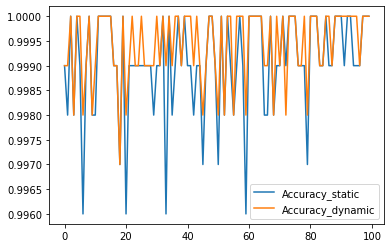

In [17]:
plt.plot(range(k+1),accuracy_static,accuracy_dynamic)
plt.legend(['Accuracy_static','Accuracy_dynamic'])
plt.savefig('acc_multi')
static_accuray_avg=np.sum(np.array(accuracy_static))/100
print(static_accuray_avg)
dynamic_accuracy_avg=np.sum(np.array(accuracy_dynamic))/100
print(dynamic_accuracy_avg)

Plotting  f1-scores through iterations and computing the average :

0.9579710938236474
0.9754225122821597


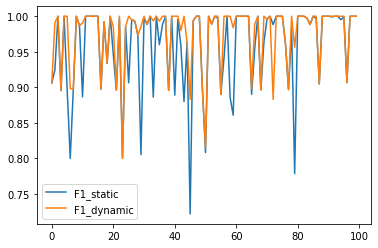

In [18]:
plt.plot(range(k+1),f1_static,f1_dynamic)
plt.legend(['F1_static','F1_dynamic'])
plt.savefig('f1_multi')
static_f1_avg=np.sum(np.array(f1_static))/100
print(static_f1_avg)
dynamic_f1_avg=np.sum(np.array(f1_dynamic))/100
print(dynamic_f1_avg)